In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Network Definition

In [2]:
input_length = 28*28
hidden_0 = 1024
hidden_1 = 1024
hidden_2 = 1024
output_length = 10

In [3]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()
        
        self.input = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=8, min_val=-128.0, max_val=127.0, return_quant_tensor=True)
        
        self.fc0   = qnn.QuantLinear(input_length, hidden_0, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)
        self.bn0   = nn.BatchNorm1d(hidden_0)
        self.relu0 = qnn.QuantReLU(bit_width=8, return_quant_tensor=True)
        self.drop0 = nn.Dropout(dropout)
        
        self.fc1   = qnn.QuantLinear(hidden_0, hidden_1, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)
        self.bn1   = nn.BatchNorm1d(hidden_1)
        self.relu1 = qnn.QuantReLU(bit_width=8, return_quant_tensor=True)
        self.drop1 = nn.Dropout(dropout)
        
        self.fc2   = qnn.QuantLinear(hidden_1, hidden_2, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)
        self.bn2   = nn.BatchNorm1d(hidden_2)
        self.relu2 = qnn.QuantReLU(bit_width=8, return_quant_tensor=True)
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = qnn.QuantLinear(hidden_2, output_length, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)

    def forward(self, x):
        
        out = x.reshape(x.shape[0], -1)
        out = self.input(out)
        out = self.drop0(self.relu0(self.bn0(self.fc0(out))))
        out = self.drop1(self.relu1(self.bn1(self.fc1(out))))
        out = self.drop2(self.relu2(self.bn2(self.fc2(out))))
        out = self.out(out)
        
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
    
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2919, Acc: 0.9163 | Val Loss: 0.1729, Acc: 0.9476


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1381, Acc: 0.9587 | Val Loss: 0.1421, Acc: 0.9565


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1014, Acc: 0.9687 | Val Loss: 0.1086, Acc: 0.9673


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9746 | Val Loss: 0.1127, Acc: 0.9680


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9792 | Val Loss: 0.1007, Acc: 0.9725


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9824 | Val Loss: 0.1018, Acc: 0.9714


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9840 | Val Loss: 0.0957, Acc: 0.9712


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9865 | Val Loss: 0.1016, Acc: 0.9728


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.1007, Acc: 0.9744


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.0979, Acc: 0.9743


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.1041, Acc: 0.9747


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1061, Acc: 0.9748


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.0976, Acc: 0.9756


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.1006, Acc: 0.9764


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.0997, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.0865, Acc: 0.9764


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.1087, Acc: 0.9752


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.0975, Acc: 0.9769


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.1095, Acc: 0.9753


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.1050, Acc: 0.9762


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.1031, Acc: 0.9758


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.0977, Acc: 0.9780


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.1070, Acc: 0.9767


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.1129, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.1055, Acc: 0.9759


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1149, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0849, Acc: 0.9780


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0937, Acc: 0.9765


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9963 | Val Loss: 0.1162, Acc: 0.9756


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1214, Acc: 0.9778


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1087, Acc: 0.9784


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1179, Acc: 0.9775


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0926, Acc: 0.9789


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0943, Acc: 0.9740


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.0889, Acc: 0.9787


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.0949, Acc: 0.9762


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0968, Acc: 0.9773


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1054, Acc: 0.9786


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0906, Acc: 0.9808


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1080, Acc: 0.9765


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1175, Acc: 0.9782


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1083, Acc: 0.9779


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1023, Acc: 0.9781


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1310, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1224, Acc: 0.9776


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.1252, Acc: 0.9788


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1076, Acc: 0.9772


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1316, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1260, Acc: 0.9782


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1093, Acc: 0.9785


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.1189, Acc: 0.9776


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0976, Acc: 0.9797


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.1032, Acc: 0.9788


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0907, Acc: 0.9774


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1296, Acc: 0.9766


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1055, Acc: 0.9791


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1230, Acc: 0.9798


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1087, Acc: 0.9793


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0895, Acc: 0.9767


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1105, Acc: 0.9752


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0885, Acc: 0.9777


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9974 | Val Loss: 0.1104, Acc: 0.9779


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.1241, Acc: 0.9780


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.1090, Acc: 0.9778


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1056, Acc: 0.9781


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1266, Acc: 0.9772


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1424, Acc: 0.9778


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1041, Acc: 0.9775


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1133, Acc: 0.9762


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1154, Acc: 0.9758


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1253, Acc: 0.9743


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.1656, Acc: 0.9753


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1305, Acc: 0.9757


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1076, Acc: 0.9773


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1204, Acc: 0.9772


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1120, Acc: 0.9743


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9972 | Val Loss: 0.0904, Acc: 0.9780


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1092, Acc: 0.9780


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1346, Acc: 0.9769


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1202, Acc: 0.9778


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1509, Acc: 0.9768


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1425, Acc: 0.9745


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1599, Acc: 0.9764


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1234, Acc: 0.9765


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1584, Acc: 0.9772


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1584, Acc: 0.9792


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1118, Acc: 0.9791


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1182, Acc: 0.9779


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0927, Acc: 0.9787


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1579, Acc: 0.9773


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1198, Acc: 0.9766


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1583, Acc: 0.9748


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1267, Acc: 0.9758


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1475, Acc: 0.9768


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.1436, Acc: 0.9752


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1017, Acc: 0.9775


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1394, Acc: 0.9767


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.1165, Acc: 0.9770


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1246, Acc: 0.9778


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1454, Acc: 0.9771


Final Test Loss: 0.1268 Accuracy: 0.9799


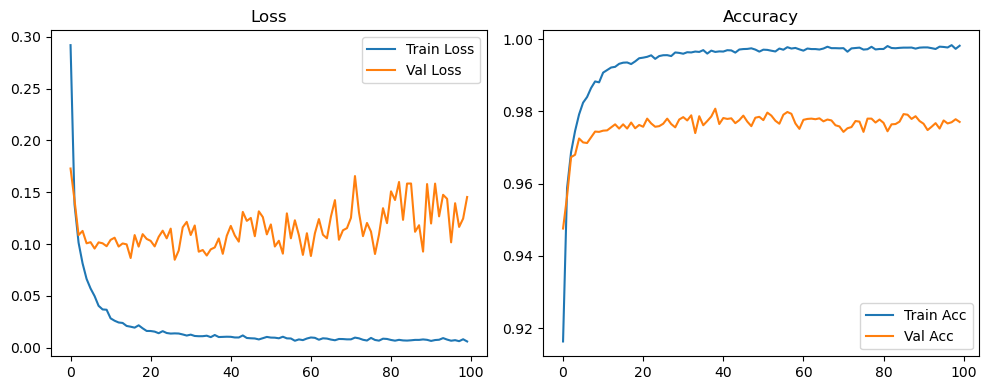

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3153, Acc: 0.9092 | Val Loss: 0.1508, Acc: 0.9543


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1567, Acc: 0.9523 | Val Loss: 0.1281, Acc: 0.9615


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1261, Acc: 0.9617 | Val Loss: 0.1077, Acc: 0.9681


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0957, Acc: 0.9702 | Val Loss: 0.0954, Acc: 0.9727


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9742 | Val Loss: 0.1006, Acc: 0.9713


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9764 | Val Loss: 0.0929, Acc: 0.9716


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9784 | Val Loss: 0.1062, Acc: 0.9712


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9815 | Val Loss: 0.0970, Acc: 0.9714


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9819 | Val Loss: 0.0940, Acc: 0.9744


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9835 | Val Loss: 0.0957, Acc: 0.9752


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.0987, Acc: 0.9732


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9852 | Val Loss: 0.0839, Acc: 0.9763


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9858 | Val Loss: 0.0936, Acc: 0.9761


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9867 | Val Loss: 0.0928, Acc: 0.9757


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.0924, Acc: 0.9754


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9874 | Val Loss: 0.1047, Acc: 0.9771


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.0899, Acc: 0.9753


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9892 | Val Loss: 0.0947, Acc: 0.9783


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9881 | Val Loss: 0.0978, Acc: 0.9787


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9896 | Val Loss: 0.1035, Acc: 0.9756


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.0908, Acc: 0.9762


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9902 | Val Loss: 0.0884, Acc: 0.9760


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9895 | Val Loss: 0.1010, Acc: 0.9758


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9902 | Val Loss: 0.0875, Acc: 0.9783


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9904 | Val Loss: 0.1117, Acc: 0.9767


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.1033, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9903 | Val Loss: 0.0832, Acc: 0.9783


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9921 | Val Loss: 0.1043, Acc: 0.9772


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9912 | Val Loss: 0.1003, Acc: 0.9778


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9906 | Val Loss: 0.1125, Acc: 0.9766


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9913 | Val Loss: 0.1075, Acc: 0.9782


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9917 | Val Loss: 0.1186, Acc: 0.9761


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0985, Acc: 0.9773


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.0841, Acc: 0.9757


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.1099, Acc: 0.9771


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9913 | Val Loss: 0.1205, Acc: 0.9786


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9922 | Val Loss: 0.0960, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.1093, Acc: 0.9777


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.1007, Acc: 0.9759


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.1046, Acc: 0.9773


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0949, Acc: 0.9781


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9924 | Val Loss: 0.1475, Acc: 0.9788


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9920 | Val Loss: 0.1135, Acc: 0.9771


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9924 | Val Loss: 0.1099, Acc: 0.9783


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.1042, Acc: 0.9777


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9920 | Val Loss: 0.1101, Acc: 0.9780


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9922 | Val Loss: 0.0882, Acc: 0.9784


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9932 | Val Loss: 0.0886, Acc: 0.9777


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9929 | Val Loss: 0.1195, Acc: 0.9776


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9933 | Val Loss: 0.0933, Acc: 0.9790


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9926 | Val Loss: 0.1019, Acc: 0.9762


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9928 | Val Loss: 0.0894, Acc: 0.9782


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9932 | Val Loss: 0.0785, Acc: 0.9774


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.0813, Acc: 0.9770


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9924 | Val Loss: 0.1167, Acc: 0.9772


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9923 | Val Loss: 0.0820, Acc: 0.9796


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.0953, Acc: 0.9795


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.1181, Acc: 0.9802


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.0842, Acc: 0.9766


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9931 | Val Loss: 0.0925, Acc: 0.9793


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.1265, Acc: 0.9778


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9923 | Val Loss: 0.0927, Acc: 0.9784


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.1003, Acc: 0.9788


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.1447, Acc: 0.9779


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9929 | Val Loss: 0.0897, Acc: 0.9790


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9934 | Val Loss: 0.0821, Acc: 0.9777


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9933 | Val Loss: 0.0983, Acc: 0.9768


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.0918, Acc: 0.9774


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9924 | Val Loss: 0.0878, Acc: 0.9796


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0890, Acc: 0.9804


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9934 | Val Loss: 0.0719, Acc: 0.9804


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9932 | Val Loss: 0.1067, Acc: 0.9796


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.0806, Acc: 0.9783


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.1066, Acc: 0.9787


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9935 | Val Loss: 0.0841, Acc: 0.9778


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9935 | Val Loss: 0.0827, Acc: 0.9777


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.0965, Acc: 0.9775


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9937 | Val Loss: 0.0858, Acc: 0.9778


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9943 | Val Loss: 0.0789, Acc: 0.9768


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9939 | Val Loss: 0.1089, Acc: 0.9791


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9936 | Val Loss: 0.1149, Acc: 0.9788


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9929 | Val Loss: 0.1260, Acc: 0.9782


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9939 | Val Loss: 0.0909, Acc: 0.9785


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9940 | Val Loss: 0.0963, Acc: 0.9797


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9928 | Val Loss: 0.1062, Acc: 0.9764


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.0832, Acc: 0.9792


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.1398, Acc: 0.9778


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9939 | Val Loss: 0.1042, Acc: 0.9778


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1083, Acc: 0.9786


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9940 | Val Loss: 0.1198, Acc: 0.9767


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9938 | Val Loss: 0.1310, Acc: 0.9792


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9939 | Val Loss: 0.0922, Acc: 0.9785


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9938 | Val Loss: 0.0776, Acc: 0.9781


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9939 | Val Loss: 0.0765, Acc: 0.9789


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9934 | Val Loss: 0.1008, Acc: 0.9786


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.0803, Acc: 0.9779


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9941 | Val Loss: 0.1121, Acc: 0.9789


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9934 | Val Loss: 0.1028, Acc: 0.9786


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.1021, Acc: 0.9774


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9937 | Val Loss: 0.1579, Acc: 0.9768


Final Test Loss: 0.1224 Accuracy: 0.9783


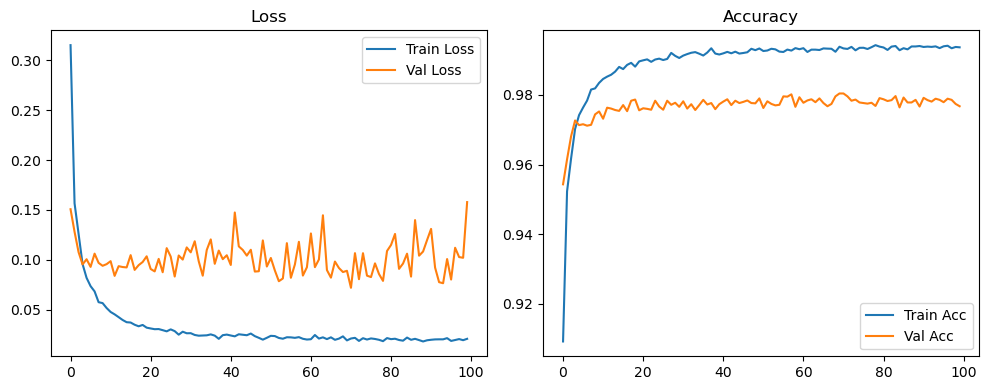

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4073, Acc: 0.8852 | Val Loss: 0.1752, Acc: 0.9469


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2283, Acc: 0.9318 | Val Loss: 0.1293, Acc: 0.9597


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1910, Acc: 0.9440 | Val Loss: 0.1176, Acc: 0.9657


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1723, Acc: 0.9492 | Val Loss: 0.1198, Acc: 0.9661


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1539, Acc: 0.9545 | Val Loss: 0.0946, Acc: 0.9723


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1279, Acc: 0.9625 | Val Loss: 0.0897, Acc: 0.9731


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1200, Acc: 0.9630 | Val Loss: 0.0993, Acc: 0.9711


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1147, Acc: 0.9641 | Val Loss: 0.0933, Acc: 0.9738


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1090, Acc: 0.9663 | Val Loss: 0.0936, Acc: 0.9752


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1059, Acc: 0.9670 | Val Loss: 0.0828, Acc: 0.9756


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0983, Acc: 0.9694 | Val Loss: 0.1009, Acc: 0.9742


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1014, Acc: 0.9685 | Val Loss: 0.0861, Acc: 0.9748


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9700 | Val Loss: 0.0852, Acc: 0.9758


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0958, Acc: 0.9706 | Val Loss: 0.0957, Acc: 0.9749


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9722 | Val Loss: 0.0933, Acc: 0.9746


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9712 | Val Loss: 0.0813, Acc: 0.9762


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0859, Acc: 0.9723 | Val Loss: 0.0880, Acc: 0.9767


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9734 | Val Loss: 0.0759, Acc: 0.9783


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9721 | Val Loss: 0.0810, Acc: 0.9769


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9746 | Val Loss: 0.0942, Acc: 0.9746


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0842, Acc: 0.9743 | Val Loss: 0.0852, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0820, Acc: 0.9746 | Val Loss: 0.0814, Acc: 0.9771


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9741 | Val Loss: 0.0807, Acc: 0.9780


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0827, Acc: 0.9741 | Val Loss: 0.0789, Acc: 0.9769


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9739 | Val Loss: 0.0919, Acc: 0.9769


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9736 | Val Loss: 0.0824, Acc: 0.9767


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9738 | Val Loss: 0.0909, Acc: 0.9774


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0823, Acc: 0.9745 | Val Loss: 0.0842, Acc: 0.9760


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0825, Acc: 0.9739 | Val Loss: 0.0748, Acc: 0.9768


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9754 | Val Loss: 0.0830, Acc: 0.9782


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9765 | Val Loss: 0.0874, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9763 | Val Loss: 0.0767, Acc: 0.9771


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9756 | Val Loss: 0.0838, Acc: 0.9782


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9739 | Val Loss: 0.0806, Acc: 0.9768


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9754 | Val Loss: 0.0920, Acc: 0.9778


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9745 | Val Loss: 0.0753, Acc: 0.9786


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9766 | Val Loss: 0.0817, Acc: 0.9768


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9756 | Val Loss: 0.0802, Acc: 0.9793


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9765 | Val Loss: 0.0832, Acc: 0.9771


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9768 | Val Loss: 0.0780, Acc: 0.9788


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9752 | Val Loss: 0.0764, Acc: 0.9774


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9742 | Val Loss: 0.0867, Acc: 0.9772


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9760 | Val Loss: 0.0730, Acc: 0.9792


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9766 | Val Loss: 0.0858, Acc: 0.9775


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9764 | Val Loss: 0.0819, Acc: 0.9784


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0789, Acc: 0.9757 | Val Loss: 0.0776, Acc: 0.9776


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9750 | Val Loss: 0.0798, Acc: 0.9761


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0791, Acc: 0.9753 | Val Loss: 0.0812, Acc: 0.9768


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9749 | Val Loss: 0.0763, Acc: 0.9764


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9761 | Val Loss: 0.0714, Acc: 0.9781


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9764 | Val Loss: 0.0824, Acc: 0.9768


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0764, Acc: 0.9761 | Val Loss: 0.0850, Acc: 0.9772


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9771 | Val Loss: 0.0824, Acc: 0.9780


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9768 | Val Loss: 0.0897, Acc: 0.9781


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0740, Acc: 0.9766 | Val Loss: 0.0761, Acc: 0.9764


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0764, Acc: 0.9759 | Val Loss: 0.0891, Acc: 0.9770


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9766 | Val Loss: 0.1048, Acc: 0.9781


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9767 | Val Loss: 0.0768, Acc: 0.9769


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9771 | Val Loss: 0.0757, Acc: 0.9779


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0721, Acc: 0.9775 | Val Loss: 0.0872, Acc: 0.9769


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9769 | Val Loss: 0.0725, Acc: 0.9782


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0758, Acc: 0.9760 | Val Loss: 0.0854, Acc: 0.9772


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9770 | Val Loss: 0.0721, Acc: 0.9787


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0786, Acc: 0.9762 | Val Loss: 0.0754, Acc: 0.9767


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9765 | Val Loss: 0.0899, Acc: 0.9780


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9774 | Val Loss: 0.0800, Acc: 0.9778


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0718, Acc: 0.9771 | Val Loss: 0.0802, Acc: 0.9773


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9770 | Val Loss: 0.0788, Acc: 0.9780


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9765 | Val Loss: 0.0780, Acc: 0.9782


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9772 | Val Loss: 0.0811, Acc: 0.9794


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9762 | Val Loss: 0.0836, Acc: 0.9788


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9765 | Val Loss: 0.0944, Acc: 0.9770


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0740, Acc: 0.9772 | Val Loss: 0.0839, Acc: 0.9767


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9764 | Val Loss: 0.0792, Acc: 0.9774


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9772 | Val Loss: 0.0846, Acc: 0.9785


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9772 | Val Loss: 0.0935, Acc: 0.9768


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0789, Acc: 0.9755 | Val Loss: 0.0763, Acc: 0.9769


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9767 | Val Loss: 0.0811, Acc: 0.9781


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9767 | Val Loss: 0.0862, Acc: 0.9781


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9768 | Val Loss: 0.0745, Acc: 0.9778


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0709, Acc: 0.9777 | Val Loss: 0.0762, Acc: 0.9783


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9764 | Val Loss: 0.1033, Acc: 0.9777


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9775 | Val Loss: 0.0798, Acc: 0.9760


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9779 | Val Loss: 0.1063, Acc: 0.9773


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9771 | Val Loss: 0.0820, Acc: 0.9777


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9775 | Val Loss: 0.0768, Acc: 0.9763


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0737, Acc: 0.9780 | Val Loss: 0.0872, Acc: 0.9784


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9785 | Val Loss: 0.1028, Acc: 0.9776


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9774 | Val Loss: 0.0730, Acc: 0.9776


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9777 | Val Loss: 0.0735, Acc: 0.9778


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9774 | Val Loss: 0.0852, Acc: 0.9782


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0758, Acc: 0.9759 | Val Loss: 0.0989, Acc: 0.9780


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0722, Acc: 0.9771 | Val Loss: 0.0793, Acc: 0.9777


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9766 | Val Loss: 0.0853, Acc: 0.9778


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9765 | Val Loss: 0.0750, Acc: 0.9783


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9764 | Val Loss: 0.0787, Acc: 0.9775


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0715, Acc: 0.9771 | Val Loss: 0.0976, Acc: 0.9764


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9768 | Val Loss: 0.0760, Acc: 0.9768


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0744, Acc: 0.9772 | Val Loss: 0.0891, Acc: 0.9763


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9783 | Val Loss: 0.0781, Acc: 0.9769


Final Test Loss: 0.0698 Accuracy: 0.9787


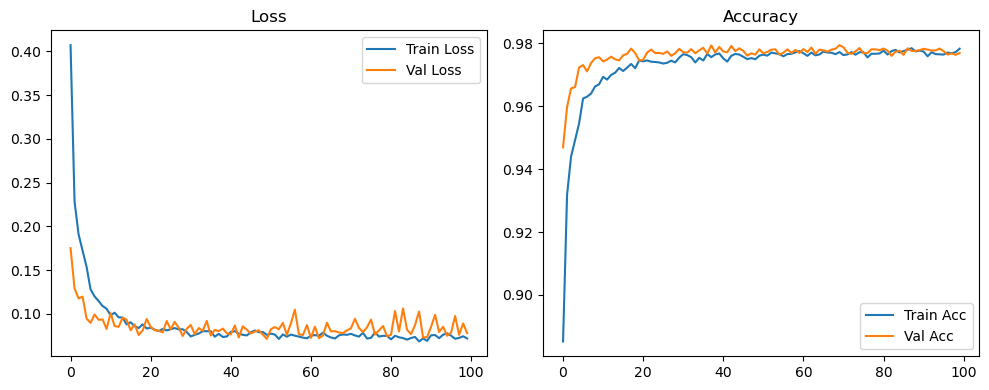

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2919, Acc: 0.9163 | Val Loss: 0.1729, Acc: 0.9476


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1381, Acc: 0.9587 | Val Loss: 0.1421, Acc: 0.9565


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1014, Acc: 0.9687 | Val Loss: 0.1086, Acc: 0.9673


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9746 | Val Loss: 0.1127, Acc: 0.9680


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9792 | Val Loss: 0.1007, Acc: 0.9725


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9824 | Val Loss: 0.1018, Acc: 0.9714


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9840 | Val Loss: 0.0957, Acc: 0.9712


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9865 | Val Loss: 0.1016, Acc: 0.9728


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.1007, Acc: 0.9744


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.0979, Acc: 0.9743


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.1041, Acc: 0.9747


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1061, Acc: 0.9748


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.0976, Acc: 0.9756


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.1006, Acc: 0.9764


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.0997, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.0865, Acc: 0.9764


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.1087, Acc: 0.9752


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.0975, Acc: 0.9769


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.1095, Acc: 0.9753


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.1050, Acc: 0.9762


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.1031, Acc: 0.9758


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.0977, Acc: 0.9780


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.1070, Acc: 0.9767


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.1129, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.1055, Acc: 0.9759


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1149, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0849, Acc: 0.9780


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0937, Acc: 0.9765


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9963 | Val Loss: 0.1162, Acc: 0.9756


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1214, Acc: 0.9778


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1087, Acc: 0.9784


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1179, Acc: 0.9775


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0926, Acc: 0.9789


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0943, Acc: 0.9740


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.0889, Acc: 0.9787


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.0949, Acc: 0.9762


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0968, Acc: 0.9773


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1054, Acc: 0.9786


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0906, Acc: 0.9808


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1080, Acc: 0.9765


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1175, Acc: 0.9782


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1083, Acc: 0.9779


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1023, Acc: 0.9781


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1310, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1224, Acc: 0.9776


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.1252, Acc: 0.9788


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1076, Acc: 0.9772


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1316, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1260, Acc: 0.9782


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1093, Acc: 0.9785


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1173, Acc: 0.9798


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1245, Acc: 0.9798


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0912, Acc: 0.9791


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1196, Acc: 0.9806


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1359, Acc: 0.9792


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1272, Acc: 0.9795


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1284, Acc: 0.9797


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1561, Acc: 0.9810


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1200, Acc: 0.9801


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1146, Acc: 0.9795


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1102, Acc: 0.9791


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1175, Acc: 0.9784


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1281, Acc: 0.9790


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1307, Acc: 0.9770


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1343, Acc: 0.9783


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1287, Acc: 0.9786


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1375, Acc: 0.9788


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1210, Acc: 0.9788


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1381, Acc: 0.9802


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1363, Acc: 0.9787


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.1078, Acc: 0.9790


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1341, Acc: 0.9797


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1213, Acc: 0.9795


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1171, Acc: 0.9797


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1443, Acc: 0.9812


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1531, Acc: 0.9807


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1459, Acc: 0.9800


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1288, Acc: 0.9787


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1441, Acc: 0.9775


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1312, Acc: 0.9795


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1303, Acc: 0.9804


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1231, Acc: 0.9800


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1471, Acc: 0.9802


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1201, Acc: 0.9806


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1191, Acc: 0.9806


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1395, Acc: 0.9816


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1201, Acc: 0.9809


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1382, Acc: 0.9818


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1181, Acc: 0.9816


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1348, Acc: 0.9820


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1602, Acc: 0.9817


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1709, Acc: 0.9810


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1647, Acc: 0.9799


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1223, Acc: 0.9803


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1505, Acc: 0.9802


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1471, Acc: 0.9808


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1313, Acc: 0.9803


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1545, Acc: 0.9812


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1751, Acc: 0.9805


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1514, Acc: 0.9814


Final Test Loss: 0.1459 Accuracy: 0.9819


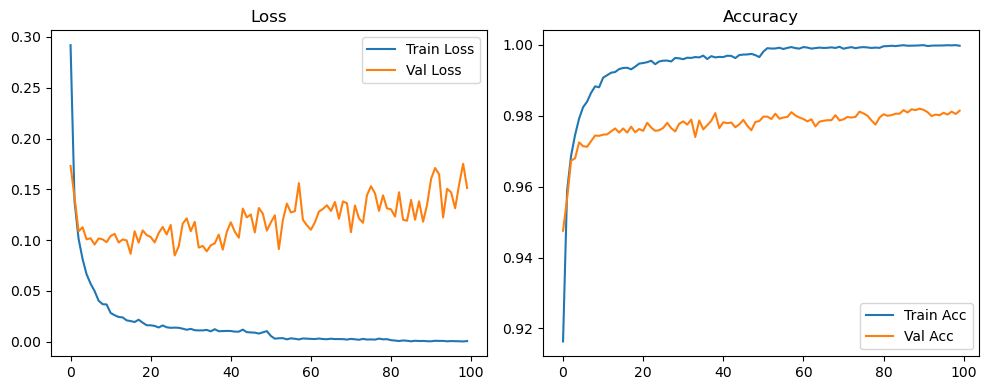

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3153, Acc: 0.9092 | Val Loss: 0.1508, Acc: 0.9543


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1567, Acc: 0.9523 | Val Loss: 0.1281, Acc: 0.9615


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1261, Acc: 0.9617 | Val Loss: 0.1077, Acc: 0.9681


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0957, Acc: 0.9702 | Val Loss: 0.0954, Acc: 0.9727


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9742 | Val Loss: 0.1006, Acc: 0.9713


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9764 | Val Loss: 0.0929, Acc: 0.9716


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9784 | Val Loss: 0.1062, Acc: 0.9712


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9815 | Val Loss: 0.0970, Acc: 0.9714


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9819 | Val Loss: 0.0940, Acc: 0.9744


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9835 | Val Loss: 0.0957, Acc: 0.9752


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.0987, Acc: 0.9732


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9852 | Val Loss: 0.0839, Acc: 0.9763


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9858 | Val Loss: 0.0936, Acc: 0.9761


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9867 | Val Loss: 0.0928, Acc: 0.9757


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.0924, Acc: 0.9754


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9874 | Val Loss: 0.1047, Acc: 0.9771


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.0899, Acc: 0.9753


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9892 | Val Loss: 0.0947, Acc: 0.9783


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9881 | Val Loss: 0.0978, Acc: 0.9787


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9896 | Val Loss: 0.1035, Acc: 0.9756


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.0908, Acc: 0.9762


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9902 | Val Loss: 0.0884, Acc: 0.9760


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9895 | Val Loss: 0.1010, Acc: 0.9758


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9902 | Val Loss: 0.0875, Acc: 0.9783


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9904 | Val Loss: 0.1117, Acc: 0.9767


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.1033, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9903 | Val Loss: 0.0832, Acc: 0.9783


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9921 | Val Loss: 0.1043, Acc: 0.9772


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9912 | Val Loss: 0.1003, Acc: 0.9778


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9906 | Val Loss: 0.1125, Acc: 0.9766


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9913 | Val Loss: 0.1075, Acc: 0.9782


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9917 | Val Loss: 0.1186, Acc: 0.9761


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0985, Acc: 0.9773


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.0841, Acc: 0.9757


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.1099, Acc: 0.9771


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9913 | Val Loss: 0.1205, Acc: 0.9786


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9922 | Val Loss: 0.0960, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.1093, Acc: 0.9777


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.1007, Acc: 0.9759


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.1046, Acc: 0.9773


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0949, Acc: 0.9781


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9924 | Val Loss: 0.1475, Acc: 0.9788


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9920 | Val Loss: 0.1135, Acc: 0.9771


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9924 | Val Loss: 0.1099, Acc: 0.9783


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.1042, Acc: 0.9777


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9920 | Val Loss: 0.1101, Acc: 0.9780


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9922 | Val Loss: 0.0882, Acc: 0.9784


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9932 | Val Loss: 0.0886, Acc: 0.9777


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9929 | Val Loss: 0.1195, Acc: 0.9776


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9933 | Val Loss: 0.0933, Acc: 0.9790


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.1058, Acc: 0.9794


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0920, Acc: 0.9793


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.0750, Acc: 0.9808


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0926, Acc: 0.9790


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1183, Acc: 0.9792


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1021, Acc: 0.9807


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0878, Acc: 0.9803


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1344, Acc: 0.9801


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0800, Acc: 0.9809


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0904, Acc: 0.9808


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0975, Acc: 0.9804


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1154, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0961, Acc: 0.9804


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1257, Acc: 0.9799


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.1099, Acc: 0.9803


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1135, Acc: 0.9794


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1489, Acc: 0.9800


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1393, Acc: 0.9797


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1209, Acc: 0.9798


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0981, Acc: 0.9817


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1147, Acc: 0.9808


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1426, Acc: 0.9809


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1328, Acc: 0.9793


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1294, Acc: 0.9811


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1097, Acc: 0.9811


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0849, Acc: 0.9809


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0911, Acc: 0.9812


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1280, Acc: 0.9809


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1029, Acc: 0.9811


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1158, Acc: 0.9818


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1045, Acc: 0.9820


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0976, Acc: 0.9819


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.1204, Acc: 0.9819


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0850, Acc: 0.9811


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1054, Acc: 0.9820


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0879, Acc: 0.9816


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1218, Acc: 0.9812


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1241, Acc: 0.9816


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1269, Acc: 0.9812


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0939, Acc: 0.9826


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1109, Acc: 0.9817


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1101, Acc: 0.9823


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1185, Acc: 0.9823


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1096, Acc: 0.9819


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0914, Acc: 0.9816


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1153, Acc: 0.9811


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0783, Acc: 0.9814


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1212, Acc: 0.9815


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1306, Acc: 0.9813


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1142, Acc: 0.9814


Final Test Loss: 0.0981 Accuracy: 0.9833


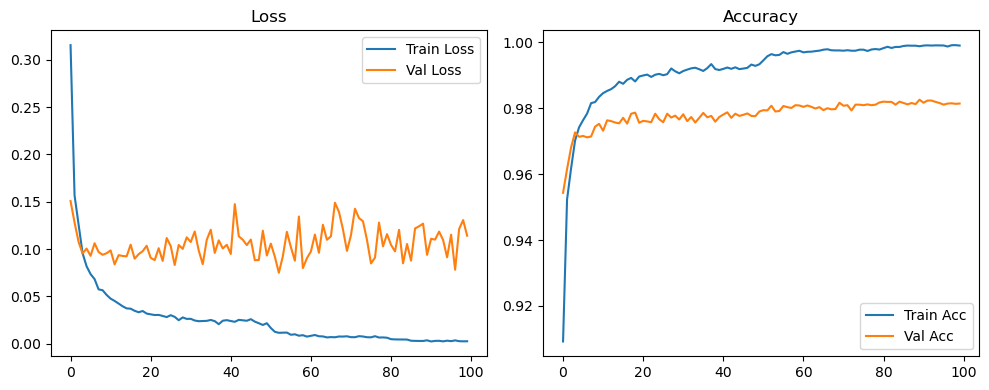

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4073, Acc: 0.8852 | Val Loss: 0.1752, Acc: 0.9469


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2283, Acc: 0.9318 | Val Loss: 0.1293, Acc: 0.9597


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1910, Acc: 0.9440 | Val Loss: 0.1176, Acc: 0.9657


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1723, Acc: 0.9492 | Val Loss: 0.1198, Acc: 0.9661


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1539, Acc: 0.9545 | Val Loss: 0.0946, Acc: 0.9723


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1279, Acc: 0.9625 | Val Loss: 0.0897, Acc: 0.9731


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1200, Acc: 0.9630 | Val Loss: 0.0993, Acc: 0.9711


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1147, Acc: 0.9641 | Val Loss: 0.0933, Acc: 0.9738


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1090, Acc: 0.9663 | Val Loss: 0.0936, Acc: 0.9752


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1059, Acc: 0.9670 | Val Loss: 0.0828, Acc: 0.9756


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0983, Acc: 0.9694 | Val Loss: 0.1009, Acc: 0.9742


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1014, Acc: 0.9685 | Val Loss: 0.0861, Acc: 0.9748


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9700 | Val Loss: 0.0852, Acc: 0.9758


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0958, Acc: 0.9706 | Val Loss: 0.0957, Acc: 0.9749


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9722 | Val Loss: 0.0933, Acc: 0.9746


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9712 | Val Loss: 0.0813, Acc: 0.9762


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0859, Acc: 0.9723 | Val Loss: 0.0880, Acc: 0.9767


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9734 | Val Loss: 0.0759, Acc: 0.9783


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9721 | Val Loss: 0.0810, Acc: 0.9769


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9746 | Val Loss: 0.0942, Acc: 0.9746


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0842, Acc: 0.9743 | Val Loss: 0.0852, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0820, Acc: 0.9746 | Val Loss: 0.0814, Acc: 0.9771


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9741 | Val Loss: 0.0807, Acc: 0.9780


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0827, Acc: 0.9741 | Val Loss: 0.0789, Acc: 0.9769


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9739 | Val Loss: 0.0919, Acc: 0.9769


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9736 | Val Loss: 0.0824, Acc: 0.9767


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9738 | Val Loss: 0.0909, Acc: 0.9774


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0823, Acc: 0.9745 | Val Loss: 0.0842, Acc: 0.9760


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0825, Acc: 0.9739 | Val Loss: 0.0748, Acc: 0.9768


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9754 | Val Loss: 0.0830, Acc: 0.9782


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9765 | Val Loss: 0.0874, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9763 | Val Loss: 0.0767, Acc: 0.9771


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9756 | Val Loss: 0.0838, Acc: 0.9782


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9739 | Val Loss: 0.0806, Acc: 0.9768


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9754 | Val Loss: 0.0920, Acc: 0.9778


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9745 | Val Loss: 0.0753, Acc: 0.9786


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9766 | Val Loss: 0.0817, Acc: 0.9768


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9756 | Val Loss: 0.0802, Acc: 0.9793


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9765 | Val Loss: 0.0832, Acc: 0.9771


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9768 | Val Loss: 0.0780, Acc: 0.9788


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9752 | Val Loss: 0.0764, Acc: 0.9774


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9742 | Val Loss: 0.0867, Acc: 0.9772


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9760 | Val Loss: 0.0730, Acc: 0.9792


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9766 | Val Loss: 0.0858, Acc: 0.9775


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9764 | Val Loss: 0.0819, Acc: 0.9784


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0789, Acc: 0.9757 | Val Loss: 0.0776, Acc: 0.9776


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9750 | Val Loss: 0.0798, Acc: 0.9761


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0791, Acc: 0.9753 | Val Loss: 0.0812, Acc: 0.9768


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9749 | Val Loss: 0.0763, Acc: 0.9764


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9761 | Val Loss: 0.0714, Acc: 0.9781


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0679, Acc: 0.9783 | Val Loss: 0.0700, Acc: 0.9787


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0612, Acc: 0.9795 | Val Loss: 0.0781, Acc: 0.9782


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9820 | Val Loss: 0.0773, Acc: 0.9789


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9817 | Val Loss: 0.0689, Acc: 0.9795


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9832 | Val Loss: 0.0848, Acc: 0.9789


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9832 | Val Loss: 0.0751, Acc: 0.9801


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9835 | Val Loss: 0.0665, Acc: 0.9799


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9834 | Val Loss: 0.0640, Acc: 0.9798


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9843 | Val Loss: 0.0684, Acc: 0.9801


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9841 | Val Loss: 0.0857, Acc: 0.9796


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9850 | Val Loss: 0.0754, Acc: 0.9806


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9855 | Val Loss: 0.0772, Acc: 0.9800


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9848 | Val Loss: 0.0672, Acc: 0.9802


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9861 | Val Loss: 0.0916, Acc: 0.9798


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0449, Acc: 0.9857 | Val Loss: 0.0756, Acc: 0.9801


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9865 | Val Loss: 0.0683, Acc: 0.9803


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9871 | Val Loss: 0.0948, Acc: 0.9796


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9877 | Val Loss: 0.0783, Acc: 0.9803


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9866 | Val Loss: 0.0768, Acc: 0.9792


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9862 | Val Loss: 0.0693, Acc: 0.9805


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9867 | Val Loss: 0.0735, Acc: 0.9805


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9873 | Val Loss: 0.0878, Acc: 0.9797


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9885 | Val Loss: 0.0654, Acc: 0.9812


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9871 | Val Loss: 0.0728, Acc: 0.9802


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9878 | Val Loss: 0.0716, Acc: 0.9796


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9879 | Val Loss: 0.0831, Acc: 0.9801


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9869 | Val Loss: 0.0682, Acc: 0.9808


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9875 | Val Loss: 0.0825, Acc: 0.9807


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9876 | Val Loss: 0.0803, Acc: 0.9805


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9884 | Val Loss: 0.0912, Acc: 0.9802


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9883 | Val Loss: 0.0775, Acc: 0.9806


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9885 | Val Loss: 0.0807, Acc: 0.9812


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9894 | Val Loss: 0.0831, Acc: 0.9814


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9899 | Val Loss: 0.0886, Acc: 0.9808


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 0.0791, Acc: 0.9813


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9907 | Val Loss: 0.0748, Acc: 0.9808


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9908 | Val Loss: 0.0784, Acc: 0.9811


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.0826, Acc: 0.9808


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9912 | Val Loss: 0.0706, Acc: 0.9811


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9913 | Val Loss: 0.0943, Acc: 0.9816


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.0897, Acc: 0.9808


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.0836, Acc: 0.9812


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.0818, Acc: 0.9807


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.0822, Acc: 0.9818


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9917 | Val Loss: 0.0811, Acc: 0.9819


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.0740, Acc: 0.9818


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.0857, Acc: 0.9810


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9924 | Val Loss: 0.0819, Acc: 0.9821


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.0769, Acc: 0.9816


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9925 | Val Loss: 0.0786, Acc: 0.9820


Final Test Loss: 0.0678 Accuracy: 0.9846


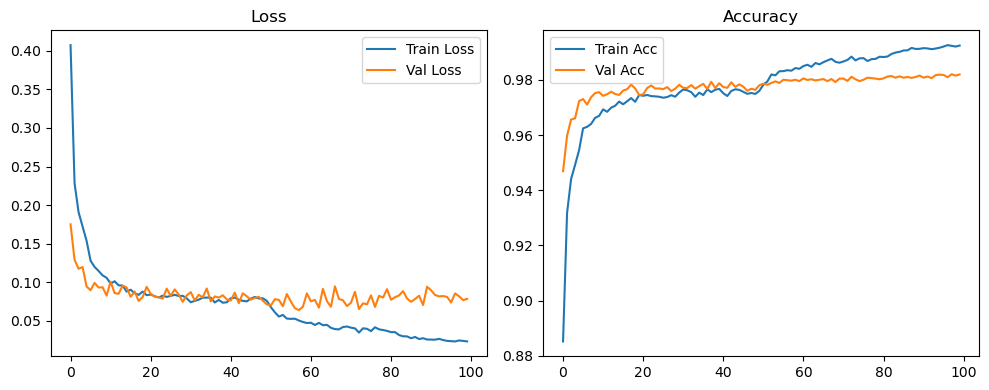

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2919, Acc: 0.9163 | Val Loss: 0.1729, Acc: 0.9476


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1381, Acc: 0.9587 | Val Loss: 0.1421, Acc: 0.9565


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1014, Acc: 0.9687 | Val Loss: 0.1086, Acc: 0.9673


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9746 | Val Loss: 0.1127, Acc: 0.9680


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9792 | Val Loss: 0.1007, Acc: 0.9725


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9824 | Val Loss: 0.1018, Acc: 0.9714


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9840 | Val Loss: 0.0957, Acc: 0.9712


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9865 | Val Loss: 0.1016, Acc: 0.9728


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.1007, Acc: 0.9744


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.0979, Acc: 0.9743


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.1041, Acc: 0.9747


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1061, Acc: 0.9748


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.0976, Acc: 0.9756


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.1006, Acc: 0.9764


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.0997, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.0865, Acc: 0.9764


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.1087, Acc: 0.9752


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.0975, Acc: 0.9769


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.1095, Acc: 0.9753


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.1050, Acc: 0.9762


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.1031, Acc: 0.9758


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.0977, Acc: 0.9780


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.1070, Acc: 0.9767


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.1129, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.1055, Acc: 0.9759


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1149, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0849, Acc: 0.9780


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0937, Acc: 0.9765


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9963 | Val Loss: 0.1162, Acc: 0.9756


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1214, Acc: 0.9778


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1087, Acc: 0.9784


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1179, Acc: 0.9775


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0926, Acc: 0.9789


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0943, Acc: 0.9740


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.0889, Acc: 0.9787


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.0949, Acc: 0.9762


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0968, Acc: 0.9773


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1054, Acc: 0.9786


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0906, Acc: 0.9808


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1080, Acc: 0.9765


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1175, Acc: 0.9782


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1083, Acc: 0.9779


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1023, Acc: 0.9781


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1310, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1224, Acc: 0.9776


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.1252, Acc: 0.9788


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1076, Acc: 0.9772


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1316, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1260, Acc: 0.9782


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1093, Acc: 0.9785


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1173, Acc: 0.9798


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1245, Acc: 0.9798


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0912, Acc: 0.9791


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1196, Acc: 0.9806


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1359, Acc: 0.9792


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1272, Acc: 0.9795


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1284, Acc: 0.9797


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1561, Acc: 0.9810


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1200, Acc: 0.9801


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1146, Acc: 0.9795


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1102, Acc: 0.9791


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1175, Acc: 0.9784


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1281, Acc: 0.9790


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1307, Acc: 0.9770


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1343, Acc: 0.9783


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1287, Acc: 0.9786


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1375, Acc: 0.9788


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1210, Acc: 0.9788


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1381, Acc: 0.9802


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1363, Acc: 0.9787


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.1078, Acc: 0.9790


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1341, Acc: 0.9797


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1213, Acc: 0.9795


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1171, Acc: 0.9797


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1443, Acc: 0.9812


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1531, Acc: 0.9807


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1459, Acc: 0.9800


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1288, Acc: 0.9787


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1441, Acc: 0.9775


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1312, Acc: 0.9795


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1271, Acc: 0.9802


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1345, Acc: 0.9803


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1513, Acc: 0.9800


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1395, Acc: 0.9800


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1375, Acc: 0.9803


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1554, Acc: 0.9812


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1423, Acc: 0.9809


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1547, Acc: 0.9815


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1323, Acc: 0.9811


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1566, Acc: 0.9817


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1346, Acc: 0.9824


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1238, Acc: 0.9813


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1304, Acc: 0.9816


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1333, Acc: 0.9823


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1449, Acc: 0.9808


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1559, Acc: 0.9812


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1630, Acc: 0.9813


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1795, Acc: 0.9819


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1557, Acc: 0.9814


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1644, Acc: 0.9812


Final Test Loss: 0.1514 Accuracy: 0.9823


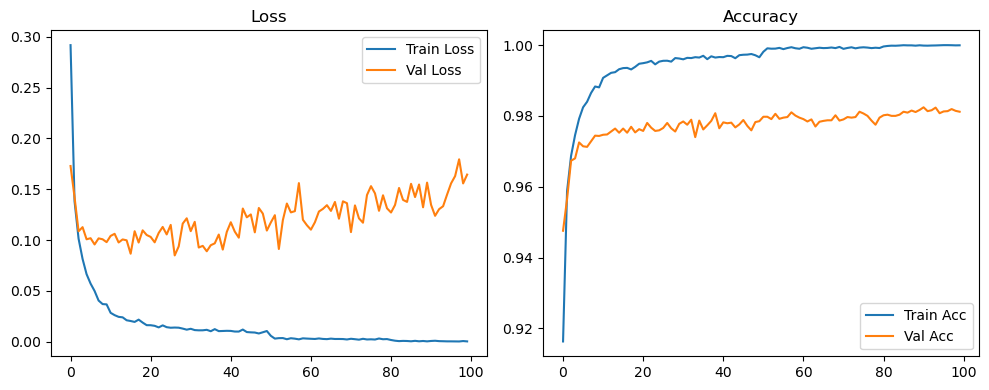

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3153, Acc: 0.9092 | Val Loss: 0.1508, Acc: 0.9543


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1567, Acc: 0.9523 | Val Loss: 0.1281, Acc: 0.9615


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1261, Acc: 0.9617 | Val Loss: 0.1077, Acc: 0.9681


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0957, Acc: 0.9702 | Val Loss: 0.0954, Acc: 0.9727


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9742 | Val Loss: 0.1006, Acc: 0.9713


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9764 | Val Loss: 0.0929, Acc: 0.9716


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9784 | Val Loss: 0.1062, Acc: 0.9712


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9815 | Val Loss: 0.0970, Acc: 0.9714


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9819 | Val Loss: 0.0940, Acc: 0.9744


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9835 | Val Loss: 0.0957, Acc: 0.9752


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.0987, Acc: 0.9732


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9852 | Val Loss: 0.0839, Acc: 0.9763


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9858 | Val Loss: 0.0936, Acc: 0.9761


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9867 | Val Loss: 0.0928, Acc: 0.9757


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.0924, Acc: 0.9754


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9874 | Val Loss: 0.1047, Acc: 0.9771


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.0899, Acc: 0.9753


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9892 | Val Loss: 0.0947, Acc: 0.9783


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9881 | Val Loss: 0.0978, Acc: 0.9787


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9896 | Val Loss: 0.1035, Acc: 0.9756


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.0908, Acc: 0.9762


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9902 | Val Loss: 0.0884, Acc: 0.9760


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9895 | Val Loss: 0.1010, Acc: 0.9758


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9902 | Val Loss: 0.0875, Acc: 0.9783


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9904 | Val Loss: 0.1117, Acc: 0.9767


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.1033, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9903 | Val Loss: 0.0832, Acc: 0.9783


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9921 | Val Loss: 0.1043, Acc: 0.9772


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9912 | Val Loss: 0.1003, Acc: 0.9778


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9906 | Val Loss: 0.1125, Acc: 0.9766


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9913 | Val Loss: 0.1075, Acc: 0.9782


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9917 | Val Loss: 0.1186, Acc: 0.9761


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0985, Acc: 0.9773


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.0841, Acc: 0.9757


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.1099, Acc: 0.9771


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9913 | Val Loss: 0.1205, Acc: 0.9786


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9922 | Val Loss: 0.0960, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.1093, Acc: 0.9777


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.1007, Acc: 0.9759


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.1046, Acc: 0.9773


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0949, Acc: 0.9781


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9924 | Val Loss: 0.1475, Acc: 0.9788


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9920 | Val Loss: 0.1135, Acc: 0.9771


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9924 | Val Loss: 0.1099, Acc: 0.9783


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.1042, Acc: 0.9777


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9920 | Val Loss: 0.1101, Acc: 0.9780


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9922 | Val Loss: 0.0882, Acc: 0.9784


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9932 | Val Loss: 0.0886, Acc: 0.9777


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9929 | Val Loss: 0.1195, Acc: 0.9776


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9933 | Val Loss: 0.0933, Acc: 0.9790


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.1058, Acc: 0.9794


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0920, Acc: 0.9793


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.0750, Acc: 0.9808


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0926, Acc: 0.9790


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1183, Acc: 0.9792


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1021, Acc: 0.9807


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0878, Acc: 0.9803


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1344, Acc: 0.9801


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0800, Acc: 0.9809


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0904, Acc: 0.9808


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0975, Acc: 0.9804


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1154, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0961, Acc: 0.9804


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1257, Acc: 0.9799


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.1099, Acc: 0.9803


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1135, Acc: 0.9794


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1489, Acc: 0.9800


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1393, Acc: 0.9797


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1209, Acc: 0.9798


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0981, Acc: 0.9817


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1147, Acc: 0.9808


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1426, Acc: 0.9809


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1328, Acc: 0.9793


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1294, Acc: 0.9811


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1097, Acc: 0.9811


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0849, Acc: 0.9809


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0911, Acc: 0.9812


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1280, Acc: 0.9809


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1029, Acc: 0.9811


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1158, Acc: 0.9818


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0943, Acc: 0.9824


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0937, Acc: 0.9815


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1154, Acc: 0.9814


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0889, Acc: 0.9808


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1032, Acc: 0.9810


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1107, Acc: 0.9811


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1108, Acc: 0.9811


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1271, Acc: 0.9815


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1202, Acc: 0.9816


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1054, Acc: 0.9818


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1022, Acc: 0.9821


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1075, Acc: 0.9816


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1018, Acc: 0.9823


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1222, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0804, Acc: 0.9819


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1146, Acc: 0.9818


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0928, Acc: 0.9827


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1088, Acc: 0.9822


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1214, Acc: 0.9821


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0996, Acc: 0.9827


Final Test Loss: 0.0863 Accuracy: 0.9844


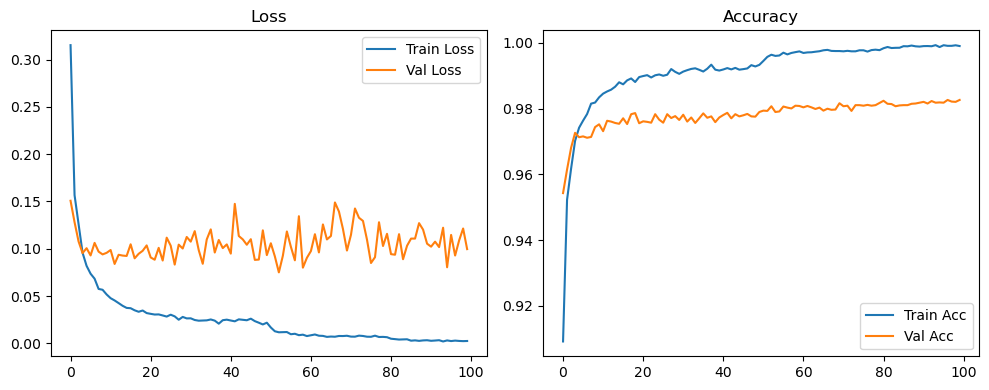

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4073, Acc: 0.8852 | Val Loss: 0.1752, Acc: 0.9469


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2283, Acc: 0.9318 | Val Loss: 0.1293, Acc: 0.9597


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1910, Acc: 0.9440 | Val Loss: 0.1176, Acc: 0.9657


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1723, Acc: 0.9492 | Val Loss: 0.1198, Acc: 0.9661


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1539, Acc: 0.9545 | Val Loss: 0.0946, Acc: 0.9723


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1279, Acc: 0.9625 | Val Loss: 0.0897, Acc: 0.9731


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1200, Acc: 0.9630 | Val Loss: 0.0993, Acc: 0.9711


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1147, Acc: 0.9641 | Val Loss: 0.0933, Acc: 0.9738


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1090, Acc: 0.9663 | Val Loss: 0.0936, Acc: 0.9752


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1059, Acc: 0.9670 | Val Loss: 0.0828, Acc: 0.9756


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0983, Acc: 0.9694 | Val Loss: 0.1009, Acc: 0.9742


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1014, Acc: 0.9685 | Val Loss: 0.0861, Acc: 0.9748


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9700 | Val Loss: 0.0852, Acc: 0.9758


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0958, Acc: 0.9706 | Val Loss: 0.0957, Acc: 0.9749


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9722 | Val Loss: 0.0933, Acc: 0.9746


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9712 | Val Loss: 0.0813, Acc: 0.9762


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0859, Acc: 0.9723 | Val Loss: 0.0880, Acc: 0.9767


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9734 | Val Loss: 0.0759, Acc: 0.9783


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9721 | Val Loss: 0.0810, Acc: 0.9769


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9746 | Val Loss: 0.0942, Acc: 0.9746


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0842, Acc: 0.9743 | Val Loss: 0.0852, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0820, Acc: 0.9746 | Val Loss: 0.0814, Acc: 0.9771


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9741 | Val Loss: 0.0807, Acc: 0.9780


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0827, Acc: 0.9741 | Val Loss: 0.0789, Acc: 0.9769


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9739 | Val Loss: 0.0919, Acc: 0.9769


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9736 | Val Loss: 0.0824, Acc: 0.9767


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9738 | Val Loss: 0.0909, Acc: 0.9774


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0823, Acc: 0.9745 | Val Loss: 0.0842, Acc: 0.9760


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0825, Acc: 0.9739 | Val Loss: 0.0748, Acc: 0.9768


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9754 | Val Loss: 0.0830, Acc: 0.9782


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9765 | Val Loss: 0.0874, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9763 | Val Loss: 0.0767, Acc: 0.9771


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9756 | Val Loss: 0.0838, Acc: 0.9782


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9739 | Val Loss: 0.0806, Acc: 0.9768


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9754 | Val Loss: 0.0920, Acc: 0.9778


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9745 | Val Loss: 0.0753, Acc: 0.9786


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9766 | Val Loss: 0.0817, Acc: 0.9768


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9756 | Val Loss: 0.0802, Acc: 0.9793


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9765 | Val Loss: 0.0832, Acc: 0.9771


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9768 | Val Loss: 0.0780, Acc: 0.9788


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9752 | Val Loss: 0.0764, Acc: 0.9774


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9742 | Val Loss: 0.0867, Acc: 0.9772


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9760 | Val Loss: 0.0730, Acc: 0.9792


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9766 | Val Loss: 0.0858, Acc: 0.9775


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9764 | Val Loss: 0.0819, Acc: 0.9784


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0789, Acc: 0.9757 | Val Loss: 0.0776, Acc: 0.9776


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9750 | Val Loss: 0.0798, Acc: 0.9761


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0791, Acc: 0.9753 | Val Loss: 0.0812, Acc: 0.9768


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9749 | Val Loss: 0.0763, Acc: 0.9764


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9761 | Val Loss: 0.0714, Acc: 0.9781


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0679, Acc: 0.9783 | Val Loss: 0.0700, Acc: 0.9787


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0612, Acc: 0.9795 | Val Loss: 0.0781, Acc: 0.9782


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9820 | Val Loss: 0.0773, Acc: 0.9789


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9817 | Val Loss: 0.0689, Acc: 0.9795


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9832 | Val Loss: 0.0848, Acc: 0.9789


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9832 | Val Loss: 0.0751, Acc: 0.9801


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9835 | Val Loss: 0.0665, Acc: 0.9799


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9834 | Val Loss: 0.0640, Acc: 0.9798


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9843 | Val Loss: 0.0684, Acc: 0.9801


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9841 | Val Loss: 0.0857, Acc: 0.9796


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9850 | Val Loss: 0.0754, Acc: 0.9806


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9855 | Val Loss: 0.0772, Acc: 0.9800


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9848 | Val Loss: 0.0672, Acc: 0.9802


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9861 | Val Loss: 0.0916, Acc: 0.9798


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0449, Acc: 0.9857 | Val Loss: 0.0756, Acc: 0.9801


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9865 | Val Loss: 0.0683, Acc: 0.9803


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9871 | Val Loss: 0.0948, Acc: 0.9796


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9877 | Val Loss: 0.0783, Acc: 0.9803


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9866 | Val Loss: 0.0768, Acc: 0.9792


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9862 | Val Loss: 0.0693, Acc: 0.9805


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9867 | Val Loss: 0.0735, Acc: 0.9805


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9873 | Val Loss: 0.0878, Acc: 0.9797


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9885 | Val Loss: 0.0654, Acc: 0.9812


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9871 | Val Loss: 0.0728, Acc: 0.9802


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9878 | Val Loss: 0.0716, Acc: 0.9796


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9879 | Val Loss: 0.0831, Acc: 0.9801


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9869 | Val Loss: 0.0682, Acc: 0.9808


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9875 | Val Loss: 0.0825, Acc: 0.9807


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9876 | Val Loss: 0.0803, Acc: 0.9805


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9884 | Val Loss: 0.0912, Acc: 0.9802


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0358, Acc: 0.9886 | Val Loss: 0.0737, Acc: 0.9813


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9883 | Val Loss: 0.0761, Acc: 0.9812


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9893 | Val Loss: 0.0783, Acc: 0.9816


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9895 | Val Loss: 0.0815, Acc: 0.9810


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9899 | Val Loss: 0.0779, Acc: 0.9811


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9900 | Val Loss: 0.0728, Acc: 0.9805


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9898 | Val Loss: 0.0756, Acc: 0.9804


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.0811, Acc: 0.9808


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.0739, Acc: 0.9810


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9911 | Val Loss: 0.0897, Acc: 0.9808


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.0799, Acc: 0.9810


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.0786, Acc: 0.9820


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9906 | Val Loss: 0.0804, Acc: 0.9814


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9912 | Val Loss: 0.0813, Acc: 0.9814


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9912 | Val Loss: 0.0791, Acc: 0.9818


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.0747, Acc: 0.9816


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9925 | Val Loss: 0.0848, Acc: 0.9814


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.0796, Acc: 0.9826


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9924 | Val Loss: 0.0762, Acc: 0.9820


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9923 | Val Loss: 0.0741, Acc: 0.9821


Final Test Loss: 0.0661 Accuracy: 0.9837


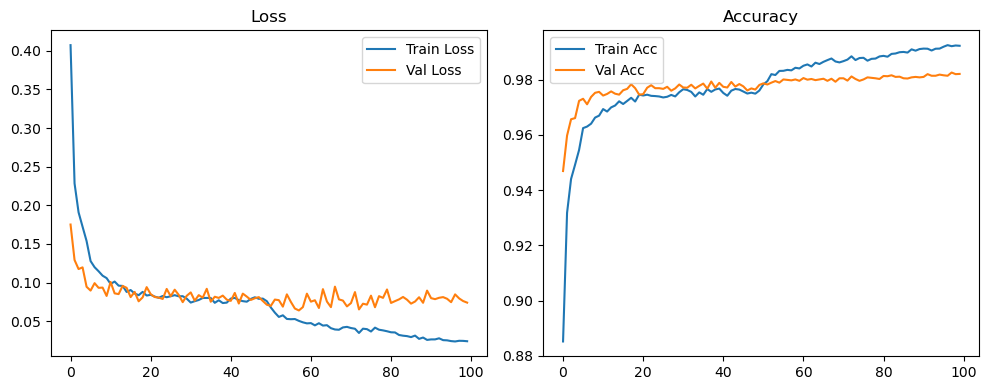

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2919, Acc: 0.9163 | Val Loss: 0.1729, Acc: 0.9476


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1381, Acc: 0.9587 | Val Loss: 0.1421, Acc: 0.9565


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1014, Acc: 0.9687 | Val Loss: 0.1086, Acc: 0.9673


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9746 | Val Loss: 0.1127, Acc: 0.9680


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9792 | Val Loss: 0.1007, Acc: 0.9725


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9824 | Val Loss: 0.1018, Acc: 0.9714


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9840 | Val Loss: 0.0957, Acc: 0.9712


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9865 | Val Loss: 0.1016, Acc: 0.9728


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.1007, Acc: 0.9744


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.0979, Acc: 0.9743


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.1041, Acc: 0.9747


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1061, Acc: 0.9748


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.0976, Acc: 0.9756


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.1006, Acc: 0.9764


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.0997, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.0865, Acc: 0.9764


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.1087, Acc: 0.9752


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.0975, Acc: 0.9769


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.1095, Acc: 0.9753


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.1050, Acc: 0.9762


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.1031, Acc: 0.9758


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.0977, Acc: 0.9780


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.1070, Acc: 0.9767


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.1129, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.1055, Acc: 0.9759


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1149, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0849, Acc: 0.9780


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0937, Acc: 0.9765


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9963 | Val Loss: 0.1162, Acc: 0.9756


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1214, Acc: 0.9778


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1087, Acc: 0.9784


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1179, Acc: 0.9775


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0926, Acc: 0.9789


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0943, Acc: 0.9740


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.0889, Acc: 0.9787


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.0949, Acc: 0.9762


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0968, Acc: 0.9773


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1054, Acc: 0.9786


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0906, Acc: 0.9808


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1080, Acc: 0.9765


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1175, Acc: 0.9782


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1083, Acc: 0.9779


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1023, Acc: 0.9781


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1310, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1224, Acc: 0.9776


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.1252, Acc: 0.9788


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1076, Acc: 0.9772


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1316, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1260, Acc: 0.9782


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1093, Acc: 0.9785


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1071, Acc: 0.9798


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1255, Acc: 0.9805


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1228, Acc: 0.9792


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1350, Acc: 0.9813


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1488, Acc: 0.9818


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1373, Acc: 0.9821


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1467, Acc: 0.9827


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1419, Acc: 0.9819


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1394, Acc: 0.9817


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1556, Acc: 0.9810


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1327, Acc: 0.9815


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1350, Acc: 0.9830


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1191, Acc: 0.9815


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1550, Acc: 0.9818


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1513, Acc: 0.9811


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1608, Acc: 0.9811


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1407, Acc: 0.9805


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1340, Acc: 0.9814


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1371, Acc: 0.9806


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1510, Acc: 0.9814


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1307, Acc: 0.9819


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1374, Acc: 0.9815


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1548, Acc: 0.9811


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1389, Acc: 0.9823


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1625, Acc: 0.9812


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1722, Acc: 0.9813


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1661, Acc: 0.9816


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1838, Acc: 0.9804


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1447, Acc: 0.9805


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1372, Acc: 0.9808


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1439, Acc: 0.9805


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1376, Acc: 0.9812


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1487, Acc: 0.9818


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1628, Acc: 0.9817


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1660, Acc: 0.9811


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1841, Acc: 0.9811


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1938, Acc: 0.9812


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2010, Acc: 0.9816


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1834, Acc: 0.9812


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1724, Acc: 0.9815


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1721, Acc: 0.9819


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1727, Acc: 0.9822


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1799, Acc: 0.9818


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1691, Acc: 0.9824


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1767, Acc: 0.9813


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1710, Acc: 0.9823


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1682, Acc: 0.9819


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1670, Acc: 0.9819


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1640, Acc: 0.9819


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1903, Acc: 0.9822


Final Test Loss: 0.1758 Accuracy: 0.9815


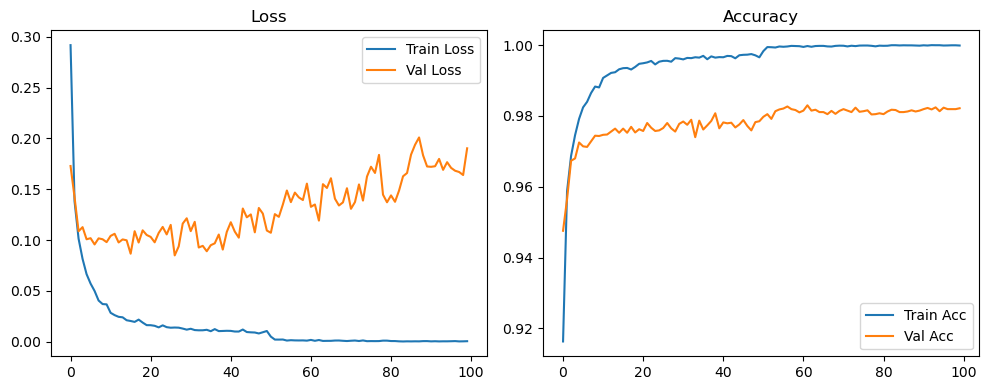

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3153, Acc: 0.9092 | Val Loss: 0.1508, Acc: 0.9543


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1567, Acc: 0.9523 | Val Loss: 0.1281, Acc: 0.9615


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1261, Acc: 0.9617 | Val Loss: 0.1077, Acc: 0.9681


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0957, Acc: 0.9702 | Val Loss: 0.0954, Acc: 0.9727


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9742 | Val Loss: 0.1006, Acc: 0.9713


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9764 | Val Loss: 0.0929, Acc: 0.9716


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9784 | Val Loss: 0.1062, Acc: 0.9712


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9815 | Val Loss: 0.0970, Acc: 0.9714


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9819 | Val Loss: 0.0940, Acc: 0.9744


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9835 | Val Loss: 0.0957, Acc: 0.9752


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.0987, Acc: 0.9732


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9852 | Val Loss: 0.0839, Acc: 0.9763


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9858 | Val Loss: 0.0936, Acc: 0.9761


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9867 | Val Loss: 0.0928, Acc: 0.9757


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.0924, Acc: 0.9754


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9874 | Val Loss: 0.1047, Acc: 0.9771


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.0899, Acc: 0.9753


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9892 | Val Loss: 0.0947, Acc: 0.9783


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9881 | Val Loss: 0.0978, Acc: 0.9787


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9896 | Val Loss: 0.1035, Acc: 0.9756


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.0908, Acc: 0.9762


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9902 | Val Loss: 0.0884, Acc: 0.9760


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9895 | Val Loss: 0.1010, Acc: 0.9758


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9902 | Val Loss: 0.0875, Acc: 0.9783


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9904 | Val Loss: 0.1117, Acc: 0.9767


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.1033, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9903 | Val Loss: 0.0832, Acc: 0.9783


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9921 | Val Loss: 0.1043, Acc: 0.9772


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9912 | Val Loss: 0.1003, Acc: 0.9778


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9906 | Val Loss: 0.1125, Acc: 0.9766


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9913 | Val Loss: 0.1075, Acc: 0.9782


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9917 | Val Loss: 0.1186, Acc: 0.9761


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0985, Acc: 0.9773


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.0841, Acc: 0.9757


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.1099, Acc: 0.9771


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9913 | Val Loss: 0.1205, Acc: 0.9786


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9922 | Val Loss: 0.0960, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.1093, Acc: 0.9777


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.1007, Acc: 0.9759


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.1046, Acc: 0.9773


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0949, Acc: 0.9781


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9924 | Val Loss: 0.1475, Acc: 0.9788


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9920 | Val Loss: 0.1135, Acc: 0.9771


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9924 | Val Loss: 0.1099, Acc: 0.9783


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.1042, Acc: 0.9777


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9920 | Val Loss: 0.1101, Acc: 0.9780


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9922 | Val Loss: 0.0882, Acc: 0.9784


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9932 | Val Loss: 0.0886, Acc: 0.9777


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9929 | Val Loss: 0.1195, Acc: 0.9776


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9933 | Val Loss: 0.0933, Acc: 0.9790


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9946 | Val Loss: 0.0966, Acc: 0.9798


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9958 | Val Loss: 0.0964, Acc: 0.9795


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0957, Acc: 0.9804


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1006, Acc: 0.9808


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0931, Acc: 0.9810


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0842, Acc: 0.9821


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0945, Acc: 0.9822


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1026, Acc: 0.9818


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1052, Acc: 0.9810


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0913, Acc: 0.9808


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.1025, Acc: 0.9811


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0837, Acc: 0.9818


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0896, Acc: 0.9808


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0935, Acc: 0.9822


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0937, Acc: 0.9818


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1019, Acc: 0.9821


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1054, Acc: 0.9822


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0953, Acc: 0.9822


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1118, Acc: 0.9828


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1098, Acc: 0.9831


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0755, Acc: 0.9828


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1189, Acc: 0.9812


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1089, Acc: 0.9824


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1336, Acc: 0.9819


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1040, Acc: 0.9812


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0940, Acc: 0.9823


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0976, Acc: 0.9821


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0929, Acc: 0.9821


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1021, Acc: 0.9827


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1122, Acc: 0.9813


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0936, Acc: 0.9822


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1039, Acc: 0.9820


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1051, Acc: 0.9829


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0978, Acc: 0.9815


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0997, Acc: 0.9824


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1058, Acc: 0.9825


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1075, Acc: 0.9831


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1049, Acc: 0.9837


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1055, Acc: 0.9832


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1158, Acc: 0.9827


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0930, Acc: 0.9831


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0946, Acc: 0.9832


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0958, Acc: 0.9828


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1093, Acc: 0.9827


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1190, Acc: 0.9829


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0879, Acc: 0.9831


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1102, Acc: 0.9837


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0890, Acc: 0.9830


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1135, Acc: 0.9836


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1031, Acc: 0.9826


Final Test Loss: 0.0956 Accuracy: 0.9830


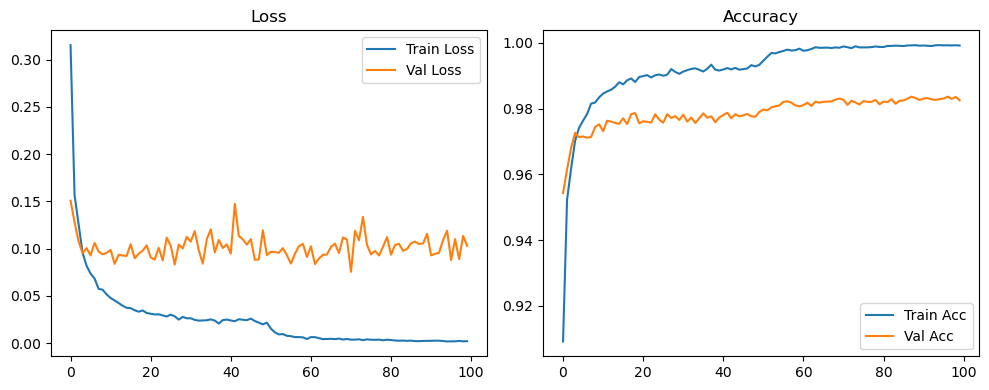

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4073, Acc: 0.8852 | Val Loss: 0.1752, Acc: 0.9469


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2283, Acc: 0.9318 | Val Loss: 0.1293, Acc: 0.9597


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1910, Acc: 0.9440 | Val Loss: 0.1176, Acc: 0.9657


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1723, Acc: 0.9492 | Val Loss: 0.1198, Acc: 0.9661


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1539, Acc: 0.9545 | Val Loss: 0.0946, Acc: 0.9723


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1279, Acc: 0.9625 | Val Loss: 0.0897, Acc: 0.9731


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1200, Acc: 0.9630 | Val Loss: 0.0993, Acc: 0.9711


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1147, Acc: 0.9641 | Val Loss: 0.0933, Acc: 0.9738


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1090, Acc: 0.9663 | Val Loss: 0.0936, Acc: 0.9752


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1059, Acc: 0.9670 | Val Loss: 0.0828, Acc: 0.9756


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0983, Acc: 0.9694 | Val Loss: 0.1009, Acc: 0.9742


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1014, Acc: 0.9685 | Val Loss: 0.0861, Acc: 0.9748


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9700 | Val Loss: 0.0852, Acc: 0.9758


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0958, Acc: 0.9706 | Val Loss: 0.0957, Acc: 0.9749


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9722 | Val Loss: 0.0933, Acc: 0.9746


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9712 | Val Loss: 0.0813, Acc: 0.9762


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0859, Acc: 0.9723 | Val Loss: 0.0880, Acc: 0.9767


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9734 | Val Loss: 0.0759, Acc: 0.9783


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9721 | Val Loss: 0.0810, Acc: 0.9769


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9746 | Val Loss: 0.0942, Acc: 0.9746


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0842, Acc: 0.9743 | Val Loss: 0.0852, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0820, Acc: 0.9746 | Val Loss: 0.0814, Acc: 0.9771


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9741 | Val Loss: 0.0807, Acc: 0.9780


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0827, Acc: 0.9741 | Val Loss: 0.0789, Acc: 0.9769


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9739 | Val Loss: 0.0919, Acc: 0.9769


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9736 | Val Loss: 0.0824, Acc: 0.9767


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9738 | Val Loss: 0.0909, Acc: 0.9774


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0823, Acc: 0.9745 | Val Loss: 0.0842, Acc: 0.9760


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0825, Acc: 0.9739 | Val Loss: 0.0748, Acc: 0.9768


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9754 | Val Loss: 0.0830, Acc: 0.9782


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9765 | Val Loss: 0.0874, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9763 | Val Loss: 0.0767, Acc: 0.9771


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9756 | Val Loss: 0.0838, Acc: 0.9782


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9739 | Val Loss: 0.0806, Acc: 0.9768


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9754 | Val Loss: 0.0920, Acc: 0.9778


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9745 | Val Loss: 0.0753, Acc: 0.9786


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9766 | Val Loss: 0.0817, Acc: 0.9768


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9756 | Val Loss: 0.0802, Acc: 0.9793


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9765 | Val Loss: 0.0832, Acc: 0.9771


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9768 | Val Loss: 0.0780, Acc: 0.9788


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9752 | Val Loss: 0.0764, Acc: 0.9774


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9742 | Val Loss: 0.0867, Acc: 0.9772


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9760 | Val Loss: 0.0730, Acc: 0.9792


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9766 | Val Loss: 0.0858, Acc: 0.9775


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9764 | Val Loss: 0.0819, Acc: 0.9784


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0789, Acc: 0.9757 | Val Loss: 0.0776, Acc: 0.9776


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9750 | Val Loss: 0.0798, Acc: 0.9761


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0791, Acc: 0.9753 | Val Loss: 0.0812, Acc: 0.9768


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9749 | Val Loss: 0.0763, Acc: 0.9764


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9761 | Val Loss: 0.0714, Acc: 0.9781


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0676, Acc: 0.9785 | Val Loss: 0.0710, Acc: 0.9782


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0610, Acc: 0.9801 | Val Loss: 0.0783, Acc: 0.9787


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0555, Acc: 0.9820 | Val Loss: 0.0777, Acc: 0.9793


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0560, Acc: 0.9823 | Val Loss: 0.0725, Acc: 0.9801


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0523, Acc: 0.9829 | Val Loss: 0.0708, Acc: 0.9797


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0504, Acc: 0.9838 | Val Loss: 0.0769, Acc: 0.9805


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9852 | Val Loss: 0.0655, Acc: 0.9802


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9848 | Val Loss: 0.0689, Acc: 0.9806


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0441, Acc: 0.9860 | Val Loss: 0.0669, Acc: 0.9800


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0425, Acc: 0.9863 | Val Loss: 0.0778, Acc: 0.9802


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0439, Acc: 0.9859 | Val Loss: 0.0706, Acc: 0.9802


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9864 | Val Loss: 0.0711, Acc: 0.9807


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9873 | Val Loss: 0.0670, Acc: 0.9807


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0388, Acc: 0.9872 | Val Loss: 0.0736, Acc: 0.9809


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9868 | Val Loss: 0.0794, Acc: 0.9809


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9881 | Val Loss: 0.0741, Acc: 0.9808


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9876 | Val Loss: 0.0718, Acc: 0.9809


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9888 | Val Loss: 0.0691, Acc: 0.9808


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9884 | Val Loss: 0.0776, Acc: 0.9809


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9885 | Val Loss: 0.0651, Acc: 0.9817


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9886 | Val Loss: 0.0730, Acc: 0.9814


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9896 | Val Loss: 0.0840, Acc: 0.9809


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9900 | Val Loss: 0.0704, Acc: 0.9816


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9895 | Val Loss: 0.0615, Acc: 0.9820


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9897 | Val Loss: 0.0788, Acc: 0.9810


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9905 | Val Loss: 0.0814, Acc: 0.9812


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9896 | Val Loss: 0.0793, Acc: 0.9813


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.0732, Acc: 0.9818


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9898 | Val Loss: 0.0670, Acc: 0.9818


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9902 | Val Loss: 0.0679, Acc: 0.9817


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 0.0706, Acc: 0.9816


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9908 | Val Loss: 0.0711, Acc: 0.9821


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9910 | Val Loss: 0.0772, Acc: 0.9818


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9916 | Val Loss: 0.0771, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9909 | Val Loss: 0.0697, Acc: 0.9817


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9912 | Val Loss: 0.0707, Acc: 0.9822


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9919 | Val Loss: 0.0763, Acc: 0.9816


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.0790, Acc: 0.9812


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9920 | Val Loss: 0.0785, Acc: 0.9821


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.0777, Acc: 0.9823


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.0745, Acc: 0.9818


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0719, Acc: 0.9815


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.0729, Acc: 0.9814


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.0765, Acc: 0.9824


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.0771, Acc: 0.9821


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9918 | Val Loss: 0.0688, Acc: 0.9818


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.0749, Acc: 0.9818


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9925 | Val Loss: 0.0716, Acc: 0.9822


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.0699, Acc: 0.9822


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.0770, Acc: 0.9822


Final Test Loss: 0.0690 Accuracy: 0.9838


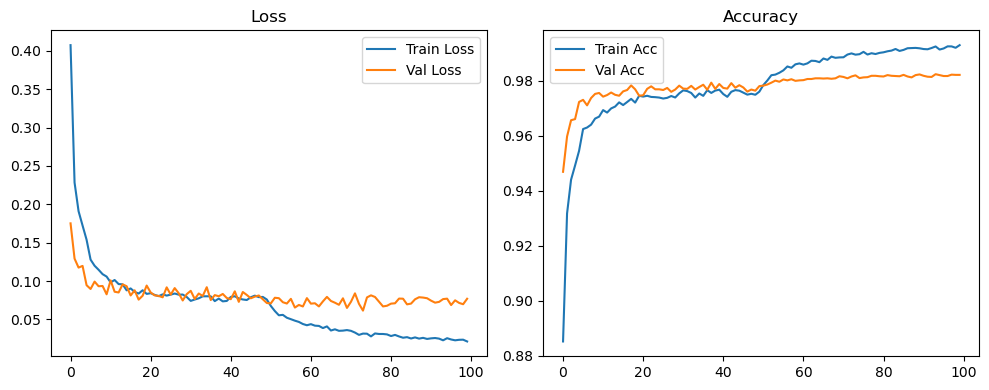

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2704, Acc: 0.9196 | Val Loss: 0.1563, Acc: 0.9520


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1308, Acc: 0.9589 | Val Loss: 0.1211, Acc: 0.9630


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0939, Acc: 0.9713 | Val Loss: 0.1079, Acc: 0.9671


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0733, Acc: 0.9768 | Val Loss: 0.1122, Acc: 0.9663


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0620, Acc: 0.9799 | Val Loss: 0.0997, Acc: 0.9713


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9843 | Val Loss: 0.1067, Acc: 0.9716


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9855 | Val Loss: 0.0938, Acc: 0.9736


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9878 | Val Loss: 0.1151, Acc: 0.9701


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9895 | Val Loss: 0.0991, Acc: 0.9750


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9890 | Val Loss: 0.0827, Acc: 0.9783


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1042, Acc: 0.9737


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.1045, Acc: 0.9745


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9933 | Val Loss: 0.0962, Acc: 0.9779


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.1095, Acc: 0.9738


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.1051, Acc: 0.9768


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.1087, Acc: 0.9758


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0926, Acc: 0.9781


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9946 | Val Loss: 0.1028, Acc: 0.9772


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.1088, Acc: 0.9772


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9956 | Val Loss: 0.1020, Acc: 0.9771


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.1020, Acc: 0.9776


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.1068, Acc: 0.9773


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1090, Acc: 0.9781


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1010, Acc: 0.9788


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.1113, Acc: 0.9783


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1196, Acc: 0.9782


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1156, Acc: 0.9773


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.1111, Acc: 0.9768


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1150, Acc: 0.9784


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1071, Acc: 0.9791


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1104, Acc: 0.9794


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.1087, Acc: 0.9778


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1066, Acc: 0.9788


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0989, Acc: 0.9790


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1141, Acc: 0.9758


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1002, Acc: 0.9788


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1215, Acc: 0.9775


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1161, Acc: 0.9792


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1092, Acc: 0.9793


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1093, Acc: 0.9800


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1210, Acc: 0.9783


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1134, Acc: 0.9802


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1312, Acc: 0.9778


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.1149, Acc: 0.9787


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1106, Acc: 0.9801


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1219, Acc: 0.9794


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1174, Acc: 0.9786


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1170, Acc: 0.9787


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1174, Acc: 0.9792


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.1081, Acc: 0.9777


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1181, Acc: 0.9807


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1131, Acc: 0.9808


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1224, Acc: 0.9796


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1260, Acc: 0.9784


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1459, Acc: 0.9772


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1308, Acc: 0.9780


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.1293, Acc: 0.9792


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1172, Acc: 0.9791


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1196, Acc: 0.9809


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1194, Acc: 0.9791


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1115, Acc: 0.9791


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1243, Acc: 0.9783


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1333, Acc: 0.9776


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1246, Acc: 0.9795


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1110, Acc: 0.9815


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1026, Acc: 0.9802


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1197, Acc: 0.9781


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1172, Acc: 0.9799


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1131, Acc: 0.9792


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1242, Acc: 0.9772


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1108, Acc: 0.9800


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1217, Acc: 0.9792


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1368, Acc: 0.9792


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1071, Acc: 0.9810


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1178, Acc: 0.9813


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1091, Acc: 0.9805


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0950, Acc: 0.9812


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1095, Acc: 0.9808


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1217, Acc: 0.9780


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1052, Acc: 0.9798


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1291, Acc: 0.9814


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1047, Acc: 0.9799


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0975, Acc: 0.9794


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1270, Acc: 0.9800


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1053, Acc: 0.9801


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1328, Acc: 0.9774


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1124, Acc: 0.9791


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1126, Acc: 0.9805


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1146, Acc: 0.9792


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1411, Acc: 0.9792


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1015, Acc: 0.9791


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1310, Acc: 0.9786


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1212, Acc: 0.9790


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1178, Acc: 0.9798


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1127, Acc: 0.9805


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1113, Acc: 0.9799


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1166, Acc: 0.9785


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1080, Acc: 0.9812


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1228, Acc: 0.9791


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1019, Acc: 0.9795


Final Test Loss: 0.0944 Accuracy: 0.9818


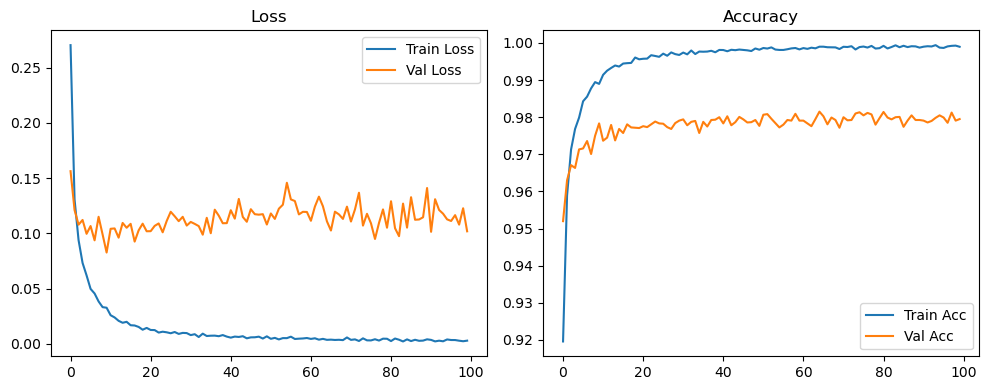

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2900, Acc: 0.9141 | Val Loss: 0.1656, Acc: 0.9497


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1464, Acc: 0.9554 | Val Loss: 0.1228, Acc: 0.9631


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1147, Acc: 0.9651 | Val Loss: 0.1038, Acc: 0.9706


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0933, Acc: 0.9710 | Val Loss: 0.1116, Acc: 0.9674


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0793, Acc: 0.9744 | Val Loss: 0.1044, Acc: 0.9690


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0673, Acc: 0.9789 | Val Loss: 0.0964, Acc: 0.9720


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9809 | Val Loss: 0.0941, Acc: 0.9742


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0549, Acc: 0.9820 | Val Loss: 0.0963, Acc: 0.9747


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9847 | Val Loss: 0.0883, Acc: 0.9762


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9847 | Val Loss: 0.0971, Acc: 0.9747


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9871 | Val Loss: 0.0898, Acc: 0.9759


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9880 | Val Loss: 0.1048, Acc: 0.9728


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.1072, Acc: 0.9743


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9894 | Val Loss: 0.0929, Acc: 0.9774


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9901 | Val Loss: 0.0928, Acc: 0.9772


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.0890, Acc: 0.9776


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9917 | Val Loss: 0.1050, Acc: 0.9768


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9920 | Val Loss: 0.0991, Acc: 0.9763


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.0925, Acc: 0.9775


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9934 | Val Loss: 0.0930, Acc: 0.9779


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9926 | Val Loss: 0.0846, Acc: 0.9811


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.0908, Acc: 0.9805


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0859, Acc: 0.9778


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.0948, Acc: 0.9797


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.0877, Acc: 0.9796


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.0908, Acc: 0.9788


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0995, Acc: 0.9784


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.0827, Acc: 0.9796


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9953 | Val Loss: 0.0936, Acc: 0.9789


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9959 | Val Loss: 0.0901, Acc: 0.9788


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9962 | Val Loss: 0.0917, Acc: 0.9800


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0894, Acc: 0.9768


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1080, Acc: 0.9772


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9957 | Val Loss: 0.0900, Acc: 0.9782


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0855, Acc: 0.9799


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.0865, Acc: 0.9784


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0950, Acc: 0.9792


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0871, Acc: 0.9799


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0907, Acc: 0.9797


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1030, Acc: 0.9776


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0839, Acc: 0.9796


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0895, Acc: 0.9801


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0995, Acc: 0.9790


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0866, Acc: 0.9796


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.1027, Acc: 0.9782


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0856, Acc: 0.9789


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9972 | Val Loss: 0.1042, Acc: 0.9781


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0963, Acc: 0.9781


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1044, Acc: 0.9803


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1011, Acc: 0.9798


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1004, Acc: 0.9785


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0989, Acc: 0.9811


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1026, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0916, Acc: 0.9798


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1052, Acc: 0.9793


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1124, Acc: 0.9790


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9974 | Val Loss: 0.0848, Acc: 0.9792


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1000, Acc: 0.9790


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0910, Acc: 0.9802


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1084, Acc: 0.9804


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1021, Acc: 0.9813


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0984, Acc: 0.9798


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1149, Acc: 0.9785


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0835, Acc: 0.9805


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1079, Acc: 0.9792


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0892, Acc: 0.9800


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0934, Acc: 0.9794


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1012, Acc: 0.9800


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0940, Acc: 0.9809


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0930, Acc: 0.9801


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0915, Acc: 0.9798


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0933, Acc: 0.9810


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1081, Acc: 0.9797


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0886, Acc: 0.9778


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1196, Acc: 0.9797


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1060, Acc: 0.9783


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0813, Acc: 0.9797


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1054, Acc: 0.9799


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1003, Acc: 0.9778


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1214, Acc: 0.9817


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0964, Acc: 0.9810


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1292, Acc: 0.9793


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0876, Acc: 0.9798


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1353, Acc: 0.9802


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0989, Acc: 0.9816


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0992, Acc: 0.9816


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1022, Acc: 0.9816


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0911, Acc: 0.9814


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1044, Acc: 0.9796


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1003, Acc: 0.9806


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1109, Acc: 0.9797


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1033, Acc: 0.9794


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1036, Acc: 0.9807


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0834, Acc: 0.9804


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0949, Acc: 0.9803


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0800, Acc: 0.9809


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0922, Acc: 0.9794


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1187, Acc: 0.9790


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1263, Acc: 0.9801


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1192, Acc: 0.9796


Final Test Loss: 0.1105 Accuracy: 0.9806


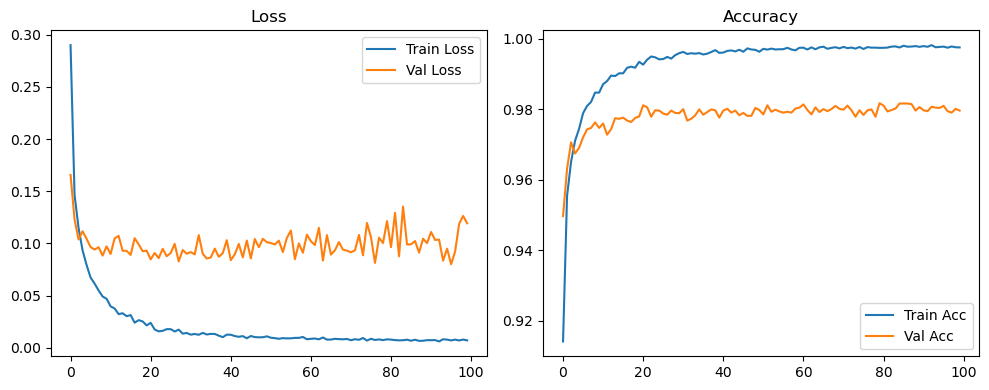

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3698, Acc: 0.8921 | Val Loss: 0.1848, Acc: 0.9433


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2113, Acc: 0.9365 | Val Loss: 0.1235, Acc: 0.9617


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1737, Acc: 0.9471 | Val Loss: 0.1094, Acc: 0.9686


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1521, Acc: 0.9539 | Val Loss: 0.1044, Acc: 0.9683


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1352, Acc: 0.9594 | Val Loss: 0.0918, Acc: 0.9726


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1248, Acc: 0.9626 | Val Loss: 0.1021, Acc: 0.9707


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1196, Acc: 0.9629 | Val Loss: 0.0895, Acc: 0.9753


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1049, Acc: 0.9674 | Val Loss: 0.0944, Acc: 0.9732


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1001, Acc: 0.9695 | Val Loss: 0.0834, Acc: 0.9766


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0947, Acc: 0.9712 | Val Loss: 0.0839, Acc: 0.9752


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0830, Acc: 0.9738 | Val Loss: 0.0835, Acc: 0.9772


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0813, Acc: 0.9745 | Val Loss: 0.0831, Acc: 0.9775


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0760, Acc: 0.9752 | Val Loss: 0.0899, Acc: 0.9747


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9774 | Val Loss: 0.0805, Acc: 0.9778


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9785 | Val Loss: 0.0848, Acc: 0.9772


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0674, Acc: 0.9789 | Val Loss: 0.0780, Acc: 0.9792


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0643, Acc: 0.9799 | Val Loss: 0.0796, Acc: 0.9780


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0599, Acc: 0.9814 | Val Loss: 0.0788, Acc: 0.9782


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9813 | Val Loss: 0.0808, Acc: 0.9796


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9821 | Val Loss: 0.0775, Acc: 0.9787


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9831 | Val Loss: 0.0833, Acc: 0.9785


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9838 | Val Loss: 0.0816, Acc: 0.9796


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9854 | Val Loss: 0.0793, Acc: 0.9796


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9852 | Val Loss: 0.0778, Acc: 0.9812


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9850 | Val Loss: 0.0750, Acc: 0.9797


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9847 | Val Loss: 0.0826, Acc: 0.9792


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9860 | Val Loss: 0.0837, Acc: 0.9791


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9864 | Val Loss: 0.0778, Acc: 0.9815


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9869 | Val Loss: 0.0753, Acc: 0.9805


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9887 | Val Loss: 0.0756, Acc: 0.9805


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9880 | Val Loss: 0.0783, Acc: 0.9814


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9887 | Val Loss: 0.0815, Acc: 0.9806


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9881 | Val Loss: 0.0741, Acc: 0.9817


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9881 | Val Loss: 0.0833, Acc: 0.9792


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9885 | Val Loss: 0.0709, Acc: 0.9811


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9888 | Val Loss: 0.0814, Acc: 0.9798


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9894 | Val Loss: 0.0801, Acc: 0.9799


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9888 | Val Loss: 0.0679, Acc: 0.9802


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9883 | Val Loss: 0.0672, Acc: 0.9815


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 0.0747, Acc: 0.9814


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9893 | Val Loss: 0.0730, Acc: 0.9798


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9898 | Val Loss: 0.0820, Acc: 0.9813


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 0.0802, Acc: 0.9818


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9899 | Val Loss: 0.0844, Acc: 0.9802


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9910 | Val Loss: 0.0883, Acc: 0.9805


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9894 | Val Loss: 0.0811, Acc: 0.9813


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.0857, Acc: 0.9798


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.0796, Acc: 0.9806


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9903 | Val Loss: 0.0833, Acc: 0.9798


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.0760, Acc: 0.9815


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9904 | Val Loss: 0.0717, Acc: 0.9820


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.0696, Acc: 0.9794


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.0784, Acc: 0.9810


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9902 | Val Loss: 0.0775, Acc: 0.9823


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.0774, Acc: 0.9803


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9901 | Val Loss: 0.0722, Acc: 0.9817


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9913 | Val Loss: 0.0777, Acc: 0.9804


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.0704, Acc: 0.9818


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9914 | Val Loss: 0.0668, Acc: 0.9812


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.0738, Acc: 0.9812


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9905 | Val Loss: 0.0723, Acc: 0.9811


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9910 | Val Loss: 0.0771, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9906 | Val Loss: 0.0865, Acc: 0.9795


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.0725, Acc: 0.9804


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9917 | Val Loss: 0.0856, Acc: 0.9815


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9903 | Val Loss: 0.0762, Acc: 0.9804


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.0719, Acc: 0.9807


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.0782, Acc: 0.9812


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9920 | Val Loss: 0.0932, Acc: 0.9809


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9906 | Val Loss: 0.0785, Acc: 0.9802


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9915 | Val Loss: 0.0743, Acc: 0.9812


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.0893, Acc: 0.9794


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9908 | Val Loss: 0.0766, Acc: 0.9809


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.0712, Acc: 0.9812


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.0854, Acc: 0.9811


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9913 | Val Loss: 0.0936, Acc: 0.9815


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.0733, Acc: 0.9801


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.0771, Acc: 0.9800


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9922 | Val Loss: 0.0731, Acc: 0.9812


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9910 | Val Loss: 0.0737, Acc: 0.9813


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.0896, Acc: 0.9803


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9908 | Val Loss: 0.0764, Acc: 0.9813


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9914 | Val Loss: 0.0843, Acc: 0.9817


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9923 | Val Loss: 0.0745, Acc: 0.9804


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9925 | Val Loss: 0.0737, Acc: 0.9808


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9914 | Val Loss: 0.0661, Acc: 0.9811


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.0866, Acc: 0.9802


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.0905, Acc: 0.9809


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9920 | Val Loss: 0.0820, Acc: 0.9814


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9924 | Val Loss: 0.0780, Acc: 0.9810


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.0880, Acc: 0.9808


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9908 | Val Loss: 0.0832, Acc: 0.9807


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9920 | Val Loss: 0.0827, Acc: 0.9798


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0923, Acc: 0.9800


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9922 | Val Loss: 0.0806, Acc: 0.9808


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9917 | Val Loss: 0.0745, Acc: 0.9811


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9922 | Val Loss: 0.0783, Acc: 0.9793


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9918 | Val Loss: 0.0826, Acc: 0.9799


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9919 | Val Loss: 0.0990, Acc: 0.9817


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.0898, Acc: 0.9807


Final Test Loss: 0.0752 Accuracy: 0.9830


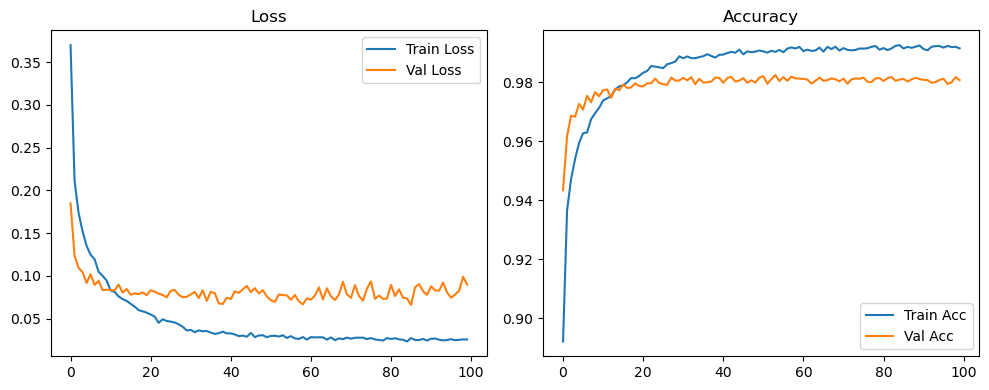

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2704, Acc: 0.9196 | Val Loss: 0.1563, Acc: 0.9520


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1308, Acc: 0.9589 | Val Loss: 0.1211, Acc: 0.9630


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0939, Acc: 0.9713 | Val Loss: 0.1079, Acc: 0.9671


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0733, Acc: 0.9768 | Val Loss: 0.1122, Acc: 0.9663


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0620, Acc: 0.9799 | Val Loss: 0.0997, Acc: 0.9713


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9843 | Val Loss: 0.1067, Acc: 0.9716


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9855 | Val Loss: 0.0938, Acc: 0.9736


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9878 | Val Loss: 0.1151, Acc: 0.9701


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9895 | Val Loss: 0.0991, Acc: 0.9750


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9890 | Val Loss: 0.0827, Acc: 0.9783


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1042, Acc: 0.9737


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.1045, Acc: 0.9745


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9933 | Val Loss: 0.0962, Acc: 0.9779


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.1095, Acc: 0.9738


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.1051, Acc: 0.9768


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.1087, Acc: 0.9758


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0926, Acc: 0.9781


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9946 | Val Loss: 0.1028, Acc: 0.9772


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.1088, Acc: 0.9772


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9956 | Val Loss: 0.1020, Acc: 0.9771


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.1020, Acc: 0.9776


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.1068, Acc: 0.9773


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1090, Acc: 0.9781


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1010, Acc: 0.9788


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.1113, Acc: 0.9783


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1196, Acc: 0.9782


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1156, Acc: 0.9773


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.1111, Acc: 0.9768


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1150, Acc: 0.9784


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1071, Acc: 0.9791


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1104, Acc: 0.9794


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.1087, Acc: 0.9778


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1066, Acc: 0.9788


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0989, Acc: 0.9790


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1141, Acc: 0.9758


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1002, Acc: 0.9788


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1215, Acc: 0.9775


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1161, Acc: 0.9792


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1092, Acc: 0.9793


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1093, Acc: 0.9800


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1210, Acc: 0.9783


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1134, Acc: 0.9802


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1312, Acc: 0.9778


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.1149, Acc: 0.9787


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1106, Acc: 0.9801


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1219, Acc: 0.9794


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1174, Acc: 0.9786


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1170, Acc: 0.9787


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1174, Acc: 0.9792


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.1081, Acc: 0.9777


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0999, Acc: 0.9815


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0998, Acc: 0.9829


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1029, Acc: 0.9818


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1136, Acc: 0.9817


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.1134, Acc: 0.9813


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1204, Acc: 0.9809


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1184, Acc: 0.9813


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1272, Acc: 0.9815


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1242, Acc: 0.9813


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1209, Acc: 0.9813


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1160, Acc: 0.9829


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1194, Acc: 0.9822


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1182, Acc: 0.9820


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1288, Acc: 0.9827


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1279, Acc: 0.9818


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1323, Acc: 0.9812


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1238, Acc: 0.9812


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1237, Acc: 0.9819


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1220, Acc: 0.9817


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1250, Acc: 0.9822


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1316, Acc: 0.9808


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1323, Acc: 0.9810


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1306, Acc: 0.9813


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1353, Acc: 0.9812


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9998 | Val Loss: 0.1292, Acc: 0.9811


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1378, Acc: 0.9801


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1429, Acc: 0.9801


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1502, Acc: 0.9800


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1397, Acc: 0.9811


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1406, Acc: 0.9808


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1351, Acc: 0.9820


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1372, Acc: 0.9815


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1380, Acc: 0.9819


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1386, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1365, Acc: 0.9819


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1343, Acc: 0.9817


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1380, Acc: 0.9821


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1378, Acc: 0.9816


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1362, Acc: 0.9827


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1379, Acc: 0.9828


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1403, Acc: 0.9816


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1440, Acc: 0.9821


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1442, Acc: 0.9823


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1453, Acc: 0.9817


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1405, Acc: 0.9822


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1446, Acc: 0.9822


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1463, Acc: 0.9821


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1474, Acc: 0.9824


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1470, Acc: 0.9828


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1473, Acc: 0.9818


Final Test Loss: 0.1323 Accuracy: 0.9830


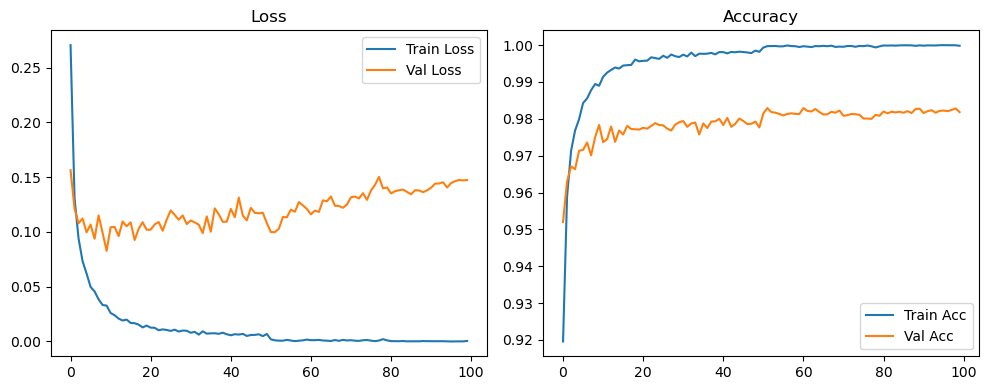

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2900, Acc: 0.9141 | Val Loss: 0.1656, Acc: 0.9497


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1464, Acc: 0.9554 | Val Loss: 0.1228, Acc: 0.9631


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1147, Acc: 0.9651 | Val Loss: 0.1038, Acc: 0.9706


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0933, Acc: 0.9710 | Val Loss: 0.1116, Acc: 0.9674


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0793, Acc: 0.9744 | Val Loss: 0.1044, Acc: 0.9690


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0673, Acc: 0.9789 | Val Loss: 0.0964, Acc: 0.9720


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9809 | Val Loss: 0.0941, Acc: 0.9742


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0549, Acc: 0.9820 | Val Loss: 0.0963, Acc: 0.9747


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9847 | Val Loss: 0.0883, Acc: 0.9762


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9847 | Val Loss: 0.0971, Acc: 0.9747


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9871 | Val Loss: 0.0898, Acc: 0.9759


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9880 | Val Loss: 0.1048, Acc: 0.9728


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.1072, Acc: 0.9743


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9894 | Val Loss: 0.0929, Acc: 0.9774


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9901 | Val Loss: 0.0928, Acc: 0.9772


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.0890, Acc: 0.9776


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9917 | Val Loss: 0.1050, Acc: 0.9768


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9920 | Val Loss: 0.0991, Acc: 0.9763


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.0925, Acc: 0.9775


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9934 | Val Loss: 0.0930, Acc: 0.9779


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9926 | Val Loss: 0.0846, Acc: 0.9811


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.0908, Acc: 0.9805


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0859, Acc: 0.9778


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.0948, Acc: 0.9797


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.0877, Acc: 0.9796


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.0908, Acc: 0.9788


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0995, Acc: 0.9784


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.0827, Acc: 0.9796


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9953 | Val Loss: 0.0936, Acc: 0.9789


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9959 | Val Loss: 0.0901, Acc: 0.9788


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9962 | Val Loss: 0.0917, Acc: 0.9800


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0894, Acc: 0.9768


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1080, Acc: 0.9772


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9957 | Val Loss: 0.0900, Acc: 0.9782


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0855, Acc: 0.9799


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.0865, Acc: 0.9784


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0950, Acc: 0.9792


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0871, Acc: 0.9799


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0907, Acc: 0.9797


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1030, Acc: 0.9776


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0839, Acc: 0.9796


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0895, Acc: 0.9801


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0995, Acc: 0.9790


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0866, Acc: 0.9796


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.1027, Acc: 0.9782


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0856, Acc: 0.9789


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9972 | Val Loss: 0.1042, Acc: 0.9781


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0963, Acc: 0.9781


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1044, Acc: 0.9803


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1011, Acc: 0.9798


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1071, Acc: 0.9802


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1074, Acc: 0.9808


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1073, Acc: 0.9817


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.1021, Acc: 0.9811


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1026, Acc: 0.9808


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1086, Acc: 0.9808


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1128, Acc: 0.9806


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1024, Acc: 0.9798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1044, Acc: 0.9808


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1206, Acc: 0.9804


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1139, Acc: 0.9807


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.1082, Acc: 0.9802


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1101, Acc: 0.9808


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1024, Acc: 0.9820


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1156, Acc: 0.9814


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0951, Acc: 0.9824


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0897, Acc: 0.9826


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1005, Acc: 0.9811


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1230, Acc: 0.9821


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1114, Acc: 0.9808


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1177, Acc: 0.9815


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1094, Acc: 0.9809


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1075, Acc: 0.9821


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0955, Acc: 0.9816


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1118, Acc: 0.9813


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1177, Acc: 0.9804


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0956, Acc: 0.9815


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1125, Acc: 0.9810


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1414, Acc: 0.9798


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1267, Acc: 0.9808


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1269, Acc: 0.9811


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1044, Acc: 0.9812


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1136, Acc: 0.9820


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1212, Acc: 0.9820


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1166, Acc: 0.9817


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.1197, Acc: 0.9821


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1138, Acc: 0.9821


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1086, Acc: 0.9810


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1085, Acc: 0.9830


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1203, Acc: 0.9823


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1204, Acc: 0.9826


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1127, Acc: 0.9822


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1243, Acc: 0.9834


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1214, Acc: 0.9827


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1214, Acc: 0.9822


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1200, Acc: 0.9824


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1150, Acc: 0.9812


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1072, Acc: 0.9814


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1096, Acc: 0.9820


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1155, Acc: 0.9824


Final Test Loss: 0.1124 Accuracy: 0.9841


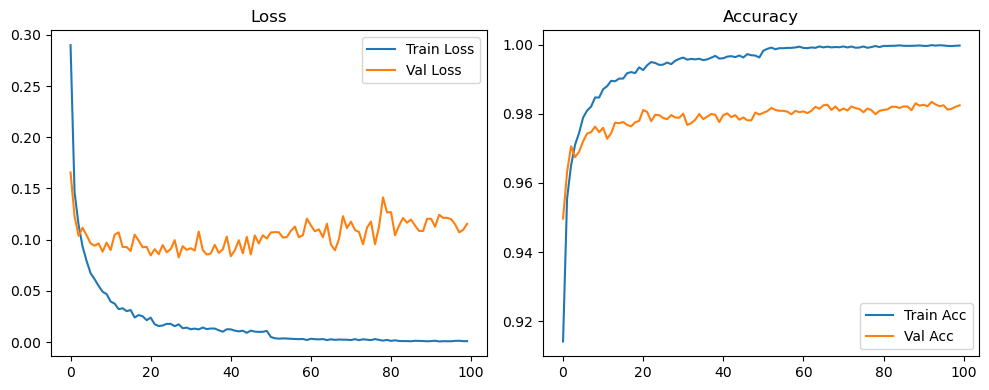

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3698, Acc: 0.8921 | Val Loss: 0.1848, Acc: 0.9433


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2113, Acc: 0.9365 | Val Loss: 0.1235, Acc: 0.9617


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1737, Acc: 0.9471 | Val Loss: 0.1094, Acc: 0.9686


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1521, Acc: 0.9539 | Val Loss: 0.1044, Acc: 0.9683


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1352, Acc: 0.9594 | Val Loss: 0.0918, Acc: 0.9726


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1248, Acc: 0.9626 | Val Loss: 0.1021, Acc: 0.9707


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1196, Acc: 0.9629 | Val Loss: 0.0895, Acc: 0.9753


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1049, Acc: 0.9674 | Val Loss: 0.0944, Acc: 0.9732


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1001, Acc: 0.9695 | Val Loss: 0.0834, Acc: 0.9766


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0947, Acc: 0.9712 | Val Loss: 0.0839, Acc: 0.9752


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0830, Acc: 0.9738 | Val Loss: 0.0835, Acc: 0.9772


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0813, Acc: 0.9745 | Val Loss: 0.0831, Acc: 0.9775


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0760, Acc: 0.9752 | Val Loss: 0.0899, Acc: 0.9747


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9774 | Val Loss: 0.0805, Acc: 0.9778


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9785 | Val Loss: 0.0848, Acc: 0.9772


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0674, Acc: 0.9789 | Val Loss: 0.0780, Acc: 0.9792


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0643, Acc: 0.9799 | Val Loss: 0.0796, Acc: 0.9780


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0599, Acc: 0.9814 | Val Loss: 0.0788, Acc: 0.9782


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9813 | Val Loss: 0.0808, Acc: 0.9796


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9821 | Val Loss: 0.0775, Acc: 0.9787


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9831 | Val Loss: 0.0833, Acc: 0.9785


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9838 | Val Loss: 0.0816, Acc: 0.9796


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9854 | Val Loss: 0.0793, Acc: 0.9796


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9852 | Val Loss: 0.0778, Acc: 0.9812


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9850 | Val Loss: 0.0750, Acc: 0.9797


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9847 | Val Loss: 0.0826, Acc: 0.9792


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9860 | Val Loss: 0.0837, Acc: 0.9791


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9864 | Val Loss: 0.0778, Acc: 0.9815


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9869 | Val Loss: 0.0753, Acc: 0.9805


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9887 | Val Loss: 0.0756, Acc: 0.9805


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9880 | Val Loss: 0.0783, Acc: 0.9814


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9887 | Val Loss: 0.0815, Acc: 0.9806


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9881 | Val Loss: 0.0741, Acc: 0.9817


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9881 | Val Loss: 0.0833, Acc: 0.9792


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9885 | Val Loss: 0.0709, Acc: 0.9811


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9888 | Val Loss: 0.0814, Acc: 0.9798


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9894 | Val Loss: 0.0801, Acc: 0.9799


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9888 | Val Loss: 0.0679, Acc: 0.9802


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9883 | Val Loss: 0.0672, Acc: 0.9815


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 0.0747, Acc: 0.9814


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9893 | Val Loss: 0.0730, Acc: 0.9798


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9898 | Val Loss: 0.0820, Acc: 0.9813


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 0.0802, Acc: 0.9818


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9899 | Val Loss: 0.0844, Acc: 0.9802


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9910 | Val Loss: 0.0883, Acc: 0.9805


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9894 | Val Loss: 0.0811, Acc: 0.9813


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.0857, Acc: 0.9798


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.0796, Acc: 0.9806


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9903 | Val Loss: 0.0833, Acc: 0.9798


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.0760, Acc: 0.9815


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.0716, Acc: 0.9828


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0795, Acc: 0.9830


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0831, Acc: 0.9822


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.0897, Acc: 0.9820


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.0762, Acc: 0.9830


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0881, Acc: 0.9823


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.0808, Acc: 0.9832


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0812, Acc: 0.9837


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0743, Acc: 0.9834


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0887, Acc: 0.9829


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.0747, Acc: 0.9829


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0844, Acc: 0.9825


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0893, Acc: 0.9823


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0827, Acc: 0.9821


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0830, Acc: 0.9834


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0751, Acc: 0.9830


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.0809, Acc: 0.9834


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.0818, Acc: 0.9844


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0785, Acc: 0.9828


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9961 | Val Loss: 0.0658, Acc: 0.9835


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.0742, Acc: 0.9832


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0842, Acc: 0.9821


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.0796, Acc: 0.9830


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0901, Acc: 0.9826


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0813, Acc: 0.9829


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0696, Acc: 0.9835


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.0732, Acc: 0.9825


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.0916, Acc: 0.9831


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0904, Acc: 0.9836


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0805, Acc: 0.9834


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0849, Acc: 0.9836


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0742, Acc: 0.9832


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0883, Acc: 0.9837


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.0826, Acc: 0.9837


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0861, Acc: 0.9832


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0827, Acc: 0.9833


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0885, Acc: 0.9838


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.0808, Acc: 0.9832


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0900, Acc: 0.9840


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0876, Acc: 0.9835


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0866, Acc: 0.9838


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0877, Acc: 0.9836


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0865, Acc: 0.9842


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0832, Acc: 0.9842


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0822, Acc: 0.9840


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0845, Acc: 0.9839


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0812, Acc: 0.9835


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0903, Acc: 0.9828


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0892, Acc: 0.9828


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0882, Acc: 0.9838


Final Test Loss: 0.0820 Accuracy: 0.9846


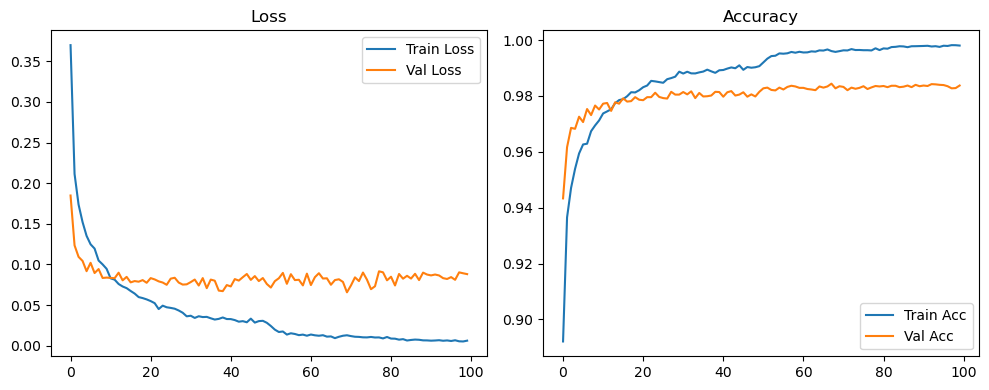

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2428, Acc: 0.9260 | Val Loss: 0.1569, Acc: 0.9522


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1216, Acc: 0.9624 | Val Loss: 0.1296, Acc: 0.9620


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0898, Acc: 0.9727 | Val Loss: 0.0921, Acc: 0.9723


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0671, Acc: 0.9791 | Val Loss: 0.1040, Acc: 0.9702


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0577, Acc: 0.9817 | Val Loss: 0.0980, Acc: 0.9718


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9856 | Val Loss: 0.1018, Acc: 0.9723


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9867 | Val Loss: 0.0905, Acc: 0.9762


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9885 | Val Loss: 0.0909, Acc: 0.9753


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9902 | Val Loss: 0.0902, Acc: 0.9778


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9911 | Val Loss: 0.0932, Acc: 0.9744


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1102, Acc: 0.9760


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9929 | Val Loss: 0.0962, Acc: 0.9760


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0942, Acc: 0.9777


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.0965, Acc: 0.9778


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.0941, Acc: 0.9795


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.1014, Acc: 0.9788


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9939 | Val Loss: 0.0936, Acc: 0.9792


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.0952, Acc: 0.9782


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1177, Acc: 0.9757


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.1018, Acc: 0.9795


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1151, Acc: 0.9768


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0987, Acc: 0.9792


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1022, Acc: 0.9788


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1016, Acc: 0.9794


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1087, Acc: 0.9793


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1025, Acc: 0.9806


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1045, Acc: 0.9793


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1206, Acc: 0.9789


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1176, Acc: 0.9782


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1025, Acc: 0.9811


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.1111, Acc: 0.9791


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9975 | Val Loss: 0.1050, Acc: 0.9794


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1006, Acc: 0.9808


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1153, Acc: 0.9786


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1036, Acc: 0.9812


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1118, Acc: 0.9784


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1115, Acc: 0.9818


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1073, Acc: 0.9798


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1062, Acc: 0.9812


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9975 | Val Loss: 0.1069, Acc: 0.9790


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1091, Acc: 0.9795


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1102, Acc: 0.9804


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1147, Acc: 0.9801


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1069, Acc: 0.9815


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1135, Acc: 0.9811


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1088, Acc: 0.9803


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1182, Acc: 0.9803


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1305, Acc: 0.9794


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1197, Acc: 0.9796


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.1122, Acc: 0.9804


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1057, Acc: 0.9808


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1089, Acc: 0.9805


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1104, Acc: 0.9804


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1207, Acc: 0.9801


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1157, Acc: 0.9812


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1063, Acc: 0.9812


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1187, Acc: 0.9811


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1328, Acc: 0.9784


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1097, Acc: 0.9808


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1187, Acc: 0.9808


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.1278, Acc: 0.9790


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1266, Acc: 0.9792


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1173, Acc: 0.9798


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1116, Acc: 0.9811


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1225, Acc: 0.9806


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1349, Acc: 0.9787


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1327, Acc: 0.9798


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.1246, Acc: 0.9803


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.1366, Acc: 0.9798


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1232, Acc: 0.9808


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1228, Acc: 0.9800


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1179, Acc: 0.9812


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.1184, Acc: 0.9810


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1246, Acc: 0.9788


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1187, Acc: 0.9821


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1270, Acc: 0.9810


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1161, Acc: 0.9816


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1112, Acc: 0.9823


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1219, Acc: 0.9807


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1266, Acc: 0.9788


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1191, Acc: 0.9820


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1252, Acc: 0.9810


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1201, Acc: 0.9808


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1152, Acc: 0.9830


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1314, Acc: 0.9810


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.1244, Acc: 0.9822


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1287, Acc: 0.9812


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1248, Acc: 0.9822


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1231, Acc: 0.9815


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1303, Acc: 0.9824


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1189, Acc: 0.9818


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1303, Acc: 0.9809


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1373, Acc: 0.9810


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1588, Acc: 0.9788


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1416, Acc: 0.9799


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1430, Acc: 0.9802


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1371, Acc: 0.9799


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1305, Acc: 0.9814


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1226, Acc: 0.9802


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1255, Acc: 0.9813


Final Test Loss: 0.1115 Accuracy: 0.9828


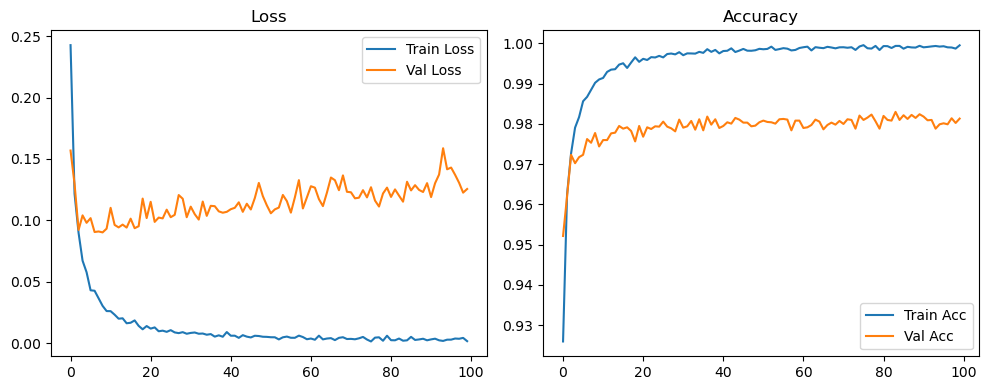

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2621, Acc: 0.9196 | Val Loss: 0.1570, Acc: 0.9527


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1383, Acc: 0.9571 | Val Loss: 0.1158, Acc: 0.9647


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1092, Acc: 0.9659 | Val Loss: 0.0996, Acc: 0.9694


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0828, Acc: 0.9739 | Val Loss: 0.1019, Acc: 0.9698


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0742, Acc: 0.9763 | Val Loss: 0.1029, Acc: 0.9708


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0650, Acc: 0.9794 | Val Loss: 0.0889, Acc: 0.9755


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0528, Acc: 0.9822 | Val Loss: 0.0930, Acc: 0.9747


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9840 | Val Loss: 0.0974, Acc: 0.9745


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0448, Acc: 0.9857 | Val Loss: 0.0933, Acc: 0.9752


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9868 | Val Loss: 0.0918, Acc: 0.9756


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9882 | Val Loss: 0.1198, Acc: 0.9722


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9891 | Val Loss: 0.0972, Acc: 0.9768


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.0966, Acc: 0.9766


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9907 | Val Loss: 0.0994, Acc: 0.9755


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9917 | Val Loss: 0.0962, Acc: 0.9775


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9918 | Val Loss: 0.0862, Acc: 0.9787


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9922 | Val Loss: 0.0970, Acc: 0.9773


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.1037, Acc: 0.9768


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9936 | Val Loss: 0.0948, Acc: 0.9791


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9927 | Val Loss: 0.0898, Acc: 0.9800


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.0921, Acc: 0.9795


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0973, Acc: 0.9811


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0995, Acc: 0.9785


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.0943, Acc: 0.9801


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.1041, Acc: 0.9798


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.0891, Acc: 0.9824


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9957 | Val Loss: 0.0995, Acc: 0.9795


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1032, Acc: 0.9777


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.1024, Acc: 0.9792


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.1032, Acc: 0.9795


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.1092, Acc: 0.9782


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1050, Acc: 0.9791


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1104, Acc: 0.9793


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1033, Acc: 0.9798


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9960 | Val Loss: 0.1072, Acc: 0.9791


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.1024, Acc: 0.9780


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1061, Acc: 0.9804


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.0935, Acc: 0.9808


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9977 | Val Loss: 0.1031, Acc: 0.9797


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.1203, Acc: 0.9768


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1074, Acc: 0.9802


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9970 | Val Loss: 0.0971, Acc: 0.9820


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.1077, Acc: 0.9810


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9968 | Val Loss: 0.1104, Acc: 0.9805


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1046, Acc: 0.9812


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1104, Acc: 0.9801


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1135, Acc: 0.9793


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1057, Acc: 0.9802


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1160, Acc: 0.9768


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1214, Acc: 0.9789


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1156, Acc: 0.9811


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1247, Acc: 0.9795


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1240, Acc: 0.9788


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1109, Acc: 0.9812


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1185, Acc: 0.9805


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1031, Acc: 0.9809


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1111, Acc: 0.9813


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1099, Acc: 0.9818


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1135, Acc: 0.9812


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1205, Acc: 0.9800


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1180, Acc: 0.9808


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1183, Acc: 0.9803


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1162, Acc: 0.9812


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1209, Acc: 0.9812


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1236, Acc: 0.9811


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1434, Acc: 0.9801


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1195, Acc: 0.9817


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1157, Acc: 0.9794


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1104, Acc: 0.9822


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1242, Acc: 0.9804


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1260, Acc: 0.9808


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1201, Acc: 0.9812


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1258, Acc: 0.9816


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1146, Acc: 0.9815


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1206, Acc: 0.9818


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1244, Acc: 0.9807


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1097, Acc: 0.9822


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1304, Acc: 0.9800


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1223, Acc: 0.9808


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1285, Acc: 0.9808


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1183, Acc: 0.9807


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1212, Acc: 0.9812


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1218, Acc: 0.9805


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1191, Acc: 0.9805


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9986 | Val Loss: 0.1171, Acc: 0.9815


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1289, Acc: 0.9816


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1343, Acc: 0.9802


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1216, Acc: 0.9812


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1254, Acc: 0.9816


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1290, Acc: 0.9813


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1398, Acc: 0.9798


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1205, Acc: 0.9818


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1178, Acc: 0.9818


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1230, Acc: 0.9822


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.1071, Acc: 0.9828


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1255, Acc: 0.9810


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1282, Acc: 0.9808


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1306, Acc: 0.9812


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1241, Acc: 0.9825


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1328, Acc: 0.9813


Final Test Loss: 0.1190 Accuracy: 0.9826


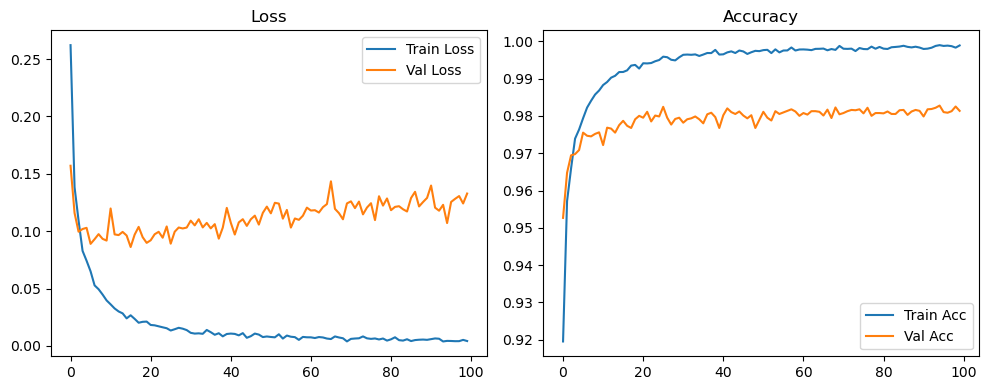

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3334, Acc: 0.8975 | Val Loss: 0.1529, Acc: 0.9529


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1990, Acc: 0.9397 | Val Loss: 0.1236, Acc: 0.9613


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1637, Acc: 0.9511 | Val Loss: 0.1065, Acc: 0.9673


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1403, Acc: 0.9572 | Val Loss: 0.1168, Acc: 0.9664


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1241, Acc: 0.9616 | Val Loss: 0.0938, Acc: 0.9718


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1149, Acc: 0.9642 | Val Loss: 0.0868, Acc: 0.9749


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1020, Acc: 0.9675 | Val Loss: 0.0892, Acc: 0.9752


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0963, Acc: 0.9695 | Val Loss: 0.0876, Acc: 0.9739


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0859, Acc: 0.9725 | Val Loss: 0.0790, Acc: 0.9778


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0816, Acc: 0.9744 | Val Loss: 0.0815, Acc: 0.9756


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0738, Acc: 0.9769 | Val Loss: 0.0860, Acc: 0.9759


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0711, Acc: 0.9772 | Val Loss: 0.0802, Acc: 0.9764


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0687, Acc: 0.9786 | Val Loss: 0.0793, Acc: 0.9769


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0643, Acc: 0.9799 | Val Loss: 0.0779, Acc: 0.9780


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0621, Acc: 0.9797 | Val Loss: 0.0761, Acc: 0.9788


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0570, Acc: 0.9812 | Val Loss: 0.0756, Acc: 0.9797


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0527, Acc: 0.9827 | Val Loss: 0.0834, Acc: 0.9784


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0543, Acc: 0.9830 | Val Loss: 0.0758, Acc: 0.9799


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0458, Acc: 0.9848 | Val Loss: 0.0794, Acc: 0.9797


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0467, Acc: 0.9849 | Val Loss: 0.0793, Acc: 0.9782


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9849 | Val Loss: 0.0819, Acc: 0.9788


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9856 | Val Loss: 0.0793, Acc: 0.9795


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9874 | Val Loss: 0.0812, Acc: 0.9800


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9867 | Val Loss: 0.0812, Acc: 0.9810


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9876 | Val Loss: 0.0779, Acc: 0.9810


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9885 | Val Loss: 0.0814, Acc: 0.9797


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9885 | Val Loss: 0.0837, Acc: 0.9802


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.0829, Acc: 0.9805


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9891 | Val Loss: 0.0844, Acc: 0.9808


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9877 | Val Loss: 0.0814, Acc: 0.9810


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9896 | Val Loss: 0.0846, Acc: 0.9796


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 0.0785, Acc: 0.9818


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9902 | Val Loss: 0.0846, Acc: 0.9804


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9895 | Val Loss: 0.0840, Acc: 0.9807


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9915 | Val Loss: 0.0829, Acc: 0.9810


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9905 | Val Loss: 0.0862, Acc: 0.9782


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9910 | Val Loss: 0.0883, Acc: 0.9790


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9912 | Val Loss: 0.0831, Acc: 0.9792


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0841, Acc: 0.9801


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.0797, Acc: 0.9815


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9913 | Val Loss: 0.0844, Acc: 0.9810


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.0855, Acc: 0.9800


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9921 | Val Loss: 0.0884, Acc: 0.9798


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9923 | Val Loss: 0.0937, Acc: 0.9807


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9910 | Val Loss: 0.0892, Acc: 0.9800


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9920 | Val Loss: 0.0882, Acc: 0.9814


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9924 | Val Loss: 0.0920, Acc: 0.9810


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9924 | Val Loss: 0.0864, Acc: 0.9814


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9926 | Val Loss: 0.0912, Acc: 0.9803


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.0948, Acc: 0.9810


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.0920, Acc: 0.9805


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.0889, Acc: 0.9818


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9930 | Val Loss: 0.0889, Acc: 0.9816


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9929 | Val Loss: 0.0877, Acc: 0.9827


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9935 | Val Loss: 0.0885, Acc: 0.9817


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.0875, Acc: 0.9808


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9933 | Val Loss: 0.0806, Acc: 0.9819


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.0826, Acc: 0.9827


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0915, Acc: 0.9815


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9937 | Val Loss: 0.0853, Acc: 0.9814


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9932 | Val Loss: 0.0816, Acc: 0.9822


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.0871, Acc: 0.9818


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0840, Acc: 0.9821


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9942 | Val Loss: 0.0912, Acc: 0.9813


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0922, Acc: 0.9817


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9949 | Val Loss: 0.0994, Acc: 0.9804


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.0955, Acc: 0.9817


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9936 | Val Loss: 0.0906, Acc: 0.9814


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9933 | Val Loss: 0.0916, Acc: 0.9806


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0930, Acc: 0.9808


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.0993, Acc: 0.9819


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9940 | Val Loss: 0.0983, Acc: 0.9814


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9947 | Val Loss: 0.0973, Acc: 0.9802


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.1026, Acc: 0.9807


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.1020, Acc: 0.9812


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.0948, Acc: 0.9803


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9947 | Val Loss: 0.0931, Acc: 0.9815


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.0915, Acc: 0.9827


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.0894, Acc: 0.9812


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.0943, Acc: 0.9818


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0927, Acc: 0.9821


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9947 | Val Loss: 0.0930, Acc: 0.9822


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0934, Acc: 0.9822


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9956 | Val Loss: 0.0993, Acc: 0.9819


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9949 | Val Loss: 0.0968, Acc: 0.9818


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9949 | Val Loss: 0.0968, Acc: 0.9795


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1018, Acc: 0.9812


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9955 | Val Loss: 0.1021, Acc: 0.9806


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9950 | Val Loss: 0.1046, Acc: 0.9812


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.1068, Acc: 0.9814


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.1002, Acc: 0.9822


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9952 | Val Loss: 0.1023, Acc: 0.9811


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9953 | Val Loss: 0.1003, Acc: 0.9814


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9953 | Val Loss: 0.0987, Acc: 0.9822


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9953 | Val Loss: 0.1019, Acc: 0.9818


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9953 | Val Loss: 0.0998, Acc: 0.9832


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9952 | Val Loss: 0.0983, Acc: 0.9805


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.0978, Acc: 0.9820


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.1045, Acc: 0.9811


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9964 | Val Loss: 0.1048, Acc: 0.9812


Final Test Loss: 0.0884 Accuracy: 0.9834


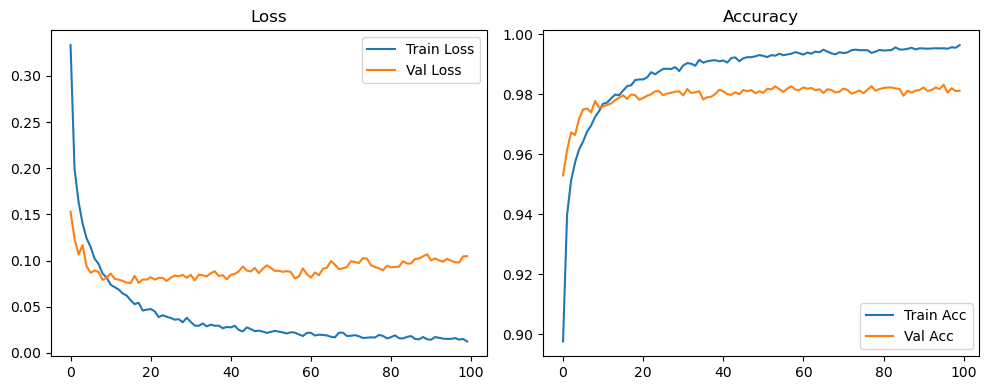

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2213, Acc: 0.9315 | Val Loss: 0.1382, Acc: 0.9589


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1079, Acc: 0.9665 | Val Loss: 0.1088, Acc: 0.9657


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0788, Acc: 0.9749 | Val Loss: 0.0937, Acc: 0.9721


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0591, Acc: 0.9812 | Val Loss: 0.1055, Acc: 0.9703


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0509, Acc: 0.9830 | Val Loss: 0.0978, Acc: 0.9733


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0399, Acc: 0.9868 | Val Loss: 0.0945, Acc: 0.9729


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9878 | Val Loss: 0.1091, Acc: 0.9737


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9889 | Val Loss: 0.1030, Acc: 0.9738


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.0914, Acc: 0.9770


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.1017, Acc: 0.9766


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9920 | Val Loss: 0.1032, Acc: 0.9744


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9928 | Val Loss: 0.0928, Acc: 0.9768


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9937 | Val Loss: 0.1141, Acc: 0.9740


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.0972, Acc: 0.9782


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.1061, Acc: 0.9761


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0984, Acc: 0.9772


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.1234, Acc: 0.9743


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9957 | Val Loss: 0.1054, Acc: 0.9777


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1181, Acc: 0.9768


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.1209, Acc: 0.9764


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9956 | Val Loss: 0.0990, Acc: 0.9799


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.0993, Acc: 0.9795


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1281, Acc: 0.9750


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1104, Acc: 0.9796


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1181, Acc: 0.9778


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1223, Acc: 0.9772


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1204, Acc: 0.9778


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.1037, Acc: 0.9792


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0961, Acc: 0.9801


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1136, Acc: 0.9794


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1239, Acc: 0.9782


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1120, Acc: 0.9781


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0989, Acc: 0.9808


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1010, Acc: 0.9812


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1074, Acc: 0.9801


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1036, Acc: 0.9800


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1176, Acc: 0.9788


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.0942, Acc: 0.9808


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1157, Acc: 0.9802


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.1220, Acc: 0.9788


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1362, Acc: 0.9765


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1162, Acc: 0.9808


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1371, Acc: 0.9778


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9984 | Val Loss: 0.1263, Acc: 0.9786


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1140, Acc: 0.9811


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1131, Acc: 0.9798


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1176, Acc: 0.9793


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1128, Acc: 0.9816


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1093, Acc: 0.9810


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1267, Acc: 0.9794


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1226, Acc: 0.9782


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1211, Acc: 0.9789


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1177, Acc: 0.9807


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1129, Acc: 0.9797


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1095, Acc: 0.9808


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1216, Acc: 0.9796


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1253, Acc: 0.9791


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1122, Acc: 0.9807


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1099, Acc: 0.9818


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1231, Acc: 0.9808


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1287, Acc: 0.9790


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1248, Acc: 0.9803


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1221, Acc: 0.9789


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1300, Acc: 0.9810


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1262, Acc: 0.9807


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1277, Acc: 0.9809


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1456, Acc: 0.9796


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1268, Acc: 0.9814


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1340, Acc: 0.9793


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9993 | Val Loss: 0.1218, Acc: 0.9821


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1257, Acc: 0.9815


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1181, Acc: 0.9804


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.1146, Acc: 0.9808


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1143, Acc: 0.9818


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1261, Acc: 0.9802


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1205, Acc: 0.9807


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1192, Acc: 0.9815


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1307, Acc: 0.9806


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1289, Acc: 0.9794


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1284, Acc: 0.9797


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9987 | Val Loss: 0.1261, Acc: 0.9798


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1291, Acc: 0.9808


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1157, Acc: 0.9827


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1209, Acc: 0.9817


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1230, Acc: 0.9810


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1280, Acc: 0.9814


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1271, Acc: 0.9818


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1159, Acc: 0.9822


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1282, Acc: 0.9810


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1290, Acc: 0.9818


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1186, Acc: 0.9802


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1371, Acc: 0.9799


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1289, Acc: 0.9810


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1320, Acc: 0.9810


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1366, Acc: 0.9803


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1275, Acc: 0.9806


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1271, Acc: 0.9800


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1436, Acc: 0.9805


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1437, Acc: 0.9795


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1387, Acc: 0.9803


Final Test Loss: 0.1212 Accuracy: 0.9820


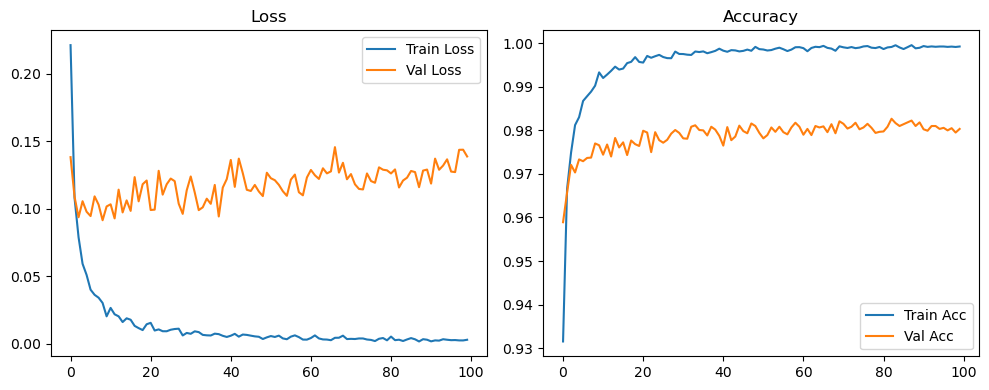

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2429, Acc: 0.9252 | Val Loss: 0.1436, Acc: 0.9562


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1265, Acc: 0.9602 | Val Loss: 0.1092, Acc: 0.9656


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0977, Acc: 0.9690 | Val Loss: 0.1001, Acc: 0.9701


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0771, Acc: 0.9749 | Val Loss: 0.1023, Acc: 0.9695


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0666, Acc: 0.9784 | Val Loss: 0.0931, Acc: 0.9732


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0577, Acc: 0.9814 | Val Loss: 0.0895, Acc: 0.9754


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0492, Acc: 0.9842 | Val Loss: 0.0916, Acc: 0.9731


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0443, Acc: 0.9848 | Val Loss: 0.1004, Acc: 0.9748


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9870 | Val Loss: 0.0921, Acc: 0.9791


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9871 | Val Loss: 0.0915, Acc: 0.9759


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9895 | Val Loss: 0.0953, Acc: 0.9772


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.0969, Acc: 0.9763


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9903 | Val Loss: 0.1146, Acc: 0.9735


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9906 | Val Loss: 0.0983, Acc: 0.9768


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.0991, Acc: 0.9769


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9929 | Val Loss: 0.0988, Acc: 0.9770


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.1019, Acc: 0.9762


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.0973, Acc: 0.9774


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.0929, Acc: 0.9788


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.0913, Acc: 0.9796


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9945 | Val Loss: 0.0999, Acc: 0.9788


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9940 | Val Loss: 0.0912, Acc: 0.9803


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9950 | Val Loss: 0.0914, Acc: 0.9801


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.1023, Acc: 0.9793


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.1042, Acc: 0.9768


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.0919, Acc: 0.9807


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.1044, Acc: 0.9808


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.1146, Acc: 0.9790


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1014, Acc: 0.9798


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1009, Acc: 0.9793


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1067, Acc: 0.9795


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1072, Acc: 0.9789


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1049, Acc: 0.9802


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1118, Acc: 0.9798


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1046, Acc: 0.9798


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1023, Acc: 0.9805


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1072, Acc: 0.9796


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.0994, Acc: 0.9798


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.1113, Acc: 0.9792


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1091, Acc: 0.9792


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9974 | Val Loss: 0.1085, Acc: 0.9802


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1003, Acc: 0.9812


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1100, Acc: 0.9794


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9969 | Val Loss: 0.1175, Acc: 0.9792


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1027, Acc: 0.9807


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9974 | Val Loss: 0.1069, Acc: 0.9808


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1122, Acc: 0.9814


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1287, Acc: 0.9782


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1309, Acc: 0.9788


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1325, Acc: 0.9781


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1226, Acc: 0.9792


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1221, Acc: 0.9788


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1209, Acc: 0.9792


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1306, Acc: 0.9799


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1304, Acc: 0.9790


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1191, Acc: 0.9812


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1229, Acc: 0.9798


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1123, Acc: 0.9818


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1220, Acc: 0.9800


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1289, Acc: 0.9793


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.1325, Acc: 0.9798


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1256, Acc: 0.9780


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1153, Acc: 0.9821


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1191, Acc: 0.9797


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1119, Acc: 0.9819


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1144, Acc: 0.9818


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1190, Acc: 0.9804


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1128, Acc: 0.9807


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1138, Acc: 0.9810


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1178, Acc: 0.9808


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1140, Acc: 0.9809


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1127, Acc: 0.9826


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9977 | Val Loss: 0.1106, Acc: 0.9822


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1323, Acc: 0.9795


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1339, Acc: 0.9795


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1333, Acc: 0.9791


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1286, Acc: 0.9814


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1269, Acc: 0.9805


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1342, Acc: 0.9804


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1247, Acc: 0.9818


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1332, Acc: 0.9801


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.1208, Acc: 0.9814


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9980 | Val Loss: 0.1189, Acc: 0.9814


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1295, Acc: 0.9809


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1236, Acc: 0.9812


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1284, Acc: 0.9808


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1207, Acc: 0.9811


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1254, Acc: 0.9807


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.1246, Acc: 0.9806


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1284, Acc: 0.9809


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1270, Acc: 0.9815


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1304, Acc: 0.9815


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1304, Acc: 0.9816


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1195, Acc: 0.9821


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1314, Acc: 0.9801


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1187, Acc: 0.9825


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1174, Acc: 0.9814


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1305, Acc: 0.9808


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1278, Acc: 0.9805


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1247, Acc: 0.9812


Final Test Loss: 0.1170 Accuracy: 0.9812


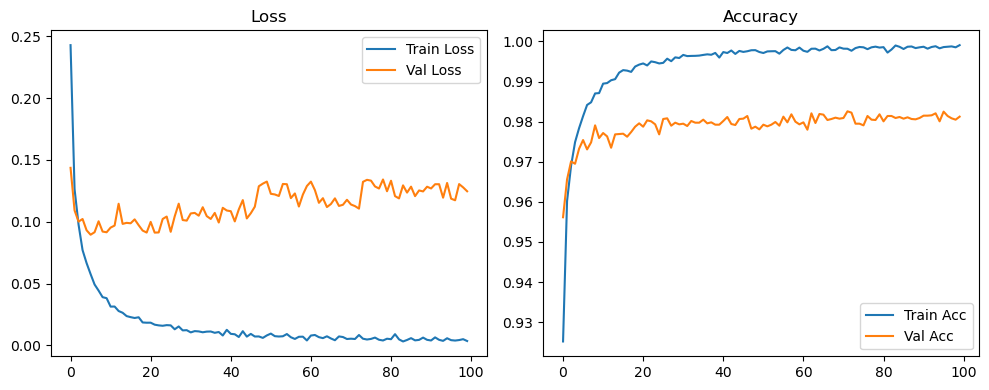

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3219, Acc: 0.9010 | Val Loss: 0.1522, Acc: 0.9527


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1873, Acc: 0.9420 | Val Loss: 0.1159, Acc: 0.9635


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1526, Acc: 0.9525 | Val Loss: 0.1067, Acc: 0.9673


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1301, Acc: 0.9594 | Val Loss: 0.1080, Acc: 0.9672


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1160, Acc: 0.9633 | Val Loss: 0.0875, Acc: 0.9730


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1093, Acc: 0.9651 | Val Loss: 0.0880, Acc: 0.9738


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0987, Acc: 0.9686 | Val Loss: 0.0872, Acc: 0.9742


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0912, Acc: 0.9704 | Val Loss: 0.0890, Acc: 0.9746


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0850, Acc: 0.9725 | Val Loss: 0.0760, Acc: 0.9787


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0769, Acc: 0.9754 | Val Loss: 0.0826, Acc: 0.9770


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0739, Acc: 0.9764 | Val Loss: 0.0835, Acc: 0.9759


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0673, Acc: 0.9782 | Val Loss: 0.0850, Acc: 0.9777


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0635, Acc: 0.9795 | Val Loss: 0.0813, Acc: 0.9777


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0583, Acc: 0.9816 | Val Loss: 0.0812, Acc: 0.9781


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0573, Acc: 0.9813 | Val Loss: 0.0769, Acc: 0.9789


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0525, Acc: 0.9824 | Val Loss: 0.0792, Acc: 0.9782


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0534, Acc: 0.9821 | Val Loss: 0.0800, Acc: 0.9781


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0494, Acc: 0.9842 | Val Loss: 0.0767, Acc: 0.9808


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0469, Acc: 0.9844 | Val Loss: 0.0836, Acc: 0.9787


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0496, Acc: 0.9843 | Val Loss: 0.0758, Acc: 0.9797


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0418, Acc: 0.9866 | Val Loss: 0.0889, Acc: 0.9788


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0405, Acc: 0.9867 | Val Loss: 0.0792, Acc: 0.9793


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0377, Acc: 0.9878 | Val Loss: 0.0822, Acc: 0.9796


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9877 | Val Loss: 0.0823, Acc: 0.9797


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9878 | Val Loss: 0.0752, Acc: 0.9814


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9876 | Val Loss: 0.0803, Acc: 0.9811


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9894 | Val Loss: 0.0894, Acc: 0.9800


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0353, Acc: 0.9885 | Val Loss: 0.0811, Acc: 0.9815


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9895 | Val Loss: 0.0814, Acc: 0.9801


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9898 | Val Loss: 0.0800, Acc: 0.9808


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9900 | Val Loss: 0.0852, Acc: 0.9801


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.0836, Acc: 0.9820


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0808, Acc: 0.9813


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9906 | Val Loss: 0.0861, Acc: 0.9800


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.0874, Acc: 0.9803


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9901 | Val Loss: 0.0869, Acc: 0.9794


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9916 | Val Loss: 0.0868, Acc: 0.9814


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.0817, Acc: 0.9812


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.0810, Acc: 0.9818


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.0822, Acc: 0.9816


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9918 | Val Loss: 0.0828, Acc: 0.9812


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.0839, Acc: 0.9804


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.0886, Acc: 0.9815


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0879, Acc: 0.9817


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.0866, Acc: 0.9814


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.0839, Acc: 0.9816


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.0872, Acc: 0.9807


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.0862, Acc: 0.9811


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9938 | Val Loss: 0.0895, Acc: 0.9817


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9938 | Val Loss: 0.0890, Acc: 0.9821


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9928 | Val Loss: 0.0896, Acc: 0.9814


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0889, Acc: 0.9811


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.0945, Acc: 0.9814


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.0976, Acc: 0.9805


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.0868, Acc: 0.9818


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.0903, Acc: 0.9819


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0916, Acc: 0.9812


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9943 | Val Loss: 0.0906, Acc: 0.9813


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.0954, Acc: 0.9812


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9945 | Val Loss: 0.0878, Acc: 0.9815


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.0952, Acc: 0.9814


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.0905, Acc: 0.9819


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.0883, Acc: 0.9807


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9946 | Val Loss: 0.0901, Acc: 0.9809


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.0836, Acc: 0.9826


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.0936, Acc: 0.9818


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0975, Acc: 0.9807


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9947 | Val Loss: 0.0908, Acc: 0.9812


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.0992, Acc: 0.9797


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0881, Acc: 0.9812


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0913, Acc: 0.9825


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9940 | Val Loss: 0.0957, Acc: 0.9808


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0936, Acc: 0.9813


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.0911, Acc: 0.9819


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.0961, Acc: 0.9815


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.0896, Acc: 0.9809


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.0940, Acc: 0.9810


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0947, Acc: 0.9822


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.0880, Acc: 0.9823


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.0968, Acc: 0.9818


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.0924, Acc: 0.9812


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9949 | Val Loss: 0.0910, Acc: 0.9819


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9959 | Val Loss: 0.0947, Acc: 0.9814


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0891, Acc: 0.9825


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9963 | Val Loss: 0.0954, Acc: 0.9820


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.0899, Acc: 0.9836


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.0950, Acc: 0.9828


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.0915, Acc: 0.9830


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9965 | Val Loss: 0.0992, Acc: 0.9818


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0957, Acc: 0.9825


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0973, Acc: 0.9822


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.1020, Acc: 0.9817


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.1017, Acc: 0.9820


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1025, Acc: 0.9814


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1007, Acc: 0.9823


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.1085, Acc: 0.9814


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9961 | Val Loss: 0.1047, Acc: 0.9806


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.1041, Acc: 0.9814


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1013, Acc: 0.9823


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1026, Acc: 0.9824


Final Test Loss: 0.0985 Accuracy: 0.9826


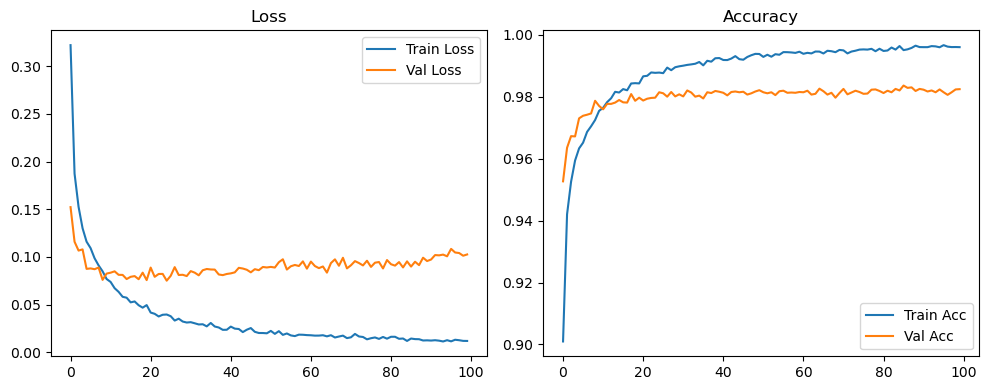

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2611, Acc: 0.9233 | Val Loss: 0.1538, Acc: 0.9575


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1182, Acc: 0.9646 | Val Loss: 0.1210, Acc: 0.9632


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0827, Acc: 0.9747 | Val Loss: 0.1134, Acc: 0.9680


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9797 | Val Loss: 0.1171, Acc: 0.9672


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9836 | Val Loss: 0.1366, Acc: 0.9663


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9857 | Val Loss: 0.1036, Acc: 0.9720


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9884 | Val Loss: 0.1075, Acc: 0.9735


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9894 | Val Loss: 0.1027, Acc: 0.9725


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9894 | Val Loss: 0.1091, Acc: 0.9736


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9907 | Val Loss: 0.1041, Acc: 0.9752


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9921 | Val Loss: 0.1180, Acc: 0.9714


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.1004, Acc: 0.9750


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.1082, Acc: 0.9752


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9948 | Val Loss: 0.1104, Acc: 0.9736


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.1205, Acc: 0.9755


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1083, Acc: 0.9755


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1235, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.1325, Acc: 0.9708


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1083, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1196, Acc: 0.9773


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9953 | Val Loss: 0.0943, Acc: 0.9773


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1112, Acc: 0.9776


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1052, Acc: 0.9758


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0987, Acc: 0.9780


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1184, Acc: 0.9761


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0995, Acc: 0.9786


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1102, Acc: 0.9756


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1192, Acc: 0.9731


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0962, Acc: 0.9768


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1220, Acc: 0.9776


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1235, Acc: 0.9790


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1104, Acc: 0.9781


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1265, Acc: 0.9765


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1270, Acc: 0.9774


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1247, Acc: 0.9774


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1140, Acc: 0.9767


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0894, Acc: 0.9775


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1083, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1123, Acc: 0.9756


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1101, Acc: 0.9802


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0929, Acc: 0.9762


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1044, Acc: 0.9782


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1124, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1308, Acc: 0.9769


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1063, Acc: 0.9768


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1077, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1053, Acc: 0.9766


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1140, Acc: 0.9776


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1134, Acc: 0.9758


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1366, Acc: 0.9764


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1170, Acc: 0.9775


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9974 | Val Loss: 0.1258, Acc: 0.9748


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1073, Acc: 0.9776


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1151, Acc: 0.9762


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1337, Acc: 0.9791


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1145, Acc: 0.9776


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1420, Acc: 0.9776


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.1216, Acc: 0.9777


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1341, Acc: 0.9782


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1271, Acc: 0.9777


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1121, Acc: 0.9778


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1167, Acc: 0.9752


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1303, Acc: 0.9764


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1183, Acc: 0.9774


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1396, Acc: 0.9782


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.0875, Acc: 0.9783


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0958, Acc: 0.9782


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1332, Acc: 0.9775


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1210, Acc: 0.9776


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1436, Acc: 0.9783


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1101, Acc: 0.9773


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1194, Acc: 0.9788


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0936, Acc: 0.9789


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1159, Acc: 0.9779


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9989 | Val Loss: 0.0991, Acc: 0.9778


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1081, Acc: 0.9782


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1230, Acc: 0.9788


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1566, Acc: 0.9793


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1313, Acc: 0.9762


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.1232, Acc: 0.9770


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1089, Acc: 0.9766


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1169, Acc: 0.9772


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1235, Acc: 0.9794


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1201, Acc: 0.9779


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1053, Acc: 0.9792


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0963, Acc: 0.9784


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9992 | Val Loss: 0.0922, Acc: 0.9798


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1385, Acc: 0.9777


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1268, Acc: 0.9790


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1418, Acc: 0.9788


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1450, Acc: 0.9803


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1363, Acc: 0.9788


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1105, Acc: 0.9792


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1124, Acc: 0.9780


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1543, Acc: 0.9774


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1282, Acc: 0.9780


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1500, Acc: 0.9795


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1297, Acc: 0.9784


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1002, Acc: 0.9767


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1253, Acc: 0.9781


Final Test Loss: 0.1186 Accuracy: 0.9780


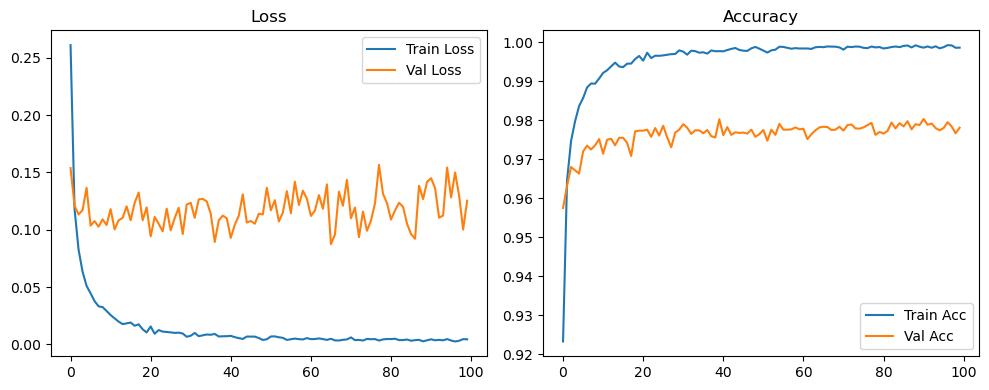

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2768, Acc: 0.9186 | Val Loss: 0.1903, Acc: 0.9471


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1376, Acc: 0.9589 | Val Loss: 0.1178, Acc: 0.9647


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1016, Acc: 0.9691 | Val Loss: 0.1227, Acc: 0.9642


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9741 | Val Loss: 0.1211, Acc: 0.9663


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0686, Acc: 0.9781 | Val Loss: 0.1096, Acc: 0.9682


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9813 | Val Loss: 0.1026, Acc: 0.9736


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9823 | Val Loss: 0.1007, Acc: 0.9733


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9856 | Val Loss: 0.1219, Acc: 0.9704


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9862 | Val Loss: 0.0922, Acc: 0.9772


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9870 | Val Loss: 0.1199, Acc: 0.9726


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9882 | Val Loss: 0.0999, Acc: 0.9762


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9889 | Val Loss: 0.1094, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9888 | Val Loss: 0.1180, Acc: 0.9714


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.1039, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9909 | Val Loss: 0.0910, Acc: 0.9780


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.0916, Acc: 0.9782


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.0981, Acc: 0.9763


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9920 | Val Loss: 0.0934, Acc: 0.9750


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.0981, Acc: 0.9776


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9943 | Val Loss: 0.0955, Acc: 0.9787


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0950, Acc: 0.9788


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9935 | Val Loss: 0.0955, Acc: 0.9776


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0886, Acc: 0.9772


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9943 | Val Loss: 0.0787, Acc: 0.9792


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.1068, Acc: 0.9772


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.1008, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.0850, Acc: 0.9775


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0811, Acc: 0.9771


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1062, Acc: 0.9794


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.0884, Acc: 0.9803


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.1091, Acc: 0.9771


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.0905, Acc: 0.9812


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.0913, Acc: 0.9778


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0955, Acc: 0.9790


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0885, Acc: 0.9773


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.0959, Acc: 0.9796


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0977, Acc: 0.9797


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9957 | Val Loss: 0.0778, Acc: 0.9769


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0803, Acc: 0.9788


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.1122, Acc: 0.9798


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0967, Acc: 0.9785


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0957, Acc: 0.9781


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0835, Acc: 0.9803


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1096, Acc: 0.9792


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0944, Acc: 0.9788


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1021, Acc: 0.9805


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0994, Acc: 0.9783


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.0787, Acc: 0.9781


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0860, Acc: 0.9802


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1083, Acc: 0.9791


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1121, Acc: 0.9790


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1051, Acc: 0.9793


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0977, Acc: 0.9795


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1121, Acc: 0.9796


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1316, Acc: 0.9787


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1046, Acc: 0.9775


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1013, Acc: 0.9782


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0935, Acc: 0.9786


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1087, Acc: 0.9798


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1063, Acc: 0.9772


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0777, Acc: 0.9783


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1222, Acc: 0.9778


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0934, Acc: 0.9788


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1016, Acc: 0.9762


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1088, Acc: 0.9784


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1009, Acc: 0.9788


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0864, Acc: 0.9802


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9969 | Val Loss: 0.1070, Acc: 0.9794


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1042, Acc: 0.9782


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1291, Acc: 0.9789


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0865, Acc: 0.9778


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1132, Acc: 0.9766


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0922, Acc: 0.9783


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1539, Acc: 0.9768


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0797, Acc: 0.9796


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1263, Acc: 0.9784


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1557, Acc: 0.9786


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1011, Acc: 0.9790


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0897, Acc: 0.9810


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1402, Acc: 0.9800


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.1018, Acc: 0.9780


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0934, Acc: 0.9787


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1077, Acc: 0.9788


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1192, Acc: 0.9796


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0925, Acc: 0.9798


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1441, Acc: 0.9782


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1211, Acc: 0.9802


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1064, Acc: 0.9792


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1050, Acc: 0.9802


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1192, Acc: 0.9782


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1126, Acc: 0.9810


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1223, Acc: 0.9794


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1067, Acc: 0.9795


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1096, Acc: 0.9788


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.1137, Acc: 0.9792


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1124, Acc: 0.9782


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1126, Acc: 0.9782


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1058, Acc: 0.9801


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1319, Acc: 0.9791


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1007, Acc: 0.9774


Final Test Loss: 0.0873 Accuracy: 0.9802


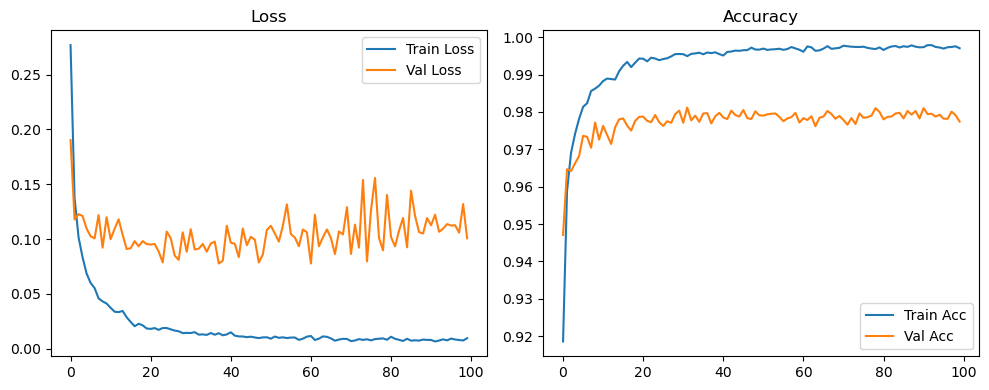

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3549, Acc: 0.8973 | Val Loss: 0.1782, Acc: 0.9493


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1971, Acc: 0.9420 | Val Loss: 0.1303, Acc: 0.9603


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1587, Acc: 0.9523 | Val Loss: 0.1274, Acc: 0.9630


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1353, Acc: 0.9594 | Val Loss: 0.1095, Acc: 0.9683


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1210, Acc: 0.9635 | Val Loss: 0.1033, Acc: 0.9691


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1113, Acc: 0.9659 | Val Loss: 0.1047, Acc: 0.9708


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1022, Acc: 0.9689 | Val Loss: 0.0974, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9721 | Val Loss: 0.1023, Acc: 0.9712


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0905, Acc: 0.9713 | Val Loss: 0.0941, Acc: 0.9742


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0820, Acc: 0.9747 | Val Loss: 0.0923, Acc: 0.9764


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9745 | Val Loss: 0.0948, Acc: 0.9732


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9762 | Val Loss: 0.0974, Acc: 0.9749


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9768 | Val Loss: 0.0945, Acc: 0.9761


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9787 | Val Loss: 0.0905, Acc: 0.9761


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0667, Acc: 0.9793 | Val Loss: 0.0902, Acc: 0.9764


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9805 | Val Loss: 0.0893, Acc: 0.9752


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9817 | Val Loss: 0.0914, Acc: 0.9772


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9813 | Val Loss: 0.0854, Acc: 0.9788


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9826 | Val Loss: 0.0893, Acc: 0.9783


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9830 | Val Loss: 0.0797, Acc: 0.9800


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9825 | Val Loss: 0.0857, Acc: 0.9790


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9849 | Val Loss: 0.0896, Acc: 0.9788


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9854 | Val Loss: 0.0858, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9850 | Val Loss: 0.0869, Acc: 0.9797


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9861 | Val Loss: 0.0977, Acc: 0.9784


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9861 | Val Loss: 0.0931, Acc: 0.9796


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9862 | Val Loss: 0.0931, Acc: 0.9789


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9869 | Val Loss: 0.0927, Acc: 0.9787


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9878 | Val Loss: 0.0939, Acc: 0.9792


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9880 | Val Loss: 0.0824, Acc: 0.9791


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9898 | Val Loss: 0.0962, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9900 | Val Loss: 0.0906, Acc: 0.9798


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.0791, Acc: 0.9810


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9901 | Val Loss: 0.0968, Acc: 0.9807


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.0907, Acc: 0.9784


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9896 | Val Loss: 0.0880, Acc: 0.9791


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9902 | Val Loss: 0.0992, Acc: 0.9791


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9896 | Val Loss: 0.0820, Acc: 0.9809


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9903 | Val Loss: 0.0914, Acc: 0.9800


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9899 | Val Loss: 0.0897, Acc: 0.9784


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9898 | Val Loss: 0.0983, Acc: 0.9793


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9897 | Val Loss: 0.0879, Acc: 0.9787


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.0841, Acc: 0.9798


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9906 | Val Loss: 0.0890, Acc: 0.9796


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9905 | Val Loss: 0.1008, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9907 | Val Loss: 0.0961, Acc: 0.9796


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9915 | Val Loss: 0.0764, Acc: 0.9799


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.0899, Acc: 0.9798


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.0941, Acc: 0.9793


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.0776, Acc: 0.9801


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9909 | Val Loss: 0.0722, Acc: 0.9821


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9908 | Val Loss: 0.0752, Acc: 0.9798


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.0856, Acc: 0.9793


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9914 | Val Loss: 0.0979, Acc: 0.9806


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.0744, Acc: 0.9796


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9917 | Val Loss: 0.0883, Acc: 0.9805


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9914 | Val Loss: 0.0889, Acc: 0.9811


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.0854, Acc: 0.9788


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.0866, Acc: 0.9787


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0992, Acc: 0.9803


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9915 | Val Loss: 0.0835, Acc: 0.9812


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9913 | Val Loss: 0.0941, Acc: 0.9797


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9909 | Val Loss: 0.0877, Acc: 0.9798


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9910 | Val Loss: 0.0847, Acc: 0.9802


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.0894, Acc: 0.9814


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9916 | Val Loss: 0.0979, Acc: 0.9792


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9919 | Val Loss: 0.0733, Acc: 0.9799


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.0935, Acc: 0.9809


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9921 | Val Loss: 0.0854, Acc: 0.9818


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9913 | Val Loss: 0.0832, Acc: 0.9805


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9914 | Val Loss: 0.0901, Acc: 0.9808


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.0953, Acc: 0.9802


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9916 | Val Loss: 0.0983, Acc: 0.9808


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9915 | Val Loss: 0.0764, Acc: 0.9805


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.0870, Acc: 0.9802


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.0840, Acc: 0.9802


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9915 | Val Loss: 0.0966, Acc: 0.9797


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.0810, Acc: 0.9808


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.0731, Acc: 0.9802


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9911 | Val Loss: 0.1037, Acc: 0.9804


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9921 | Val Loss: 0.0981, Acc: 0.9804


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9922 | Val Loss: 0.0958, Acc: 0.9800


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9916 | Val Loss: 0.0833, Acc: 0.9813


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9922 | Val Loss: 0.0808, Acc: 0.9810


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9914 | Val Loss: 0.0914, Acc: 0.9807


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9915 | Val Loss: 0.0890, Acc: 0.9798


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9916 | Val Loss: 0.0867, Acc: 0.9799


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.0821, Acc: 0.9799


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9920 | Val Loss: 0.0843, Acc: 0.9801


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9903 | Val Loss: 0.0996, Acc: 0.9799


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9912 | Val Loss: 0.0876, Acc: 0.9810


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9908 | Val Loss: 0.0904, Acc: 0.9799


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9917 | Val Loss: 0.0806, Acc: 0.9815


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.0855, Acc: 0.9802


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9917 | Val Loss: 0.0804, Acc: 0.9801


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9920 | Val Loss: 0.0861, Acc: 0.9818


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9921 | Val Loss: 0.0908, Acc: 0.9800


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 0.0754, Acc: 0.9796


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.0866, Acc: 0.9806


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9912 | Val Loss: 0.0818, Acc: 0.9793


Final Test Loss: 0.0795 Accuracy: 0.9800


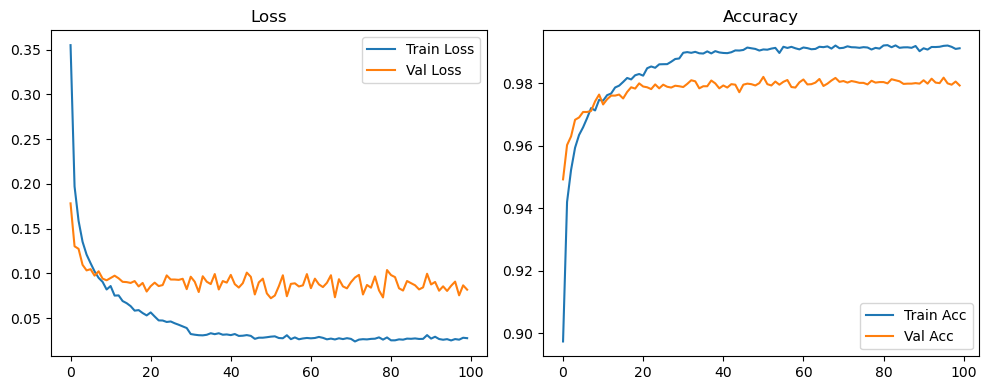

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2611, Acc: 0.9233 | Val Loss: 0.1538, Acc: 0.9575


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1182, Acc: 0.9646 | Val Loss: 0.1210, Acc: 0.9632


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0827, Acc: 0.9747 | Val Loss: 0.1134, Acc: 0.9680


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9797 | Val Loss: 0.1171, Acc: 0.9672


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9836 | Val Loss: 0.1366, Acc: 0.9663


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9857 | Val Loss: 0.1036, Acc: 0.9720


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9884 | Val Loss: 0.1075, Acc: 0.9735


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9894 | Val Loss: 0.1027, Acc: 0.9725


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9894 | Val Loss: 0.1091, Acc: 0.9736


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9907 | Val Loss: 0.1041, Acc: 0.9752


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9921 | Val Loss: 0.1180, Acc: 0.9714


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.1004, Acc: 0.9750


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.1082, Acc: 0.9752


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9948 | Val Loss: 0.1104, Acc: 0.9736


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.1205, Acc: 0.9755


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1083, Acc: 0.9755


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1235, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.1325, Acc: 0.9708


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1083, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1196, Acc: 0.9773


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9953 | Val Loss: 0.0943, Acc: 0.9773


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1112, Acc: 0.9776


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1052, Acc: 0.9758


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0987, Acc: 0.9780


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1184, Acc: 0.9761


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0995, Acc: 0.9786


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1102, Acc: 0.9756


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1192, Acc: 0.9731


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0962, Acc: 0.9768


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1220, Acc: 0.9776


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1235, Acc: 0.9790


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1104, Acc: 0.9781


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1265, Acc: 0.9765


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1270, Acc: 0.9774


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1247, Acc: 0.9774


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1140, Acc: 0.9767


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0894, Acc: 0.9775


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1083, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1123, Acc: 0.9756


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1101, Acc: 0.9802


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0929, Acc: 0.9762


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1044, Acc: 0.9782


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1124, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1308, Acc: 0.9769


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1063, Acc: 0.9768


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1077, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1053, Acc: 0.9766


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1140, Acc: 0.9776


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1134, Acc: 0.9758


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1366, Acc: 0.9764


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1103, Acc: 0.9790


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1300, Acc: 0.9793


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1215, Acc: 0.9801


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1139, Acc: 0.9801


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1360, Acc: 0.9802


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1276, Acc: 0.9783


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1274, Acc: 0.9792


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1455, Acc: 0.9793


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1552, Acc: 0.9795


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1419, Acc: 0.9796


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1619, Acc: 0.9773


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1461, Acc: 0.9785


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1452, Acc: 0.9773


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1377, Acc: 0.9796


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1252, Acc: 0.9801


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1385, Acc: 0.9799


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1310, Acc: 0.9788


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1374, Acc: 0.9790


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1329, Acc: 0.9783


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1423, Acc: 0.9797


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1040, Acc: 0.9811


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1529, Acc: 0.9806


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1455, Acc: 0.9802


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1482, Acc: 0.9801


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1465, Acc: 0.9795


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1229, Acc: 0.9783


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1366, Acc: 0.9807


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1175, Acc: 0.9802


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1404, Acc: 0.9813


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1711, Acc: 0.9792


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1393, Acc: 0.9810


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1427, Acc: 0.9815


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1503, Acc: 0.9822


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1573, Acc: 0.9819


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1725, Acc: 0.9810


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1707, Acc: 0.9812


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1797, Acc: 0.9807


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1827, Acc: 0.9812


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1741, Acc: 0.9820


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1656, Acc: 0.9812


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1568, Acc: 0.9821


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1636, Acc: 0.9822


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1640, Acc: 0.9820


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1561, Acc: 0.9816


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1624, Acc: 0.9824


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1658, Acc: 0.9822


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1622, Acc: 0.9818


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1708, Acc: 0.9809


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1727, Acc: 0.9812


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1834, Acc: 0.9812


Final Test Loss: 0.1727 Accuracy: 0.9830


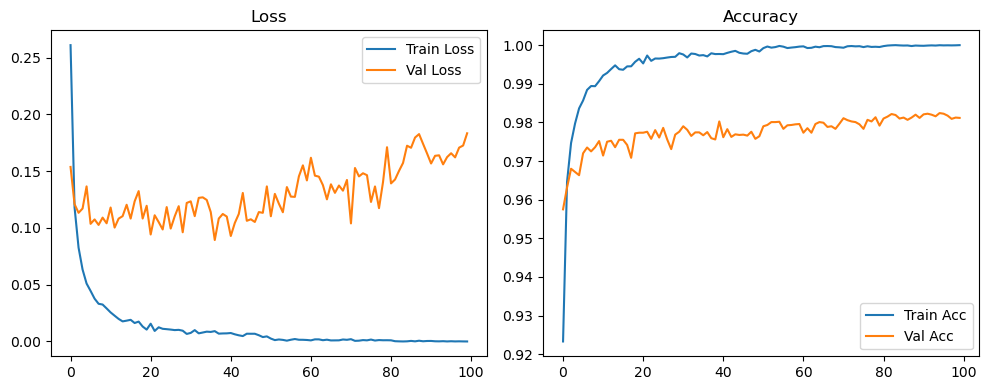

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2768, Acc: 0.9186 | Val Loss: 0.1903, Acc: 0.9471


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1376, Acc: 0.9589 | Val Loss: 0.1178, Acc: 0.9647


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1016, Acc: 0.9691 | Val Loss: 0.1227, Acc: 0.9642


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9741 | Val Loss: 0.1211, Acc: 0.9663


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0686, Acc: 0.9781 | Val Loss: 0.1096, Acc: 0.9682


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9813 | Val Loss: 0.1026, Acc: 0.9736


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9823 | Val Loss: 0.1007, Acc: 0.9733


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9856 | Val Loss: 0.1219, Acc: 0.9704


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9862 | Val Loss: 0.0922, Acc: 0.9772


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9870 | Val Loss: 0.1199, Acc: 0.9726


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9882 | Val Loss: 0.0999, Acc: 0.9762


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9889 | Val Loss: 0.1094, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9888 | Val Loss: 0.1180, Acc: 0.9714


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.1039, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9909 | Val Loss: 0.0910, Acc: 0.9780


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.0916, Acc: 0.9782


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.0981, Acc: 0.9763


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9920 | Val Loss: 0.0934, Acc: 0.9750


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.0981, Acc: 0.9776


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9943 | Val Loss: 0.0955, Acc: 0.9787


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0950, Acc: 0.9788


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9935 | Val Loss: 0.0955, Acc: 0.9776


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0886, Acc: 0.9772


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9943 | Val Loss: 0.0787, Acc: 0.9792


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.1068, Acc: 0.9772


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.1008, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.0850, Acc: 0.9775


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0811, Acc: 0.9771


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1062, Acc: 0.9794


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.0884, Acc: 0.9803


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.1091, Acc: 0.9771


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.0905, Acc: 0.9812


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.0913, Acc: 0.9778


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0955, Acc: 0.9790


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0885, Acc: 0.9773


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.0959, Acc: 0.9796


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0977, Acc: 0.9797


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9957 | Val Loss: 0.0778, Acc: 0.9769


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0803, Acc: 0.9788


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.1122, Acc: 0.9798


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0967, Acc: 0.9785


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0957, Acc: 0.9781


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0835, Acc: 0.9803


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1096, Acc: 0.9792


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0944, Acc: 0.9788


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1021, Acc: 0.9805


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0994, Acc: 0.9783


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.0787, Acc: 0.9781


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0860, Acc: 0.9802


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1083, Acc: 0.9791


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1081, Acc: 0.9810


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0946, Acc: 0.9820


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0852, Acc: 0.9818


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1023, Acc: 0.9812


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1090, Acc: 0.9798


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0953, Acc: 0.9805


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1100, Acc: 0.9809


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1006, Acc: 0.9800


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1131, Acc: 0.9813


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1076, Acc: 0.9802


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0871, Acc: 0.9809


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0993, Acc: 0.9806


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0873, Acc: 0.9802


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0954, Acc: 0.9809


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1120, Acc: 0.9816


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1234, Acc: 0.9812


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1065, Acc: 0.9801


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0843, Acc: 0.9809


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0921, Acc: 0.9808


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1161, Acc: 0.9799


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1198, Acc: 0.9804


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0952, Acc: 0.9813


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1151, Acc: 0.9821


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1031, Acc: 0.9810


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0928, Acc: 0.9816


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1057, Acc: 0.9828


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1179, Acc: 0.9818


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1098, Acc: 0.9803


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0990, Acc: 0.9811


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1245, Acc: 0.9817


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1238, Acc: 0.9820


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1146, Acc: 0.9825


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1060, Acc: 0.9823


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1226, Acc: 0.9822


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1246, Acc: 0.9827


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1533, Acc: 0.9828


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1172, Acc: 0.9814


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1198, Acc: 0.9819


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1097, Acc: 0.9820


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1266, Acc: 0.9821


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1166, Acc: 0.9822


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1123, Acc: 0.9827


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1316, Acc: 0.9824


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1309, Acc: 0.9818


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1196, Acc: 0.9818


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1256, Acc: 0.9823


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1331, Acc: 0.9828


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1190, Acc: 0.9818


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1215, Acc: 0.9825


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1114, Acc: 0.9830


Final Test Loss: 0.1015 Accuracy: 0.9837


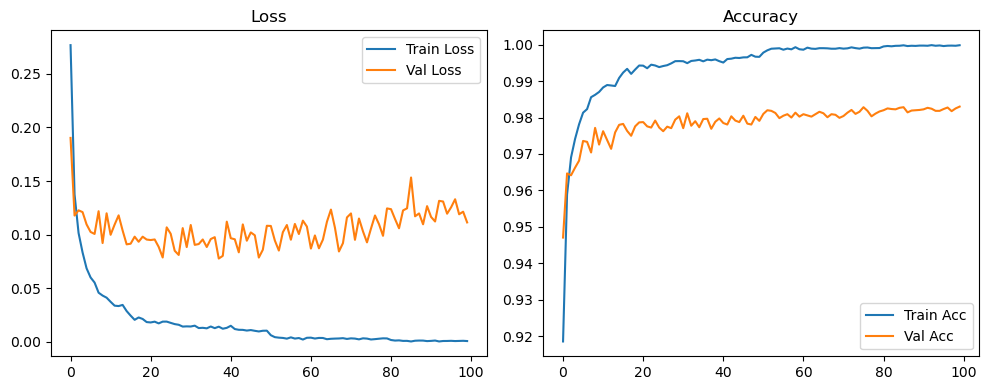

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3549, Acc: 0.8973 | Val Loss: 0.1782, Acc: 0.9493


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1971, Acc: 0.9420 | Val Loss: 0.1303, Acc: 0.9603


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1587, Acc: 0.9523 | Val Loss: 0.1274, Acc: 0.9630


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1353, Acc: 0.9594 | Val Loss: 0.1095, Acc: 0.9683


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1210, Acc: 0.9635 | Val Loss: 0.1033, Acc: 0.9691


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1113, Acc: 0.9659 | Val Loss: 0.1047, Acc: 0.9708


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1022, Acc: 0.9689 | Val Loss: 0.0974, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9721 | Val Loss: 0.1023, Acc: 0.9712


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0905, Acc: 0.9713 | Val Loss: 0.0941, Acc: 0.9742


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0820, Acc: 0.9747 | Val Loss: 0.0923, Acc: 0.9764


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9745 | Val Loss: 0.0948, Acc: 0.9732


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9762 | Val Loss: 0.0974, Acc: 0.9749


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9768 | Val Loss: 0.0945, Acc: 0.9761


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9787 | Val Loss: 0.0905, Acc: 0.9761


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0667, Acc: 0.9793 | Val Loss: 0.0902, Acc: 0.9764


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9805 | Val Loss: 0.0893, Acc: 0.9752


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9817 | Val Loss: 0.0914, Acc: 0.9772


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9813 | Val Loss: 0.0854, Acc: 0.9788


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9826 | Val Loss: 0.0893, Acc: 0.9783


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9830 | Val Loss: 0.0797, Acc: 0.9800


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9825 | Val Loss: 0.0857, Acc: 0.9790


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9849 | Val Loss: 0.0896, Acc: 0.9788


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9854 | Val Loss: 0.0858, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9850 | Val Loss: 0.0869, Acc: 0.9797


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9861 | Val Loss: 0.0977, Acc: 0.9784


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9861 | Val Loss: 0.0931, Acc: 0.9796


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9862 | Val Loss: 0.0931, Acc: 0.9789


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9869 | Val Loss: 0.0927, Acc: 0.9787


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9878 | Val Loss: 0.0939, Acc: 0.9792


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9880 | Val Loss: 0.0824, Acc: 0.9791


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9898 | Val Loss: 0.0962, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9900 | Val Loss: 0.0906, Acc: 0.9798


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.0791, Acc: 0.9810


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9901 | Val Loss: 0.0968, Acc: 0.9807


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.0907, Acc: 0.9784


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9896 | Val Loss: 0.0880, Acc: 0.9791


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9902 | Val Loss: 0.0992, Acc: 0.9791


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9896 | Val Loss: 0.0820, Acc: 0.9809


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9903 | Val Loss: 0.0914, Acc: 0.9800


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9899 | Val Loss: 0.0897, Acc: 0.9784


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9898 | Val Loss: 0.0983, Acc: 0.9793


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9897 | Val Loss: 0.0879, Acc: 0.9787


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.0841, Acc: 0.9798


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9906 | Val Loss: 0.0890, Acc: 0.9796


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9905 | Val Loss: 0.1008, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9907 | Val Loss: 0.0961, Acc: 0.9796


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9915 | Val Loss: 0.0764, Acc: 0.9799


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.0899, Acc: 0.9798


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.0941, Acc: 0.9793


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.0776, Acc: 0.9801


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9925 | Val Loss: 0.0774, Acc: 0.9819


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.1011, Acc: 0.9820


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.0939, Acc: 0.9810


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0910, Acc: 0.9820


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0935, Acc: 0.9822


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1000, Acc: 0.9825


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0855, Acc: 0.9813


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1005, Acc: 0.9812


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.0956, Acc: 0.9822


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1050, Acc: 0.9818


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1090, Acc: 0.9818


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.1092, Acc: 0.9818


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0839, Acc: 0.9814


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9958 | Val Loss: 0.0992, Acc: 0.9820


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0936, Acc: 0.9818


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0976, Acc: 0.9808


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.1063, Acc: 0.9810


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0963, Acc: 0.9812


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.0906, Acc: 0.9812


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0822, Acc: 0.9814


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1177, Acc: 0.9821


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.0965, Acc: 0.9821


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0938, Acc: 0.9820


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0905, Acc: 0.9813


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.1069, Acc: 0.9816


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0917, Acc: 0.9818


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.0916, Acc: 0.9810


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0806, Acc: 0.9832


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1059, Acc: 0.9815


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0922, Acc: 0.9821


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0926, Acc: 0.9832


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0951, Acc: 0.9823


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.0968, Acc: 0.9821


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0884, Acc: 0.9824


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0972, Acc: 0.9829


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.0935, Acc: 0.9830


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0899, Acc: 0.9827


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0936, Acc: 0.9827


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0922, Acc: 0.9829


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0954, Acc: 0.9824


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0994, Acc: 0.9826


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9985 | Val Loss: 0.0962, Acc: 0.9827


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1041, Acc: 0.9827


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0952, Acc: 0.9825


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1061, Acc: 0.9822


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0860, Acc: 0.9834


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0983, Acc: 0.9835


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0970, Acc: 0.9830


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1020, Acc: 0.9829


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1072, Acc: 0.9832


Final Test Loss: 0.1005 Accuracy: 0.9836


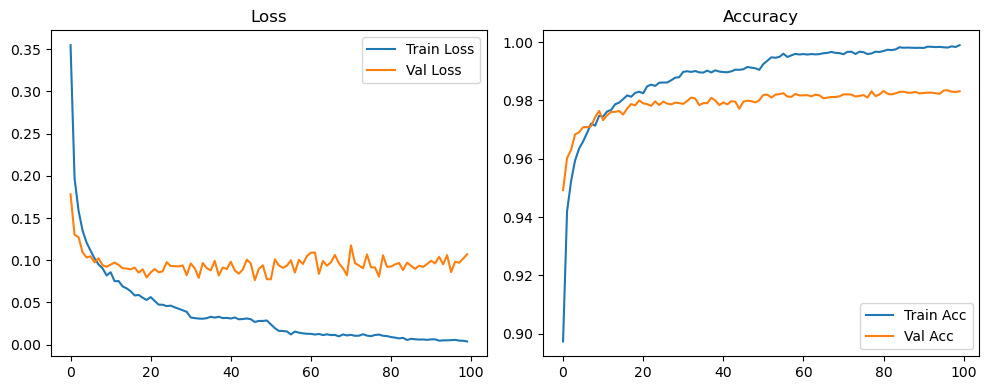

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2611, Acc: 0.9233 | Val Loss: 0.1538, Acc: 0.9575


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1182, Acc: 0.9646 | Val Loss: 0.1210, Acc: 0.9632


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0827, Acc: 0.9747 | Val Loss: 0.1134, Acc: 0.9680


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9797 | Val Loss: 0.1171, Acc: 0.9672


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9836 | Val Loss: 0.1366, Acc: 0.9663


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9857 | Val Loss: 0.1036, Acc: 0.9720


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9884 | Val Loss: 0.1075, Acc: 0.9735


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9894 | Val Loss: 0.1027, Acc: 0.9725


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9894 | Val Loss: 0.1091, Acc: 0.9736


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9907 | Val Loss: 0.1041, Acc: 0.9752


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9921 | Val Loss: 0.1180, Acc: 0.9714


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.1004, Acc: 0.9750


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.1082, Acc: 0.9752


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9948 | Val Loss: 0.1104, Acc: 0.9736


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.1205, Acc: 0.9755


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1083, Acc: 0.9755


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1235, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.1325, Acc: 0.9708


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1083, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1196, Acc: 0.9773


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9953 | Val Loss: 0.0943, Acc: 0.9773


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1112, Acc: 0.9776


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1052, Acc: 0.9758


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0987, Acc: 0.9780


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1184, Acc: 0.9761


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0995, Acc: 0.9786


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1102, Acc: 0.9756


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1192, Acc: 0.9731


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0962, Acc: 0.9768


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1220, Acc: 0.9776


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1235, Acc: 0.9790


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1104, Acc: 0.9781


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1265, Acc: 0.9765


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1270, Acc: 0.9774


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1247, Acc: 0.9774


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1140, Acc: 0.9767


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0894, Acc: 0.9775


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1083, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1123, Acc: 0.9756


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1101, Acc: 0.9802


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0929, Acc: 0.9762


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1044, Acc: 0.9782


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1124, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1308, Acc: 0.9769


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1063, Acc: 0.9768


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1077, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1053, Acc: 0.9766


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1140, Acc: 0.9776


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1134, Acc: 0.9758


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1366, Acc: 0.9764


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1103, Acc: 0.9790


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1300, Acc: 0.9793


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1215, Acc: 0.9801


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1139, Acc: 0.9801


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1360, Acc: 0.9802


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1276, Acc: 0.9783


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1274, Acc: 0.9792


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1455, Acc: 0.9793


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1552, Acc: 0.9795


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1419, Acc: 0.9796


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1619, Acc: 0.9773


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1461, Acc: 0.9785


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1452, Acc: 0.9773


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1377, Acc: 0.9796


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1252, Acc: 0.9801


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1385, Acc: 0.9799


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1310, Acc: 0.9788


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1374, Acc: 0.9790


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1329, Acc: 0.9783


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1423, Acc: 0.9797


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1040, Acc: 0.9811


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1529, Acc: 0.9806


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1455, Acc: 0.9802


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1482, Acc: 0.9801


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1465, Acc: 0.9795


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1229, Acc: 0.9783


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1366, Acc: 0.9807


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1175, Acc: 0.9802


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1404, Acc: 0.9813


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1711, Acc: 0.9792


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1404, Acc: 0.9808


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1416, Acc: 0.9809


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1419, Acc: 0.9813


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1450, Acc: 0.9815


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1489, Acc: 0.9813


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1527, Acc: 0.9822


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1589, Acc: 0.9819


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1683, Acc: 0.9819


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1725, Acc: 0.9818


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1683, Acc: 0.9821


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1758, Acc: 0.9812


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1785, Acc: 0.9815


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1813, Acc: 0.9821


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1762, Acc: 0.9815


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1866, Acc: 0.9805


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1933, Acc: 0.9808


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1872, Acc: 0.9806


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1917, Acc: 0.9811


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1868, Acc: 0.9809


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1844, Acc: 0.9808


Final Test Loss: 0.1757 Accuracy: 0.9830


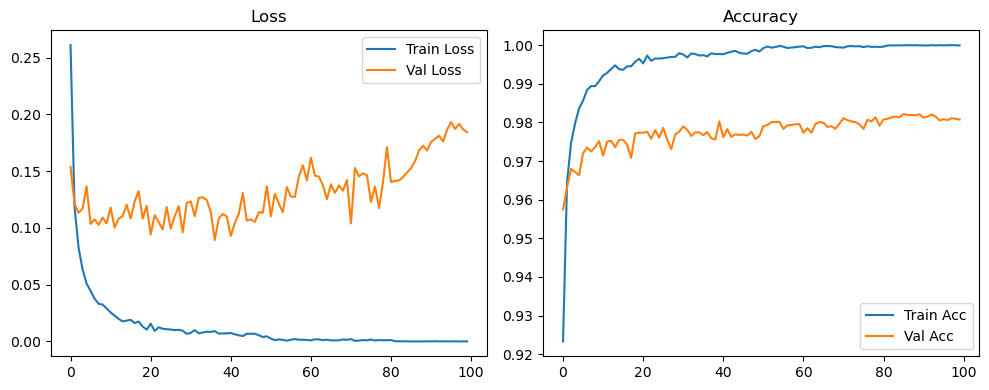

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2768, Acc: 0.9186 | Val Loss: 0.1903, Acc: 0.9471


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1376, Acc: 0.9589 | Val Loss: 0.1178, Acc: 0.9647


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1016, Acc: 0.9691 | Val Loss: 0.1227, Acc: 0.9642


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9741 | Val Loss: 0.1211, Acc: 0.9663


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0686, Acc: 0.9781 | Val Loss: 0.1096, Acc: 0.9682


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9813 | Val Loss: 0.1026, Acc: 0.9736


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9823 | Val Loss: 0.1007, Acc: 0.9733


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9856 | Val Loss: 0.1219, Acc: 0.9704


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9862 | Val Loss: 0.0922, Acc: 0.9772


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9870 | Val Loss: 0.1199, Acc: 0.9726


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9882 | Val Loss: 0.0999, Acc: 0.9762


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9889 | Val Loss: 0.1094, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9888 | Val Loss: 0.1180, Acc: 0.9714


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.1039, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9909 | Val Loss: 0.0910, Acc: 0.9780


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.0916, Acc: 0.9782


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.0981, Acc: 0.9763


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9920 | Val Loss: 0.0934, Acc: 0.9750


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.0981, Acc: 0.9776


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9943 | Val Loss: 0.0955, Acc: 0.9787


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0950, Acc: 0.9788


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9935 | Val Loss: 0.0955, Acc: 0.9776


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0886, Acc: 0.9772


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9943 | Val Loss: 0.0787, Acc: 0.9792


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.1068, Acc: 0.9772


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.1008, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.0850, Acc: 0.9775


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0811, Acc: 0.9771


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1062, Acc: 0.9794


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.0884, Acc: 0.9803


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.1091, Acc: 0.9771


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.0905, Acc: 0.9812


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.0913, Acc: 0.9778


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0955, Acc: 0.9790


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0885, Acc: 0.9773


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.0959, Acc: 0.9796


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0977, Acc: 0.9797


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9957 | Val Loss: 0.0778, Acc: 0.9769


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0803, Acc: 0.9788


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.1122, Acc: 0.9798


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0967, Acc: 0.9785


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0957, Acc: 0.9781


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0835, Acc: 0.9803


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1096, Acc: 0.9792


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0944, Acc: 0.9788


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1021, Acc: 0.9805


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0994, Acc: 0.9783


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.0787, Acc: 0.9781


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0860, Acc: 0.9802


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1083, Acc: 0.9791


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1081, Acc: 0.9810


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0946, Acc: 0.9820


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0852, Acc: 0.9818


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1023, Acc: 0.9812


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1090, Acc: 0.9798


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0953, Acc: 0.9805


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1100, Acc: 0.9809


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1006, Acc: 0.9800


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1131, Acc: 0.9813


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1076, Acc: 0.9802


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0871, Acc: 0.9809


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0993, Acc: 0.9806


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0873, Acc: 0.9802


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0954, Acc: 0.9809


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1120, Acc: 0.9816


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1234, Acc: 0.9812


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1065, Acc: 0.9801


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0843, Acc: 0.9809


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0921, Acc: 0.9808


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1161, Acc: 0.9799


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1198, Acc: 0.9804


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0952, Acc: 0.9813


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1151, Acc: 0.9821


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1031, Acc: 0.9810


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0928, Acc: 0.9816


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1057, Acc: 0.9828


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1179, Acc: 0.9818


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1098, Acc: 0.9803


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0990, Acc: 0.9811


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1245, Acc: 0.9817


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1147, Acc: 0.9820


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1132, Acc: 0.9819


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1148, Acc: 0.9822


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1201, Acc: 0.9824


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1229, Acc: 0.9829


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1331, Acc: 0.9828


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1277, Acc: 0.9823


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1258, Acc: 0.9822


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1106, Acc: 0.9831


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1162, Acc: 0.9826


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1233, Acc: 0.9824


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1179, Acc: 0.9828


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.1347, Acc: 0.9829


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1334, Acc: 0.9825


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1186, Acc: 0.9825


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1187, Acc: 0.9827


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1257, Acc: 0.9832


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1281, Acc: 0.9823


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1311, Acc: 0.9828


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1278, Acc: 0.9828


Final Test Loss: 0.1229 Accuracy: 0.9827


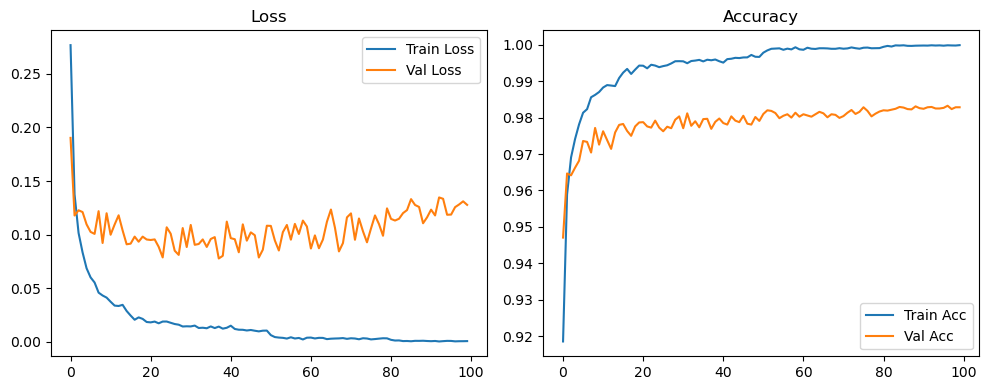

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3549, Acc: 0.8973 | Val Loss: 0.1782, Acc: 0.9493


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1971, Acc: 0.9420 | Val Loss: 0.1303, Acc: 0.9603


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1587, Acc: 0.9523 | Val Loss: 0.1274, Acc: 0.9630


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1353, Acc: 0.9594 | Val Loss: 0.1095, Acc: 0.9683


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1210, Acc: 0.9635 | Val Loss: 0.1033, Acc: 0.9691


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1113, Acc: 0.9659 | Val Loss: 0.1047, Acc: 0.9708


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1022, Acc: 0.9689 | Val Loss: 0.0974, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9721 | Val Loss: 0.1023, Acc: 0.9712


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0905, Acc: 0.9713 | Val Loss: 0.0941, Acc: 0.9742


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0820, Acc: 0.9747 | Val Loss: 0.0923, Acc: 0.9764


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9745 | Val Loss: 0.0948, Acc: 0.9732


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9762 | Val Loss: 0.0974, Acc: 0.9749


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9768 | Val Loss: 0.0945, Acc: 0.9761


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9787 | Val Loss: 0.0905, Acc: 0.9761


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0667, Acc: 0.9793 | Val Loss: 0.0902, Acc: 0.9764


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9805 | Val Loss: 0.0893, Acc: 0.9752


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9817 | Val Loss: 0.0914, Acc: 0.9772


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9813 | Val Loss: 0.0854, Acc: 0.9788


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9826 | Val Loss: 0.0893, Acc: 0.9783


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9830 | Val Loss: 0.0797, Acc: 0.9800


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9825 | Val Loss: 0.0857, Acc: 0.9790


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9849 | Val Loss: 0.0896, Acc: 0.9788


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9854 | Val Loss: 0.0858, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9850 | Val Loss: 0.0869, Acc: 0.9797


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9861 | Val Loss: 0.0977, Acc: 0.9784


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9861 | Val Loss: 0.0931, Acc: 0.9796


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9862 | Val Loss: 0.0931, Acc: 0.9789


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9869 | Val Loss: 0.0927, Acc: 0.9787


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9878 | Val Loss: 0.0939, Acc: 0.9792


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9880 | Val Loss: 0.0824, Acc: 0.9791


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9898 | Val Loss: 0.0962, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9900 | Val Loss: 0.0906, Acc: 0.9798


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.0791, Acc: 0.9810


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9901 | Val Loss: 0.0968, Acc: 0.9807


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.0907, Acc: 0.9784


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9896 | Val Loss: 0.0880, Acc: 0.9791


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9902 | Val Loss: 0.0992, Acc: 0.9791


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9896 | Val Loss: 0.0820, Acc: 0.9809


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9903 | Val Loss: 0.0914, Acc: 0.9800


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9899 | Val Loss: 0.0897, Acc: 0.9784


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9898 | Val Loss: 0.0983, Acc: 0.9793


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9897 | Val Loss: 0.0879, Acc: 0.9787


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.0841, Acc: 0.9798


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9906 | Val Loss: 0.0890, Acc: 0.9796


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9905 | Val Loss: 0.1008, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9907 | Val Loss: 0.0961, Acc: 0.9796


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9915 | Val Loss: 0.0764, Acc: 0.9799


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.0899, Acc: 0.9798


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.0941, Acc: 0.9793


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.0776, Acc: 0.9801


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9925 | Val Loss: 0.0774, Acc: 0.9819


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.1011, Acc: 0.9820


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.0939, Acc: 0.9810


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0910, Acc: 0.9820


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0935, Acc: 0.9822


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1000, Acc: 0.9825


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0855, Acc: 0.9813


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1005, Acc: 0.9812


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.0956, Acc: 0.9822


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1050, Acc: 0.9818


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1090, Acc: 0.9818


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.1092, Acc: 0.9818


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0839, Acc: 0.9814


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9958 | Val Loss: 0.0992, Acc: 0.9820


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0936, Acc: 0.9818


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0976, Acc: 0.9808


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.1063, Acc: 0.9810


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0963, Acc: 0.9812


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.0906, Acc: 0.9812


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0822, Acc: 0.9814


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1177, Acc: 0.9821


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.0965, Acc: 0.9821


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0938, Acc: 0.9820


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0905, Acc: 0.9813


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.1069, Acc: 0.9816


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0917, Acc: 0.9818


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.0916, Acc: 0.9810


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0806, Acc: 0.9832


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1059, Acc: 0.9815


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0922, Acc: 0.9821


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0932, Acc: 0.9828


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0937, Acc: 0.9824


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0908, Acc: 0.9827


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0888, Acc: 0.9828


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.0946, Acc: 0.9832


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0893, Acc: 0.9831


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0893, Acc: 0.9829


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0921, Acc: 0.9829


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0964, Acc: 0.9834


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0981, Acc: 0.9828


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0856, Acc: 0.9830


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0922, Acc: 0.9825


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1041, Acc: 0.9830


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1000, Acc: 0.9829


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1042, Acc: 0.9829


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0976, Acc: 0.9828


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0956, Acc: 0.9828


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0989, Acc: 0.9829


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1001, Acc: 0.9827


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1033, Acc: 0.9828


Final Test Loss: 0.0960 Accuracy: 0.9832


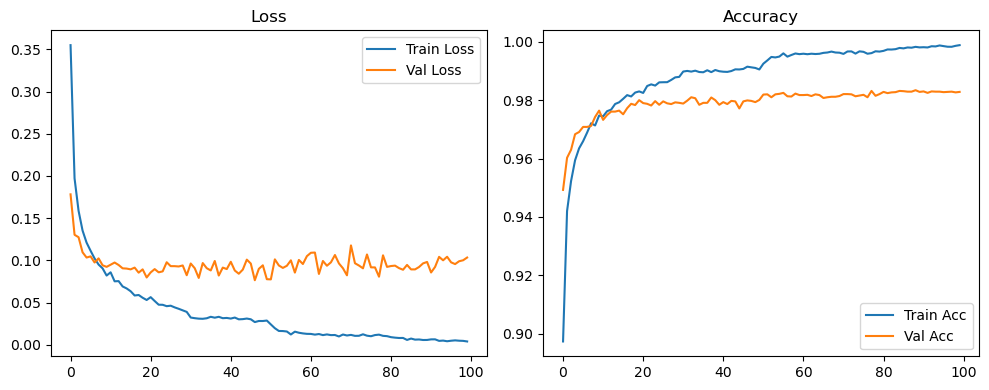

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2611, Acc: 0.9233 | Val Loss: 0.1538, Acc: 0.9575


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1182, Acc: 0.9646 | Val Loss: 0.1210, Acc: 0.9632


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0827, Acc: 0.9747 | Val Loss: 0.1134, Acc: 0.9680


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9797 | Val Loss: 0.1171, Acc: 0.9672


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9836 | Val Loss: 0.1366, Acc: 0.9663


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9857 | Val Loss: 0.1036, Acc: 0.9720


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9884 | Val Loss: 0.1075, Acc: 0.9735


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9894 | Val Loss: 0.1027, Acc: 0.9725


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9894 | Val Loss: 0.1091, Acc: 0.9736


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9907 | Val Loss: 0.1041, Acc: 0.9752


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9921 | Val Loss: 0.1180, Acc: 0.9714


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.1004, Acc: 0.9750


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.1082, Acc: 0.9752


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9948 | Val Loss: 0.1104, Acc: 0.9736


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.1205, Acc: 0.9755


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1083, Acc: 0.9755


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1235, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.1325, Acc: 0.9708


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1083, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1196, Acc: 0.9773


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9953 | Val Loss: 0.0943, Acc: 0.9773


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1112, Acc: 0.9776


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1052, Acc: 0.9758


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0987, Acc: 0.9780


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1184, Acc: 0.9761


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0995, Acc: 0.9786


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1102, Acc: 0.9756


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1192, Acc: 0.9731


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0962, Acc: 0.9768


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1220, Acc: 0.9776


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1235, Acc: 0.9790


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1104, Acc: 0.9781


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1265, Acc: 0.9765


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1270, Acc: 0.9774


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1247, Acc: 0.9774


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1140, Acc: 0.9767


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0894, Acc: 0.9775


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1083, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1123, Acc: 0.9756


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1101, Acc: 0.9802


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0929, Acc: 0.9762


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1044, Acc: 0.9782


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1124, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1308, Acc: 0.9769


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1063, Acc: 0.9768


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1077, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1053, Acc: 0.9766


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1140, Acc: 0.9776


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1134, Acc: 0.9758


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1366, Acc: 0.9764


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1060, Acc: 0.9801


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1180, Acc: 0.9793


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1286, Acc: 0.9801


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1309, Acc: 0.9802


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1434, Acc: 0.9793


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1416, Acc: 0.9802


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1483, Acc: 0.9808


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1457, Acc: 0.9798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1533, Acc: 0.9795


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1478, Acc: 0.9792


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1584, Acc: 0.9797


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1466, Acc: 0.9798


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1626, Acc: 0.9798


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1463, Acc: 0.9793


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1379, Acc: 0.9790


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1437, Acc: 0.9792


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1480, Acc: 0.9795


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1344, Acc: 0.9801


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1468, Acc: 0.9802


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1422, Acc: 0.9792


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1469, Acc: 0.9811


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1622, Acc: 0.9788


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1666, Acc: 0.9791


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1540, Acc: 0.9800


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1670, Acc: 0.9801


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1515, Acc: 0.9792


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1429, Acc: 0.9801


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1543, Acc: 0.9807


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1652, Acc: 0.9803


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1671, Acc: 0.9790


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1696, Acc: 0.9802


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1689, Acc: 0.9796


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1715, Acc: 0.9792


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1711, Acc: 0.9798


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1751, Acc: 0.9792


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1784, Acc: 0.9797


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1769, Acc: 0.9796


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1784, Acc: 0.9800


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1796, Acc: 0.9794


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1847, Acc: 0.9799


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1867, Acc: 0.9797


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1948, Acc: 0.9798


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1918, Acc: 0.9800


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1918, Acc: 0.9799


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1953, Acc: 0.9796


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1835, Acc: 0.9798


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1735, Acc: 0.9797


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1728, Acc: 0.9796


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1729, Acc: 0.9795


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1760, Acc: 0.9796


Final Test Loss: 0.1405 Accuracy: 0.9838


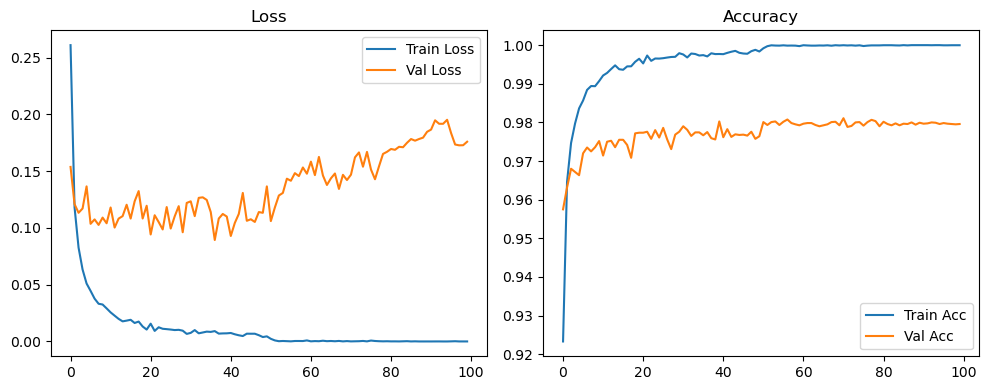

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2768, Acc: 0.9186 | Val Loss: 0.1903, Acc: 0.9471


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1376, Acc: 0.9589 | Val Loss: 0.1178, Acc: 0.9647


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1016, Acc: 0.9691 | Val Loss: 0.1227, Acc: 0.9642


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9741 | Val Loss: 0.1211, Acc: 0.9663


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0686, Acc: 0.9781 | Val Loss: 0.1096, Acc: 0.9682


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9813 | Val Loss: 0.1026, Acc: 0.9736


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9823 | Val Loss: 0.1007, Acc: 0.9733


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9856 | Val Loss: 0.1219, Acc: 0.9704


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9862 | Val Loss: 0.0922, Acc: 0.9772


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9870 | Val Loss: 0.1199, Acc: 0.9726


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9882 | Val Loss: 0.0999, Acc: 0.9762


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9889 | Val Loss: 0.1094, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9888 | Val Loss: 0.1180, Acc: 0.9714


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.1039, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9909 | Val Loss: 0.0910, Acc: 0.9780


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.0916, Acc: 0.9782


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.0981, Acc: 0.9763


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9920 | Val Loss: 0.0934, Acc: 0.9750


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.0981, Acc: 0.9776


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9943 | Val Loss: 0.0955, Acc: 0.9787


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0950, Acc: 0.9788


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9935 | Val Loss: 0.0955, Acc: 0.9776


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0886, Acc: 0.9772


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9943 | Val Loss: 0.0787, Acc: 0.9792


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.1068, Acc: 0.9772


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.1008, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.0850, Acc: 0.9775


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0811, Acc: 0.9771


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1062, Acc: 0.9794


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.0884, Acc: 0.9803


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.1091, Acc: 0.9771


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.0905, Acc: 0.9812


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.0913, Acc: 0.9778


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0955, Acc: 0.9790


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0885, Acc: 0.9773


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.0959, Acc: 0.9796


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0977, Acc: 0.9797


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9957 | Val Loss: 0.0778, Acc: 0.9769


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0803, Acc: 0.9788


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.1122, Acc: 0.9798


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0967, Acc: 0.9785


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0957, Acc: 0.9781


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0835, Acc: 0.9803


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1096, Acc: 0.9792


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0944, Acc: 0.9788


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1021, Acc: 0.9805


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0994, Acc: 0.9783


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.0787, Acc: 0.9781


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0860, Acc: 0.9802


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1083, Acc: 0.9791


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0983, Acc: 0.9816


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0963, Acc: 0.9818


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1001, Acc: 0.9817


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0952, Acc: 0.9809


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1051, Acc: 0.9821


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.1035, Acc: 0.9816


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1023, Acc: 0.9817


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1194, Acc: 0.9817


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1146, Acc: 0.9828


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1053, Acc: 0.9816


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1143, Acc: 0.9816


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1130, Acc: 0.9816


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1060, Acc: 0.9826


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1179, Acc: 0.9828


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1205, Acc: 0.9835


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1215, Acc: 0.9822


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1252, Acc: 0.9822


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1000, Acc: 0.9828


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1238, Acc: 0.9821


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1101, Acc: 0.9828


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0993, Acc: 0.9828


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0937, Acc: 0.9832


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1219, Acc: 0.9825


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1242, Acc: 0.9828


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1173, Acc: 0.9832


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1229, Acc: 0.9822


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1058, Acc: 0.9832


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1084, Acc: 0.9832


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1089, Acc: 0.9822


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1265, Acc: 0.9828


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1238, Acc: 0.9832


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1223, Acc: 0.9831


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1183, Acc: 0.9822


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1266, Acc: 0.9821


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1346, Acc: 0.9827


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1288, Acc: 0.9826


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1194, Acc: 0.9830


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1169, Acc: 0.9830


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1162, Acc: 0.9828


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1212, Acc: 0.9824


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1208, Acc: 0.9822


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1266, Acc: 0.9831


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1107, Acc: 0.9827


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1066, Acc: 0.9825


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1159, Acc: 0.9829


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1201, Acc: 0.9829


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1137, Acc: 0.9828


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1168, Acc: 0.9824


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1196, Acc: 0.9822


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1345, Acc: 0.9825


Final Test Loss: 0.1198 Accuracy: 0.9850


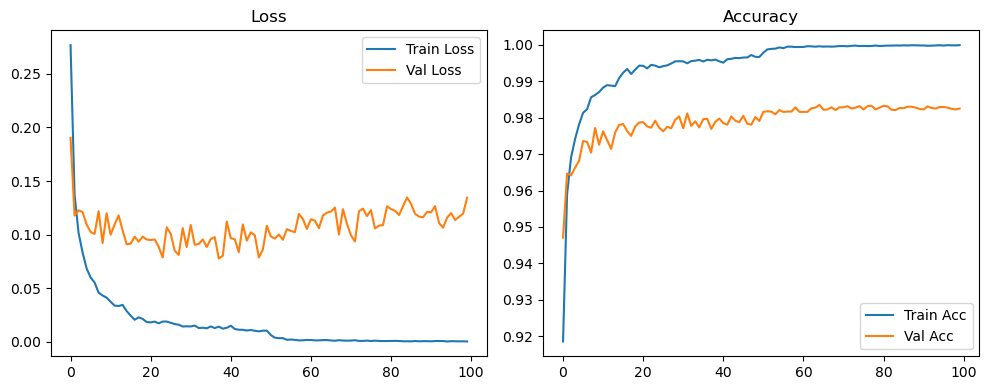

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3549, Acc: 0.8973 | Val Loss: 0.1782, Acc: 0.9493


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1971, Acc: 0.9420 | Val Loss: 0.1303, Acc: 0.9603


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1587, Acc: 0.9523 | Val Loss: 0.1274, Acc: 0.9630


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1353, Acc: 0.9594 | Val Loss: 0.1095, Acc: 0.9683


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1210, Acc: 0.9635 | Val Loss: 0.1033, Acc: 0.9691


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1113, Acc: 0.9659 | Val Loss: 0.1047, Acc: 0.9708


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1022, Acc: 0.9689 | Val Loss: 0.0974, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9721 | Val Loss: 0.1023, Acc: 0.9712


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0905, Acc: 0.9713 | Val Loss: 0.0941, Acc: 0.9742


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0820, Acc: 0.9747 | Val Loss: 0.0923, Acc: 0.9764


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9745 | Val Loss: 0.0948, Acc: 0.9732


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9762 | Val Loss: 0.0974, Acc: 0.9749


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9768 | Val Loss: 0.0945, Acc: 0.9761


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9787 | Val Loss: 0.0905, Acc: 0.9761


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0667, Acc: 0.9793 | Val Loss: 0.0902, Acc: 0.9764


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9805 | Val Loss: 0.0893, Acc: 0.9752


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9817 | Val Loss: 0.0914, Acc: 0.9772


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9813 | Val Loss: 0.0854, Acc: 0.9788


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9826 | Val Loss: 0.0893, Acc: 0.9783


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9830 | Val Loss: 0.0797, Acc: 0.9800


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9825 | Val Loss: 0.0857, Acc: 0.9790


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9849 | Val Loss: 0.0896, Acc: 0.9788


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9854 | Val Loss: 0.0858, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9850 | Val Loss: 0.0869, Acc: 0.9797


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9861 | Val Loss: 0.0977, Acc: 0.9784


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9861 | Val Loss: 0.0931, Acc: 0.9796


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9862 | Val Loss: 0.0931, Acc: 0.9789


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9869 | Val Loss: 0.0927, Acc: 0.9787


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9878 | Val Loss: 0.0939, Acc: 0.9792


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9880 | Val Loss: 0.0824, Acc: 0.9791


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9898 | Val Loss: 0.0962, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9900 | Val Loss: 0.0906, Acc: 0.9798


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.0791, Acc: 0.9810


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9901 | Val Loss: 0.0968, Acc: 0.9807


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.0907, Acc: 0.9784


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9896 | Val Loss: 0.0880, Acc: 0.9791


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9902 | Val Loss: 0.0992, Acc: 0.9791


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9896 | Val Loss: 0.0820, Acc: 0.9809


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9903 | Val Loss: 0.0914, Acc: 0.9800


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9899 | Val Loss: 0.0897, Acc: 0.9784


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9898 | Val Loss: 0.0983, Acc: 0.9793


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9897 | Val Loss: 0.0879, Acc: 0.9787


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.0841, Acc: 0.9798


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9906 | Val Loss: 0.0890, Acc: 0.9796


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9905 | Val Loss: 0.1008, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9907 | Val Loss: 0.0961, Acc: 0.9796


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9915 | Val Loss: 0.0764, Acc: 0.9799


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.0899, Acc: 0.9798


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.0941, Acc: 0.9793


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.0776, Acc: 0.9801


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.0816, Acc: 0.9815


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.0933, Acc: 0.9814


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0863, Acc: 0.9819


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0839, Acc: 0.9819


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.0899, Acc: 0.9818


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0932, Acc: 0.9822


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0934, Acc: 0.9822


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0897, Acc: 0.9817


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0888, Acc: 0.9819


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0918, Acc: 0.9825


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.0955, Acc: 0.9822


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0992, Acc: 0.9827


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0922, Acc: 0.9824


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0930, Acc: 0.9825


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0918, Acc: 0.9829


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0949, Acc: 0.9830


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0962, Acc: 0.9820


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0909, Acc: 0.9830


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0919, Acc: 0.9828


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1047, Acc: 0.9826


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0957, Acc: 0.9826


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1034, Acc: 0.9828


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0935, Acc: 0.9832


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0990, Acc: 0.9826


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1013, Acc: 0.9831


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0981, Acc: 0.9838


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0825, Acc: 0.9837


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0836, Acc: 0.9839


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0864, Acc: 0.9831


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0989, Acc: 0.9827


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0998, Acc: 0.9833


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1020, Acc: 0.9833


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0998, Acc: 0.9833


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0943, Acc: 0.9838


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0991, Acc: 0.9830


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0991, Acc: 0.9836


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1054, Acc: 0.9836


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1056, Acc: 0.9833


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0998, Acc: 0.9831


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1062, Acc: 0.9832


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0993, Acc: 0.9830


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0917, Acc: 0.9829


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0982, Acc: 0.9835


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1054, Acc: 0.9832


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1060, Acc: 0.9828


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0911, Acc: 0.9834


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0958, Acc: 0.9835


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1028, Acc: 0.9833


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1120, Acc: 0.9832


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1112, Acc: 0.9831


Final Test Loss: 0.0998 Accuracy: 0.9835


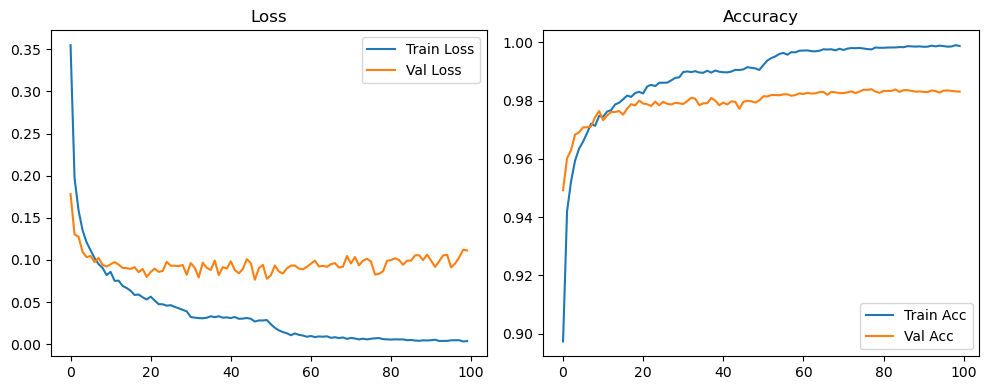

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2444, Acc: 0.9255 | Val Loss: 0.1542, Acc: 0.9553


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1138, Acc: 0.9650 | Val Loss: 0.1096, Acc: 0.9658


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0793, Acc: 0.9757 | Val Loss: 0.1054, Acc: 0.9701


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0569, Acc: 0.9823 | Val Loss: 0.1003, Acc: 0.9722


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9857 | Val Loss: 0.1068, Acc: 0.9718


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9876 | Val Loss: 0.1179, Acc: 0.9711


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9892 | Val Loss: 0.0871, Acc: 0.9770


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.1033, Acc: 0.9742


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.1089, Acc: 0.9745


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.1149, Acc: 0.9727


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.1294, Acc: 0.9688


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.1070, Acc: 0.9768


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9950 | Val Loss: 0.1175, Acc: 0.9737


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.1078, Acc: 0.9742


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.1237, Acc: 0.9748


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.1169, Acc: 0.9752


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1134, Acc: 0.9758


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9958 | Val Loss: 0.1283, Acc: 0.9749


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9955 | Val Loss: 0.1098, Acc: 0.9781


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.1075, Acc: 0.9778


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.1171, Acc: 0.9777


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1297, Acc: 0.9762


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.1109, Acc: 0.9789


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1105, Acc: 0.9783


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1118, Acc: 0.9784


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1149, Acc: 0.9779


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1203, Acc: 0.9749


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1344, Acc: 0.9752


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1042, Acc: 0.9782


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1037, Acc: 0.9791


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.1130, Acc: 0.9783


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1088, Acc: 0.9765


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1100, Acc: 0.9773


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1087, Acc: 0.9797


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1030, Acc: 0.9791


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.0932, Acc: 0.9788


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1037, Acc: 0.9798


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1050, Acc: 0.9779


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1044, Acc: 0.9778


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1200, Acc: 0.9762


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1159, Acc: 0.9790


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1132, Acc: 0.9788


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1086, Acc: 0.9784


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1102, Acc: 0.9773


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0820, Acc: 0.9809


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0978, Acc: 0.9794


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1171, Acc: 0.9770


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1007, Acc: 0.9788


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0997, Acc: 0.9788


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1063, Acc: 0.9776


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1185, Acc: 0.9793


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1014, Acc: 0.9792


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.1010, Acc: 0.9793


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1002, Acc: 0.9808


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1190, Acc: 0.9785


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1189, Acc: 0.9792


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1105, Acc: 0.9798


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1109, Acc: 0.9802


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1264, Acc: 0.9744


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1137, Acc: 0.9800


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1246, Acc: 0.9799


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1193, Acc: 0.9793


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1209, Acc: 0.9792


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1014, Acc: 0.9790


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1085, Acc: 0.9775


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1427, Acc: 0.9771


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1137, Acc: 0.9788


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1266, Acc: 0.9798


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1061, Acc: 0.9786


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1205, Acc: 0.9779


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1210, Acc: 0.9791


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1327, Acc: 0.9773


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1062, Acc: 0.9783


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0975, Acc: 0.9786


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1152, Acc: 0.9816


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1102, Acc: 0.9791


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1333, Acc: 0.9784


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1178, Acc: 0.9781


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1133, Acc: 0.9802


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1248, Acc: 0.9788


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1175, Acc: 0.9807


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1213, Acc: 0.9787


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1092, Acc: 0.9796


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1244, Acc: 0.9794


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1136, Acc: 0.9783


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1108, Acc: 0.9777


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1483, Acc: 0.9783


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1369, Acc: 0.9790


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1252, Acc: 0.9774


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1188, Acc: 0.9795


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1208, Acc: 0.9806


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1475, Acc: 0.9771


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1319, Acc: 0.9781


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1257, Acc: 0.9780


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1313, Acc: 0.9796


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0877, Acc: 0.9800


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1401, Acc: 0.9804


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1532, Acc: 0.9778


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1244, Acc: 0.9780


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1215, Acc: 0.9774


Final Test Loss: 0.1165 Accuracy: 0.9782


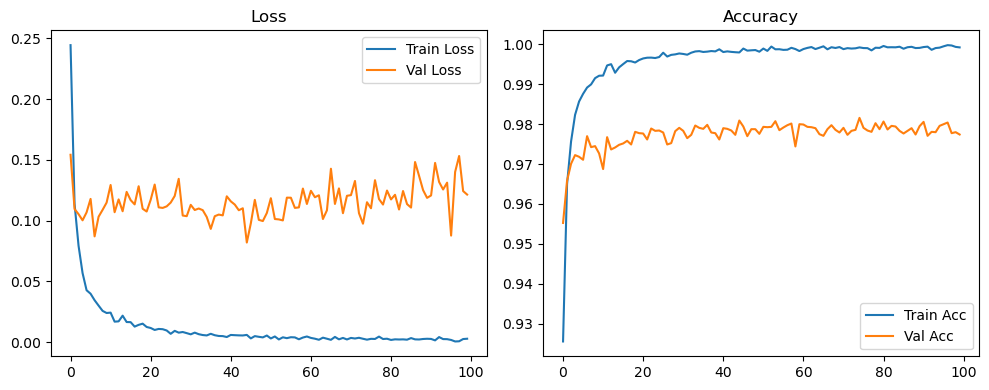

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2590, Acc: 0.9223 | Val Loss: 0.1769, Acc: 0.9494


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1316, Acc: 0.9602 | Val Loss: 0.1216, Acc: 0.9639


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0938, Acc: 0.9717 | Val Loss: 0.1158, Acc: 0.9657


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0754, Acc: 0.9765 | Val Loss: 0.1204, Acc: 0.9656


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0568, Acc: 0.9817 | Val Loss: 0.1105, Acc: 0.9702


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9823 | Val Loss: 0.1043, Acc: 0.9725


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9840 | Val Loss: 0.0970, Acc: 0.9748


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0408, Acc: 0.9868 | Val Loss: 0.1133, Acc: 0.9708


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9890 | Val Loss: 0.0936, Acc: 0.9770


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.1061, Acc: 0.9748


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9897 | Val Loss: 0.1066, Acc: 0.9750


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9911 | Val Loss: 0.1095, Acc: 0.9755


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9898 | Val Loss: 0.0941, Acc: 0.9762


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9913 | Val Loss: 0.0970, Acc: 0.9758


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9932 | Val Loss: 0.0963, Acc: 0.9769


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.1009, Acc: 0.9767


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.1012, Acc: 0.9768


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9935 | Val Loss: 0.1154, Acc: 0.9750


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9938 | Val Loss: 0.0964, Acc: 0.9783


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.1050, Acc: 0.9752


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.1044, Acc: 0.9771


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.1154, Acc: 0.9742


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1024, Acc: 0.9774


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1066, Acc: 0.9776


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.1152, Acc: 0.9772


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9950 | Val Loss: 0.1112, Acc: 0.9779


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1049, Acc: 0.9774


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9955 | Val Loss: 0.1026, Acc: 0.9789


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.1022, Acc: 0.9800


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9958 | Val Loss: 0.1020, Acc: 0.9792


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1013, Acc: 0.9799


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1161, Acc: 0.9777


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0993, Acc: 0.9803


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1074, Acc: 0.9781


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1200, Acc: 0.9772


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9962 | Val Loss: 0.1034, Acc: 0.9796


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1109, Acc: 0.9788


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1020, Acc: 0.9786


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1115, Acc: 0.9788


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1028, Acc: 0.9806


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1160, Acc: 0.9785


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1146, Acc: 0.9780


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.1100, Acc: 0.9794


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1127, Acc: 0.9783


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1131, Acc: 0.9790


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1092, Acc: 0.9790


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1090, Acc: 0.9798


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1108, Acc: 0.9804


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1072, Acc: 0.9801


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1069, Acc: 0.9802


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1270, Acc: 0.9805


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9978 | Val Loss: 0.1159, Acc: 0.9784


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1108, Acc: 0.9805


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1169, Acc: 0.9790


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.1053, Acc: 0.9818


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1155, Acc: 0.9792


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1337, Acc: 0.9786


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9971 | Val Loss: 0.1118, Acc: 0.9788


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.1068, Acc: 0.9806


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1062, Acc: 0.9792


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1075, Acc: 0.9812


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1146, Acc: 0.9798


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1143, Acc: 0.9797


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1097, Acc: 0.9802


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1226, Acc: 0.9800


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1281, Acc: 0.9792


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1248, Acc: 0.9791


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1190, Acc: 0.9802


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1339, Acc: 0.9778


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1237, Acc: 0.9796


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1231, Acc: 0.9808


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1236, Acc: 0.9801


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1253, Acc: 0.9808


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1142, Acc: 0.9796


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1181, Acc: 0.9812


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1141, Acc: 0.9812


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1068, Acc: 0.9808


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1162, Acc: 0.9818


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9983 | Val Loss: 0.0992, Acc: 0.9826


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1273, Acc: 0.9805


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1106, Acc: 0.9816


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1240, Acc: 0.9802


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9978 | Val Loss: 0.1080, Acc: 0.9811


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1136, Acc: 0.9806


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1193, Acc: 0.9807


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1273, Acc: 0.9797


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1252, Acc: 0.9804


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1240, Acc: 0.9806


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1121, Acc: 0.9812


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1323, Acc: 0.9812


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1179, Acc: 0.9819


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1344, Acc: 0.9807


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1308, Acc: 0.9796


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1287, Acc: 0.9810


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1279, Acc: 0.9793


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1253, Acc: 0.9822


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1123, Acc: 0.9816


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1179, Acc: 0.9818


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1221, Acc: 0.9818


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1296, Acc: 0.9812


Final Test Loss: 0.1167 Accuracy: 0.9820


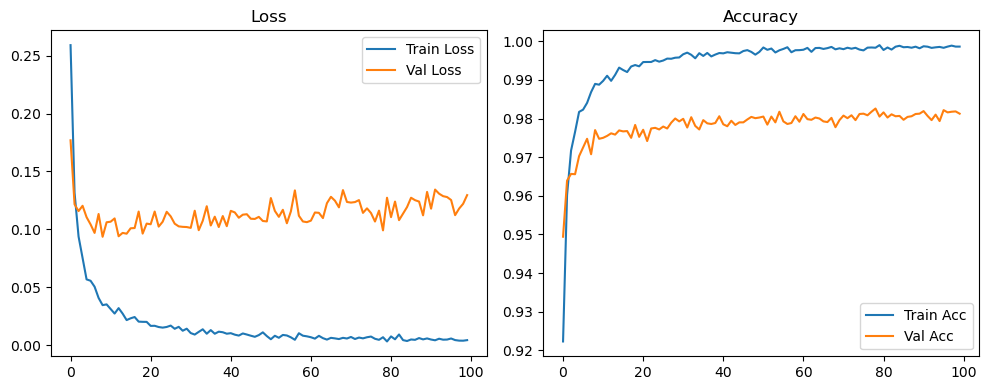

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3263, Acc: 0.9014 | Val Loss: 0.1639, Acc: 0.9527


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1888, Acc: 0.9439 | Val Loss: 0.1243, Acc: 0.9639


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1454, Acc: 0.9563 | Val Loss: 0.1144, Acc: 0.9663


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1238, Acc: 0.9621 | Val Loss: 0.1007, Acc: 0.9712


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1092, Acc: 0.9664 | Val Loss: 0.0938, Acc: 0.9728


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0956, Acc: 0.9699 | Val Loss: 0.0926, Acc: 0.9725


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0887, Acc: 0.9721 | Val Loss: 0.0941, Acc: 0.9730


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0833, Acc: 0.9735 | Val Loss: 0.0934, Acc: 0.9722


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0779, Acc: 0.9756 | Val Loss: 0.0843, Acc: 0.9767


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0706, Acc: 0.9784 | Val Loss: 0.0848, Acc: 0.9759


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0698, Acc: 0.9782 | Val Loss: 0.0859, Acc: 0.9761


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9804 | Val Loss: 0.0838, Acc: 0.9758


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0608, Acc: 0.9810 | Val Loss: 0.0936, Acc: 0.9748


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0593, Acc: 0.9811 | Val Loss: 0.0786, Acc: 0.9778


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0568, Acc: 0.9821 | Val Loss: 0.0872, Acc: 0.9773


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9835 | Val Loss: 0.0817, Acc: 0.9775


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9842 | Val Loss: 0.0840, Acc: 0.9788


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9845 | Val Loss: 0.0799, Acc: 0.9782


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9851 | Val Loss: 0.0875, Acc: 0.9766


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9853 | Val Loss: 0.0874, Acc: 0.9797


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9862 | Val Loss: 0.0887, Acc: 0.9781


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.0888, Acc: 0.9793


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9876 | Val Loss: 0.0801, Acc: 0.9808


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9884 | Val Loss: 0.0830, Acc: 0.9789


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9879 | Val Loss: 0.0836, Acc: 0.9799


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9893 | Val Loss: 0.0842, Acc: 0.9793


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9888 | Val Loss: 0.0888, Acc: 0.9807


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 0.0889, Acc: 0.9799


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.0895, Acc: 0.9788


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.0868, Acc: 0.9802


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9908 | Val Loss: 0.0913, Acc: 0.9800


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 0.0924, Acc: 0.9795


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 0.0883, Acc: 0.9804


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9908 | Val Loss: 0.1011, Acc: 0.9782


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9915 | Val Loss: 0.0891, Acc: 0.9797


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.0910, Acc: 0.9799


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.0979, Acc: 0.9794


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9913 | Val Loss: 0.0887, Acc: 0.9808


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9923 | Val Loss: 0.0917, Acc: 0.9809


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9910 | Val Loss: 0.0875, Acc: 0.9800


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9935 | Val Loss: 0.1020, Acc: 0.9798


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9928 | Val Loss: 0.1007, Acc: 0.9801


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9926 | Val Loss: 0.0927, Acc: 0.9809


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9919 | Val Loss: 0.0893, Acc: 0.9812


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.0859, Acc: 0.9821


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1016, Acc: 0.9810


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9921 | Val Loss: 0.0943, Acc: 0.9803


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.0956, Acc: 0.9791


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9932 | Val Loss: 0.0915, Acc: 0.9805


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9932 | Val Loss: 0.0942, Acc: 0.9822


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.0862, Acc: 0.9827


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9941 | Val Loss: 0.0924, Acc: 0.9809


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0909, Acc: 0.9807


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9927 | Val Loss: 0.0893, Acc: 0.9825


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9942 | Val Loss: 0.0913, Acc: 0.9822


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9937 | Val Loss: 0.0981, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9940 | Val Loss: 0.0867, Acc: 0.9820


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.0898, Acc: 0.9821


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0980, Acc: 0.9804


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9948 | Val Loss: 0.0953, Acc: 0.9807


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9945 | Val Loss: 0.0949, Acc: 0.9818


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9942 | Val Loss: 0.1027, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.0991, Acc: 0.9812


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9936 | Val Loss: 0.0921, Acc: 0.9807


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9946 | Val Loss: 0.0968, Acc: 0.9808


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1030, Acc: 0.9808


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9951 | Val Loss: 0.1033, Acc: 0.9818


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9944 | Val Loss: 0.0925, Acc: 0.9815


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.0958, Acc: 0.9818


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9953 | Val Loss: 0.0962, Acc: 0.9816


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9943 | Val Loss: 0.0869, Acc: 0.9813


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.0939, Acc: 0.9825


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0929, Acc: 0.9814


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.0842, Acc: 0.9819


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0942, Acc: 0.9814


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.0981, Acc: 0.9808


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9956 | Val Loss: 0.0847, Acc: 0.9819


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.0939, Acc: 0.9810


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.0892, Acc: 0.9806


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.0822, Acc: 0.9819


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0845, Acc: 0.9822


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0834, Acc: 0.9825


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.0907, Acc: 0.9811


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.0827, Acc: 0.9826


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0754, Acc: 0.9822


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0907, Acc: 0.9824


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.0894, Acc: 0.9808


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0998, Acc: 0.9812


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.0890, Acc: 0.9812


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0836, Acc: 0.9814


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0797, Acc: 0.9818


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0731, Acc: 0.9824


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0844, Acc: 0.9814


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0802, Acc: 0.9817


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0856, Acc: 0.9814


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.0864, Acc: 0.9816


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.0853, Acc: 0.9807


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.0961, Acc: 0.9820


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0817, Acc: 0.9806


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.0871, Acc: 0.9802


Final Test Loss: 0.0856 Accuracy: 0.9827


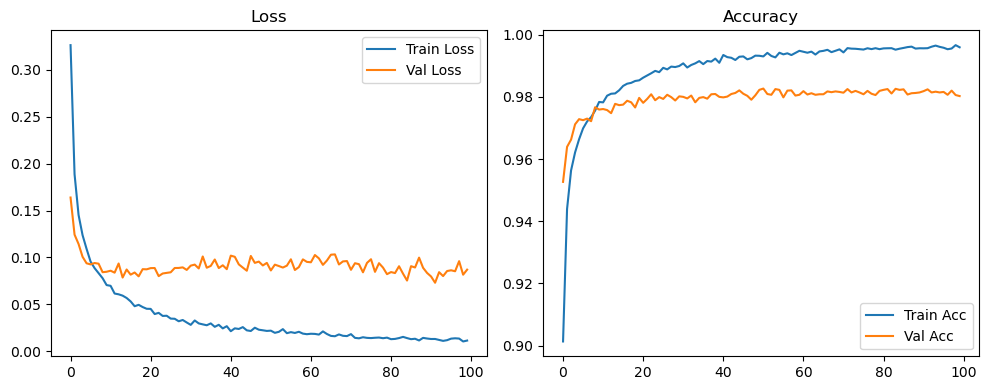

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2444, Acc: 0.9255 | Val Loss: 0.1542, Acc: 0.9553


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1138, Acc: 0.9650 | Val Loss: 0.1096, Acc: 0.9658


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0793, Acc: 0.9757 | Val Loss: 0.1054, Acc: 0.9701


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0569, Acc: 0.9823 | Val Loss: 0.1003, Acc: 0.9722


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9857 | Val Loss: 0.1068, Acc: 0.9718


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9876 | Val Loss: 0.1179, Acc: 0.9711


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9892 | Val Loss: 0.0871, Acc: 0.9770


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.1033, Acc: 0.9742


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.1089, Acc: 0.9745


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.1149, Acc: 0.9727


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.1294, Acc: 0.9688


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.1070, Acc: 0.9768


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9950 | Val Loss: 0.1175, Acc: 0.9737


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.1078, Acc: 0.9742


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.1237, Acc: 0.9748


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.1169, Acc: 0.9752


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1134, Acc: 0.9758


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9958 | Val Loss: 0.1283, Acc: 0.9749


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9955 | Val Loss: 0.1098, Acc: 0.9781


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.1075, Acc: 0.9778


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.1171, Acc: 0.9777


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1297, Acc: 0.9762


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.1109, Acc: 0.9789


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1105, Acc: 0.9783


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1118, Acc: 0.9784


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1149, Acc: 0.9779


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1203, Acc: 0.9749


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1344, Acc: 0.9752


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1042, Acc: 0.9782


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1037, Acc: 0.9791


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.1130, Acc: 0.9783


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1088, Acc: 0.9765


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1100, Acc: 0.9773


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1087, Acc: 0.9797


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1030, Acc: 0.9791


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.0932, Acc: 0.9788


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1037, Acc: 0.9798


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1050, Acc: 0.9779


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1044, Acc: 0.9778


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1200, Acc: 0.9762


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1159, Acc: 0.9790


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1132, Acc: 0.9788


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1086, Acc: 0.9784


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1102, Acc: 0.9773


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0820, Acc: 0.9809


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0978, Acc: 0.9794


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1171, Acc: 0.9770


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1007, Acc: 0.9788


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0997, Acc: 0.9788


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1063, Acc: 0.9776


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0998, Acc: 0.9812


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1107, Acc: 0.9812


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1149, Acc: 0.9822


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1189, Acc: 0.9816


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1165, Acc: 0.9815


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1184, Acc: 0.9820


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1132, Acc: 0.9817


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1170, Acc: 0.9810


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1207, Acc: 0.9822


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1274, Acc: 0.9804


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1221, Acc: 0.9809


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1133, Acc: 0.9809


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1285, Acc: 0.9805


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1081, Acc: 0.9802


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1057, Acc: 0.9819


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1043, Acc: 0.9830


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1047, Acc: 0.9810


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1136, Acc: 0.9811


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1196, Acc: 0.9821


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1141, Acc: 0.9820


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1093, Acc: 0.9808


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1163, Acc: 0.9812


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1282, Acc: 0.9801


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1254, Acc: 0.9792


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1093, Acc: 0.9811


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1107, Acc: 0.9808


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1113, Acc: 0.9809


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1250, Acc: 0.9790


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1169, Acc: 0.9811


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1219, Acc: 0.9808


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1208, Acc: 0.9814


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1183, Acc: 0.9820


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1241, Acc: 0.9821


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1263, Acc: 0.9823


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1281, Acc: 0.9817


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1332, Acc: 0.9820


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1343, Acc: 0.9816


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1348, Acc: 0.9816


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1354, Acc: 0.9814


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1380, Acc: 0.9813


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1380, Acc: 0.9818


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1500, Acc: 0.9809


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1442, Acc: 0.9812


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1471, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1482, Acc: 0.9821


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1482, Acc: 0.9816


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1602, Acc: 0.9813


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1581, Acc: 0.9816


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1565, Acc: 0.9822


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1561, Acc: 0.9810


Final Test Loss: 0.1452 Accuracy: 0.9822


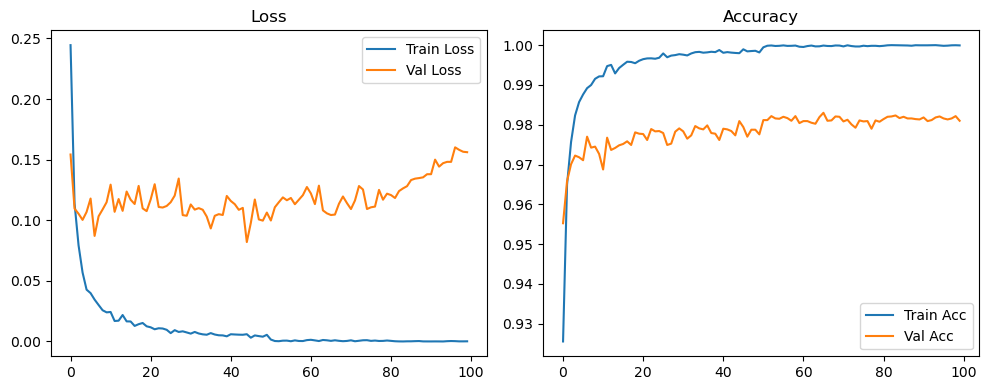

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2590, Acc: 0.9223 | Val Loss: 0.1769, Acc: 0.9494


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1316, Acc: 0.9602 | Val Loss: 0.1216, Acc: 0.9639


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0938, Acc: 0.9717 | Val Loss: 0.1158, Acc: 0.9657


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0754, Acc: 0.9765 | Val Loss: 0.1204, Acc: 0.9656


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0568, Acc: 0.9817 | Val Loss: 0.1105, Acc: 0.9702


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9823 | Val Loss: 0.1043, Acc: 0.9725


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9840 | Val Loss: 0.0970, Acc: 0.9748


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0408, Acc: 0.9868 | Val Loss: 0.1133, Acc: 0.9708


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9890 | Val Loss: 0.0936, Acc: 0.9770


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.1061, Acc: 0.9748


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9897 | Val Loss: 0.1066, Acc: 0.9750


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9911 | Val Loss: 0.1095, Acc: 0.9755


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9898 | Val Loss: 0.0941, Acc: 0.9762


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9913 | Val Loss: 0.0970, Acc: 0.9758


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9932 | Val Loss: 0.0963, Acc: 0.9769


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.1009, Acc: 0.9767


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.1012, Acc: 0.9768


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9935 | Val Loss: 0.1154, Acc: 0.9750


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9938 | Val Loss: 0.0964, Acc: 0.9783


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.1050, Acc: 0.9752


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.1044, Acc: 0.9771


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.1154, Acc: 0.9742


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1024, Acc: 0.9774


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1066, Acc: 0.9776


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.1152, Acc: 0.9772


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9950 | Val Loss: 0.1112, Acc: 0.9779


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1049, Acc: 0.9774


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9955 | Val Loss: 0.1026, Acc: 0.9789


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.1022, Acc: 0.9800


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9958 | Val Loss: 0.1020, Acc: 0.9792


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1013, Acc: 0.9799


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1161, Acc: 0.9777


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0993, Acc: 0.9803


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1074, Acc: 0.9781


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1200, Acc: 0.9772


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9962 | Val Loss: 0.1034, Acc: 0.9796


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1109, Acc: 0.9788


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1020, Acc: 0.9786


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1115, Acc: 0.9788


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1028, Acc: 0.9806


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1160, Acc: 0.9785


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1146, Acc: 0.9780


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.1100, Acc: 0.9794


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1127, Acc: 0.9783


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1131, Acc: 0.9790


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1092, Acc: 0.9790


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1090, Acc: 0.9798


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1108, Acc: 0.9804


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1072, Acc: 0.9801


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1069, Acc: 0.9802


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0968, Acc: 0.9823


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0967, Acc: 0.9836


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0943, Acc: 0.9835


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0966, Acc: 0.9842


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0999, Acc: 0.9842


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1011, Acc: 0.9834


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1029, Acc: 0.9833


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1030, Acc: 0.9837


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1022, Acc: 0.9832


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1043, Acc: 0.9835


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1085, Acc: 0.9829


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1058, Acc: 0.9832


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1045, Acc: 0.9830


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1104, Acc: 0.9838


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1174, Acc: 0.9820


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1290, Acc: 0.9812


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1254, Acc: 0.9828


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1244, Acc: 0.9820


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1272, Acc: 0.9816


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1306, Acc: 0.9812


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1276, Acc: 0.9821


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1266, Acc: 0.9821


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1237, Acc: 0.9822


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1240, Acc: 0.9808


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1298, Acc: 0.9816


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1263, Acc: 0.9812


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1174, Acc: 0.9827


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1200, Acc: 0.9830


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1188, Acc: 0.9834


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1307, Acc: 0.9827


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1212, Acc: 0.9835


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1206, Acc: 0.9832


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1196, Acc: 0.9842


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1209, Acc: 0.9840


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1218, Acc: 0.9840


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1243, Acc: 0.9835


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1255, Acc: 0.9832


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1262, Acc: 0.9836


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1248, Acc: 0.9842


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1283, Acc: 0.9833


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1209, Acc: 0.9840


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1241, Acc: 0.9843


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1201, Acc: 0.9847


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1221, Acc: 0.9839


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1243, Acc: 0.9841


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1247, Acc: 0.9843


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1213, Acc: 0.9845


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1232, Acc: 0.9840


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1254, Acc: 0.9842


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1260, Acc: 0.9838


Final Test Loss: 0.1127 Accuracy: 0.9850


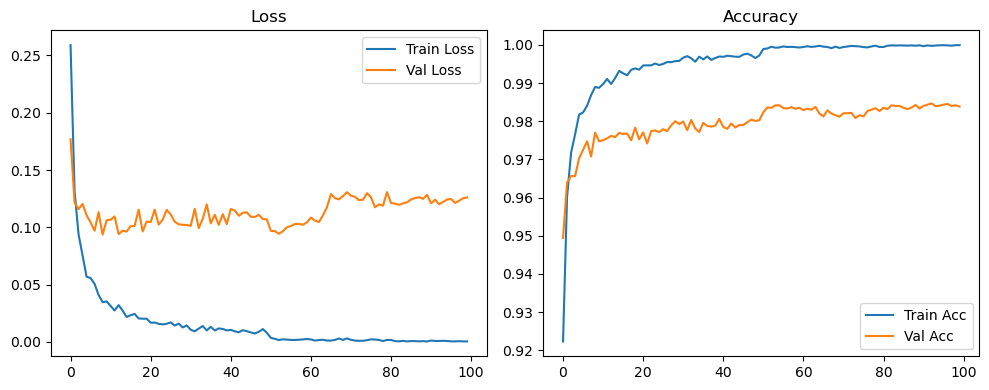

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3263, Acc: 0.9014 | Val Loss: 0.1639, Acc: 0.9527


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1888, Acc: 0.9439 | Val Loss: 0.1243, Acc: 0.9639


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1454, Acc: 0.9563 | Val Loss: 0.1144, Acc: 0.9663


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1238, Acc: 0.9621 | Val Loss: 0.1007, Acc: 0.9712


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1092, Acc: 0.9664 | Val Loss: 0.0938, Acc: 0.9728


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0956, Acc: 0.9699 | Val Loss: 0.0926, Acc: 0.9725


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0887, Acc: 0.9721 | Val Loss: 0.0941, Acc: 0.9730


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0833, Acc: 0.9735 | Val Loss: 0.0934, Acc: 0.9722


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0779, Acc: 0.9756 | Val Loss: 0.0843, Acc: 0.9767


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0706, Acc: 0.9784 | Val Loss: 0.0848, Acc: 0.9759


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0698, Acc: 0.9782 | Val Loss: 0.0859, Acc: 0.9761


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9804 | Val Loss: 0.0838, Acc: 0.9758


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0608, Acc: 0.9810 | Val Loss: 0.0936, Acc: 0.9748


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0593, Acc: 0.9811 | Val Loss: 0.0786, Acc: 0.9778


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0568, Acc: 0.9821 | Val Loss: 0.0872, Acc: 0.9773


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9835 | Val Loss: 0.0817, Acc: 0.9775


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9842 | Val Loss: 0.0840, Acc: 0.9788


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9845 | Val Loss: 0.0799, Acc: 0.9782


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9851 | Val Loss: 0.0875, Acc: 0.9766


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9853 | Val Loss: 0.0874, Acc: 0.9797


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9862 | Val Loss: 0.0887, Acc: 0.9781


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.0888, Acc: 0.9793


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9876 | Val Loss: 0.0801, Acc: 0.9808


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9884 | Val Loss: 0.0830, Acc: 0.9789


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9879 | Val Loss: 0.0836, Acc: 0.9799


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9893 | Val Loss: 0.0842, Acc: 0.9793


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9888 | Val Loss: 0.0888, Acc: 0.9807


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 0.0889, Acc: 0.9799


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.0895, Acc: 0.9788


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.0868, Acc: 0.9802


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9908 | Val Loss: 0.0913, Acc: 0.9800


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 0.0924, Acc: 0.9795


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 0.0883, Acc: 0.9804


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9908 | Val Loss: 0.1011, Acc: 0.9782


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9915 | Val Loss: 0.0891, Acc: 0.9797


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.0910, Acc: 0.9799


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.0979, Acc: 0.9794


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9913 | Val Loss: 0.0887, Acc: 0.9808


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9923 | Val Loss: 0.0917, Acc: 0.9809


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9910 | Val Loss: 0.0875, Acc: 0.9800


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9935 | Val Loss: 0.1020, Acc: 0.9798


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9928 | Val Loss: 0.1007, Acc: 0.9801


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9926 | Val Loss: 0.0927, Acc: 0.9809


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9919 | Val Loss: 0.0893, Acc: 0.9812


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.0859, Acc: 0.9821


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1016, Acc: 0.9810


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9921 | Val Loss: 0.0943, Acc: 0.9803


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.0956, Acc: 0.9791


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9932 | Val Loss: 0.0915, Acc: 0.9805


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9932 | Val Loss: 0.0942, Acc: 0.9822


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0834, Acc: 0.9828


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0869, Acc: 0.9828


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.0893, Acc: 0.9827


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.0881, Acc: 0.9837


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0902, Acc: 0.9828


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0885, Acc: 0.9835


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0927, Acc: 0.9826


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.0948, Acc: 0.9825


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0961, Acc: 0.9823


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0979, Acc: 0.9820


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0970, Acc: 0.9819


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1012, Acc: 0.9823


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1011, Acc: 0.9828


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1004, Acc: 0.9824


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1009, Acc: 0.9819


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1066, Acc: 0.9815


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1006, Acc: 0.9820


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0985, Acc: 0.9835


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0977, Acc: 0.9826


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0990, Acc: 0.9826


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1046, Acc: 0.9826


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1016, Acc: 0.9822


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1050, Acc: 0.9816


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1029, Acc: 0.9823


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9983 | Val Loss: 0.1070, Acc: 0.9829


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1077, Acc: 0.9819


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1047, Acc: 0.9816


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1073, Acc: 0.9826


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1091, Acc: 0.9817


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1098, Acc: 0.9832


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1111, Acc: 0.9829


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1049, Acc: 0.9833


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1084, Acc: 0.9827


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1061, Acc: 0.9834


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1052, Acc: 0.9830


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1064, Acc: 0.9838


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1085, Acc: 0.9831


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1048, Acc: 0.9831


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1067, Acc: 0.9832


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1077, Acc: 0.9823


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1066, Acc: 0.9835


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1099, Acc: 0.9838


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1061, Acc: 0.9832


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1084, Acc: 0.9833


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1076, Acc: 0.9832


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1096, Acc: 0.9836


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1077, Acc: 0.9828


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1104, Acc: 0.9835


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1092, Acc: 0.9830


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1067, Acc: 0.9836


Final Test Loss: 0.0998 Accuracy: 0.9856


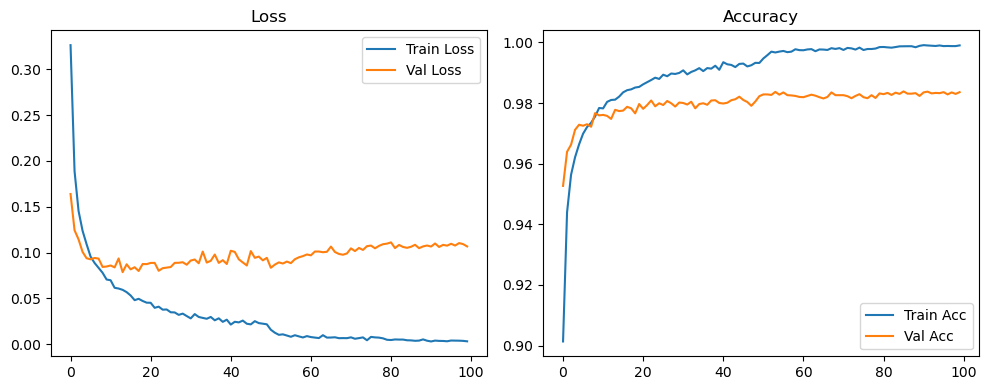

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2144, Acc: 0.9342 | Val Loss: 0.1466, Acc: 0.9573


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1029, Acc: 0.9675 | Val Loss: 0.1072, Acc: 0.9663


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0721, Acc: 0.9774 | Val Loss: 0.0987, Acc: 0.9709


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0482, Acc: 0.9848 | Val Loss: 0.0965, Acc: 0.9720


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9860 | Val Loss: 0.1058, Acc: 0.9720


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9882 | Val Loss: 0.1073, Acc: 0.9728


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.1060, Acc: 0.9722


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9929 | Val Loss: 0.1189, Acc: 0.9702


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.1035, Acc: 0.9760


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9936 | Val Loss: 0.1280, Acc: 0.9717


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.1051, Acc: 0.9767


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.1123, Acc: 0.9751


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9940 | Val Loss: 0.1191, Acc: 0.9751


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.1211, Acc: 0.9749


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.1149, Acc: 0.9762


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1106, Acc: 0.9775


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.1215, Acc: 0.9752


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9951 | Val Loss: 0.1071, Acc: 0.9772


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.1136, Acc: 0.9767


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9967 | Val Loss: 0.1087, Acc: 0.9782


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1150, Acc: 0.9755


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1153, Acc: 0.9764


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1288, Acc: 0.9752


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.1417, Acc: 0.9718


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9973 | Val Loss: 0.1161, Acc: 0.9775


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1161, Acc: 0.9782


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9980 | Val Loss: 0.1174, Acc: 0.9788


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1199, Acc: 0.9788


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1050, Acc: 0.9781


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1031, Acc: 0.9796


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1069, Acc: 0.9793


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1013, Acc: 0.9788


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1024, Acc: 0.9791


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1032, Acc: 0.9796


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1277, Acc: 0.9774


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1247, Acc: 0.9772


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1001, Acc: 0.9815


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1095, Acc: 0.9798


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1154, Acc: 0.9782


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1075, Acc: 0.9798


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1207, Acc: 0.9786


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1102, Acc: 0.9787


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1163, Acc: 0.9787


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1277, Acc: 0.9789


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1172, Acc: 0.9798


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1197, Acc: 0.9800


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1178, Acc: 0.9803


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1147, Acc: 0.9804


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1090, Acc: 0.9822


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1356, Acc: 0.9775


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.1155, Acc: 0.9782


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1186, Acc: 0.9795


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1043, Acc: 0.9814


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1130, Acc: 0.9800


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1245, Acc: 0.9779


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.1151, Acc: 0.9800


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1174, Acc: 0.9802


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1232, Acc: 0.9802


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.1474, Acc: 0.9754


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1261, Acc: 0.9789


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1179, Acc: 0.9793


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1219, Acc: 0.9782


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1082, Acc: 0.9805


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1071, Acc: 0.9813


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1170, Acc: 0.9807


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.1307, Acc: 0.9788


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1246, Acc: 0.9788


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1193, Acc: 0.9793


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1329, Acc: 0.9797


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1204, Acc: 0.9796


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1318, Acc: 0.9796


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1228, Acc: 0.9805


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1365, Acc: 0.9780


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1266, Acc: 0.9798


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1208, Acc: 0.9799


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1236, Acc: 0.9792


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1279, Acc: 0.9786


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1290, Acc: 0.9802


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1295, Acc: 0.9802


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1229, Acc: 0.9812


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1253, Acc: 0.9817


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1465, Acc: 0.9773


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1326, Acc: 0.9785


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1270, Acc: 0.9807


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1313, Acc: 0.9805


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1363, Acc: 0.9799


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1453, Acc: 0.9789


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1292, Acc: 0.9788


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1376, Acc: 0.9784


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1389, Acc: 0.9788


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1222, Acc: 0.9807


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1336, Acc: 0.9789


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1376, Acc: 0.9794


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1326, Acc: 0.9807


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1418, Acc: 0.9802


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1432, Acc: 0.9785


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1331, Acc: 0.9783


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1354, Acc: 0.9803


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1223, Acc: 0.9811


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1432, Acc: 0.9801


Final Test Loss: 0.1281 Accuracy: 0.9800


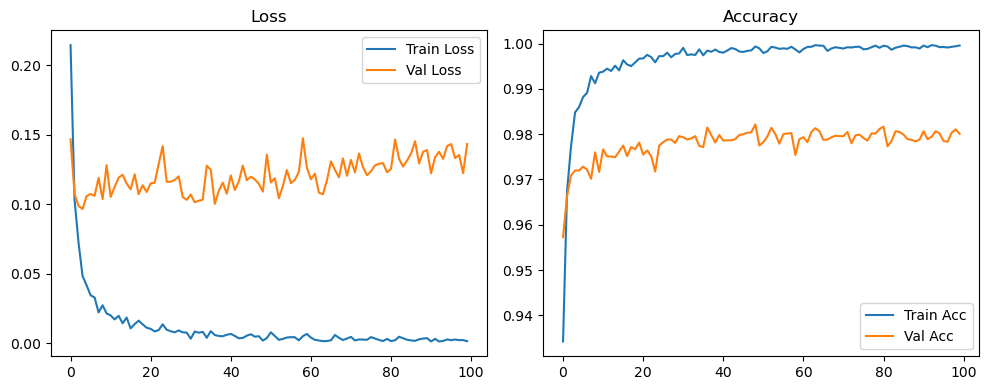

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2276, Acc: 0.9297 | Val Loss: 0.1502, Acc: 0.9552


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1180, Acc: 0.9632 | Val Loss: 0.1088, Acc: 0.9672


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0871, Acc: 0.9723 | Val Loss: 0.1099, Acc: 0.9676


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0703, Acc: 0.9774 | Val Loss: 0.1108, Acc: 0.9683


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9818 | Val Loss: 0.1002, Acc: 0.9718


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9848 | Val Loss: 0.1060, Acc: 0.9723


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0471, Acc: 0.9845 | Val Loss: 0.1000, Acc: 0.9726


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9882 | Val Loss: 0.1194, Acc: 0.9693


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9889 | Val Loss: 0.0966, Acc: 0.9756


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.1186, Acc: 0.9714


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.1114, Acc: 0.9746


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9904 | Val Loss: 0.1069, Acc: 0.9745


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9915 | Val Loss: 0.1059, Acc: 0.9769


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.1050, Acc: 0.9775


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.1304, Acc: 0.9717


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.1140, Acc: 0.9750


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9936 | Val Loss: 0.1090, Acc: 0.9766


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.1154, Acc: 0.9765


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.1183, Acc: 0.9748


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.1018, Acc: 0.9775


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.1108, Acc: 0.9765


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.1144, Acc: 0.9783


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1117, Acc: 0.9789


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.1167, Acc: 0.9774


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1176, Acc: 0.9778


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1049, Acc: 0.9800


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9959 | Val Loss: 0.1146, Acc: 0.9777


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.1054, Acc: 0.9785


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1021, Acc: 0.9784


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.1102, Acc: 0.9783


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1065, Acc: 0.9795


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1096, Acc: 0.9798


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1092, Acc: 0.9790


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.1102, Acc: 0.9785


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1095, Acc: 0.9792


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1122, Acc: 0.9782


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1110, Acc: 0.9802


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1060, Acc: 0.9799


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1116, Acc: 0.9783


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1028, Acc: 0.9789


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1095, Acc: 0.9791


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1150, Acc: 0.9805


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1082, Acc: 0.9808


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1109, Acc: 0.9791


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1203, Acc: 0.9787


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9973 | Val Loss: 0.1116, Acc: 0.9802


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1151, Acc: 0.9799


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1108, Acc: 0.9807


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1177, Acc: 0.9807


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1080, Acc: 0.9815


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1218, Acc: 0.9794


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1096, Acc: 0.9797


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1127, Acc: 0.9790


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1098, Acc: 0.9795


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1043, Acc: 0.9800


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1148, Acc: 0.9795


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1142, Acc: 0.9811


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1124, Acc: 0.9794


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1086, Acc: 0.9804


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1099, Acc: 0.9811


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1251, Acc: 0.9798


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1157, Acc: 0.9803


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1101, Acc: 0.9807


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1106, Acc: 0.9814


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.1243, Acc: 0.9797


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1052, Acc: 0.9800


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1110, Acc: 0.9809


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1155, Acc: 0.9808


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1085, Acc: 0.9809


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1184, Acc: 0.9812


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1201, Acc: 0.9798


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1149, Acc: 0.9807


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1116, Acc: 0.9825


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1089, Acc: 0.9812


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1132, Acc: 0.9809


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1133, Acc: 0.9805


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1196, Acc: 0.9802


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1323, Acc: 0.9792


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1267, Acc: 0.9804


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1190, Acc: 0.9812


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1209, Acc: 0.9802


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1350, Acc: 0.9803


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1271, Acc: 0.9802


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1168, Acc: 0.9821


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1214, Acc: 0.9820


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1215, Acc: 0.9818


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1267, Acc: 0.9806


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1301, Acc: 0.9810


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1190, Acc: 0.9812


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1245, Acc: 0.9812


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1240, Acc: 0.9803


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1236, Acc: 0.9810


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1226, Acc: 0.9808


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1260, Acc: 0.9817


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1378, Acc: 0.9803


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1238, Acc: 0.9817


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1198, Acc: 0.9822


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1395, Acc: 0.9800


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1296, Acc: 0.9818


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1403, Acc: 0.9808


Final Test Loss: 0.1195 Accuracy: 0.9833


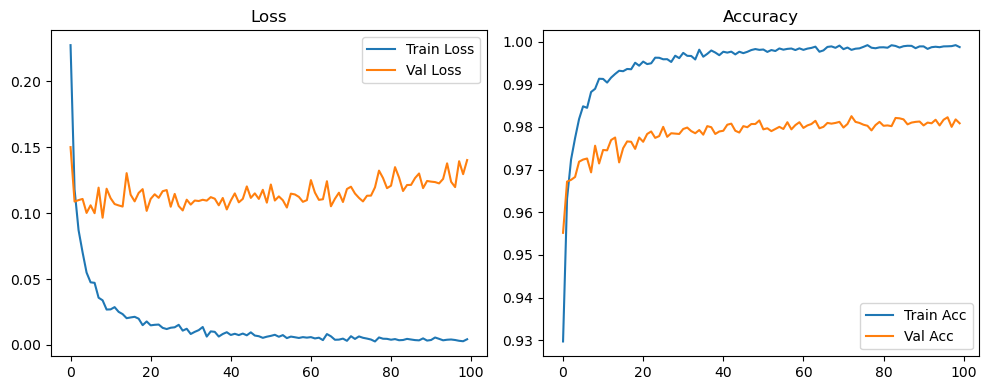

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2979, Acc: 0.9081 | Val Loss: 0.1592, Acc: 0.9525


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1770, Acc: 0.9458 | Val Loss: 0.1200, Acc: 0.9637


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1394, Acc: 0.9564 | Val Loss: 0.1134, Acc: 0.9657


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1187, Acc: 0.9621 | Val Loss: 0.1037, Acc: 0.9689


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1031, Acc: 0.9675 | Val Loss: 0.0980, Acc: 0.9712


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0891, Acc: 0.9718 | Val Loss: 0.0948, Acc: 0.9733


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0854, Acc: 0.9735 | Val Loss: 0.0851, Acc: 0.9749


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0785, Acc: 0.9755 | Val Loss: 0.0971, Acc: 0.9732


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0704, Acc: 0.9779 | Val Loss: 0.0830, Acc: 0.9762


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0621, Acc: 0.9801 | Val Loss: 0.0882, Acc: 0.9752


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0646, Acc: 0.9798 | Val Loss: 0.0902, Acc: 0.9753


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0560, Acc: 0.9817 | Val Loss: 0.0862, Acc: 0.9750


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0567, Acc: 0.9812 | Val Loss: 0.0894, Acc: 0.9776


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0560, Acc: 0.9813 | Val Loss: 0.0818, Acc: 0.9778


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.0823, Acc: 0.9788


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9861 | Val Loss: 0.0866, Acc: 0.9774


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9860 | Val Loss: 0.0827, Acc: 0.9782


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9872 | Val Loss: 0.0838, Acc: 0.9783


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9873 | Val Loss: 0.0865, Acc: 0.9768


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9865 | Val Loss: 0.0751, Acc: 0.9814


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9878 | Val Loss: 0.0806, Acc: 0.9794


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9888 | Val Loss: 0.0821, Acc: 0.9796


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9885 | Val Loss: 0.0758, Acc: 0.9800


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9896 | Val Loss: 0.0785, Acc: 0.9807


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9900 | Val Loss: 0.0855, Acc: 0.9802


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9897 | Val Loss: 0.0895, Acc: 0.9790


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9904 | Val Loss: 0.0880, Acc: 0.9796


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.0838, Acc: 0.9807


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9915 | Val Loss: 0.0821, Acc: 0.9813


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9916 | Val Loss: 0.0834, Acc: 0.9825


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.0848, Acc: 0.9797


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.0858, Acc: 0.9806


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.0832, Acc: 0.9818


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0889, Acc: 0.9792


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9915 | Val Loss: 0.0839, Acc: 0.9817


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9927 | Val Loss: 0.0891, Acc: 0.9805


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9928 | Val Loss: 0.0874, Acc: 0.9800


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.0828, Acc: 0.9811


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.0889, Acc: 0.9813


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.0821, Acc: 0.9823


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.0853, Acc: 0.9816


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0829, Acc: 0.9814


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.0846, Acc: 0.9821


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9939 | Val Loss: 0.0889, Acc: 0.9804


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.0835, Acc: 0.9804


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.0787, Acc: 0.9824


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9944 | Val Loss: 0.0877, Acc: 0.9815


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0860, Acc: 0.9817


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0889, Acc: 0.9802


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0940, Acc: 0.9805


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.0909, Acc: 0.9815


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0891, Acc: 0.9829


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.0918, Acc: 0.9807


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9949 | Val Loss: 0.0895, Acc: 0.9812


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.1016, Acc: 0.9792


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0980, Acc: 0.9798


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9948 | Val Loss: 0.0999, Acc: 0.9817


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0943, Acc: 0.9821


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.1025, Acc: 0.9798


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.0958, Acc: 0.9805


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9956 | Val Loss: 0.0927, Acc: 0.9799


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0925, Acc: 0.9810


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.0853, Acc: 0.9836


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9949 | Val Loss: 0.0895, Acc: 0.9806


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.0906, Acc: 0.9829


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.0998, Acc: 0.9810


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.0890, Acc: 0.9822


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.0932, Acc: 0.9822


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0938, Acc: 0.9813


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0987, Acc: 0.9805


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.0889, Acc: 0.9827


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.0966, Acc: 0.9815


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0922, Acc: 0.9825


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0962, Acc: 0.9816


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9967 | Val Loss: 0.0980, Acc: 0.9821


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1015, Acc: 0.9812


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0986, Acc: 0.9817


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.1045, Acc: 0.9812


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.0938, Acc: 0.9823


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.0975, Acc: 0.9826


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.0934, Acc: 0.9830


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0968, Acc: 0.9828


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1028, Acc: 0.9807


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0909, Acc: 0.9807


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0990, Acc: 0.9811


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0983, Acc: 0.9809


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0978, Acc: 0.9817


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0980, Acc: 0.9818


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9967 | Val Loss: 0.1007, Acc: 0.9812


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1002, Acc: 0.9812


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1021, Acc: 0.9806


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.0994, Acc: 0.9802


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0969, Acc: 0.9822


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.0997, Acc: 0.9818


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.0950, Acc: 0.9811


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1030, Acc: 0.9808


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.1044, Acc: 0.9802


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1093, Acc: 0.9807


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0966, Acc: 0.9817


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1074, Acc: 0.9820


Final Test Loss: 0.0894 Accuracy: 0.9845


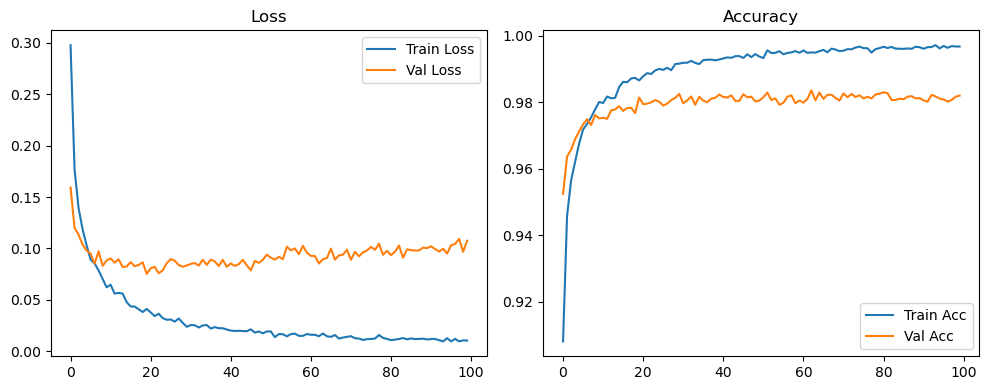

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1973, Acc: 0.9381 | Val Loss: 0.1198, Acc: 0.9635


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0895, Acc: 0.9711 | Val Loss: 0.1062, Acc: 0.9672


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0610, Acc: 0.9806 | Val Loss: 0.1018, Acc: 0.9693


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.1011, Acc: 0.9707


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9886 | Val Loss: 0.1181, Acc: 0.9677


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9904 | Val Loss: 0.1104, Acc: 0.9716


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.1106, Acc: 0.9710


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9928 | Val Loss: 0.1163, Acc: 0.9719


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9929 | Val Loss: 0.0956, Acc: 0.9762


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.1200, Acc: 0.9717


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9926 | Val Loss: 0.1084, Acc: 0.9750


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.0986, Acc: 0.9768


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.1244, Acc: 0.9725


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.1147, Acc: 0.9757


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.1085, Acc: 0.9758


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.0988, Acc: 0.9779


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1149, Acc: 0.9748


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.1208, Acc: 0.9748


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1197, Acc: 0.9743


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1337, Acc: 0.9735


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1216, Acc: 0.9752


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1117, Acc: 0.9768


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1156, Acc: 0.9783


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1164, Acc: 0.9767


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.1130, Acc: 0.9774


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1073, Acc: 0.9792


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1302, Acc: 0.9778


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1407, Acc: 0.9752


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1194, Acc: 0.9790


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1146, Acc: 0.9789


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1182, Acc: 0.9785


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.1210, Acc: 0.9784


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1182, Acc: 0.9774


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1273, Acc: 0.9772


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1264, Acc: 0.9769


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1292, Acc: 0.9757


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9982 | Val Loss: 0.1016, Acc: 0.9813


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1196, Acc: 0.9783


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1039, Acc: 0.9802


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9988 | Val Loss: 0.1080, Acc: 0.9794


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0970, Acc: 0.9829


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1090, Acc: 0.9799


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1094, Acc: 0.9813


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1199, Acc: 0.9797


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1312, Acc: 0.9773


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1067, Acc: 0.9813


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1234, Acc: 0.9802


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1266, Acc: 0.9779


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1070, Acc: 0.9812


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1254, Acc: 0.9789


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1257, Acc: 0.9762


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1325, Acc: 0.9785


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1255, Acc: 0.9807


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1291, Acc: 0.9794


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1167, Acc: 0.9808


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1161, Acc: 0.9805


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1268, Acc: 0.9793


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1382, Acc: 0.9779


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1291, Acc: 0.9770


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1317, Acc: 0.9778


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1108, Acc: 0.9802


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1100, Acc: 0.9809


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.1250, Acc: 0.9785


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1258, Acc: 0.9789


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1350, Acc: 0.9787


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1231, Acc: 0.9806


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1260, Acc: 0.9810


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9978 | Val Loss: 0.1354, Acc: 0.9778


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1235, Acc: 0.9810


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1209, Acc: 0.9802


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1317, Acc: 0.9808


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1259, Acc: 0.9798


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1299, Acc: 0.9801


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1463, Acc: 0.9770


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.1305, Acc: 0.9798


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1408, Acc: 0.9784


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1356, Acc: 0.9780


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1281, Acc: 0.9797


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1364, Acc: 0.9787


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1397, Acc: 0.9792


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1382, Acc: 0.9794


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1399, Acc: 0.9765


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1242, Acc: 0.9798


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1222, Acc: 0.9797


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9995 | Val Loss: 0.1251, Acc: 0.9803


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1356, Acc: 0.9797


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1218, Acc: 0.9806


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1267, Acc: 0.9802


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1300, Acc: 0.9795


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1345, Acc: 0.9794


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1266, Acc: 0.9812


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1242, Acc: 0.9800


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1501, Acc: 0.9773


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1312, Acc: 0.9798


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1461, Acc: 0.9780


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1474, Acc: 0.9782


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9991 | Val Loss: 0.1190, Acc: 0.9807


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1190, Acc: 0.9801


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1202, Acc: 0.9811


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1369, Acc: 0.9787


Final Test Loss: 0.1232 Accuracy: 0.9811


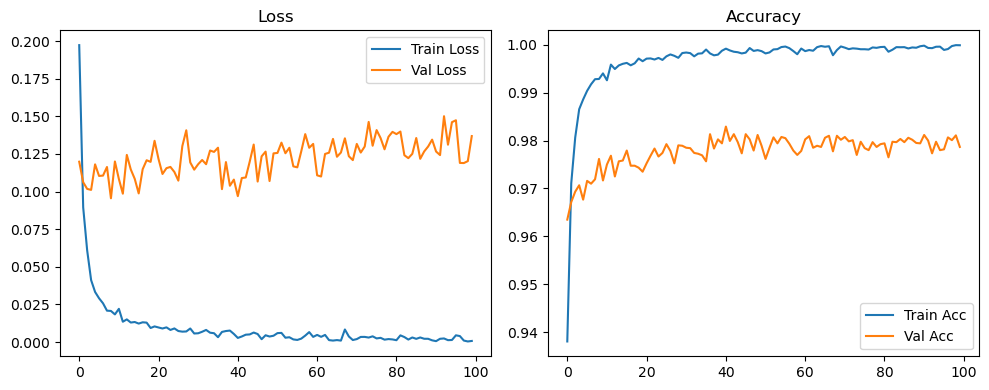

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2200, Acc: 0.9318 | Val Loss: 0.1255, Acc: 0.9609


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1075, Acc: 0.9660 | Val Loss: 0.1087, Acc: 0.9651


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0792, Acc: 0.9754 | Val Loss: 0.1041, Acc: 0.9693


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0622, Acc: 0.9801 | Val Loss: 0.1009, Acc: 0.9687


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9839 | Val Loss: 0.0992, Acc: 0.9710


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9861 | Val Loss: 0.1043, Acc: 0.9712


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9856 | Val Loss: 0.0971, Acc: 0.9735


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9889 | Val Loss: 0.0972, Acc: 0.9726


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9913 | Val Loss: 0.0869, Acc: 0.9782


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9900 | Val Loss: 0.1139, Acc: 0.9718


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.0983, Acc: 0.9751


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9918 | Val Loss: 0.1057, Acc: 0.9748


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9919 | Val Loss: 0.1048, Acc: 0.9747


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.1011, Acc: 0.9756


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.0985, Acc: 0.9775


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9945 | Val Loss: 0.1001, Acc: 0.9765


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.1058, Acc: 0.9759


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.1058, Acc: 0.9761


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.1058, Acc: 0.9762


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.1042, Acc: 0.9766


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9958 | Val Loss: 0.1001, Acc: 0.9768


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.1203, Acc: 0.9756


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1055, Acc: 0.9788


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.1043, Acc: 0.9779


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1067, Acc: 0.9786


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1058, Acc: 0.9787


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1179, Acc: 0.9784


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9968 | Val Loss: 0.1198, Acc: 0.9761


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1117, Acc: 0.9779


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1148, Acc: 0.9758


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1074, Acc: 0.9795


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.1109, Acc: 0.9784


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1049, Acc: 0.9802


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1125, Acc: 0.9774


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1145, Acc: 0.9776


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1147, Acc: 0.9774


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.1171, Acc: 0.9785


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1019, Acc: 0.9799


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1066, Acc: 0.9792


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1180, Acc: 0.9789


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.1106, Acc: 0.9785


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1089, Acc: 0.9784


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1249, Acc: 0.9780


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1219, Acc: 0.9782


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1261, Acc: 0.9779


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1182, Acc: 0.9802


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1273, Acc: 0.9796


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1185, Acc: 0.9788


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1124, Acc: 0.9805


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1305, Acc: 0.9799


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1083, Acc: 0.9805


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1244, Acc: 0.9797


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1126, Acc: 0.9808


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1164, Acc: 0.9798


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1185, Acc: 0.9798


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1102, Acc: 0.9806


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1078, Acc: 0.9816


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1148, Acc: 0.9806


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1084, Acc: 0.9806


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1215, Acc: 0.9792


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1176, Acc: 0.9807


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1173, Acc: 0.9782


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1190, Acc: 0.9807


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1159, Acc: 0.9808


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1176, Acc: 0.9818


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1227, Acc: 0.9810


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1196, Acc: 0.9798


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1152, Acc: 0.9804


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1116, Acc: 0.9813


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1257, Acc: 0.9787


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1112, Acc: 0.9828


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1247, Acc: 0.9794


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1142, Acc: 0.9802


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1121, Acc: 0.9808


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1226, Acc: 0.9814


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9987 | Val Loss: 0.1209, Acc: 0.9802


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1122, Acc: 0.9800


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1116, Acc: 0.9816


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1238, Acc: 0.9810


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1303, Acc: 0.9792


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1282, Acc: 0.9797


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1232, Acc: 0.9804


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1287, Acc: 0.9811


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1281, Acc: 0.9804


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1332, Acc: 0.9804


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1223, Acc: 0.9818


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1317, Acc: 0.9812


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1339, Acc: 0.9801


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1267, Acc: 0.9811


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9990 | Val Loss: 0.1301, Acc: 0.9802


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1203, Acc: 0.9811


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1315, Acc: 0.9797


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1237, Acc: 0.9814


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1260, Acc: 0.9800


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1256, Acc: 0.9803


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1195, Acc: 0.9816


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1179, Acc: 0.9813


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1307, Acc: 0.9805


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1281, Acc: 0.9811


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1348, Acc: 0.9796


Final Test Loss: 0.1112 Accuracy: 0.9814


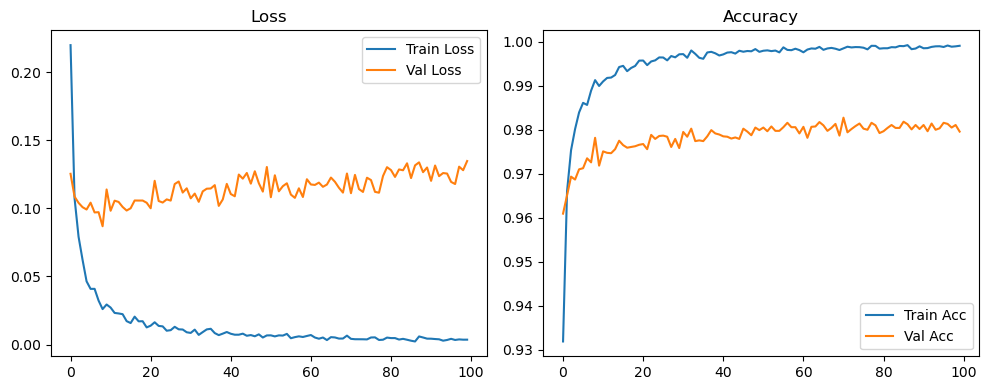

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3094, Acc: 0.9040 | Val Loss: 0.1410, Acc: 0.9567


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1659, Acc: 0.9487 | Val Loss: 0.1134, Acc: 0.9643


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1340, Acc: 0.9583 | Val Loss: 0.1077, Acc: 0.9668


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1125, Acc: 0.9637 | Val Loss: 0.1015, Acc: 0.9682


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1013, Acc: 0.9678 | Val Loss: 0.0927, Acc: 0.9699


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0855, Acc: 0.9721 | Val Loss: 0.0853, Acc: 0.9745


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0816, Acc: 0.9744 | Val Loss: 0.0844, Acc: 0.9748


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0719, Acc: 0.9772 | Val Loss: 0.0983, Acc: 0.9718


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0698, Acc: 0.9773 | Val Loss: 0.0844, Acc: 0.9758


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0629, Acc: 0.9795 | Val Loss: 0.0852, Acc: 0.9761


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0611, Acc: 0.9797 | Val Loss: 0.0870, Acc: 0.9765


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0529, Acc: 0.9826 | Val Loss: 0.0799, Acc: 0.9765


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0530, Acc: 0.9824 | Val Loss: 0.0819, Acc: 0.9775


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0487, Acc: 0.9840 | Val Loss: 0.0771, Acc: 0.9786


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0481, Acc: 0.9839 | Val Loss: 0.0830, Acc: 0.9787


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0453, Acc: 0.9851 | Val Loss: 0.0810, Acc: 0.9769


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9863 | Val Loss: 0.0868, Acc: 0.9779


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9869 | Val Loss: 0.0828, Acc: 0.9792


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9869 | Val Loss: 0.0865, Acc: 0.9777


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0392, Acc: 0.9875 | Val Loss: 0.0808, Acc: 0.9798


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9872 | Val Loss: 0.0853, Acc: 0.9793


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9894 | Val Loss: 0.0799, Acc: 0.9807


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9893 | Val Loss: 0.0849, Acc: 0.9798


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9896 | Val Loss: 0.0813, Acc: 0.9803


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9895 | Val Loss: 0.0854, Acc: 0.9793


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9894 | Val Loss: 0.0856, Acc: 0.9792


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.0874, Acc: 0.9777


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9908 | Val Loss: 0.0893, Acc: 0.9800


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.0851, Acc: 0.9798


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9910 | Val Loss: 0.0881, Acc: 0.9803


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.0865, Acc: 0.9812


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.0943, Acc: 0.9778


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.0921, Acc: 0.9788


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.0866, Acc: 0.9800


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0837, Acc: 0.9807


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0893, Acc: 0.9794


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.0915, Acc: 0.9798


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9927 | Val Loss: 0.0830, Acc: 0.9807


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.0880, Acc: 0.9815


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.0901, Acc: 0.9792


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.0941, Acc: 0.9793


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0856, Acc: 0.9809


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0863, Acc: 0.9810


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9939 | Val Loss: 0.0871, Acc: 0.9809


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0889, Acc: 0.9806


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.0868, Acc: 0.9802


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0900, Acc: 0.9807


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.0876, Acc: 0.9813


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9940 | Val Loss: 0.0881, Acc: 0.9812


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0882, Acc: 0.9809


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.0883, Acc: 0.9816


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.0879, Acc: 0.9807


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0926, Acc: 0.9816


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.0898, Acc: 0.9806


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9949 | Val Loss: 0.0941, Acc: 0.9812


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9953 | Val Loss: 0.0981, Acc: 0.9808


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0959, Acc: 0.9808


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.0977, Acc: 0.9806


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.0908, Acc: 0.9818


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0991, Acc: 0.9812


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0971, Acc: 0.9817


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.1044, Acc: 0.9804


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.0949, Acc: 0.9808


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.0906, Acc: 0.9811


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0899, Acc: 0.9819


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0944, Acc: 0.9814


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9958 | Val Loss: 0.0928, Acc: 0.9817


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9959 | Val Loss: 0.0976, Acc: 0.9812


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0925, Acc: 0.9822


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0927, Acc: 0.9823


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9965 | Val Loss: 0.0912, Acc: 0.9819


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.1029, Acc: 0.9804


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0951, Acc: 0.9816


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0978, Acc: 0.9818


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1012, Acc: 0.9815


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1016, Acc: 0.9820


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.1065, Acc: 0.9811


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1018, Acc: 0.9815


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.0948, Acc: 0.9812


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0946, Acc: 0.9825


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0944, Acc: 0.9811


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.0996, Acc: 0.9817


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1015, Acc: 0.9806


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9967 | Val Loss: 0.1002, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0988, Acc: 0.9812


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.0960, Acc: 0.9816


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0989, Acc: 0.9816


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9967 | Val Loss: 0.0960, Acc: 0.9827


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.0961, Acc: 0.9814


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1035, Acc: 0.9815


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.0989, Acc: 0.9816


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1035, Acc: 0.9810


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1020, Acc: 0.9815


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1056, Acc: 0.9813


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1103, Acc: 0.9812


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9975 | Val Loss: 0.1111, Acc: 0.9812


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1062, Acc: 0.9821


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1066, Acc: 0.9822


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1093, Acc: 0.9810


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1171, Acc: 0.9819


Final Test Loss: 0.0950 Accuracy: 0.9832


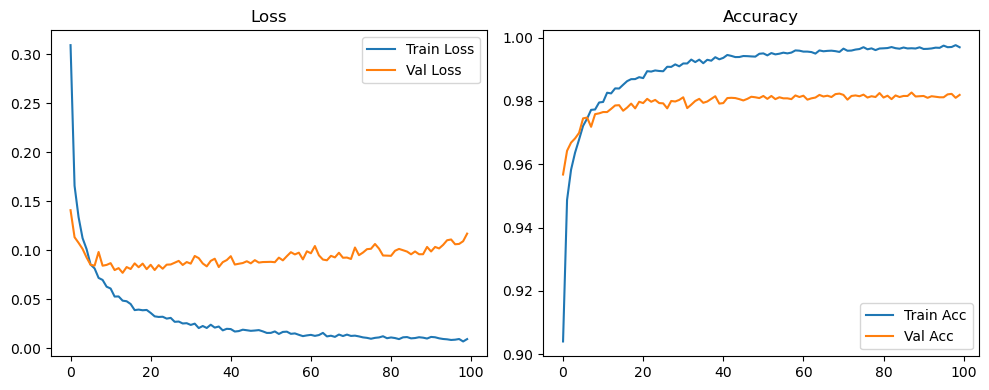

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2695, Acc: 0.9206 | Val Loss: 0.1578, Acc: 0.9546


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1081, Acc: 0.9672 | Val Loss: 0.1326, Acc: 0.9614


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9769 | Val Loss: 0.1159, Acc: 0.9665


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9827 | Val Loss: 0.1184, Acc: 0.9676


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9862 | Val Loss: 0.1189, Acc: 0.9702


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.1138, Acc: 0.9707


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.1078, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.1232, Acc: 0.9724


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.1186, Acc: 0.9744


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9946 | Val Loss: 0.1126, Acc: 0.9731


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.1254, Acc: 0.9708


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.1190, Acc: 0.9745


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1251, Acc: 0.9732


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9950 | Val Loss: 0.1171, Acc: 0.9743


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.1043, Acc: 0.9771


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.1065, Acc: 0.9744


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1061, Acc: 0.9761


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1205, Acc: 0.9733


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1127, Acc: 0.9768


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1078, Acc: 0.9764


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0991, Acc: 0.9762


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1021, Acc: 0.9784


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1119, Acc: 0.9771


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1161, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1121, Acc: 0.9764


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0982, Acc: 0.9778


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1089, Acc: 0.9738


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.0984, Acc: 0.9774


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1130, Acc: 0.9740


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1211, Acc: 0.9775


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1085, Acc: 0.9778


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1380, Acc: 0.9722


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1242, Acc: 0.9753


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1324, Acc: 0.9767


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1259, Acc: 0.9745


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1086, Acc: 0.9759


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1330, Acc: 0.9751


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1205, Acc: 0.9763


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1150, Acc: 0.9776


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1068, Acc: 0.9772


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1217, Acc: 0.9771


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1258, Acc: 0.9770


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1024, Acc: 0.9770


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0964, Acc: 0.9769


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1123, Acc: 0.9787


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1138, Acc: 0.9786


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9973 | Val Loss: 0.1128, Acc: 0.9776


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1145, Acc: 0.9775


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1058, Acc: 0.9786


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1283, Acc: 0.9772


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1387, Acc: 0.9772


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1288, Acc: 0.9762


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1145, Acc: 0.9768


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1243, Acc: 0.9762


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1176, Acc: 0.9760


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1488, Acc: 0.9756


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1151, Acc: 0.9777


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1056, Acc: 0.9782


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1156, Acc: 0.9788


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0850, Acc: 0.9783


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1102, Acc: 0.9779


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1311, Acc: 0.9755


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1127, Acc: 0.9775


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1159, Acc: 0.9784


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0995, Acc: 0.9788


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1050, Acc: 0.9782


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1333, Acc: 0.9789


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0975, Acc: 0.9778


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1368, Acc: 0.9769


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1472, Acc: 0.9777


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1233, Acc: 0.9762


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1195, Acc: 0.9758


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1079, Acc: 0.9770


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1339, Acc: 0.9788


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1635, Acc: 0.9769


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1262, Acc: 0.9746


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1127, Acc: 0.9786


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1216, Acc: 0.9772


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1464, Acc: 0.9773


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1292, Acc: 0.9763


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1334, Acc: 0.9783


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1110, Acc: 0.9770


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1268, Acc: 0.9797


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1182, Acc: 0.9779


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1310, Acc: 0.9751


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1266, Acc: 0.9774


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1396, Acc: 0.9782


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1099, Acc: 0.9792


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1374, Acc: 0.9754


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1059, Acc: 0.9775


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1490, Acc: 0.9784


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1500, Acc: 0.9786


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1289, Acc: 0.9774


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1169, Acc: 0.9777


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1181, Acc: 0.9790


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1397, Acc: 0.9770


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1340, Acc: 0.9786


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1574, Acc: 0.9787


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1527, Acc: 0.9794


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1237, Acc: 0.9788


Final Test Loss: 0.1183 Accuracy: 0.9792


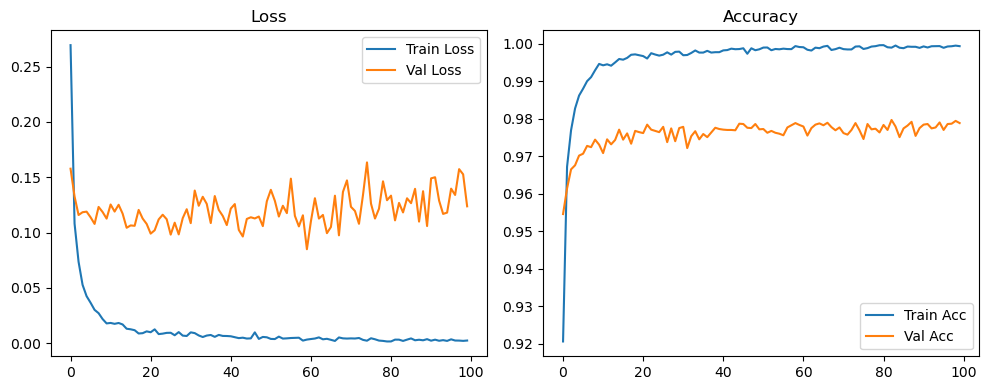

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2811, Acc: 0.9160 | Val Loss: 0.1614, Acc: 0.9540


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1251, Acc: 0.9615 | Val Loss: 0.1310, Acc: 0.9621


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0926, Acc: 0.9711 | Val Loss: 0.1113, Acc: 0.9673


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9794 | Val Loss: 0.1137, Acc: 0.9661


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9820 | Val Loss: 0.1011, Acc: 0.9725


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9851 | Val Loss: 0.0995, Acc: 0.9732


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9854 | Val Loss: 0.1055, Acc: 0.9722


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.1030, Acc: 0.9739


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.1113, Acc: 0.9748


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9900 | Val Loss: 0.1033, Acc: 0.9736


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9909 | Val Loss: 0.1164, Acc: 0.9736


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9902 | Val Loss: 0.1158, Acc: 0.9726


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.1093, Acc: 0.9765


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.1170, Acc: 0.9738


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1222, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.1133, Acc: 0.9752


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9939 | Val Loss: 0.1129, Acc: 0.9755


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.1133, Acc: 0.9779


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.1145, Acc: 0.9741


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9940 | Val Loss: 0.1297, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1179, Acc: 0.9749


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.1049, Acc: 0.9777


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9950 | Val Loss: 0.1248, Acc: 0.9757


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.1304, Acc: 0.9750


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.1310, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.1083, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.1110, Acc: 0.9785


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.1160, Acc: 0.9768


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9961 | Val Loss: 0.1462, Acc: 0.9742


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1179, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.1254, Acc: 0.9754


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1129, Acc: 0.9785


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1151, Acc: 0.9772


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9969 | Val Loss: 0.1170, Acc: 0.9773


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1297, Acc: 0.9761


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.1274, Acc: 0.9766


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.1241, Acc: 0.9782


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1194, Acc: 0.9778


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1310, Acc: 0.9749


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9963 | Val Loss: 0.1226, Acc: 0.9778


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1347, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.1230, Acc: 0.9776


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1332, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9961 | Val Loss: 0.1236, Acc: 0.9772


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1167, Acc: 0.9786


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1184, Acc: 0.9775


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.1278, Acc: 0.9779


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1222, Acc: 0.9782


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1179, Acc: 0.9787


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9974 | Val Loss: 0.1139, Acc: 0.9791


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1102, Acc: 0.9779


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1180, Acc: 0.9791


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1211, Acc: 0.9794


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1319, Acc: 0.9778


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9962 | Val Loss: 0.1144, Acc: 0.9772


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1187, Acc: 0.9784


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1306, Acc: 0.9782


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.1299, Acc: 0.9782


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1197, Acc: 0.9808


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1266, Acc: 0.9788


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.1265, Acc: 0.9797


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1326, Acc: 0.9786


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1324, Acc: 0.9791


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1300, Acc: 0.9790


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1191, Acc: 0.9790


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1188, Acc: 0.9809


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1395, Acc: 0.9784


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9975 | Val Loss: 0.1308, Acc: 0.9793


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9983 | Val Loss: 0.1280, Acc: 0.9784


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1326, Acc: 0.9787


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1333, Acc: 0.9789


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1281, Acc: 0.9793


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1271, Acc: 0.9792


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1232, Acc: 0.9793


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1269, Acc: 0.9798


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1302, Acc: 0.9805


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.1238, Acc: 0.9805


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.1288, Acc: 0.9804


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1298, Acc: 0.9793


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1312, Acc: 0.9798


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1304, Acc: 0.9799


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1541, Acc: 0.9793


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1399, Acc: 0.9792


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1415, Acc: 0.9796


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1253, Acc: 0.9791


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9983 | Val Loss: 0.1248, Acc: 0.9798


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1245, Acc: 0.9802


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1306, Acc: 0.9794


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1294, Acc: 0.9802


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1330, Acc: 0.9793


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1362, Acc: 0.9809


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1385, Acc: 0.9772


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1329, Acc: 0.9803


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9991 | Val Loss: 0.1318, Acc: 0.9788


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1322, Acc: 0.9794


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1399, Acc: 0.9784


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1285, Acc: 0.9792


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.1255, Acc: 0.9799


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1369, Acc: 0.9796


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1433, Acc: 0.9790


Final Test Loss: 0.1232 Accuracy: 0.9799


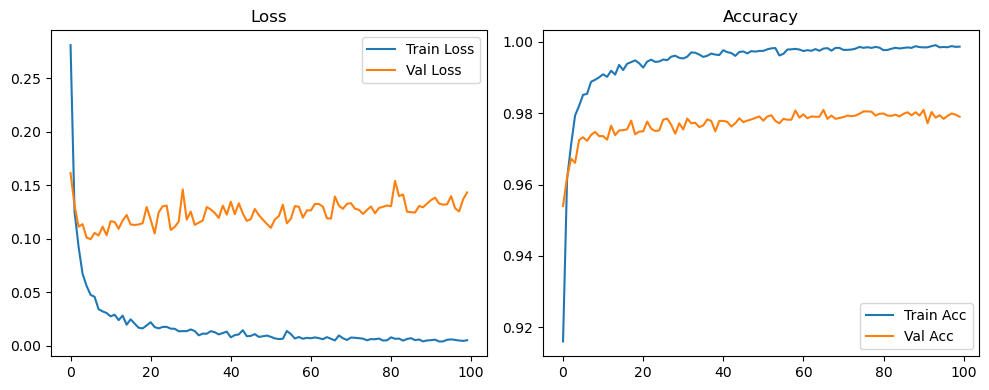

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3337, Acc: 0.8995 | Val Loss: 0.1527, Acc: 0.9549


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1781, Acc: 0.9473 | Val Loss: 0.1248, Acc: 0.9622


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1383, Acc: 0.9576 | Val Loss: 0.1110, Acc: 0.9679


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9642 | Val Loss: 0.1141, Acc: 0.9667


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1058, Acc: 0.9681 | Val Loss: 0.1003, Acc: 0.9697


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9725 | Val Loss: 0.0982, Acc: 0.9716


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9748 | Val Loss: 0.0915, Acc: 0.9747


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9771 | Val Loss: 0.0999, Acc: 0.9724


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9778 | Val Loss: 0.0890, Acc: 0.9767


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9779 | Val Loss: 0.0892, Acc: 0.9746


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9800 | Val Loss: 0.1017, Acc: 0.9748


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9815 | Val Loss: 0.1051, Acc: 0.9746


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9820 | Val Loss: 0.0970, Acc: 0.9755


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9826 | Val Loss: 0.0899, Acc: 0.9770


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9838 | Val Loss: 0.0987, Acc: 0.9759


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9850 | Val Loss: 0.0881, Acc: 0.9765


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9848 | Val Loss: 0.0947, Acc: 0.9758


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9848 | Val Loss: 0.0875, Acc: 0.9792


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9853 | Val Loss: 0.0934, Acc: 0.9754


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9872 | Val Loss: 0.0942, Acc: 0.9786


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9877 | Val Loss: 0.0995, Acc: 0.9762


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9875 | Val Loss: 0.0984, Acc: 0.9776


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9870 | Val Loss: 0.0922, Acc: 0.9781


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9880 | Val Loss: 0.0960, Acc: 0.9776


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9889 | Val Loss: 0.0988, Acc: 0.9775


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9888 | Val Loss: 0.0902, Acc: 0.9784


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.0962, Acc: 0.9785


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9909 | Val Loss: 0.0942, Acc: 0.9797


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9889 | Val Loss: 0.0932, Acc: 0.9790


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.1028, Acc: 0.9788


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9895 | Val Loss: 0.0993, Acc: 0.9778


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9902 | Val Loss: 0.0951, Acc: 0.9789


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9904 | Val Loss: 0.0984, Acc: 0.9798


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9903 | Val Loss: 0.1065, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9906 | Val Loss: 0.1029, Acc: 0.9798


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9911 | Val Loss: 0.0785, Acc: 0.9798


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.0890, Acc: 0.9810


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.0814, Acc: 0.9799


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9920 | Val Loss: 0.0850, Acc: 0.9800


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.0838, Acc: 0.9791


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.0884, Acc: 0.9798


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9938 | Val Loss: 0.0817, Acc: 0.9802


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9929 | Val Loss: 0.0744, Acc: 0.9815


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.0912, Acc: 0.9798


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.0834, Acc: 0.9800


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0902, Acc: 0.9803


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9933 | Val Loss: 0.0913, Acc: 0.9799


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.0942, Acc: 0.9797


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0815, Acc: 0.9810


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.0937, Acc: 0.9801


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9929 | Val Loss: 0.0848, Acc: 0.9807


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.0925, Acc: 0.9800


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0918, Acc: 0.9813


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0992, Acc: 0.9812


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.0872, Acc: 0.9818


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.0879, Acc: 0.9812


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0803, Acc: 0.9818


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9943 | Val Loss: 0.0962, Acc: 0.9808


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.0872, Acc: 0.9812


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0962, Acc: 0.9796


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0921, Acc: 0.9810


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.0857, Acc: 0.9808


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9946 | Val Loss: 0.0836, Acc: 0.9805


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0930, Acc: 0.9809


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.0868, Acc: 0.9793


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.0917, Acc: 0.9805


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9941 | Val Loss: 0.0909, Acc: 0.9800


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.0880, Acc: 0.9802


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.0751, Acc: 0.9798


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.0890, Acc: 0.9791


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.0777, Acc: 0.9802


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.1031, Acc: 0.9798


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0891, Acc: 0.9797


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1092, Acc: 0.9804


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.0925, Acc: 0.9797


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9945 | Val Loss: 0.0833, Acc: 0.9807


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.0925, Acc: 0.9803


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1155, Acc: 0.9812


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9946 | Val Loss: 0.0989, Acc: 0.9812


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.1023, Acc: 0.9812


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9951 | Val Loss: 0.0977, Acc: 0.9818


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.0867, Acc: 0.9820


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.0862, Acc: 0.9812


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.0936, Acc: 0.9797


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0745, Acc: 0.9820


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.0952, Acc: 0.9802


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9953 | Val Loss: 0.0925, Acc: 0.9805


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9953 | Val Loss: 0.1015, Acc: 0.9806


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.0839, Acc: 0.9810


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0926, Acc: 0.9805


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0832, Acc: 0.9798


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.0802, Acc: 0.9797


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.0750, Acc: 0.9797


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0910, Acc: 0.9806


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0941, Acc: 0.9794


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9953 | Val Loss: 0.0978, Acc: 0.9794


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.1012, Acc: 0.9802


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0893, Acc: 0.9802


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.0820, Acc: 0.9806


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.0910, Acc: 0.9795


Final Test Loss: 0.0789 Accuracy: 0.9819


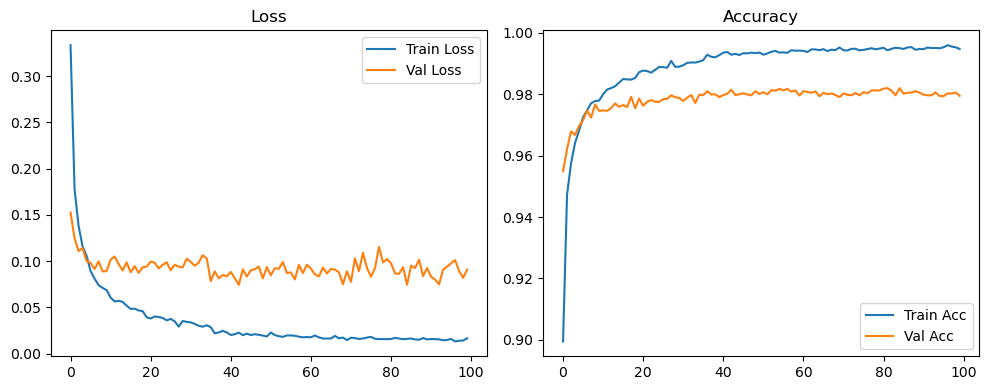

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2695, Acc: 0.9206 | Val Loss: 0.1578, Acc: 0.9546


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1081, Acc: 0.9672 | Val Loss: 0.1326, Acc: 0.9614


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9769 | Val Loss: 0.1159, Acc: 0.9665


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9827 | Val Loss: 0.1184, Acc: 0.9676


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9862 | Val Loss: 0.1189, Acc: 0.9702


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.1138, Acc: 0.9707


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.1078, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.1232, Acc: 0.9724


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.1186, Acc: 0.9744


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9946 | Val Loss: 0.1126, Acc: 0.9731


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.1254, Acc: 0.9708


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.1190, Acc: 0.9745


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1251, Acc: 0.9732


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9950 | Val Loss: 0.1171, Acc: 0.9743


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.1043, Acc: 0.9771


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.1065, Acc: 0.9744


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1061, Acc: 0.9761


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1205, Acc: 0.9733


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1127, Acc: 0.9768


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1078, Acc: 0.9764


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0991, Acc: 0.9762


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1021, Acc: 0.9784


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1119, Acc: 0.9771


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1161, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1121, Acc: 0.9764


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0982, Acc: 0.9778


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1089, Acc: 0.9738


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.0984, Acc: 0.9774


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1130, Acc: 0.9740


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1211, Acc: 0.9775


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1085, Acc: 0.9778


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1380, Acc: 0.9722


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1242, Acc: 0.9753


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1324, Acc: 0.9767


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1259, Acc: 0.9745


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1086, Acc: 0.9759


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1330, Acc: 0.9751


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1205, Acc: 0.9763


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1150, Acc: 0.9776


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1068, Acc: 0.9772


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1217, Acc: 0.9771


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1258, Acc: 0.9770


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1024, Acc: 0.9770


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0964, Acc: 0.9769


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1123, Acc: 0.9787


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1138, Acc: 0.9786


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9973 | Val Loss: 0.1128, Acc: 0.9776


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1145, Acc: 0.9775


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1058, Acc: 0.9786


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1283, Acc: 0.9772


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1130, Acc: 0.9797


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1335, Acc: 0.9798


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1437, Acc: 0.9799


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1473, Acc: 0.9805


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1553, Acc: 0.9797


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1577, Acc: 0.9799


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1216, Acc: 0.9793


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1120, Acc: 0.9795


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1346, Acc: 0.9808


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1408, Acc: 0.9804


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1445, Acc: 0.9800


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1139, Acc: 0.9781


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1236, Acc: 0.9795


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1406, Acc: 0.9802


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1218, Acc: 0.9795


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1165, Acc: 0.9799


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1153, Acc: 0.9790


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1433, Acc: 0.9795


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1335, Acc: 0.9797


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1302, Acc: 0.9786


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1378, Acc: 0.9794


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1268, Acc: 0.9794


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1392, Acc: 0.9794


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1433, Acc: 0.9775


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1100, Acc: 0.9806


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1470, Acc: 0.9789


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1165, Acc: 0.9789


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1145, Acc: 0.9818


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1347, Acc: 0.9798


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1130, Acc: 0.9784


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1259, Acc: 0.9805


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1314, Acc: 0.9805


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1343, Acc: 0.9802


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1372, Acc: 0.9811


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1423, Acc: 0.9809


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1434, Acc: 0.9817


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1478, Acc: 0.9814


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1501, Acc: 0.9815


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1455, Acc: 0.9814


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1469, Acc: 0.9812


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1496, Acc: 0.9820


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1439, Acc: 0.9814


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1448, Acc: 0.9818


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1539, Acc: 0.9823


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1557, Acc: 0.9818


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1591, Acc: 0.9820


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1598, Acc: 0.9820


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1635, Acc: 0.9822


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1790, Acc: 0.9806


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1793, Acc: 0.9812


Final Test Loss: 0.1760 Accuracy: 0.9807


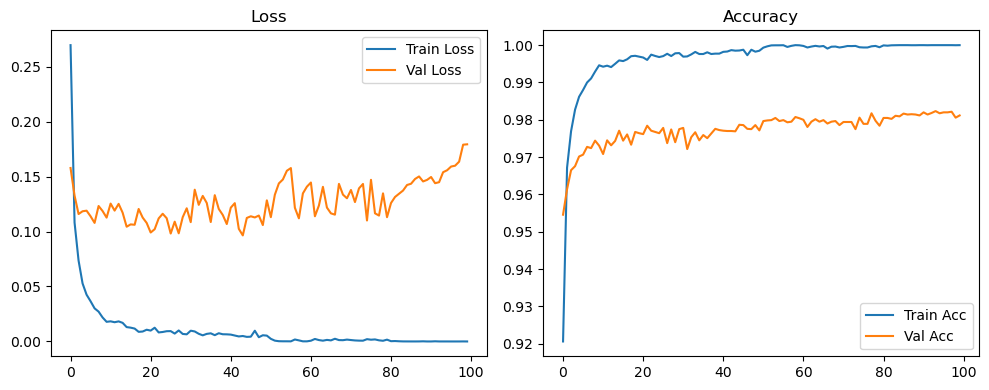

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2811, Acc: 0.9160 | Val Loss: 0.1614, Acc: 0.9540


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1251, Acc: 0.9615 | Val Loss: 0.1310, Acc: 0.9621


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0926, Acc: 0.9711 | Val Loss: 0.1113, Acc: 0.9673


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9794 | Val Loss: 0.1137, Acc: 0.9661


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9820 | Val Loss: 0.1011, Acc: 0.9725


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9851 | Val Loss: 0.0995, Acc: 0.9732


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9854 | Val Loss: 0.1055, Acc: 0.9722


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.1030, Acc: 0.9739


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.1113, Acc: 0.9748


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9900 | Val Loss: 0.1033, Acc: 0.9736


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9909 | Val Loss: 0.1164, Acc: 0.9736


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9902 | Val Loss: 0.1158, Acc: 0.9726


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.1093, Acc: 0.9765


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.1170, Acc: 0.9738


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1222, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.1133, Acc: 0.9752


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9939 | Val Loss: 0.1129, Acc: 0.9755


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.1133, Acc: 0.9779


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.1145, Acc: 0.9741


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9940 | Val Loss: 0.1297, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1179, Acc: 0.9749


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.1049, Acc: 0.9777


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9950 | Val Loss: 0.1248, Acc: 0.9757


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.1304, Acc: 0.9750


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.1310, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.1083, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.1110, Acc: 0.9785


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.1160, Acc: 0.9768


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9961 | Val Loss: 0.1462, Acc: 0.9742


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1179, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.1254, Acc: 0.9754


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1129, Acc: 0.9785


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1151, Acc: 0.9772


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9969 | Val Loss: 0.1170, Acc: 0.9773


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1297, Acc: 0.9761


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.1274, Acc: 0.9766


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.1241, Acc: 0.9782


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1194, Acc: 0.9778


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1310, Acc: 0.9749


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9963 | Val Loss: 0.1226, Acc: 0.9778


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1347, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.1230, Acc: 0.9776


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1332, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9961 | Val Loss: 0.1236, Acc: 0.9772


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1167, Acc: 0.9786


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1184, Acc: 0.9775


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.1278, Acc: 0.9779


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1222, Acc: 0.9782


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1179, Acc: 0.9787


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9974 | Val Loss: 0.1139, Acc: 0.9791


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1039, Acc: 0.9802


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1071, Acc: 0.9806


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1143, Acc: 0.9803


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1134, Acc: 0.9808


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1156, Acc: 0.9806


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1227, Acc: 0.9808


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1181, Acc: 0.9808


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1250, Acc: 0.9802


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1170, Acc: 0.9802


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1302, Acc: 0.9798


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1283, Acc: 0.9803


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1342, Acc: 0.9807


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1304, Acc: 0.9793


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1340, Acc: 0.9802


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1321, Acc: 0.9804


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1313, Acc: 0.9798


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1297, Acc: 0.9806


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1203, Acc: 0.9812


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.1254, Acc: 0.9807


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1337, Acc: 0.9798


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1344, Acc: 0.9805


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1255, Acc: 0.9812


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1381, Acc: 0.9796


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1315, Acc: 0.9799


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1278, Acc: 0.9808


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1362, Acc: 0.9803


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1333, Acc: 0.9807


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1309, Acc: 0.9808


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1322, Acc: 0.9801


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1393, Acc: 0.9817


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1252, Acc: 0.9819


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1271, Acc: 0.9820


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1251, Acc: 0.9822


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1271, Acc: 0.9816


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1268, Acc: 0.9818


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1277, Acc: 0.9828


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1308, Acc: 0.9838


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1277, Acc: 0.9830


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1341, Acc: 0.9827


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1345, Acc: 0.9830


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1385, Acc: 0.9822


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1403, Acc: 0.9822


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1418, Acc: 0.9821


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1406, Acc: 0.9823


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1406, Acc: 0.9825


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1435, Acc: 0.9818


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1384, Acc: 0.9820


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1378, Acc: 0.9824


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1401, Acc: 0.9812


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1389, Acc: 0.9817


Final Test Loss: 0.1239 Accuracy: 0.9840


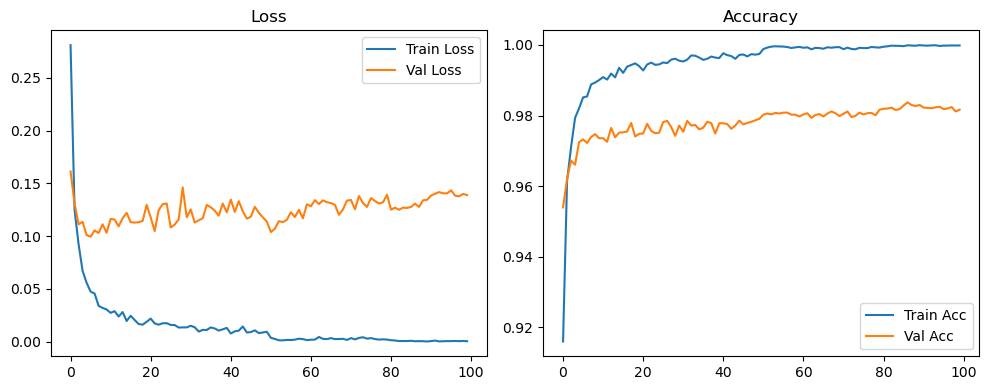

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3337, Acc: 0.8995 | Val Loss: 0.1527, Acc: 0.9549


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1781, Acc: 0.9473 | Val Loss: 0.1248, Acc: 0.9622


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1383, Acc: 0.9576 | Val Loss: 0.1110, Acc: 0.9679


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9642 | Val Loss: 0.1141, Acc: 0.9667


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1058, Acc: 0.9681 | Val Loss: 0.1003, Acc: 0.9697


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9725 | Val Loss: 0.0982, Acc: 0.9716


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9748 | Val Loss: 0.0915, Acc: 0.9747


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9771 | Val Loss: 0.0999, Acc: 0.9724


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9778 | Val Loss: 0.0890, Acc: 0.9767


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9779 | Val Loss: 0.0892, Acc: 0.9746


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9800 | Val Loss: 0.1017, Acc: 0.9748


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9815 | Val Loss: 0.1051, Acc: 0.9746


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9820 | Val Loss: 0.0970, Acc: 0.9755


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9826 | Val Loss: 0.0899, Acc: 0.9770


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9838 | Val Loss: 0.0987, Acc: 0.9759


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9850 | Val Loss: 0.0881, Acc: 0.9765


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9848 | Val Loss: 0.0947, Acc: 0.9758


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9848 | Val Loss: 0.0875, Acc: 0.9792


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9853 | Val Loss: 0.0934, Acc: 0.9754


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9872 | Val Loss: 0.0942, Acc: 0.9786


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9877 | Val Loss: 0.0995, Acc: 0.9762


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9875 | Val Loss: 0.0984, Acc: 0.9776


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9870 | Val Loss: 0.0922, Acc: 0.9781


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9880 | Val Loss: 0.0960, Acc: 0.9776


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9889 | Val Loss: 0.0988, Acc: 0.9775


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9888 | Val Loss: 0.0902, Acc: 0.9784


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.0962, Acc: 0.9785


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9909 | Val Loss: 0.0942, Acc: 0.9797


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9889 | Val Loss: 0.0932, Acc: 0.9790


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.1028, Acc: 0.9788


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9895 | Val Loss: 0.0993, Acc: 0.9778


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9902 | Val Loss: 0.0951, Acc: 0.9789


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9904 | Val Loss: 0.0984, Acc: 0.9798


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9903 | Val Loss: 0.1065, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9906 | Val Loss: 0.1029, Acc: 0.9798


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9911 | Val Loss: 0.0785, Acc: 0.9798


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.0890, Acc: 0.9810


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.0814, Acc: 0.9799


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9920 | Val Loss: 0.0850, Acc: 0.9800


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.0838, Acc: 0.9791


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.0884, Acc: 0.9798


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9938 | Val Loss: 0.0817, Acc: 0.9802


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9929 | Val Loss: 0.0744, Acc: 0.9815


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.0912, Acc: 0.9798


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.0834, Acc: 0.9800


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0902, Acc: 0.9803


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9933 | Val Loss: 0.0913, Acc: 0.9799


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.0942, Acc: 0.9797


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0815, Acc: 0.9810


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.0937, Acc: 0.9801


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.0854, Acc: 0.9825


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0879, Acc: 0.9811


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0928, Acc: 0.9822


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0957, Acc: 0.9828


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0876, Acc: 0.9817


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1008, Acc: 0.9826


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0967, Acc: 0.9818


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1045, Acc: 0.9812


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9975 | Val Loss: 0.1007, Acc: 0.9824


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0948, Acc: 0.9807


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1028, Acc: 0.9808


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1061, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1131, Acc: 0.9808


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0914, Acc: 0.9812


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1059, Acc: 0.9806


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0984, Acc: 0.9816


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0916, Acc: 0.9822


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0901, Acc: 0.9814


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1044, Acc: 0.9810


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1051, Acc: 0.9819


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0988, Acc: 0.9813


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1018, Acc: 0.9814


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0988, Acc: 0.9817


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0963, Acc: 0.9813


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1031, Acc: 0.9826


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0910, Acc: 0.9824


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.0928, Acc: 0.9815


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1088, Acc: 0.9818


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1012, Acc: 0.9822


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0889, Acc: 0.9834


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0960, Acc: 0.9837


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0884, Acc: 0.9830


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1007, Acc: 0.9824


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0978, Acc: 0.9829


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9986 | Val Loss: 0.1077, Acc: 0.9825


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0992, Acc: 0.9827


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1058, Acc: 0.9828


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1045, Acc: 0.9829


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1047, Acc: 0.9832


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0990, Acc: 0.9832


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1055, Acc: 0.9832


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0973, Acc: 0.9832


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1135, Acc: 0.9839


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1033, Acc: 0.9834


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1096, Acc: 0.9832


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1060, Acc: 0.9839


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1032, Acc: 0.9837


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1060, Acc: 0.9838


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0961, Acc: 0.9838


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1024, Acc: 0.9828


Final Test Loss: 0.0940 Accuracy: 0.9845


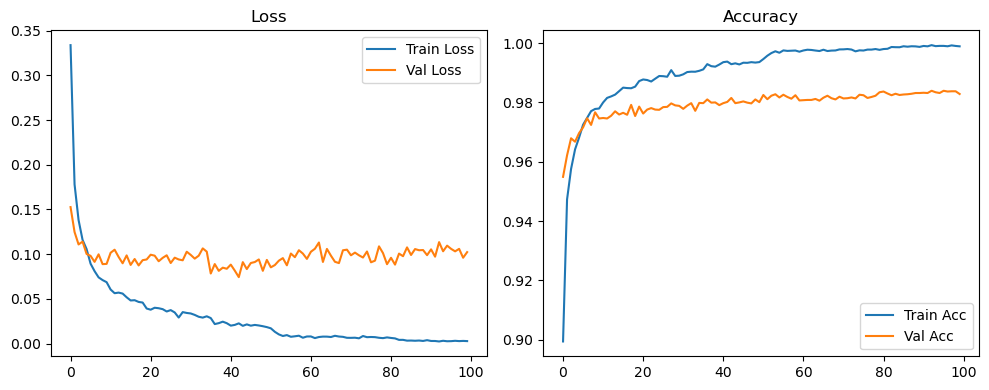

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2695, Acc: 0.9206 | Val Loss: 0.1578, Acc: 0.9546


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1081, Acc: 0.9672 | Val Loss: 0.1326, Acc: 0.9614


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9769 | Val Loss: 0.1159, Acc: 0.9665


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9827 | Val Loss: 0.1184, Acc: 0.9676


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9862 | Val Loss: 0.1189, Acc: 0.9702


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.1138, Acc: 0.9707


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.1078, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.1232, Acc: 0.9724


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.1186, Acc: 0.9744


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9946 | Val Loss: 0.1126, Acc: 0.9731


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.1254, Acc: 0.9708


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.1190, Acc: 0.9745


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1251, Acc: 0.9732


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9950 | Val Loss: 0.1171, Acc: 0.9743


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.1043, Acc: 0.9771


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.1065, Acc: 0.9744


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1061, Acc: 0.9761


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1205, Acc: 0.9733


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1127, Acc: 0.9768


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1078, Acc: 0.9764


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0991, Acc: 0.9762


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1021, Acc: 0.9784


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1119, Acc: 0.9771


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1161, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1121, Acc: 0.9764


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0982, Acc: 0.9778


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1089, Acc: 0.9738


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.0984, Acc: 0.9774


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1130, Acc: 0.9740


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1211, Acc: 0.9775


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1085, Acc: 0.9778


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1380, Acc: 0.9722


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1242, Acc: 0.9753


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1324, Acc: 0.9767


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1259, Acc: 0.9745


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1086, Acc: 0.9759


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1330, Acc: 0.9751


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1205, Acc: 0.9763


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1150, Acc: 0.9776


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1068, Acc: 0.9772


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1217, Acc: 0.9771


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1258, Acc: 0.9770


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1024, Acc: 0.9770


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0964, Acc: 0.9769


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1123, Acc: 0.9787


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1138, Acc: 0.9786


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9973 | Val Loss: 0.1128, Acc: 0.9776


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1145, Acc: 0.9775


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1058, Acc: 0.9786


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1283, Acc: 0.9772


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1130, Acc: 0.9797


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1335, Acc: 0.9798


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1437, Acc: 0.9799


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1473, Acc: 0.9805


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1553, Acc: 0.9797


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1577, Acc: 0.9799


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1216, Acc: 0.9793


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1120, Acc: 0.9795


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1346, Acc: 0.9808


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1408, Acc: 0.9804


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1445, Acc: 0.9800


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1139, Acc: 0.9781


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1236, Acc: 0.9795


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1406, Acc: 0.9802


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1218, Acc: 0.9795


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1165, Acc: 0.9799


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1153, Acc: 0.9790


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1433, Acc: 0.9795


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1335, Acc: 0.9797


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1302, Acc: 0.9786


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1378, Acc: 0.9794


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1268, Acc: 0.9794


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1392, Acc: 0.9794


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1433, Acc: 0.9775


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1100, Acc: 0.9806


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1470, Acc: 0.9789


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1165, Acc: 0.9789


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1145, Acc: 0.9818


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1347, Acc: 0.9798


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1130, Acc: 0.9784


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1208, Acc: 0.9798


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1213, Acc: 0.9805


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1253, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1277, Acc: 0.9803


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1311, Acc: 0.9807


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1325, Acc: 0.9810


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1360, Acc: 0.9810


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1375, Acc: 0.9810


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1387, Acc: 0.9809


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1410, Acc: 0.9808


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1427, Acc: 0.9817


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1465, Acc: 0.9807


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1474, Acc: 0.9814


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1506, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1520, Acc: 0.9817


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1551, Acc: 0.9815


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1548, Acc: 0.9811


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1559, Acc: 0.9812


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1566, Acc: 0.9813


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1609, Acc: 0.9812


Final Test Loss: 0.1575 Accuracy: 0.9821


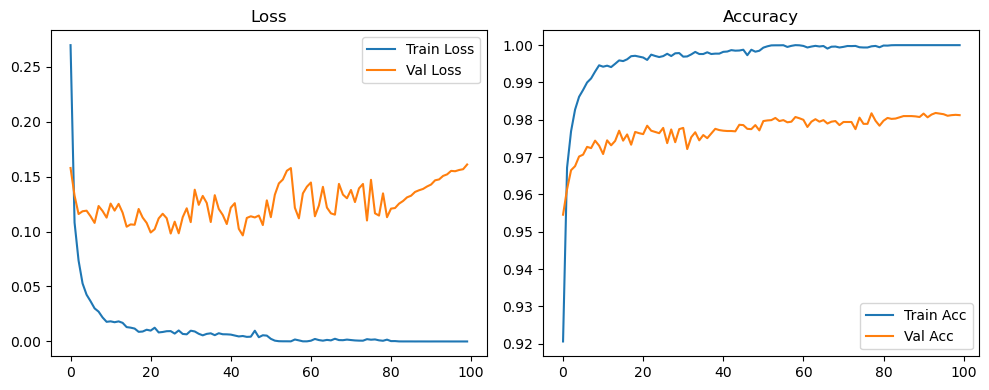

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2811, Acc: 0.9160 | Val Loss: 0.1614, Acc: 0.9540


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1251, Acc: 0.9615 | Val Loss: 0.1310, Acc: 0.9621


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0926, Acc: 0.9711 | Val Loss: 0.1113, Acc: 0.9673


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9794 | Val Loss: 0.1137, Acc: 0.9661


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9820 | Val Loss: 0.1011, Acc: 0.9725


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9851 | Val Loss: 0.0995, Acc: 0.9732


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9854 | Val Loss: 0.1055, Acc: 0.9722


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.1030, Acc: 0.9739


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.1113, Acc: 0.9748


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9900 | Val Loss: 0.1033, Acc: 0.9736


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9909 | Val Loss: 0.1164, Acc: 0.9736


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9902 | Val Loss: 0.1158, Acc: 0.9726


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.1093, Acc: 0.9765


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.1170, Acc: 0.9738


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1222, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.1133, Acc: 0.9752


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9939 | Val Loss: 0.1129, Acc: 0.9755


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.1133, Acc: 0.9779


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.1145, Acc: 0.9741


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9940 | Val Loss: 0.1297, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1179, Acc: 0.9749


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.1049, Acc: 0.9777


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9950 | Val Loss: 0.1248, Acc: 0.9757


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.1304, Acc: 0.9750


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.1310, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.1083, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.1110, Acc: 0.9785


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.1160, Acc: 0.9768


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9961 | Val Loss: 0.1462, Acc: 0.9742


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1179, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.1254, Acc: 0.9754


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1129, Acc: 0.9785


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1151, Acc: 0.9772


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9969 | Val Loss: 0.1170, Acc: 0.9773


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1297, Acc: 0.9761


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.1274, Acc: 0.9766


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.1241, Acc: 0.9782


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1194, Acc: 0.9778


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1310, Acc: 0.9749


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9963 | Val Loss: 0.1226, Acc: 0.9778


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1347, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.1230, Acc: 0.9776


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1332, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9961 | Val Loss: 0.1236, Acc: 0.9772


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1167, Acc: 0.9786


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1184, Acc: 0.9775


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.1278, Acc: 0.9779


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1222, Acc: 0.9782


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1179, Acc: 0.9787


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9974 | Val Loss: 0.1139, Acc: 0.9791


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1039, Acc: 0.9802


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1071, Acc: 0.9806


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1143, Acc: 0.9803


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1134, Acc: 0.9808


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1156, Acc: 0.9806


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1227, Acc: 0.9808


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1181, Acc: 0.9808


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1250, Acc: 0.9802


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1170, Acc: 0.9802


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1302, Acc: 0.9798


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1283, Acc: 0.9803


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1342, Acc: 0.9807


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1304, Acc: 0.9793


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1340, Acc: 0.9802


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1321, Acc: 0.9804


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1313, Acc: 0.9798


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1297, Acc: 0.9806


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1203, Acc: 0.9812


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.1254, Acc: 0.9807


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1337, Acc: 0.9798


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1344, Acc: 0.9805


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1255, Acc: 0.9812


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1381, Acc: 0.9796


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1315, Acc: 0.9799


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1278, Acc: 0.9808


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1362, Acc: 0.9803


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1333, Acc: 0.9807


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1309, Acc: 0.9808


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1322, Acc: 0.9801


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1393, Acc: 0.9817


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1255, Acc: 0.9826


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1255, Acc: 0.9822


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1242, Acc: 0.9825


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1234, Acc: 0.9831


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1246, Acc: 0.9828


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1253, Acc: 0.9833


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1269, Acc: 0.9829


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1240, Acc: 0.9832


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1264, Acc: 0.9832


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1262, Acc: 0.9833


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1276, Acc: 0.9834


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1312, Acc: 0.9832


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1299, Acc: 0.9833


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1310, Acc: 0.9831


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1331, Acc: 0.9828


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1326, Acc: 0.9822


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1307, Acc: 0.9830


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1336, Acc: 0.9832


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1325, Acc: 0.9828


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1313, Acc: 0.9833


Final Test Loss: 0.1125 Accuracy: 0.9833


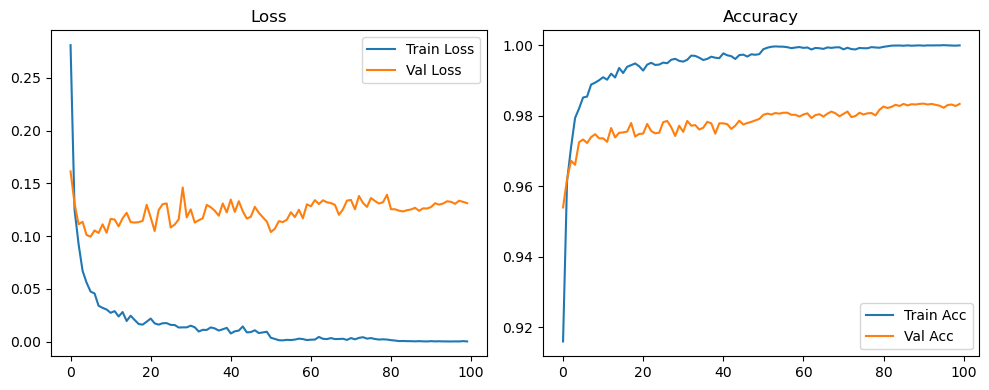

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3337, Acc: 0.8995 | Val Loss: 0.1527, Acc: 0.9549


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1781, Acc: 0.9473 | Val Loss: 0.1248, Acc: 0.9622


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1383, Acc: 0.9576 | Val Loss: 0.1110, Acc: 0.9679


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9642 | Val Loss: 0.1141, Acc: 0.9667


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1058, Acc: 0.9681 | Val Loss: 0.1003, Acc: 0.9697


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9725 | Val Loss: 0.0982, Acc: 0.9716


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9748 | Val Loss: 0.0915, Acc: 0.9747


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9771 | Val Loss: 0.0999, Acc: 0.9724


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9778 | Val Loss: 0.0890, Acc: 0.9767


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9779 | Val Loss: 0.0892, Acc: 0.9746


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9800 | Val Loss: 0.1017, Acc: 0.9748


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9815 | Val Loss: 0.1051, Acc: 0.9746


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9820 | Val Loss: 0.0970, Acc: 0.9755


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9826 | Val Loss: 0.0899, Acc: 0.9770


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9838 | Val Loss: 0.0987, Acc: 0.9759


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9850 | Val Loss: 0.0881, Acc: 0.9765


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9848 | Val Loss: 0.0947, Acc: 0.9758


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9848 | Val Loss: 0.0875, Acc: 0.9792


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9853 | Val Loss: 0.0934, Acc: 0.9754


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9872 | Val Loss: 0.0942, Acc: 0.9786


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9877 | Val Loss: 0.0995, Acc: 0.9762


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9875 | Val Loss: 0.0984, Acc: 0.9776


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9870 | Val Loss: 0.0922, Acc: 0.9781


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9880 | Val Loss: 0.0960, Acc: 0.9776


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9889 | Val Loss: 0.0988, Acc: 0.9775


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9888 | Val Loss: 0.0902, Acc: 0.9784


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.0962, Acc: 0.9785


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9909 | Val Loss: 0.0942, Acc: 0.9797


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9889 | Val Loss: 0.0932, Acc: 0.9790


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.1028, Acc: 0.9788


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9895 | Val Loss: 0.0993, Acc: 0.9778


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9902 | Val Loss: 0.0951, Acc: 0.9789


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9904 | Val Loss: 0.0984, Acc: 0.9798


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9903 | Val Loss: 0.1065, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9906 | Val Loss: 0.1029, Acc: 0.9798


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9911 | Val Loss: 0.0785, Acc: 0.9798


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.0890, Acc: 0.9810


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.0814, Acc: 0.9799


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9920 | Val Loss: 0.0850, Acc: 0.9800


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.0838, Acc: 0.9791


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.0884, Acc: 0.9798


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9938 | Val Loss: 0.0817, Acc: 0.9802


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9929 | Val Loss: 0.0744, Acc: 0.9815


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.0912, Acc: 0.9798


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.0834, Acc: 0.9800


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0902, Acc: 0.9803


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9933 | Val Loss: 0.0913, Acc: 0.9799


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.0942, Acc: 0.9797


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0815, Acc: 0.9810


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.0937, Acc: 0.9801


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.0854, Acc: 0.9825


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0879, Acc: 0.9811


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0928, Acc: 0.9822


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0957, Acc: 0.9828


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0876, Acc: 0.9817


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1008, Acc: 0.9826


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0967, Acc: 0.9818


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1045, Acc: 0.9812


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9975 | Val Loss: 0.1007, Acc: 0.9824


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0948, Acc: 0.9807


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1028, Acc: 0.9808


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1061, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1131, Acc: 0.9808


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0914, Acc: 0.9812


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1059, Acc: 0.9806


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0984, Acc: 0.9816


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0916, Acc: 0.9822


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0901, Acc: 0.9814


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1044, Acc: 0.9810


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1051, Acc: 0.9819


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0988, Acc: 0.9813


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1018, Acc: 0.9814


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0988, Acc: 0.9817


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0963, Acc: 0.9813


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1031, Acc: 0.9826


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0910, Acc: 0.9824


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.0928, Acc: 0.9815


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1088, Acc: 0.9818


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1012, Acc: 0.9822


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0889, Acc: 0.9834


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0918, Acc: 0.9833


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0887, Acc: 0.9829


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0956, Acc: 0.9833


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0970, Acc: 0.9832


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1038, Acc: 0.9833


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0997, Acc: 0.9835


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1010, Acc: 0.9834


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1012, Acc: 0.9825


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1035, Acc: 0.9833


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1022, Acc: 0.9832


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1042, Acc: 0.9828


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0974, Acc: 0.9833


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1073, Acc: 0.9830


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1016, Acc: 0.9838


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1061, Acc: 0.9830


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1044, Acc: 0.9839


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1037, Acc: 0.9838


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1036, Acc: 0.9841


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1052, Acc: 0.9838


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1046, Acc: 0.9837


Final Test Loss: 0.0955 Accuracy: 0.9849


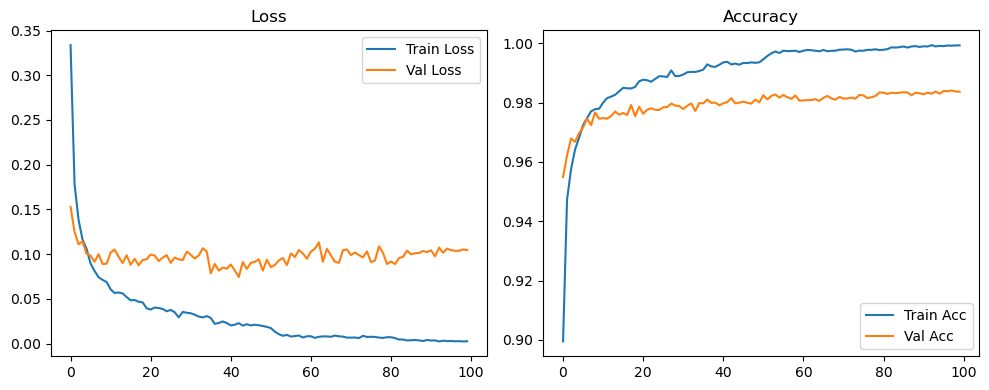

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2695, Acc: 0.9206 | Val Loss: 0.1578, Acc: 0.9546


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1081, Acc: 0.9672 | Val Loss: 0.1326, Acc: 0.9614


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9769 | Val Loss: 0.1159, Acc: 0.9665


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9827 | Val Loss: 0.1184, Acc: 0.9676


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9862 | Val Loss: 0.1189, Acc: 0.9702


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.1138, Acc: 0.9707


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.1078, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.1232, Acc: 0.9724


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.1186, Acc: 0.9744


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9946 | Val Loss: 0.1126, Acc: 0.9731


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.1254, Acc: 0.9708


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.1190, Acc: 0.9745


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1251, Acc: 0.9732


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9950 | Val Loss: 0.1171, Acc: 0.9743


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.1043, Acc: 0.9771


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.1065, Acc: 0.9744


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1061, Acc: 0.9761


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1205, Acc: 0.9733


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1127, Acc: 0.9768


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1078, Acc: 0.9764


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0991, Acc: 0.9762


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1021, Acc: 0.9784


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1119, Acc: 0.9771


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1161, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1121, Acc: 0.9764


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0982, Acc: 0.9778


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1089, Acc: 0.9738


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.0984, Acc: 0.9774


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1130, Acc: 0.9740


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1211, Acc: 0.9775


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1085, Acc: 0.9778


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1380, Acc: 0.9722


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1242, Acc: 0.9753


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1324, Acc: 0.9767


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1259, Acc: 0.9745


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1086, Acc: 0.9759


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1330, Acc: 0.9751


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1205, Acc: 0.9763


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1150, Acc: 0.9776


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1068, Acc: 0.9772


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1217, Acc: 0.9771


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1258, Acc: 0.9770


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1024, Acc: 0.9770


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0964, Acc: 0.9769


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1123, Acc: 0.9787


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1138, Acc: 0.9786


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9973 | Val Loss: 0.1128, Acc: 0.9776


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1145, Acc: 0.9775


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1058, Acc: 0.9786


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1283, Acc: 0.9772


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1208, Acc: 0.9804


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1287, Acc: 0.9803


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1314, Acc: 0.9805


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1359, Acc: 0.9807


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1413, Acc: 0.9807


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1432, Acc: 0.9811


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1482, Acc: 0.9802


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1512, Acc: 0.9805


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1447, Acc: 0.9812


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1467, Acc: 0.9808


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1472, Acc: 0.9806


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1467, Acc: 0.9811


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1449, Acc: 0.9808


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1435, Acc: 0.9808


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1366, Acc: 0.9798


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1306, Acc: 0.9812


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1379, Acc: 0.9807


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1397, Acc: 0.9810


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1416, Acc: 0.9812


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1461, Acc: 0.9809


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1397, Acc: 0.9812


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1389, Acc: 0.9807


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1439, Acc: 0.9804


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1369, Acc: 0.9796


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1380, Acc: 0.9798


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1526, Acc: 0.9794


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1369, Acc: 0.9796


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1179, Acc: 0.9812


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1311, Acc: 0.9809


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1385, Acc: 0.9807


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1450, Acc: 0.9806


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1457, Acc: 0.9811


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1502, Acc: 0.9812


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1513, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1504, Acc: 0.9809


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1493, Acc: 0.9812


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1533, Acc: 0.9808


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1555, Acc: 0.9811


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1550, Acc: 0.9815


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1592, Acc: 0.9812


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1620, Acc: 0.9812


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1647, Acc: 0.9814


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1654, Acc: 0.9819


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1669, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1683, Acc: 0.9810


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1748, Acc: 0.9806


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1605, Acc: 0.9809


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1605, Acc: 0.9812


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1619, Acc: 0.9811


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1661, Acc: 0.9807


Final Test Loss: 0.1522 Accuracy: 0.9819


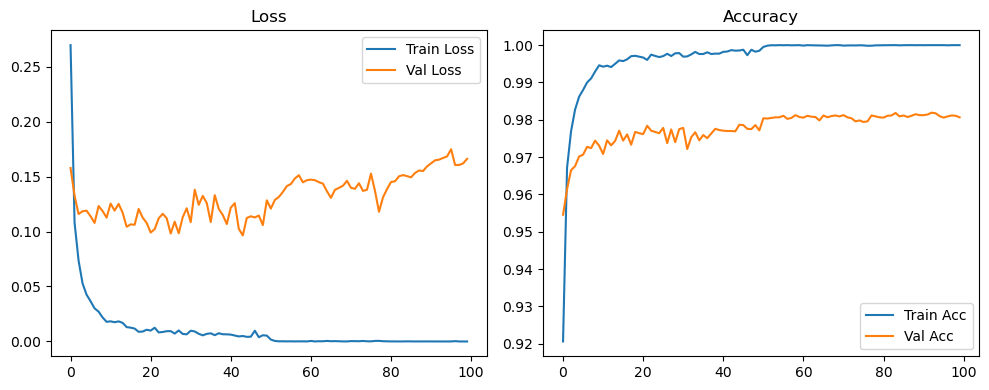

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2811, Acc: 0.9160 | Val Loss: 0.1614, Acc: 0.9540


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1251, Acc: 0.9615 | Val Loss: 0.1310, Acc: 0.9621


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0926, Acc: 0.9711 | Val Loss: 0.1113, Acc: 0.9673


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9794 | Val Loss: 0.1137, Acc: 0.9661


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9820 | Val Loss: 0.1011, Acc: 0.9725


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9851 | Val Loss: 0.0995, Acc: 0.9732


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9854 | Val Loss: 0.1055, Acc: 0.9722


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.1030, Acc: 0.9739


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.1113, Acc: 0.9748


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9900 | Val Loss: 0.1033, Acc: 0.9736


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9909 | Val Loss: 0.1164, Acc: 0.9736


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9902 | Val Loss: 0.1158, Acc: 0.9726


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.1093, Acc: 0.9765


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.1170, Acc: 0.9738


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1222, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.1133, Acc: 0.9752


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9939 | Val Loss: 0.1129, Acc: 0.9755


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.1133, Acc: 0.9779


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.1145, Acc: 0.9741


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9940 | Val Loss: 0.1297, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1179, Acc: 0.9749


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.1049, Acc: 0.9777


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9950 | Val Loss: 0.1248, Acc: 0.9757


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.1304, Acc: 0.9750


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.1310, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.1083, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.1110, Acc: 0.9785


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.1160, Acc: 0.9768


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9961 | Val Loss: 0.1462, Acc: 0.9742


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1179, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.1254, Acc: 0.9754


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1129, Acc: 0.9785


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1151, Acc: 0.9772


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9969 | Val Loss: 0.1170, Acc: 0.9773


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1297, Acc: 0.9761


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.1274, Acc: 0.9766


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.1241, Acc: 0.9782


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1194, Acc: 0.9778


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1310, Acc: 0.9749


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9963 | Val Loss: 0.1226, Acc: 0.9778


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1347, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.1230, Acc: 0.9776


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1332, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9961 | Val Loss: 0.1236, Acc: 0.9772


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1167, Acc: 0.9786


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1184, Acc: 0.9775


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.1278, Acc: 0.9779


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1222, Acc: 0.9782


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1179, Acc: 0.9787


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9974 | Val Loss: 0.1139, Acc: 0.9791


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1025, Acc: 0.9812


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1022, Acc: 0.9811


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1037, Acc: 0.9809


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1043, Acc: 0.9813


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1075, Acc: 0.9808


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1053, Acc: 0.9817


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1074, Acc: 0.9810


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1083, Acc: 0.9813


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1084, Acc: 0.9814


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1144, Acc: 0.9808


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1145, Acc: 0.9808


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1190, Acc: 0.9811


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1207, Acc: 0.9807


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1145, Acc: 0.9812


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1139, Acc: 0.9815


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1155, Acc: 0.9812


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1190, Acc: 0.9816


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1185, Acc: 0.9808


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1232, Acc: 0.9816


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1204, Acc: 0.9812


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1173, Acc: 0.9809


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1246, Acc: 0.9804


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1329, Acc: 0.9807


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1278, Acc: 0.9809


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1302, Acc: 0.9818


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1318, Acc: 0.9818


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1314, Acc: 0.9814


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1318, Acc: 0.9817


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1374, Acc: 0.9807


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1386, Acc: 0.9818


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1352, Acc: 0.9819


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1352, Acc: 0.9822


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1342, Acc: 0.9820


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1332, Acc: 0.9821


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1332, Acc: 0.9820


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1318, Acc: 0.9826


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1318, Acc: 0.9824


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1345, Acc: 0.9829


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1369, Acc: 0.9825


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1315, Acc: 0.9835


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1347, Acc: 0.9827


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1350, Acc: 0.9832


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1303, Acc: 0.9830


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1301, Acc: 0.9839


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1302, Acc: 0.9824


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1326, Acc: 0.9832


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1342, Acc: 0.9828


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1326, Acc: 0.9832


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1328, Acc: 0.9822


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1319, Acc: 0.9822


Final Test Loss: 0.1193 Accuracy: 0.9851


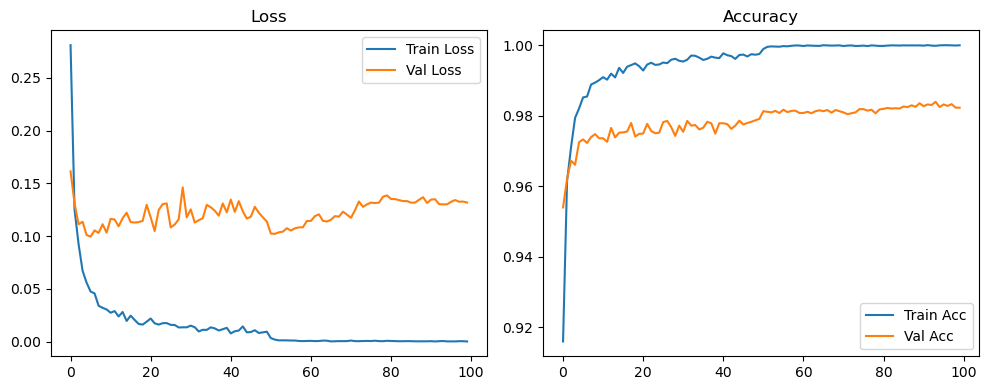

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3337, Acc: 0.8995 | Val Loss: 0.1527, Acc: 0.9549


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1781, Acc: 0.9473 | Val Loss: 0.1248, Acc: 0.9622


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1383, Acc: 0.9576 | Val Loss: 0.1110, Acc: 0.9679


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9642 | Val Loss: 0.1141, Acc: 0.9667


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1058, Acc: 0.9681 | Val Loss: 0.1003, Acc: 0.9697


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9725 | Val Loss: 0.0982, Acc: 0.9716


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9748 | Val Loss: 0.0915, Acc: 0.9747


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9771 | Val Loss: 0.0999, Acc: 0.9724


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9778 | Val Loss: 0.0890, Acc: 0.9767


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9779 | Val Loss: 0.0892, Acc: 0.9746


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9800 | Val Loss: 0.1017, Acc: 0.9748


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9815 | Val Loss: 0.1051, Acc: 0.9746


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9820 | Val Loss: 0.0970, Acc: 0.9755


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9826 | Val Loss: 0.0899, Acc: 0.9770


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9838 | Val Loss: 0.0987, Acc: 0.9759


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9850 | Val Loss: 0.0881, Acc: 0.9765


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9848 | Val Loss: 0.0947, Acc: 0.9758


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9848 | Val Loss: 0.0875, Acc: 0.9792


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9853 | Val Loss: 0.0934, Acc: 0.9754


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9872 | Val Loss: 0.0942, Acc: 0.9786


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9877 | Val Loss: 0.0995, Acc: 0.9762


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9875 | Val Loss: 0.0984, Acc: 0.9776


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9870 | Val Loss: 0.0922, Acc: 0.9781


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9880 | Val Loss: 0.0960, Acc: 0.9776


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9889 | Val Loss: 0.0988, Acc: 0.9775


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9888 | Val Loss: 0.0902, Acc: 0.9784


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.0962, Acc: 0.9785


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9909 | Val Loss: 0.0942, Acc: 0.9797


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9889 | Val Loss: 0.0932, Acc: 0.9790


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.1028, Acc: 0.9788


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9895 | Val Loss: 0.0993, Acc: 0.9778


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9902 | Val Loss: 0.0951, Acc: 0.9789


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9904 | Val Loss: 0.0984, Acc: 0.9798


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9903 | Val Loss: 0.1065, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9906 | Val Loss: 0.1029, Acc: 0.9798


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9911 | Val Loss: 0.0785, Acc: 0.9798


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.0890, Acc: 0.9810


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.0814, Acc: 0.9799


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9920 | Val Loss: 0.0850, Acc: 0.9800


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.0838, Acc: 0.9791


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.0884, Acc: 0.9798


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9938 | Val Loss: 0.0817, Acc: 0.9802


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9929 | Val Loss: 0.0744, Acc: 0.9815


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.0912, Acc: 0.9798


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.0834, Acc: 0.9800


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0902, Acc: 0.9803


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9933 | Val Loss: 0.0913, Acc: 0.9799


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.0942, Acc: 0.9797


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0815, Acc: 0.9810


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.0937, Acc: 0.9801


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.0855, Acc: 0.9822


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0895, Acc: 0.9822


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9965 | Val Loss: 0.0908, Acc: 0.9821


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0904, Acc: 0.9831


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0917, Acc: 0.9819


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0954, Acc: 0.9828


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0987, Acc: 0.9832


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0935, Acc: 0.9838


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.1004, Acc: 0.9834


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9977 | Val Loss: 0.0914, Acc: 0.9831


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1010, Acc: 0.9822


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0959, Acc: 0.9838


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1003, Acc: 0.9832


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1020, Acc: 0.9835


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0947, Acc: 0.9835


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0953, Acc: 0.9838


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0958, Acc: 0.9835


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0986, Acc: 0.9834


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.0954, Acc: 0.9841


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0991, Acc: 0.9840


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1110, Acc: 0.9830


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1154, Acc: 0.9820


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1115, Acc: 0.9827


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1013, Acc: 0.9835


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1010, Acc: 0.9831


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1004, Acc: 0.9833


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0912, Acc: 0.9833


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1104, Acc: 0.9822


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1140, Acc: 0.9826


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1065, Acc: 0.9834


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1060, Acc: 0.9835


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1059, Acc: 0.9831


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0988, Acc: 0.9832


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1055, Acc: 0.9832


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1073, Acc: 0.9837


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1044, Acc: 0.9834


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1093, Acc: 0.9832


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1125, Acc: 0.9833


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1108, Acc: 0.9839


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1036, Acc: 0.9832


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1062, Acc: 0.9832


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1014, Acc: 0.9839


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1098, Acc: 0.9844


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1061, Acc: 0.9838


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1136, Acc: 0.9841


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1104, Acc: 0.9836


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1126, Acc: 0.9832


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1110, Acc: 0.9837


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1097, Acc: 0.9840


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1111, Acc: 0.9837


Final Test Loss: 0.0991 Accuracy: 0.9847


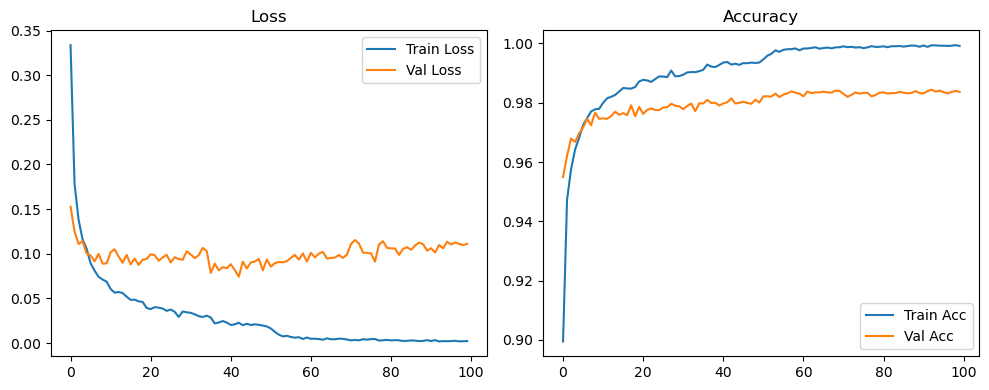

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2316, Acc: 0.9295 | Val Loss: 0.1534, Acc: 0.9554


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1027, Acc: 0.9686 | Val Loss: 0.1237, Acc: 0.9630


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0680, Acc: 0.9783 | Val Loss: 0.1147, Acc: 0.9680


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9843 | Val Loss: 0.1217, Acc: 0.9671


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9872 | Val Loss: 0.1229, Acc: 0.9695


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9896 | Val Loss: 0.1197, Acc: 0.9709


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9911 | Val Loss: 0.1016, Acc: 0.9751


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9912 | Val Loss: 0.1114, Acc: 0.9733


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.1071, Acc: 0.9750


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1384, Acc: 0.9693


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.1284, Acc: 0.9722


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9950 | Val Loss: 0.1108, Acc: 0.9769


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.1241, Acc: 0.9734


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1336, Acc: 0.9717


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.1275, Acc: 0.9734


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1155, Acc: 0.9753


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.1266, Acc: 0.9756


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1119, Acc: 0.9779


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9968 | Val Loss: 0.1243, Acc: 0.9758


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1132, Acc: 0.9764


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9970 | Val Loss: 0.1187, Acc: 0.9754


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9956 | Val Loss: 0.1199, Acc: 0.9748


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1233, Acc: 0.9763


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1084, Acc: 0.9780


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1394, Acc: 0.9735


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9966 | Val Loss: 0.1101, Acc: 0.9773


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1415, Acc: 0.9728


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1219, Acc: 0.9760


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1212, Acc: 0.9755


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1120, Acc: 0.9782


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1290, Acc: 0.9774


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1158, Acc: 0.9778


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1412, Acc: 0.9744


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1172, Acc: 0.9778


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1210, Acc: 0.9779


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1236, Acc: 0.9770


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1395, Acc: 0.9748


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1269, Acc: 0.9758


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1216, Acc: 0.9798


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1275, Acc: 0.9776


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1230, Acc: 0.9768


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1239, Acc: 0.9762


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1238, Acc: 0.9762


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1232, Acc: 0.9773


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1177, Acc: 0.9791


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1168, Acc: 0.9788


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1221, Acc: 0.9785


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1177, Acc: 0.9771


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1097, Acc: 0.9807


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1241, Acc: 0.9779


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1392, Acc: 0.9772


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9976 | Val Loss: 0.1162, Acc: 0.9774


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1138, Acc: 0.9803


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1219, Acc: 0.9792


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.1125, Acc: 0.9786


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1183, Acc: 0.9803


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1289, Acc: 0.9788


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1334, Acc: 0.9789


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1399, Acc: 0.9768


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1188, Acc: 0.9787


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.1214, Acc: 0.9772


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1248, Acc: 0.9792


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1274, Acc: 0.9802


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1194, Acc: 0.9790


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1128, Acc: 0.9804


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1329, Acc: 0.9766


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1342, Acc: 0.9781


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1226, Acc: 0.9775


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1153, Acc: 0.9799


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1174, Acc: 0.9788


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1265, Acc: 0.9792


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1354, Acc: 0.9797


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.1374, Acc: 0.9787


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1272, Acc: 0.9793


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1219, Acc: 0.9800


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1326, Acc: 0.9778


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1339, Acc: 0.9792


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1249, Acc: 0.9790


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1304, Acc: 0.9787


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1456, Acc: 0.9770


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1355, Acc: 0.9779


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1243, Acc: 0.9787


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1309, Acc: 0.9798


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1302, Acc: 0.9772


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9995 | Val Loss: 0.1274, Acc: 0.9800


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.1286, Acc: 0.9808


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1423, Acc: 0.9771


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1260, Acc: 0.9802


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1519, Acc: 0.9768


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1528, Acc: 0.9769


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1491, Acc: 0.9745


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1312, Acc: 0.9779


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1285, Acc: 0.9808


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1298, Acc: 0.9802


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1512, Acc: 0.9778


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1272, Acc: 0.9802


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1264, Acc: 0.9798


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1317, Acc: 0.9788


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1215, Acc: 0.9803


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1307, Acc: 0.9773


Final Test Loss: 0.1217 Accuracy: 0.9794


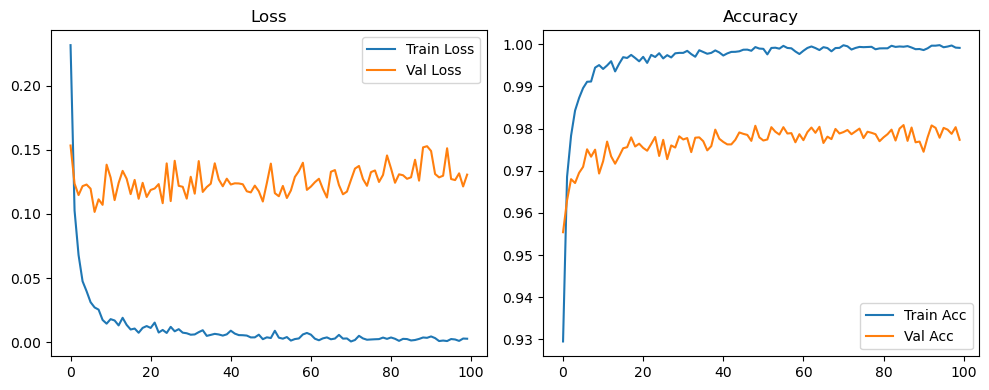

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2466, Acc: 0.9247 | Val Loss: 0.1608, Acc: 0.9522


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1206, Acc: 0.9620 | Val Loss: 0.1243, Acc: 0.9639


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0836, Acc: 0.9736 | Val Loss: 0.1068, Acc: 0.9685


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0623, Acc: 0.9802 | Val Loss: 0.1070, Acc: 0.9699


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9830 | Val Loss: 0.0987, Acc: 0.9729


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9856 | Val Loss: 0.1287, Acc: 0.9684


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9861 | Val Loss: 0.1045, Acc: 0.9722


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9898 | Val Loss: 0.1174, Acc: 0.9711


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9913 | Val Loss: 0.1026, Acc: 0.9757


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9904 | Val Loss: 0.1180, Acc: 0.9721


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.1124, Acc: 0.9748


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.1034, Acc: 0.9768


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.1200, Acc: 0.9727


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.1221, Acc: 0.9722


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9943 | Val Loss: 0.1191, Acc: 0.9748


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.1026, Acc: 0.9756


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9941 | Val Loss: 0.1209, Acc: 0.9734


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9950 | Val Loss: 0.1009, Acc: 0.9768


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1180, Acc: 0.9758


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0996, Acc: 0.9790


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1122, Acc: 0.9768


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.1140, Acc: 0.9767


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1254, Acc: 0.9753


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1046, Acc: 0.9781


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.1138, Acc: 0.9772


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1206, Acc: 0.9759


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1071, Acc: 0.9796


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1238, Acc: 0.9774


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.1178, Acc: 0.9757


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.1123, Acc: 0.9771


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1253, Acc: 0.9775


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9969 | Val Loss: 0.1036, Acc: 0.9795


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1171, Acc: 0.9786


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1160, Acc: 0.9768


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1227, Acc: 0.9758


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.1110, Acc: 0.9777


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9961 | Val Loss: 0.1036, Acc: 0.9804


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1134, Acc: 0.9779


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1014, Acc: 0.9803


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1191, Acc: 0.9777


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1206, Acc: 0.9778


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1181, Acc: 0.9776


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1148, Acc: 0.9779


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9974 | Val Loss: 0.1092, Acc: 0.9792


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1228, Acc: 0.9771


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1182, Acc: 0.9790


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.1190, Acc: 0.9769


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1178, Acc: 0.9772


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1070, Acc: 0.9809


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1215, Acc: 0.9774


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1240, Acc: 0.9788


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1107, Acc: 0.9800


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1202, Acc: 0.9781


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1152, Acc: 0.9784


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1182, Acc: 0.9796


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9974 | Val Loss: 0.1033, Acc: 0.9784


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1163, Acc: 0.9803


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1278, Acc: 0.9774


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1216, Acc: 0.9796


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1221, Acc: 0.9807


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.1176, Acc: 0.9800


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1295, Acc: 0.9795


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1331, Acc: 0.9790


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.1278, Acc: 0.9796


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1290, Acc: 0.9782


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1243, Acc: 0.9806


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1208, Acc: 0.9788


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1120, Acc: 0.9806


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1164, Acc: 0.9797


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1139, Acc: 0.9804


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1206, Acc: 0.9788


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1336, Acc: 0.9784


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1317, Acc: 0.9772


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1115, Acc: 0.9807


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1211, Acc: 0.9811


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1402, Acc: 0.9769


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1262, Acc: 0.9774


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1186, Acc: 0.9811


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1279, Acc: 0.9799


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1276, Acc: 0.9791


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1278, Acc: 0.9790


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9987 | Val Loss: 0.1377, Acc: 0.9769


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1247, Acc: 0.9783


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1265, Acc: 0.9798


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1148, Acc: 0.9812


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1412, Acc: 0.9773


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1325, Acc: 0.9809


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1421, Acc: 0.9790


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1315, Acc: 0.9787


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1376, Acc: 0.9787


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1436, Acc: 0.9795


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1453, Acc: 0.9777


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1350, Acc: 0.9792


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1310, Acc: 0.9786


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1253, Acc: 0.9799


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1329, Acc: 0.9792


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1414, Acc: 0.9785


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1653, Acc: 0.9764


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1339, Acc: 0.9802


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1345, Acc: 0.9799


Final Test Loss: 0.1117 Accuracy: 0.9815


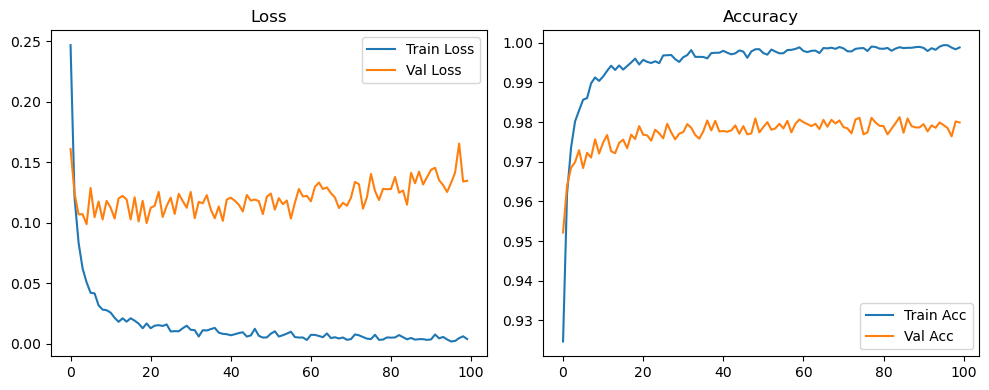

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3007, Acc: 0.9061 | Val Loss: 0.1549, Acc: 0.9538


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1729, Acc: 0.9477 | Val Loss: 0.1143, Acc: 0.9657


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1354, Acc: 0.9593 | Val Loss: 0.1030, Acc: 0.9691


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1061, Acc: 0.9670 | Val Loss: 0.1043, Acc: 0.9689


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0980, Acc: 0.9692 | Val Loss: 0.0927, Acc: 0.9717


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0830, Acc: 0.9744 | Val Loss: 0.0913, Acc: 0.9738


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0762, Acc: 0.9756 | Val Loss: 0.0865, Acc: 0.9768


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0673, Acc: 0.9791 | Val Loss: 0.0960, Acc: 0.9718


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0588, Acc: 0.9813 | Val Loss: 0.0970, Acc: 0.9745


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0631, Acc: 0.9801 | Val Loss: 0.0892, Acc: 0.9744


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0540, Acc: 0.9831 | Val Loss: 0.0888, Acc: 0.9763


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9832 | Val Loss: 0.0886, Acc: 0.9756


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9848 | Val Loss: 0.0922, Acc: 0.9759


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9845 | Val Loss: 0.0879, Acc: 0.9777


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9867 | Val Loss: 0.0974, Acc: 0.9772


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 0.0895, Acc: 0.9758


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9864 | Val Loss: 0.0837, Acc: 0.9788


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9872 | Val Loss: 0.0790, Acc: 0.9796


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9885 | Val Loss: 0.0848, Acc: 0.9778


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9891 | Val Loss: 0.0844, Acc: 0.9801


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9884 | Val Loss: 0.0945, Acc: 0.9778


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9888 | Val Loss: 0.0856, Acc: 0.9785


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.0897, Acc: 0.9789


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9890 | Val Loss: 0.0857, Acc: 0.9790


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0887, Acc: 0.9791


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9909 | Val Loss: 0.0902, Acc: 0.9790


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.0885, Acc: 0.9802


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9909 | Val Loss: 0.0918, Acc: 0.9792


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9904 | Val Loss: 0.0975, Acc: 0.9791


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.0998, Acc: 0.9800


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9908 | Val Loss: 0.0879, Acc: 0.9789


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9914 | Val Loss: 0.0900, Acc: 0.9783


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.0978, Acc: 0.9784


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.0948, Acc: 0.9797


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9922 | Val Loss: 0.0946, Acc: 0.9796


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.0957, Acc: 0.9792


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.0946, Acc: 0.9799


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.0896, Acc: 0.9808


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0913, Acc: 0.9810


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9934 | Val Loss: 0.0938, Acc: 0.9793


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.0922, Acc: 0.9812


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9938 | Val Loss: 0.0986, Acc: 0.9804


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9929 | Val Loss: 0.0960, Acc: 0.9795


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.0955, Acc: 0.9797


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9936 | Val Loss: 0.0995, Acc: 0.9796


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.1028, Acc: 0.9782


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.0993, Acc: 0.9811


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0959, Acc: 0.9803


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.1032, Acc: 0.9805


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0972, Acc: 0.9797


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.1009, Acc: 0.9802


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9944 | Val Loss: 0.0939, Acc: 0.9819


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.0998, Acc: 0.9802


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0989, Acc: 0.9808


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9947 | Val Loss: 0.0940, Acc: 0.9808


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.1090, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9946 | Val Loss: 0.1038, Acc: 0.9794


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.1013, Acc: 0.9804


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.0991, Acc: 0.9800


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1073, Acc: 0.9794


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.1004, Acc: 0.9802


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1025, Acc: 0.9812


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1069, Acc: 0.9804


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.1025, Acc: 0.9797


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.1071, Acc: 0.9792


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9954 | Val Loss: 0.1020, Acc: 0.9804


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.1086, Acc: 0.9807


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9960 | Val Loss: 0.0987, Acc: 0.9802


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9953 | Val Loss: 0.0967, Acc: 0.9811


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.1056, Acc: 0.9798


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1018, Acc: 0.9804


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1037, Acc: 0.9810


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9956 | Val Loss: 0.0954, Acc: 0.9818


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.1009, Acc: 0.9812


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1077, Acc: 0.9809


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1112, Acc: 0.9806


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.0960, Acc: 0.9820


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0992, Acc: 0.9821


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1081, Acc: 0.9802


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.1061, Acc: 0.9804


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1093, Acc: 0.9804


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9959 | Val Loss: 0.1078, Acc: 0.9798


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1038, Acc: 0.9805


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1089, Acc: 0.9813


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9963 | Val Loss: 0.1031, Acc: 0.9814


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9965 | Val Loss: 0.1110, Acc: 0.9807


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1134, Acc: 0.9795


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.1172, Acc: 0.9802


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9961 | Val Loss: 0.1047, Acc: 0.9816


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.1067, Acc: 0.9808


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1077, Acc: 0.9819


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1081, Acc: 0.9816


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.1097, Acc: 0.9808


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9970 | Val Loss: 0.1062, Acc: 0.9805


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1095, Acc: 0.9807


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1097, Acc: 0.9801


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9965 | Val Loss: 0.1106, Acc: 0.9788


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1046, Acc: 0.9818


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1072, Acc: 0.9805


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.1062, Acc: 0.9811


Final Test Loss: 0.0958 Accuracy: 0.9830


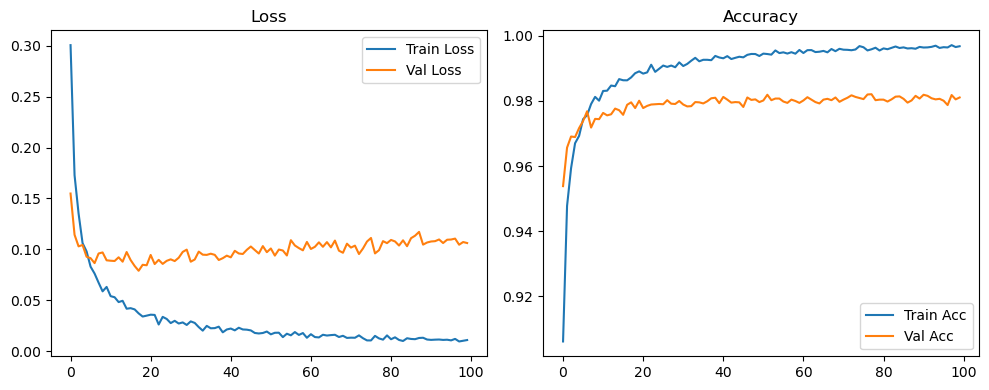

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2316, Acc: 0.9295 | Val Loss: 0.1534, Acc: 0.9554


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1027, Acc: 0.9686 | Val Loss: 0.1237, Acc: 0.9630


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0680, Acc: 0.9783 | Val Loss: 0.1147, Acc: 0.9680


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9843 | Val Loss: 0.1217, Acc: 0.9671


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9872 | Val Loss: 0.1229, Acc: 0.9695


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9896 | Val Loss: 0.1197, Acc: 0.9709


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9911 | Val Loss: 0.1016, Acc: 0.9751


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9912 | Val Loss: 0.1114, Acc: 0.9733


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.1071, Acc: 0.9750


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1384, Acc: 0.9693


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.1284, Acc: 0.9722


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9950 | Val Loss: 0.1108, Acc: 0.9769


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.1241, Acc: 0.9734


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1336, Acc: 0.9717


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.1275, Acc: 0.9734


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1155, Acc: 0.9753


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.1266, Acc: 0.9756


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1119, Acc: 0.9779


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9968 | Val Loss: 0.1243, Acc: 0.9758


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1132, Acc: 0.9764


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9970 | Val Loss: 0.1187, Acc: 0.9754


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9956 | Val Loss: 0.1199, Acc: 0.9748


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1233, Acc: 0.9763


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1084, Acc: 0.9780


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1394, Acc: 0.9735


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9966 | Val Loss: 0.1101, Acc: 0.9773


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1415, Acc: 0.9728


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1219, Acc: 0.9760


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1212, Acc: 0.9755


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1120, Acc: 0.9782


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1290, Acc: 0.9774


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1158, Acc: 0.9778


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1412, Acc: 0.9744


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1172, Acc: 0.9778


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1210, Acc: 0.9779


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1236, Acc: 0.9770


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1395, Acc: 0.9748


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1269, Acc: 0.9758


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1216, Acc: 0.9798


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1275, Acc: 0.9776


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1230, Acc: 0.9768


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1239, Acc: 0.9762


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1238, Acc: 0.9762


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1232, Acc: 0.9773


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1177, Acc: 0.9791


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1168, Acc: 0.9788


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1221, Acc: 0.9785


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1177, Acc: 0.9771


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1097, Acc: 0.9807


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1241, Acc: 0.9779


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1104, Acc: 0.9800


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1118, Acc: 0.9800


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1111, Acc: 0.9805


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1090, Acc: 0.9803


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1143, Acc: 0.9806


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1112, Acc: 0.9797


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1116, Acc: 0.9802


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1132, Acc: 0.9811


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1141, Acc: 0.9808


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1153, Acc: 0.9813


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1166, Acc: 0.9812


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1206, Acc: 0.9814


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1186, Acc: 0.9810


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1182, Acc: 0.9816


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1192, Acc: 0.9815


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1181, Acc: 0.9818


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1242, Acc: 0.9802


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1398, Acc: 0.9788


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1351, Acc: 0.9798


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1246, Acc: 0.9798


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1295, Acc: 0.9801


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1366, Acc: 0.9804


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1368, Acc: 0.9804


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1397, Acc: 0.9792


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1491, Acc: 0.9795


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1433, Acc: 0.9791


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1331, Acc: 0.9807


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.1477, Acc: 0.9787


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1366, Acc: 0.9800


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1393, Acc: 0.9798


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1354, Acc: 0.9799


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1410, Acc: 0.9805


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1396, Acc: 0.9805


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1453, Acc: 0.9801


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1347, Acc: 0.9813


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1348, Acc: 0.9812


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1369, Acc: 0.9807


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1336, Acc: 0.9814


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1342, Acc: 0.9816


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1361, Acc: 0.9812


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1365, Acc: 0.9816


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1377, Acc: 0.9811


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1391, Acc: 0.9814


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1374, Acc: 0.9808


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1380, Acc: 0.9815


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1388, Acc: 0.9816


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1384, Acc: 0.9813


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1454, Acc: 0.9811


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1412, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.1406, Acc: 0.9808


Final Test Loss: 0.1246 Accuracy: 0.9814


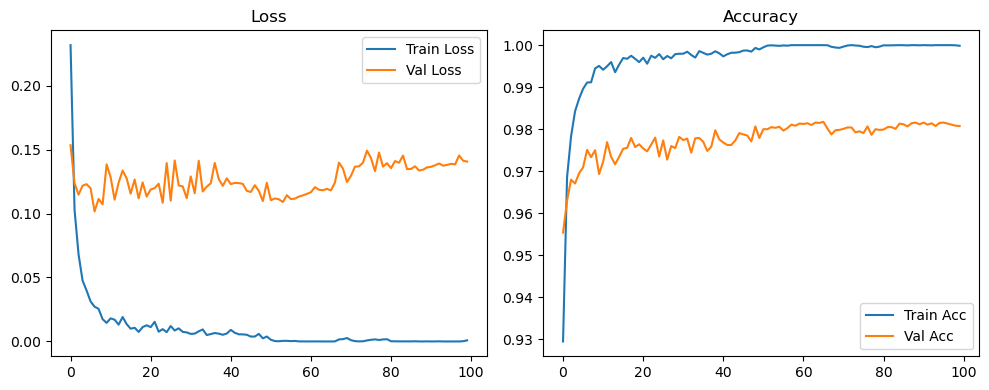

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2466, Acc: 0.9247 | Val Loss: 0.1608, Acc: 0.9522


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1206, Acc: 0.9620 | Val Loss: 0.1243, Acc: 0.9639


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0836, Acc: 0.9736 | Val Loss: 0.1068, Acc: 0.9685


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0623, Acc: 0.9802 | Val Loss: 0.1070, Acc: 0.9699


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9830 | Val Loss: 0.0987, Acc: 0.9729


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9856 | Val Loss: 0.1287, Acc: 0.9684


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9861 | Val Loss: 0.1045, Acc: 0.9722


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9898 | Val Loss: 0.1174, Acc: 0.9711


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9913 | Val Loss: 0.1026, Acc: 0.9757


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9904 | Val Loss: 0.1180, Acc: 0.9721


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.1124, Acc: 0.9748


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.1034, Acc: 0.9768


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.1200, Acc: 0.9727


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.1221, Acc: 0.9722


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9943 | Val Loss: 0.1191, Acc: 0.9748


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.1026, Acc: 0.9756


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9941 | Val Loss: 0.1209, Acc: 0.9734


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9950 | Val Loss: 0.1009, Acc: 0.9768


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1180, Acc: 0.9758


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0996, Acc: 0.9790


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1122, Acc: 0.9768


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.1140, Acc: 0.9767


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1254, Acc: 0.9753


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1046, Acc: 0.9781


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.1138, Acc: 0.9772


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1206, Acc: 0.9759


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1071, Acc: 0.9796


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1238, Acc: 0.9774


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.1178, Acc: 0.9757


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.1123, Acc: 0.9771


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1253, Acc: 0.9775


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9969 | Val Loss: 0.1036, Acc: 0.9795


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1171, Acc: 0.9786


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1160, Acc: 0.9768


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1227, Acc: 0.9758


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.1110, Acc: 0.9777


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9961 | Val Loss: 0.1036, Acc: 0.9804


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1134, Acc: 0.9779


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1014, Acc: 0.9803


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1191, Acc: 0.9777


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1206, Acc: 0.9778


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1181, Acc: 0.9776


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1148, Acc: 0.9779


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9974 | Val Loss: 0.1092, Acc: 0.9792


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1228, Acc: 0.9771


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1182, Acc: 0.9790


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.1190, Acc: 0.9769


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1178, Acc: 0.9772


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1070, Acc: 0.9809


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1215, Acc: 0.9774


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1026, Acc: 0.9812


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1150, Acc: 0.9815


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1108, Acc: 0.9824


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1147, Acc: 0.9822


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1148, Acc: 0.9819


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1206, Acc: 0.9818


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1112, Acc: 0.9814


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1093, Acc: 0.9828


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1129, Acc: 0.9820


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1204, Acc: 0.9812


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1193, Acc: 0.9814


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1169, Acc: 0.9815


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1187, Acc: 0.9814


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1181, Acc: 0.9819


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1224, Acc: 0.9819


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1264, Acc: 0.9816


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1207, Acc: 0.9813


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1206, Acc: 0.9822


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1358, Acc: 0.9802


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1274, Acc: 0.9802


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1236, Acc: 0.9813


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1263, Acc: 0.9810


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1220, Acc: 0.9818


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1366, Acc: 0.9808


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1351, Acc: 0.9800


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1393, Acc: 0.9798


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1324, Acc: 0.9801


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1247, Acc: 0.9814


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1302, Acc: 0.9808


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1350, Acc: 0.9788


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1255, Acc: 0.9806


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1267, Acc: 0.9801


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1242, Acc: 0.9806


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1236, Acc: 0.9809


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1214, Acc: 0.9808


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1229, Acc: 0.9815


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1249, Acc: 0.9812


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1306, Acc: 0.9799


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1299, Acc: 0.9813


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1258, Acc: 0.9816


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1294, Acc: 0.9806


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1327, Acc: 0.9808


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1312, Acc: 0.9811


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1305, Acc: 0.9809


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1337, Acc: 0.9807


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1355, Acc: 0.9820


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1399, Acc: 0.9812


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1385, Acc: 0.9821


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1361, Acc: 0.9822


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1397, Acc: 0.9816


Final Test Loss: 0.1137 Accuracy: 0.9834


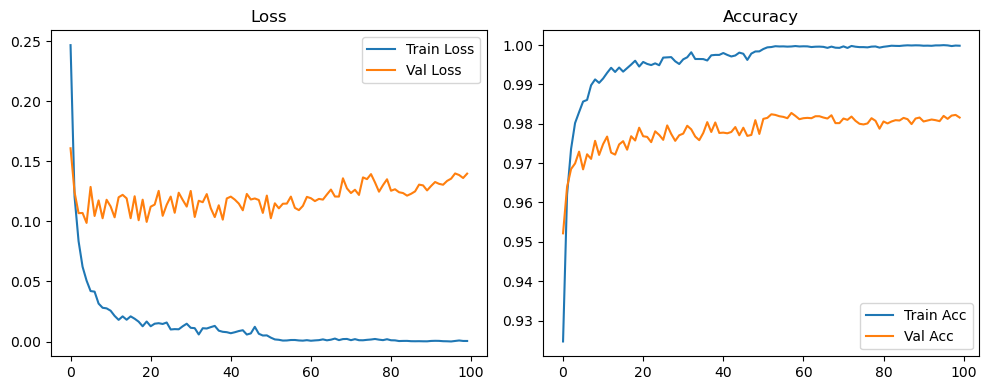

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3007, Acc: 0.9061 | Val Loss: 0.1549, Acc: 0.9538


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1729, Acc: 0.9477 | Val Loss: 0.1143, Acc: 0.9657


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1354, Acc: 0.9593 | Val Loss: 0.1030, Acc: 0.9691


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1061, Acc: 0.9670 | Val Loss: 0.1043, Acc: 0.9689


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0980, Acc: 0.9692 | Val Loss: 0.0927, Acc: 0.9717


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0830, Acc: 0.9744 | Val Loss: 0.0913, Acc: 0.9738


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0762, Acc: 0.9756 | Val Loss: 0.0865, Acc: 0.9768


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0673, Acc: 0.9791 | Val Loss: 0.0960, Acc: 0.9718


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0588, Acc: 0.9813 | Val Loss: 0.0970, Acc: 0.9745


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0631, Acc: 0.9801 | Val Loss: 0.0892, Acc: 0.9744


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0540, Acc: 0.9831 | Val Loss: 0.0888, Acc: 0.9763


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9832 | Val Loss: 0.0886, Acc: 0.9756


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9848 | Val Loss: 0.0922, Acc: 0.9759


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9845 | Val Loss: 0.0879, Acc: 0.9777


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9867 | Val Loss: 0.0974, Acc: 0.9772


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 0.0895, Acc: 0.9758


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9864 | Val Loss: 0.0837, Acc: 0.9788


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9872 | Val Loss: 0.0790, Acc: 0.9796


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9885 | Val Loss: 0.0848, Acc: 0.9778


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9891 | Val Loss: 0.0844, Acc: 0.9801


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9884 | Val Loss: 0.0945, Acc: 0.9778


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9888 | Val Loss: 0.0856, Acc: 0.9785


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.0897, Acc: 0.9789


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9890 | Val Loss: 0.0857, Acc: 0.9790


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0887, Acc: 0.9791


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9909 | Val Loss: 0.0902, Acc: 0.9790


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.0885, Acc: 0.9802


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9909 | Val Loss: 0.0918, Acc: 0.9792


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9904 | Val Loss: 0.0975, Acc: 0.9791


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.0998, Acc: 0.9800


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9908 | Val Loss: 0.0879, Acc: 0.9789


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9914 | Val Loss: 0.0900, Acc: 0.9783


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.0978, Acc: 0.9784


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.0948, Acc: 0.9797


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9922 | Val Loss: 0.0946, Acc: 0.9796


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.0957, Acc: 0.9792


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.0946, Acc: 0.9799


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.0896, Acc: 0.9808


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0913, Acc: 0.9810


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9934 | Val Loss: 0.0938, Acc: 0.9793


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.0922, Acc: 0.9812


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9938 | Val Loss: 0.0986, Acc: 0.9804


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9929 | Val Loss: 0.0960, Acc: 0.9795


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.0955, Acc: 0.9797


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9936 | Val Loss: 0.0995, Acc: 0.9796


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.1028, Acc: 0.9782


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.0993, Acc: 0.9811


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0959, Acc: 0.9803


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.1032, Acc: 0.9805


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0972, Acc: 0.9797


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0933, Acc: 0.9817


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0900, Acc: 0.9823


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.0921, Acc: 0.9816


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0925, Acc: 0.9822


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0919, Acc: 0.9828


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0969, Acc: 0.9819


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0985, Acc: 0.9828


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1092, Acc: 0.9812


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1034, Acc: 0.9815


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1064, Acc: 0.9823


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1048, Acc: 0.9815


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1072, Acc: 0.9823


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1096, Acc: 0.9806


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1137, Acc: 0.9823


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1112, Acc: 0.9812


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1134, Acc: 0.9817


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1132, Acc: 0.9822


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1102, Acc: 0.9828


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1063, Acc: 0.9811


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1050, Acc: 0.9813


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1064, Acc: 0.9817


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1008, Acc: 0.9830


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0980, Acc: 0.9828


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1007, Acc: 0.9824


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1077, Acc: 0.9824


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1054, Acc: 0.9828


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1107, Acc: 0.9817


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1094, Acc: 0.9810


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1076, Acc: 0.9832


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.1072, Acc: 0.9826


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1071, Acc: 0.9832


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1092, Acc: 0.9822


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1074, Acc: 0.9828


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1086, Acc: 0.9822


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9987 | Val Loss: 0.1108, Acc: 0.9822


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1059, Acc: 0.9838


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1069, Acc: 0.9834


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1094, Acc: 0.9824


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1091, Acc: 0.9831


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1068, Acc: 0.9826


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1081, Acc: 0.9830


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1131, Acc: 0.9823


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1125, Acc: 0.9828


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1107, Acc: 0.9822


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1111, Acc: 0.9832


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1128, Acc: 0.9831


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1073, Acc: 0.9827


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1137, Acc: 0.9825


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1158, Acc: 0.9827


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1185, Acc: 0.9829


Final Test Loss: 0.1071 Accuracy: 0.9844


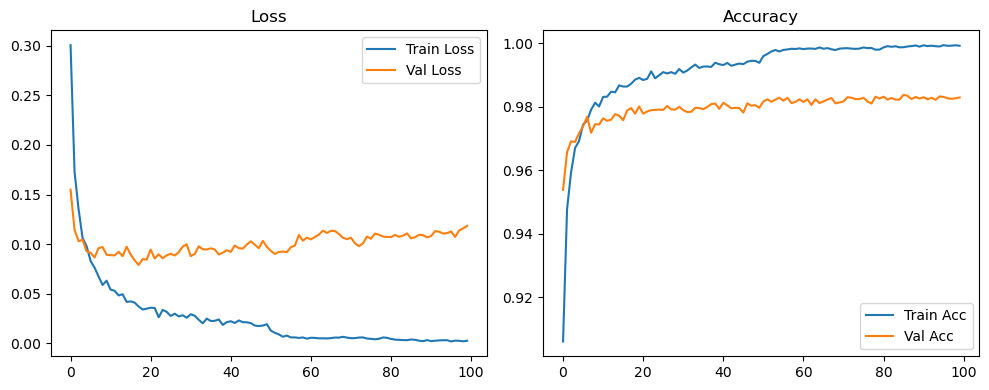

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1980, Acc: 0.9382 | Val Loss: 0.1258, Acc: 0.9608


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0869, Acc: 0.9726 | Val Loss: 0.1496, Acc: 0.9579


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0578, Acc: 0.9814 | Val Loss: 0.1117, Acc: 0.9678


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9866 | Val Loss: 0.1064, Acc: 0.9695


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9894 | Val Loss: 0.1243, Acc: 0.9666


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9908 | Val Loss: 0.1230, Acc: 0.9699


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.1193, Acc: 0.9728


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.1096, Acc: 0.9739


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.1125, Acc: 0.9756


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1135, Acc: 0.9748


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1295, Acc: 0.9725


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9947 | Val Loss: 0.1236, Acc: 0.9729


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.1246, Acc: 0.9746


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1189, Acc: 0.9752


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.1109, Acc: 0.9758


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1215, Acc: 0.9758


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1166, Acc: 0.9758


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1167, Acc: 0.9772


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1275, Acc: 0.9742


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.1180, Acc: 0.9752


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1172, Acc: 0.9780


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1203, Acc: 0.9763


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1347, Acc: 0.9763


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.1362, Acc: 0.9741


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.1118, Acc: 0.9774


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1306, Acc: 0.9758


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1324, Acc: 0.9758


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1237, Acc: 0.9778


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.1126, Acc: 0.9780


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1439, Acc: 0.9738


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1527, Acc: 0.9731


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1216, Acc: 0.9775


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1274, Acc: 0.9774


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1132, Acc: 0.9788


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1326, Acc: 0.9768


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1353, Acc: 0.9749


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1179, Acc: 0.9792


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1206, Acc: 0.9781


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1150, Acc: 0.9792


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1477, Acc: 0.9768


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1373, Acc: 0.9771


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1346, Acc: 0.9789


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.1296, Acc: 0.9787


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1265, Acc: 0.9782


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1317, Acc: 0.9791


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1151, Acc: 0.9798


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1205, Acc: 0.9802


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1457, Acc: 0.9768


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1524, Acc: 0.9738


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9968 | Val Loss: 0.1197, Acc: 0.9780


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1083, Acc: 0.9812


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1264, Acc: 0.9793


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1174, Acc: 0.9792


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1170, Acc: 0.9793


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1130, Acc: 0.9800


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1147, Acc: 0.9801


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1425, Acc: 0.9763


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1175, Acc: 0.9802


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1249, Acc: 0.9797


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1232, Acc: 0.9789


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1276, Acc: 0.9794


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1380, Acc: 0.9777


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1214, Acc: 0.9784


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1187, Acc: 0.9797


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1207, Acc: 0.9811


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1405, Acc: 0.9771


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.1444, Acc: 0.9762


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1262, Acc: 0.9779


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1463, Acc: 0.9780


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1307, Acc: 0.9797


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1194, Acc: 0.9802


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1331, Acc: 0.9796


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.1452, Acc: 0.9786


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1328, Acc: 0.9788


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1302, Acc: 0.9783


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1386, Acc: 0.9781


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1142, Acc: 0.9805


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.1198, Acc: 0.9798


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1246, Acc: 0.9800


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1345, Acc: 0.9783


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1492, Acc: 0.9778


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1286, Acc: 0.9803


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1409, Acc: 0.9800


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1393, Acc: 0.9787


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1312, Acc: 0.9793


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1296, Acc: 0.9798


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1464, Acc: 0.9775


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1266, Acc: 0.9799


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1272, Acc: 0.9795


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1313, Acc: 0.9785


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1353, Acc: 0.9789


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1321, Acc: 0.9800


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1463, Acc: 0.9784


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1390, Acc: 0.9788


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1487, Acc: 0.9762


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1251, Acc: 0.9791


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1391, Acc: 0.9782


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9997 | Val Loss: 0.1387, Acc: 0.9792


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1413, Acc: 0.9790


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1299, Acc: 0.9809


Final Test Loss: 0.0981 Accuracy: 0.9816


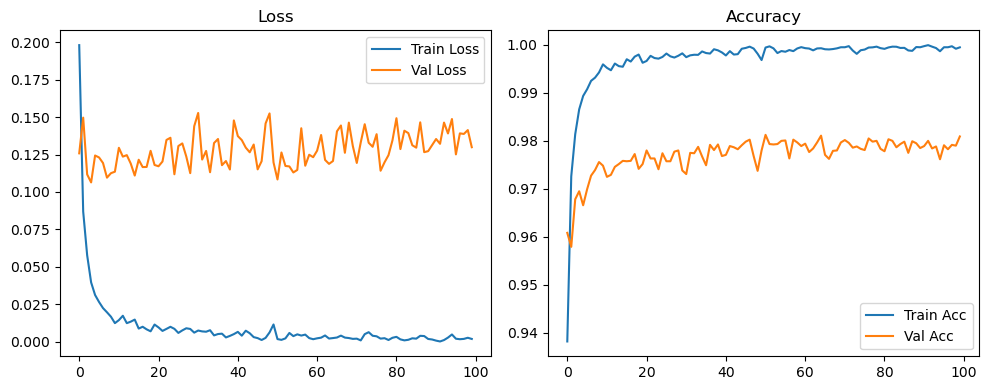

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2202, Acc: 0.9306 | Val Loss: 0.1211, Acc: 0.9636


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1069, Acc: 0.9658 | Val Loss: 0.1126, Acc: 0.9664


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0737, Acc: 0.9765 | Val Loss: 0.0997, Acc: 0.9714


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0562, Acc: 0.9815 | Val Loss: 0.0998, Acc: 0.9700


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9852 | Val Loss: 0.1099, Acc: 0.9698


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9872 | Val Loss: 0.1004, Acc: 0.9734


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9891 | Val Loss: 0.1057, Acc: 0.9740


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9898 | Val Loss: 0.1096, Acc: 0.9696


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9911 | Val Loss: 0.0878, Acc: 0.9775


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9919 | Val Loss: 0.1016, Acc: 0.9745


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9928 | Val Loss: 0.1039, Acc: 0.9758


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.1017, Acc: 0.9765


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1020, Acc: 0.9753


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.0992, Acc: 0.9764


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.1028, Acc: 0.9776


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.1187, Acc: 0.9733


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.1173, Acc: 0.9737


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1048, Acc: 0.9785


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1092, Acc: 0.9775


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1140, Acc: 0.9770


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.1192, Acc: 0.9747


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.1062, Acc: 0.9768


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1174, Acc: 0.9778


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1134, Acc: 0.9784


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.1136, Acc: 0.9758


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.1078, Acc: 0.9792


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1105, Acc: 0.9792


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1175, Acc: 0.9777


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1125, Acc: 0.9790


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.1278, Acc: 0.9769


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1270, Acc: 0.9768


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1222, Acc: 0.9785


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1191, Acc: 0.9791


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1228, Acc: 0.9773


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1232, Acc: 0.9775


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1215, Acc: 0.9765


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1105, Acc: 0.9795


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1176, Acc: 0.9780


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1350, Acc: 0.9768


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.1155, Acc: 0.9779


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1281, Acc: 0.9769


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1258, Acc: 0.9772


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1054, Acc: 0.9805


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1100, Acc: 0.9790


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1191, Acc: 0.9779


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1200, Acc: 0.9800


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1202, Acc: 0.9782


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1254, Acc: 0.9774


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1212, Acc: 0.9795


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1118, Acc: 0.9809


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1248, Acc: 0.9780


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1173, Acc: 0.9796


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1087, Acc: 0.9810


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1232, Acc: 0.9792


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1173, Acc: 0.9795


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1208, Acc: 0.9788


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1162, Acc: 0.9790


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.1149, Acc: 0.9802


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1181, Acc: 0.9811


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1196, Acc: 0.9790


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1316, Acc: 0.9784


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1298, Acc: 0.9787


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1211, Acc: 0.9788


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1177, Acc: 0.9804


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1319, Acc: 0.9788


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1287, Acc: 0.9790


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1196, Acc: 0.9803


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1280, Acc: 0.9784


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1288, Acc: 0.9794


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1350, Acc: 0.9786


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1225, Acc: 0.9802


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1241, Acc: 0.9813


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1304, Acc: 0.9803


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1175, Acc: 0.9822


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1186, Acc: 0.9818


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1306, Acc: 0.9794


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.1317, Acc: 0.9803


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.1183, Acc: 0.9804


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1183, Acc: 0.9803


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1271, Acc: 0.9808


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1230, Acc: 0.9792


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1246, Acc: 0.9812


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1325, Acc: 0.9790


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1262, Acc: 0.9812


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1263, Acc: 0.9809


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1471, Acc: 0.9789


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1367, Acc: 0.9801


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1430, Acc: 0.9794


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1289, Acc: 0.9801


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1273, Acc: 0.9800


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1358, Acc: 0.9804


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1365, Acc: 0.9806


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.1297, Acc: 0.9801


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1434, Acc: 0.9790


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1378, Acc: 0.9796


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1503, Acc: 0.9792


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1409, Acc: 0.9798


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1410, Acc: 0.9803


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1369, Acc: 0.9796


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1331, Acc: 0.9808


Final Test Loss: 0.1231 Accuracy: 0.9809


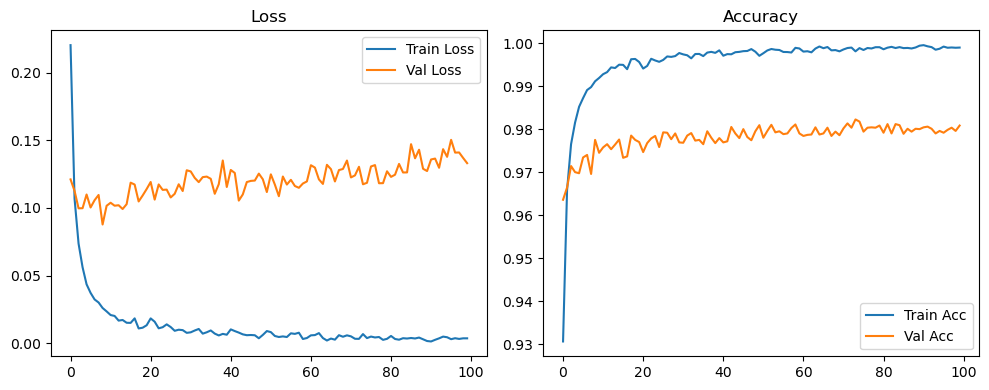

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2981, Acc: 0.9063 | Val Loss: 0.1421, Acc: 0.9577


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1620, Acc: 0.9494 | Val Loss: 0.1157, Acc: 0.9646


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1226, Acc: 0.9622 | Val Loss: 0.1016, Acc: 0.9681


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1028, Acc: 0.9675 | Val Loss: 0.0992, Acc: 0.9696


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0909, Acc: 0.9706 | Val Loss: 0.0921, Acc: 0.9729


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0825, Acc: 0.9734 | Val Loss: 0.0939, Acc: 0.9741


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0724, Acc: 0.9755 | Val Loss: 0.0880, Acc: 0.9744


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0651, Acc: 0.9787 | Val Loss: 0.0914, Acc: 0.9733


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0587, Acc: 0.9809 | Val Loss: 0.0892, Acc: 0.9766


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0566, Acc: 0.9816 | Val Loss: 0.0875, Acc: 0.9755


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0507, Acc: 0.9831 | Val Loss: 0.0951, Acc: 0.9758


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0505, Acc: 0.9835 | Val Loss: 0.0942, Acc: 0.9761


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0425, Acc: 0.9858 | Val Loss: 0.0935, Acc: 0.9772


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0425, Acc: 0.9863 | Val Loss: 0.0908, Acc: 0.9762


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9853 | Val Loss: 0.0860, Acc: 0.9782


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9867 | Val Loss: 0.0850, Acc: 0.9772


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9879 | Val Loss: 0.0910, Acc: 0.9772


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9888 | Val Loss: 0.0885, Acc: 0.9783


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9888 | Val Loss: 0.0930, Acc: 0.9766


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9893 | Val Loss: 0.0878, Acc: 0.9788


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.0914, Acc: 0.9783


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9907 | Val Loss: 0.0870, Acc: 0.9795


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.0910, Acc: 0.9803


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9905 | Val Loss: 0.0880, Acc: 0.9788


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9906 | Val Loss: 0.0896, Acc: 0.9799


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.0918, Acc: 0.9802


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9910 | Val Loss: 0.0930, Acc: 0.9792


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.0878, Acc: 0.9799


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9915 | Val Loss: 0.0937, Acc: 0.9789


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9921 | Val Loss: 0.0937, Acc: 0.9797


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9918 | Val Loss: 0.0915, Acc: 0.9793


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.0872, Acc: 0.9794


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.0948, Acc: 0.9787


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0877, Acc: 0.9800


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0931, Acc: 0.9797


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9943 | Val Loss: 0.0991, Acc: 0.9773


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9941 | Val Loss: 0.0941, Acc: 0.9798


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0958, Acc: 0.9795


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0930, Acc: 0.9808


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9940 | Val Loss: 0.0987, Acc: 0.9792


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.0938, Acc: 0.9808


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9943 | Val Loss: 0.0899, Acc: 0.9805


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0934, Acc: 0.9791


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9943 | Val Loss: 0.0916, Acc: 0.9812


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.0985, Acc: 0.9807


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.0917, Acc: 0.9808


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9951 | Val Loss: 0.0961, Acc: 0.9792


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.0884, Acc: 0.9806


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.0938, Acc: 0.9805


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0887, Acc: 0.9805


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.0942, Acc: 0.9806


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0900, Acc: 0.9812


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0902, Acc: 0.9814


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.0975, Acc: 0.9807


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0980, Acc: 0.9807


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9950 | Val Loss: 0.0942, Acc: 0.9812


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.0892, Acc: 0.9813


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0895, Acc: 0.9818


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0960, Acc: 0.9808


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.0938, Acc: 0.9808


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.1050, Acc: 0.9795


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1026, Acc: 0.9800


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0993, Acc: 0.9803


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0985, Acc: 0.9798


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0992, Acc: 0.9810


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0999, Acc: 0.9799


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0978, Acc: 0.9814


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0963, Acc: 0.9805


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0918, Acc: 0.9817


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0991, Acc: 0.9813


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0998, Acc: 0.9822


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0980, Acc: 0.9817


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1017, Acc: 0.9807


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0957, Acc: 0.9817


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1041, Acc: 0.9817


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0992, Acc: 0.9829


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9962 | Val Loss: 0.0976, Acc: 0.9810


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1017, Acc: 0.9807


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1075, Acc: 0.9812


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1131, Acc: 0.9797


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.1047, Acc: 0.9813


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1058, Acc: 0.9812


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1044, Acc: 0.9812


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.1026, Acc: 0.9810


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1046, Acc: 0.9819


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1068, Acc: 0.9812


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1115, Acc: 0.9796


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1110, Acc: 0.9820


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1033, Acc: 0.9809


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1025, Acc: 0.9816


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1031, Acc: 0.9827


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1041, Acc: 0.9817


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1033, Acc: 0.9820


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0995, Acc: 0.9823


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1029, Acc: 0.9808


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.1016, Acc: 0.9817


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0983, Acc: 0.9816


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1039, Acc: 0.9812


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.0992, Acc: 0.9816


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1100, Acc: 0.9812


Final Test Loss: 0.0979 Accuracy: 0.9832


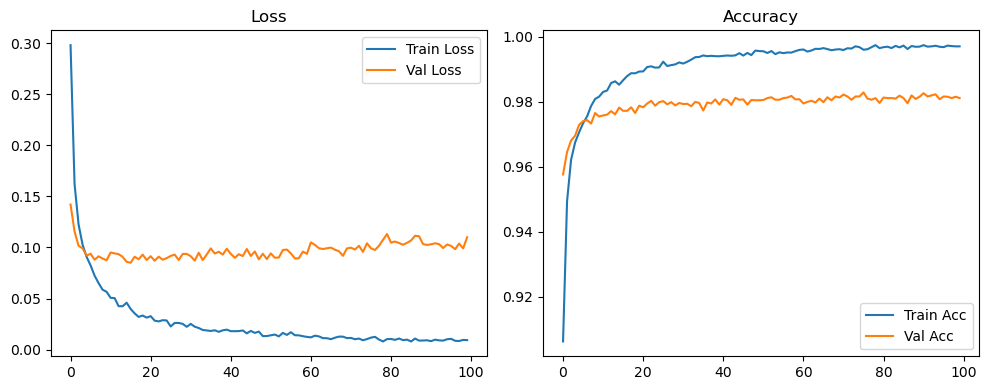

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1905, Acc: 0.9399 | Val Loss: 0.1162, Acc: 0.9641


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0761, Acc: 0.9762 | Val Loss: 0.1327, Acc: 0.9597


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0477, Acc: 0.9842 | Val Loss: 0.1019, Acc: 0.9700


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9905 | Val Loss: 0.1090, Acc: 0.9714


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.1109, Acc: 0.9702


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.1210, Acc: 0.9692


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.1017, Acc: 0.9734


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1119, Acc: 0.9719


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0985, Acc: 0.9771


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1030, Acc: 0.9752


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.1144, Acc: 0.9732


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.1311, Acc: 0.9698


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1175, Acc: 0.9723


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.1031, Acc: 0.9771


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1061, Acc: 0.9778


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1219, Acc: 0.9759


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1169, Acc: 0.9766


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1156, Acc: 0.9761


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.1227, Acc: 0.9748


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1203, Acc: 0.9752


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1092, Acc: 0.9762


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1118, Acc: 0.9792


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1194, Acc: 0.9766


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1129, Acc: 0.9759


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1100, Acc: 0.9769


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1153, Acc: 0.9770


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1053, Acc: 0.9791


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1179, Acc: 0.9779


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 0.1271, Acc: 0.9748


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1099, Acc: 0.9783


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1130, Acc: 0.9782


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1201, Acc: 0.9753


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1004, Acc: 0.9805


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1289, Acc: 0.9758


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1115, Acc: 0.9786


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1300, Acc: 0.9753


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1113, Acc: 0.9782


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1113, Acc: 0.9785


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1133, Acc: 0.9787


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1339, Acc: 0.9748


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.1305, Acc: 0.9767


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1352, Acc: 0.9768


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1128, Acc: 0.9801


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1137, Acc: 0.9795


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1194, Acc: 0.9780


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1259, Acc: 0.9772


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1129, Acc: 0.9808


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1095, Acc: 0.9804


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1179, Acc: 0.9795


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1233, Acc: 0.9784


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1589, Acc: 0.9740


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1466, Acc: 0.9751


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1174, Acc: 0.9788


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1355, Acc: 0.9752


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1293, Acc: 0.9770


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1149, Acc: 0.9794


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1205, Acc: 0.9792


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1066, Acc: 0.9808


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1280, Acc: 0.9781


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1105, Acc: 0.9798


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1166, Acc: 0.9784


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1188, Acc: 0.9783


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1174, Acc: 0.9799


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1531, Acc: 0.9742


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.1209, Acc: 0.9789


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1089, Acc: 0.9792


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1282, Acc: 0.9793


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1142, Acc: 0.9809


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1137, Acc: 0.9814


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1101, Acc: 0.9822


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1079, Acc: 0.9826


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1067, Acc: 0.9820


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1057, Acc: 0.9827


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1052, Acc: 0.9826


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1099, Acc: 0.9822


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1084, Acc: 0.9822


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1073, Acc: 0.9830


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1073, Acc: 0.9828


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1078, Acc: 0.9822


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1080, Acc: 0.9822


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9969 | Val Loss: 0.1808, Acc: 0.9677


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9942 | Val Loss: 0.1139, Acc: 0.9777


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1059, Acc: 0.9803


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1030, Acc: 0.9805


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1057, Acc: 0.9810


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1061, Acc: 0.9806


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1101, Acc: 0.9810


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1128, Acc: 0.9802


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1240, Acc: 0.9798


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1183, Acc: 0.9790


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1249, Acc: 0.9792


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1385, Acc: 0.9763


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1278, Acc: 0.9784


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1358, Acc: 0.9787


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1254, Acc: 0.9786


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1230, Acc: 0.9801


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1191, Acc: 0.9804


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1220, Acc: 0.9808


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1241, Acc: 0.9799


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1273, Acc: 0.9795


Final Test Loss: 0.1127 Accuracy: 0.9819


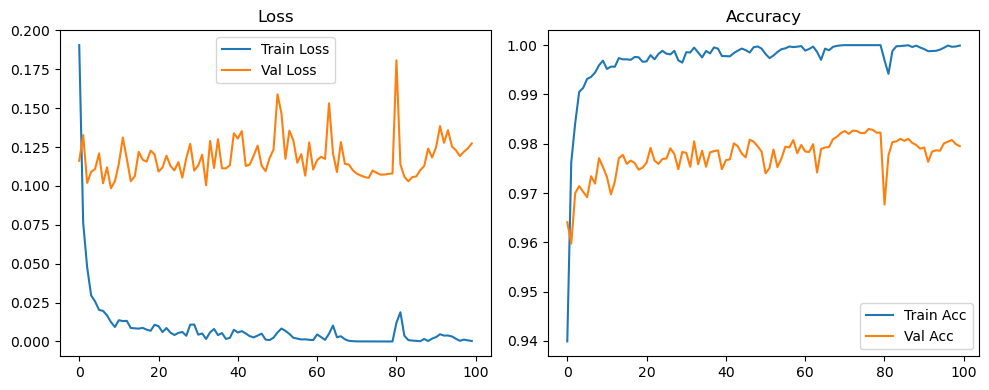

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2237, Acc: 0.9303 | Val Loss: 0.1201, Acc: 0.9627


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0981, Acc: 0.9683 | Val Loss: 0.1186, Acc: 0.9636


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0661, Acc: 0.9786 | Val Loss: 0.1035, Acc: 0.9688


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0471, Acc: 0.9847 | Val Loss: 0.1085, Acc: 0.9692


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0414, Acc: 0.9863 | Val Loss: 0.0988, Acc: 0.9717


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9879 | Val Loss: 0.0987, Acc: 0.9727


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9900 | Val Loss: 0.1090, Acc: 0.9718


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9921 | Val Loss: 0.1059, Acc: 0.9718


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.1029, Acc: 0.9741


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9933 | Val Loss: 0.0958, Acc: 0.9745


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.1028, Acc: 0.9766


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.1035, Acc: 0.9766


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.1013, Acc: 0.9770


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9942 | Val Loss: 0.0958, Acc: 0.9767


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.1027, Acc: 0.9762


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1057, Acc: 0.9768


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.1055, Acc: 0.9753


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.1085, Acc: 0.9756


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9953 | Val Loss: 0.1140, Acc: 0.9743


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.1144, Acc: 0.9750


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1084, Acc: 0.9773


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1107, Acc: 0.9764


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1101, Acc: 0.9773


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1114, Acc: 0.9785


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1153, Acc: 0.9771


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9972 | Val Loss: 0.1144, Acc: 0.9783


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1223, Acc: 0.9771


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1235, Acc: 0.9761


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9964 | Val Loss: 0.1132, Acc: 0.9768


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1225, Acc: 0.9758


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1320, Acc: 0.9749


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1118, Acc: 0.9791


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.1160, Acc: 0.9780


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1303, Acc: 0.9753


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1154, Acc: 0.9780


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1180, Acc: 0.9775


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1242, Acc: 0.9785


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1165, Acc: 0.9773


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1132, Acc: 0.9778


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1151, Acc: 0.9773


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1186, Acc: 0.9779


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1141, Acc: 0.9789


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1191, Acc: 0.9768


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1286, Acc: 0.9770


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1309, Acc: 0.9768


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1184, Acc: 0.9782


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1140, Acc: 0.9776


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1143, Acc: 0.9785


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1258, Acc: 0.9778


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1213, Acc: 0.9795


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1126, Acc: 0.9788


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1306, Acc: 0.9760


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1230, Acc: 0.9781


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1182, Acc: 0.9788


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1230, Acc: 0.9763


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1174, Acc: 0.9785


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1177, Acc: 0.9790


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1207, Acc: 0.9805


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1190, Acc: 0.9794


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1172, Acc: 0.9798


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1202, Acc: 0.9801


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1170, Acc: 0.9793


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1287, Acc: 0.9781


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1270, Acc: 0.9791


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1211, Acc: 0.9789


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1135, Acc: 0.9796


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1134, Acc: 0.9800


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1221, Acc: 0.9789


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1345, Acc: 0.9771


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1155, Acc: 0.9793


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1167, Acc: 0.9782


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1304, Acc: 0.9789


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1297, Acc: 0.9774


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1314, Acc: 0.9769


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1191, Acc: 0.9803


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1158, Acc: 0.9800


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1141, Acc: 0.9795


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1301, Acc: 0.9794


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1249, Acc: 0.9800


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1344, Acc: 0.9784


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1269, Acc: 0.9791


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1298, Acc: 0.9787


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1176, Acc: 0.9812


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1344, Acc: 0.9778


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1201, Acc: 0.9798


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1219, Acc: 0.9793


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1286, Acc: 0.9800


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1322, Acc: 0.9794


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1261, Acc: 0.9794


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1303, Acc: 0.9792


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1277, Acc: 0.9802


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1447, Acc: 0.9783


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1255, Acc: 0.9788


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1344, Acc: 0.9784


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1362, Acc: 0.9791


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1291, Acc: 0.9788


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1218, Acc: 0.9801


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1269, Acc: 0.9797


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1170, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1337, Acc: 0.9802


Final Test Loss: 0.1323 Accuracy: 0.9810


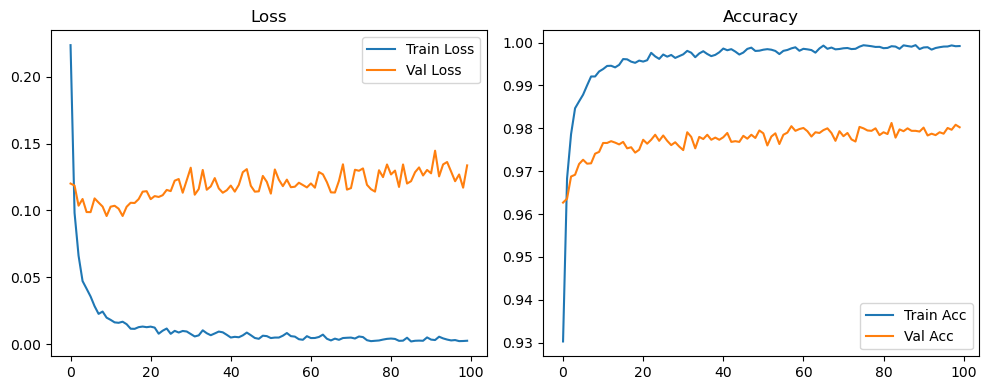

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3296, Acc: 0.8985 | Val Loss: 0.1447, Acc: 0.9553


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1605, Acc: 0.9503 | Val Loss: 0.1140, Acc: 0.9637


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1193, Acc: 0.9625 | Val Loss: 0.0951, Acc: 0.9704


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0998, Acc: 0.9680 | Val Loss: 0.0942, Acc: 0.9706


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0891, Acc: 0.9710 | Val Loss: 0.0897, Acc: 0.9732


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0760, Acc: 0.9755 | Val Loss: 0.0860, Acc: 0.9745


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0682, Acc: 0.9782 | Val Loss: 0.0874, Acc: 0.9746


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0649, Acc: 0.9786 | Val Loss: 0.0905, Acc: 0.9733


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0598, Acc: 0.9802 | Val Loss: 0.0846, Acc: 0.9759


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0566, Acc: 0.9814 | Val Loss: 0.0882, Acc: 0.9744


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0522, Acc: 0.9822 | Val Loss: 0.0858, Acc: 0.9758


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0455, Acc: 0.9846 | Val Loss: 0.0947, Acc: 0.9758


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9853 | Val Loss: 0.0832, Acc: 0.9772


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9858 | Val Loss: 0.0835, Acc: 0.9762


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0404, Acc: 0.9862 | Val Loss: 0.0877, Acc: 0.9776


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0378, Acc: 0.9873 | Val Loss: 0.0860, Acc: 0.9778


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9880 | Val Loss: 0.0854, Acc: 0.9776


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9884 | Val Loss: 0.0867, Acc: 0.9778


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9890 | Val Loss: 0.0863, Acc: 0.9770


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9890 | Val Loss: 0.0841, Acc: 0.9787


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9905 | Val Loss: 0.0968, Acc: 0.9765


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9897 | Val Loss: 0.0839, Acc: 0.9780


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9908 | Val Loss: 0.0808, Acc: 0.9784


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9908 | Val Loss: 0.0858, Acc: 0.9792


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.0840, Acc: 0.9787


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.0876, Acc: 0.9798


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9923 | Val Loss: 0.0924, Acc: 0.9778


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0906, Acc: 0.9792


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9915 | Val Loss: 0.0889, Acc: 0.9802


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.0976, Acc: 0.9776


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.0894, Acc: 0.9787


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9931 | Val Loss: 0.0921, Acc: 0.9788


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.0965, Acc: 0.9778


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9931 | Val Loss: 0.0905, Acc: 0.9799


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.0952, Acc: 0.9781


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.0984, Acc: 0.9782


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9930 | Val Loss: 0.0940, Acc: 0.9800


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9936 | Val Loss: 0.0949, Acc: 0.9782


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.0882, Acc: 0.9801


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0916, Acc: 0.9793


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.1003, Acc: 0.9793


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0970, Acc: 0.9801


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9942 | Val Loss: 0.0935, Acc: 0.9808


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0956, Acc: 0.9806


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0939, Acc: 0.9812


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9946 | Val Loss: 0.0947, Acc: 0.9805


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9949 | Val Loss: 0.0954, Acc: 0.9801


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.1000, Acc: 0.9802


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0956, Acc: 0.9802


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9946 | Val Loss: 0.0971, Acc: 0.9808


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0950, Acc: 0.9803


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0973, Acc: 0.9789


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0950, Acc: 0.9799


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0957, Acc: 0.9806


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0897, Acc: 0.9809


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.1009, Acc: 0.9807


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0973, Acc: 0.9806


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.0998, Acc: 0.9802


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.0991, Acc: 0.9808


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0951, Acc: 0.9813


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0984, Acc: 0.9802


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0999, Acc: 0.9809


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1083, Acc: 0.9797


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0985, Acc: 0.9818


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0953, Acc: 0.9818


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1045, Acc: 0.9796


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0993, Acc: 0.9811


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0992, Acc: 0.9816


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1000, Acc: 0.9804


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1041, Acc: 0.9821


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0975, Acc: 0.9822


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0943, Acc: 0.9824


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.0982, Acc: 0.9818


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1020, Acc: 0.9811


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0984, Acc: 0.9817


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1045, Acc: 0.9799


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0979, Acc: 0.9821


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1011, Acc: 0.9821


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1005, Acc: 0.9807


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0995, Acc: 0.9820


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0966, Acc: 0.9816


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1017, Acc: 0.9818


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0955, Acc: 0.9827


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0935, Acc: 0.9822


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1001, Acc: 0.9829


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.1044, Acc: 0.9816


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1050, Acc: 0.9807


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1034, Acc: 0.9808


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1019, Acc: 0.9814


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1088, Acc: 0.9800


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1076, Acc: 0.9815


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1055, Acc: 0.9811


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1087, Acc: 0.9812


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1105, Acc: 0.9812


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9976 | Val Loss: 0.1071, Acc: 0.9812


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.1070, Acc: 0.9804


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1020, Acc: 0.9812


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1073, Acc: 0.9804


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1080, Acc: 0.9809


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1061, Acc: 0.9809


Final Test Loss: 0.0955 Accuracy: 0.9825


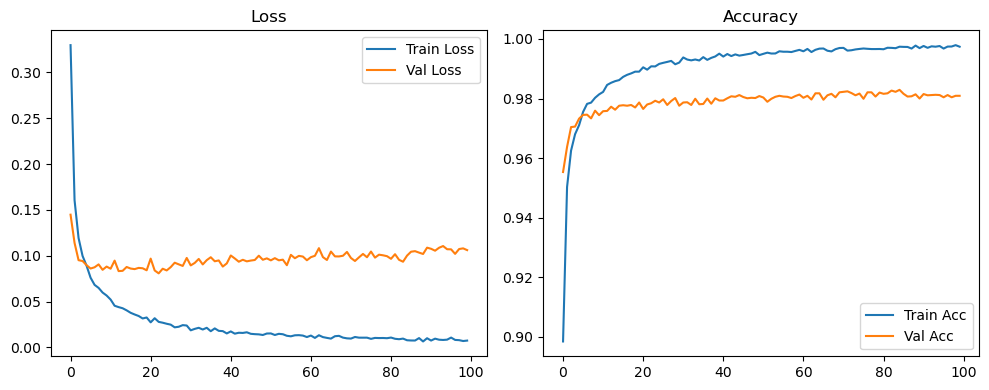

🏆 Best Config: batch128_lr0.005_0.002_0.001_dp0.5 Accuracy: 0.9856


In [8]:
root_path = "MLP_1024_8bit_regular_ReLU"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)